In [23]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [24]:
transform = transforms.ToTensor()

trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

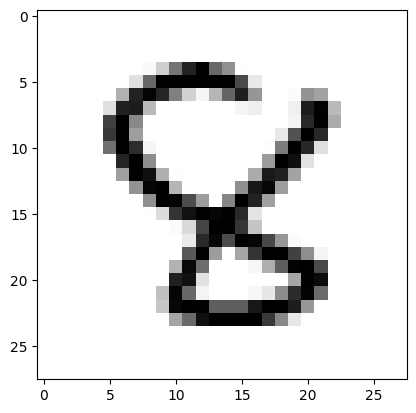

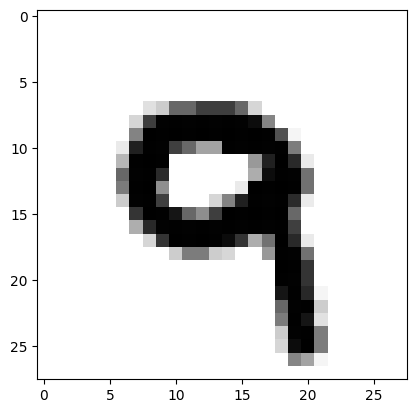

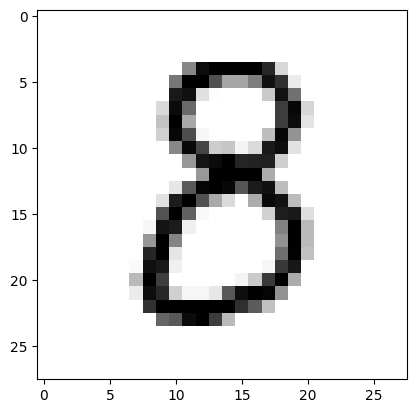

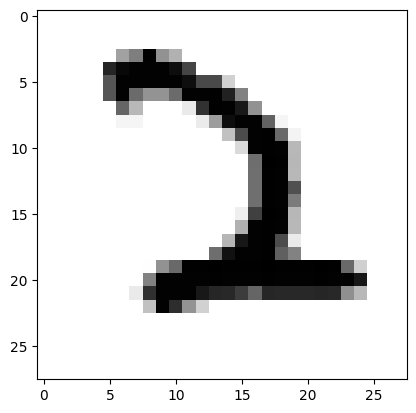

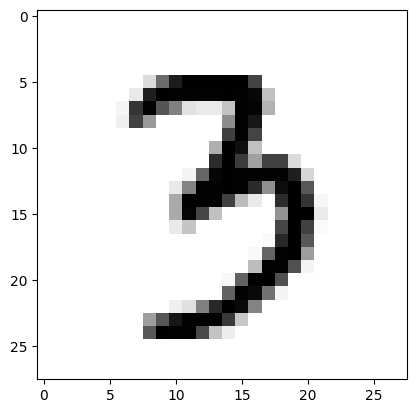

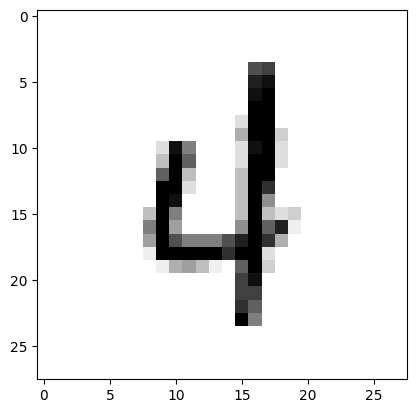

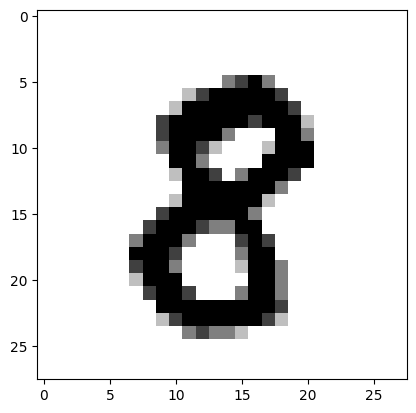

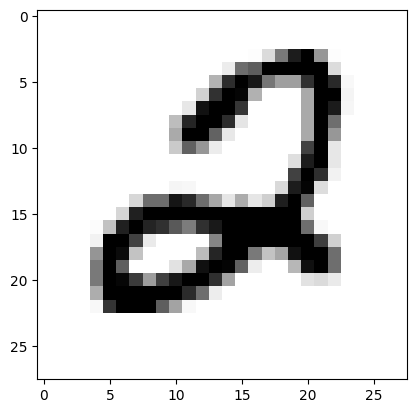

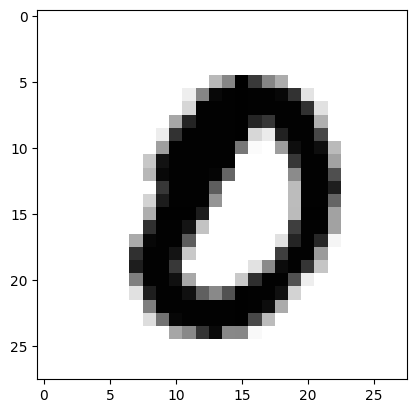

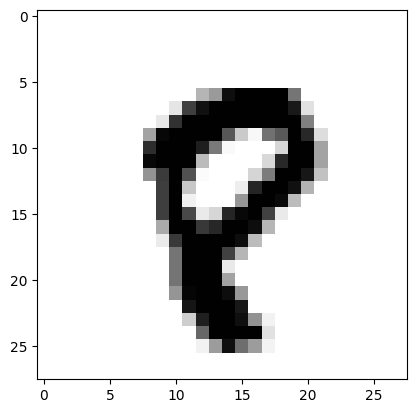

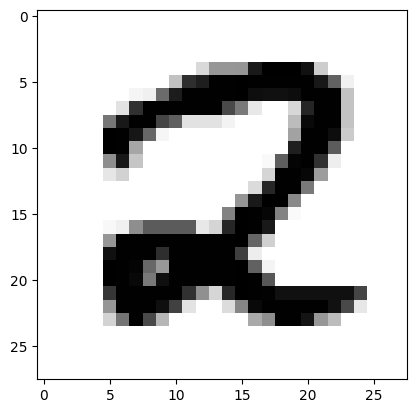

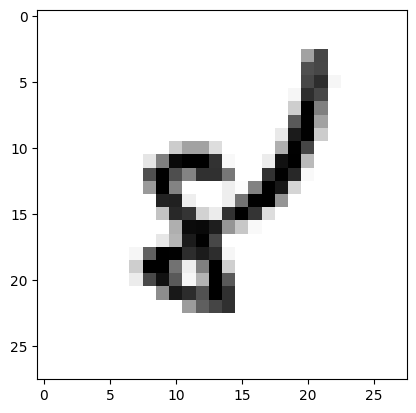

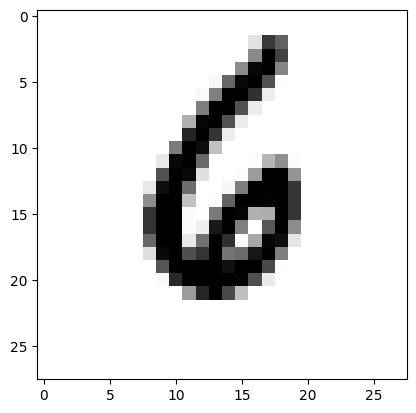

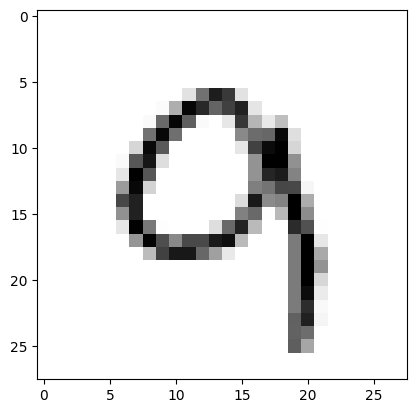

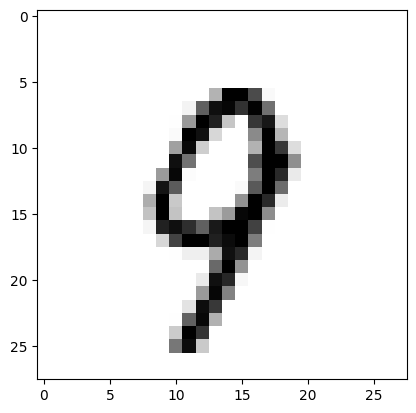

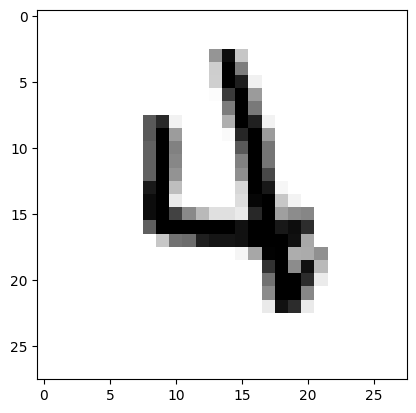

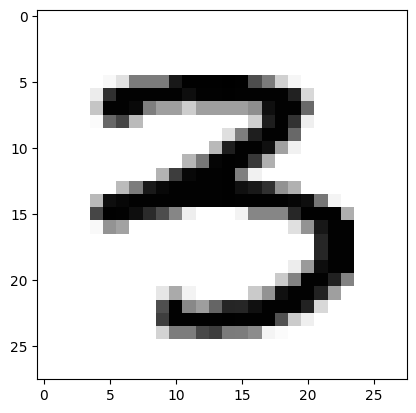

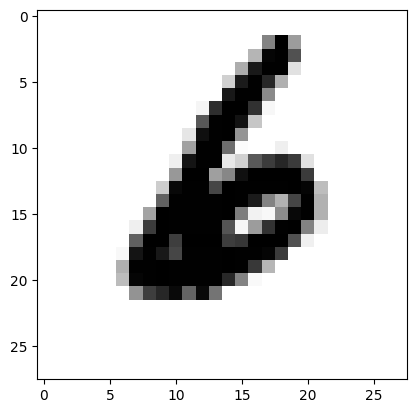

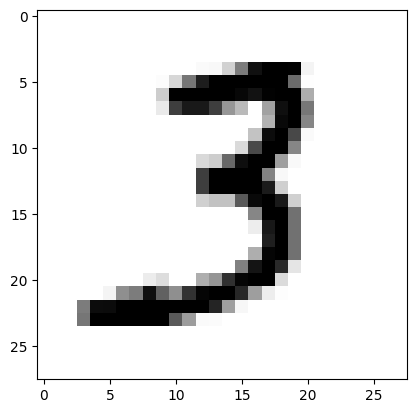

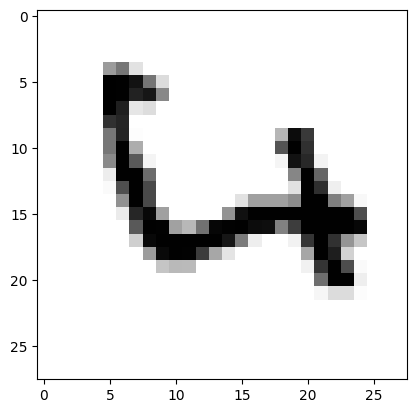

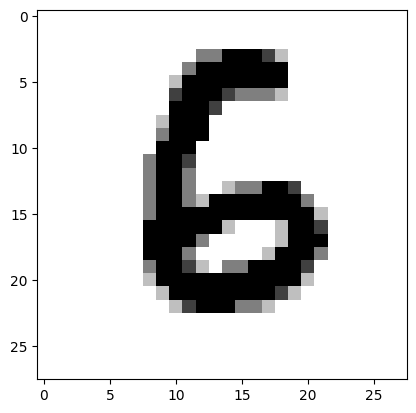

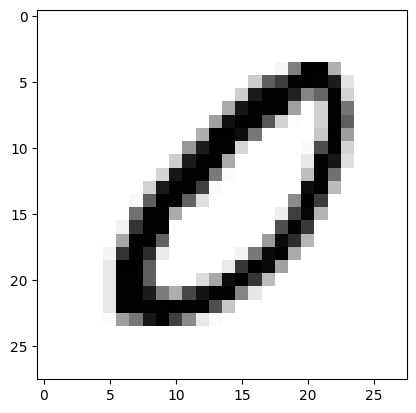

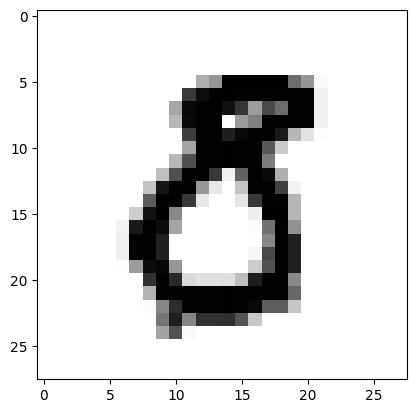

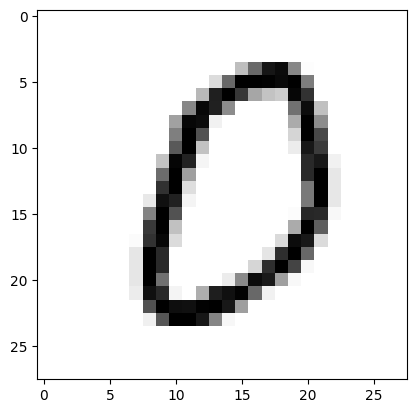

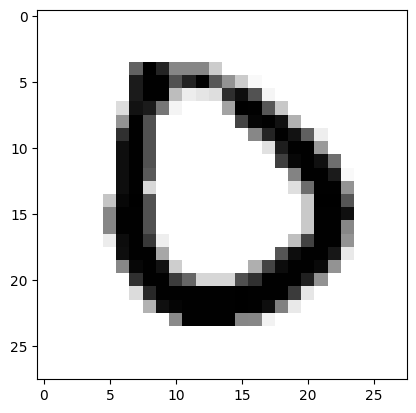

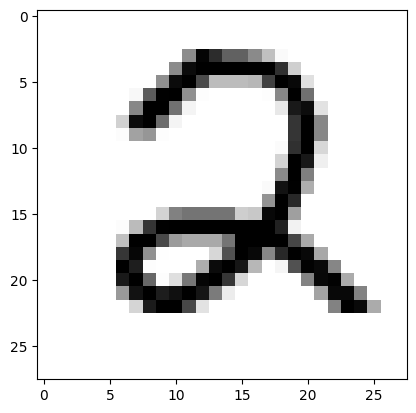

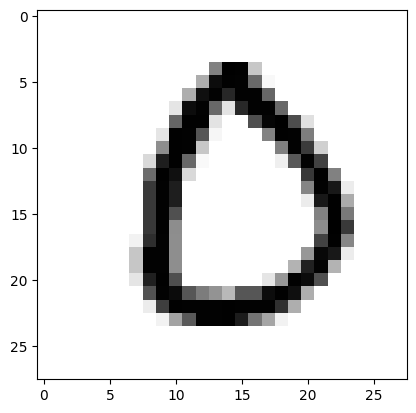

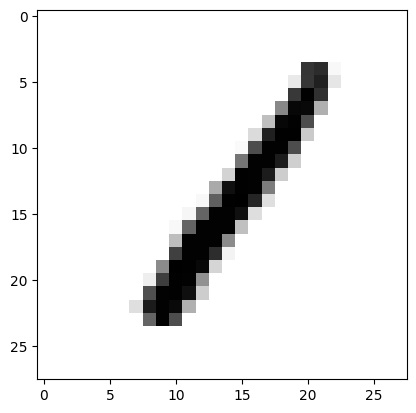

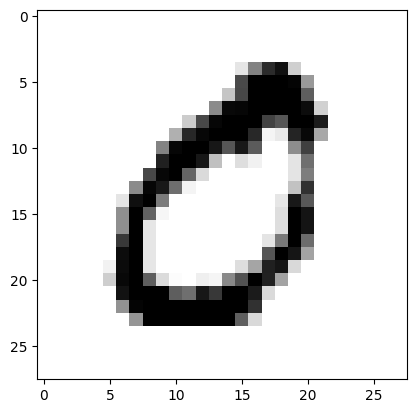

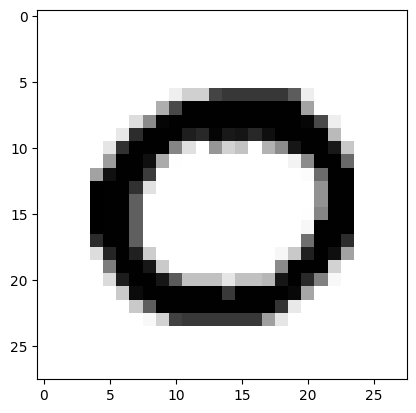

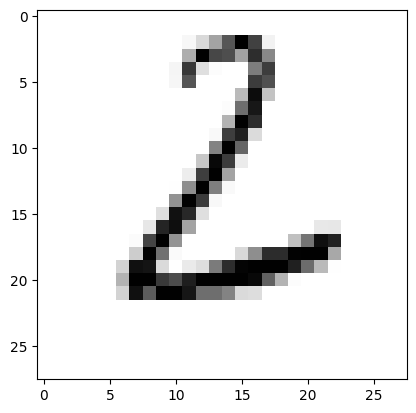

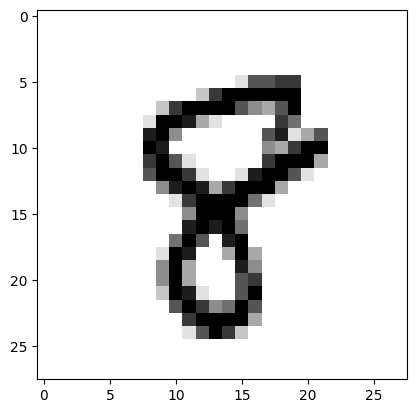

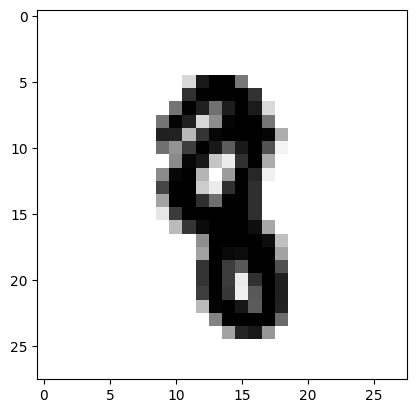

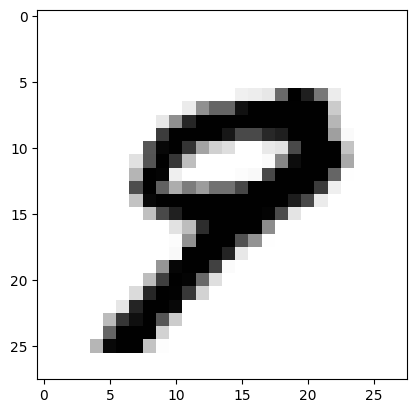

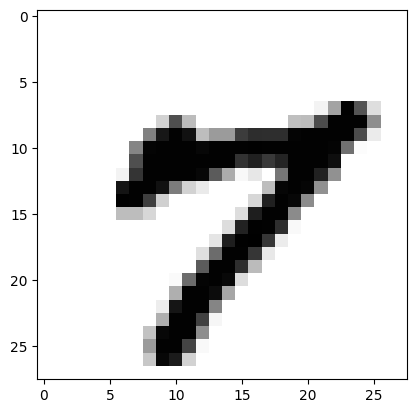

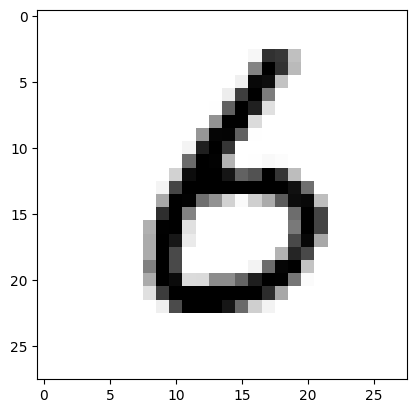

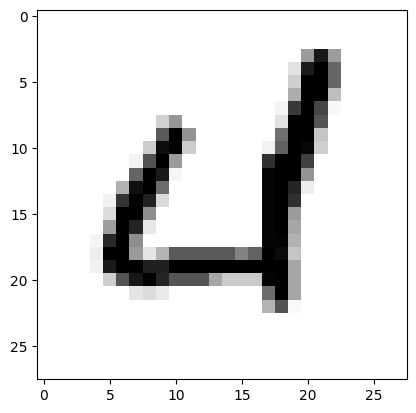

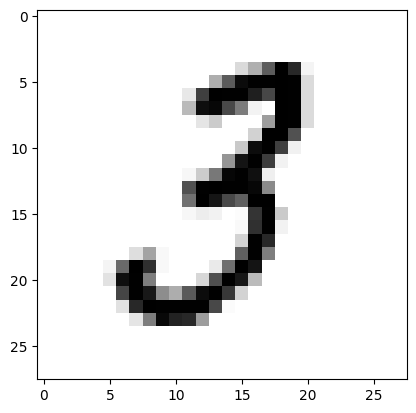

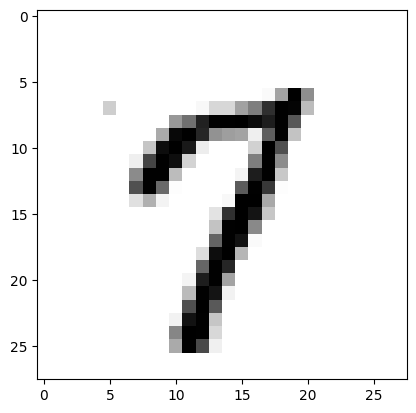

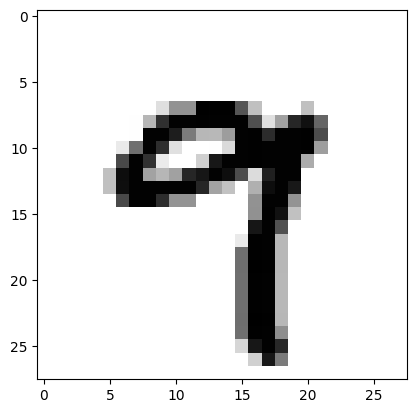

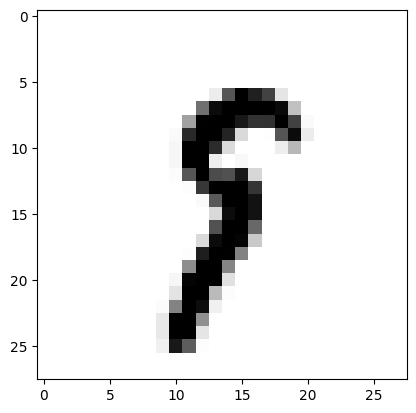

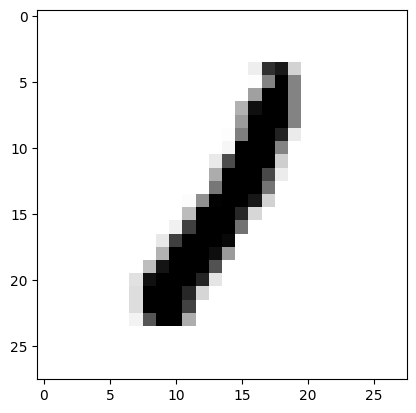

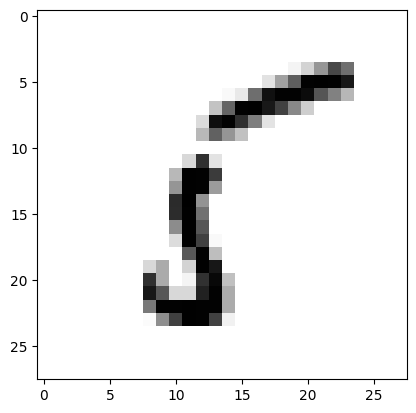

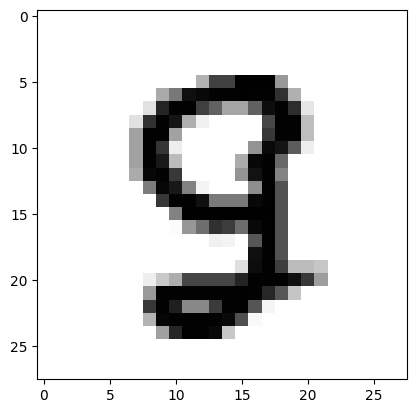

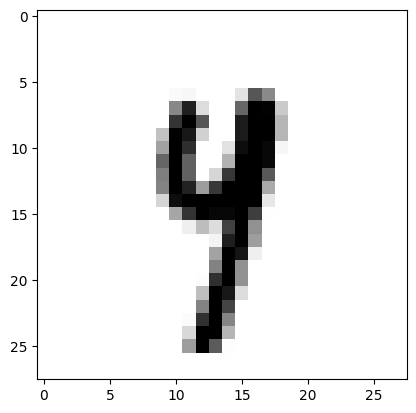

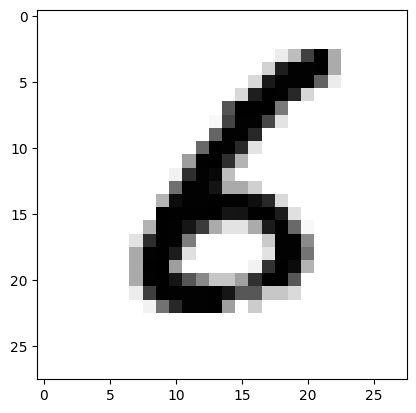

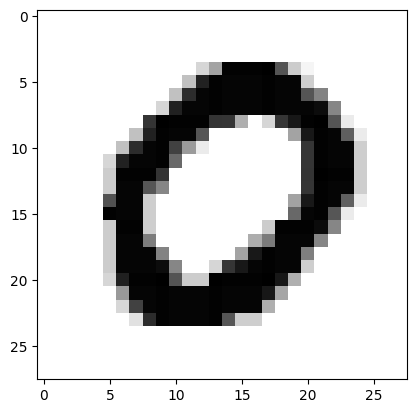

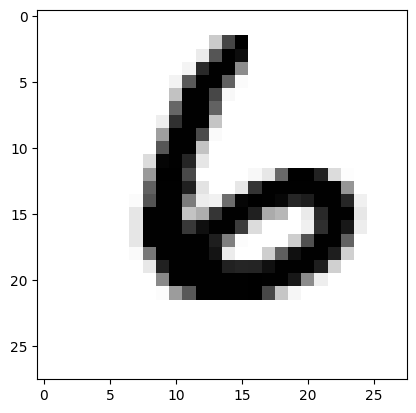

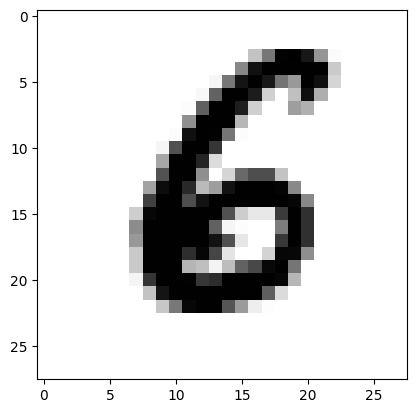

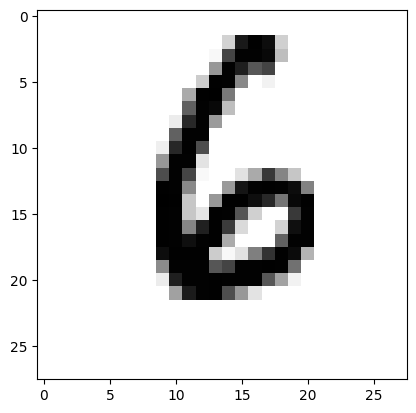

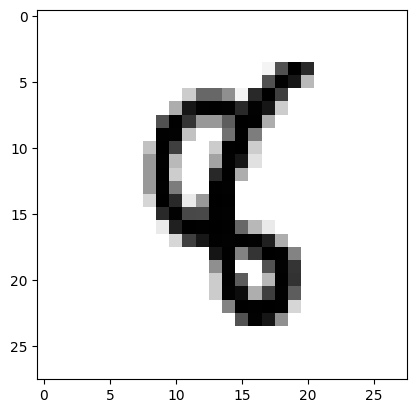

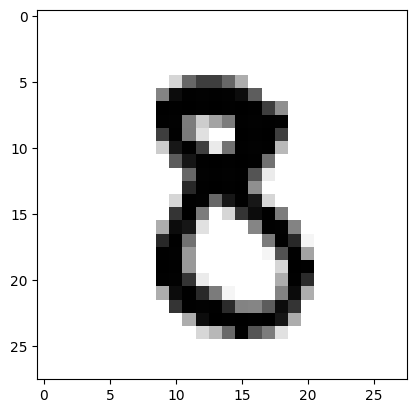

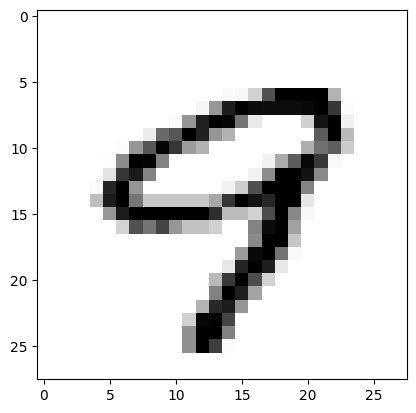

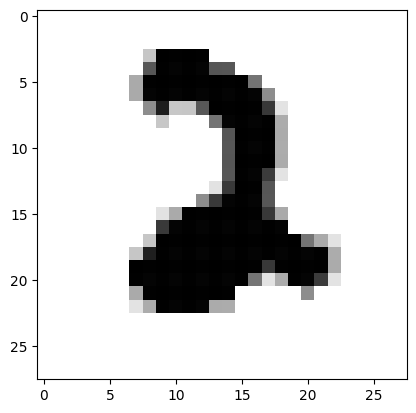

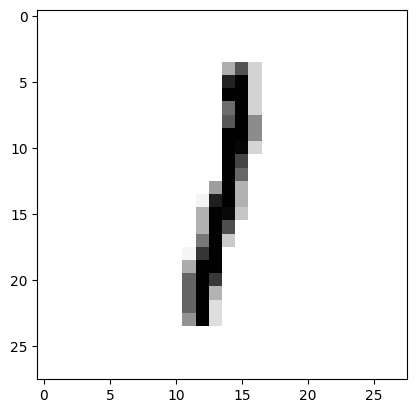

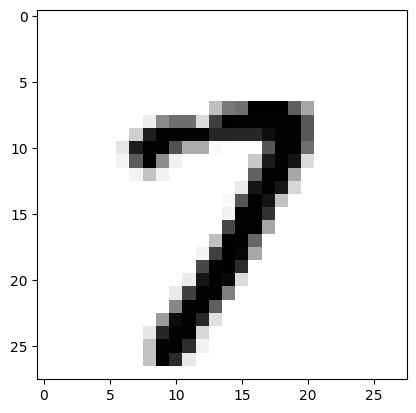

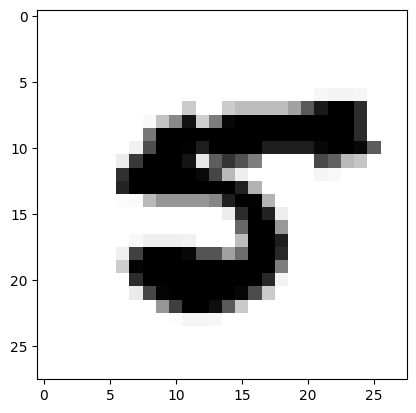

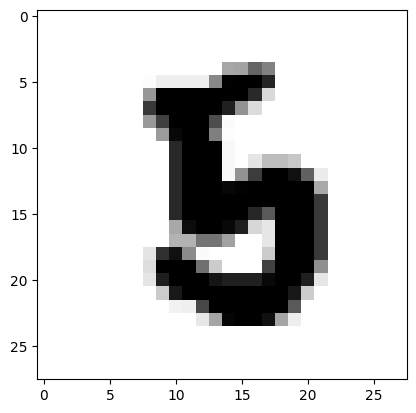

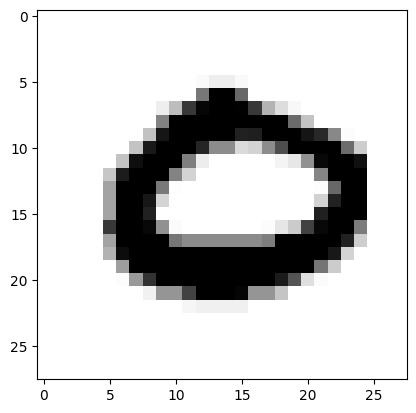

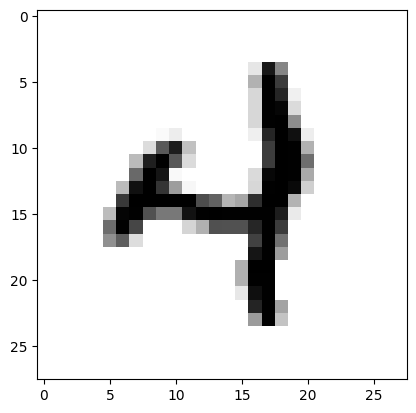

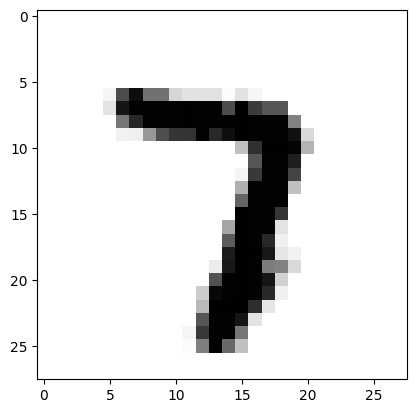

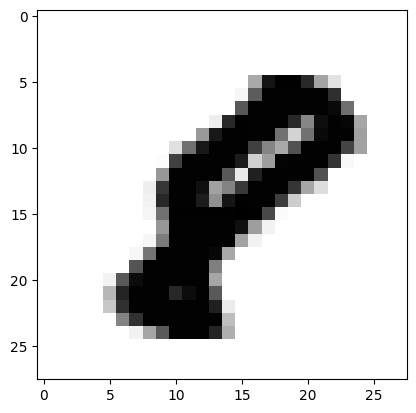

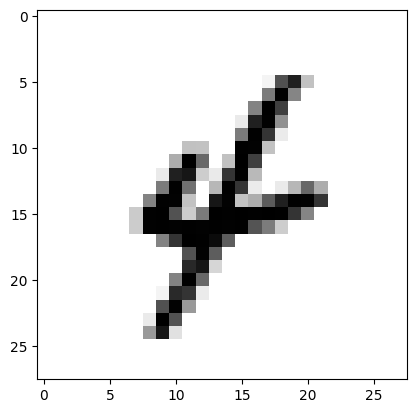

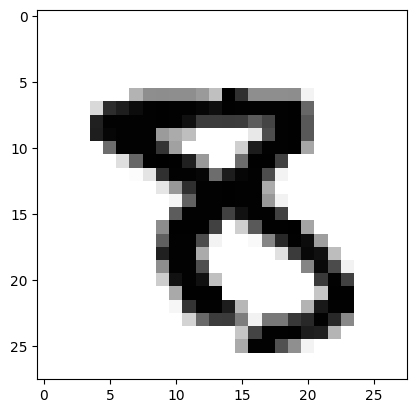

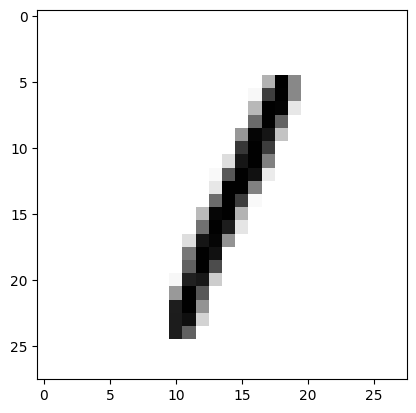

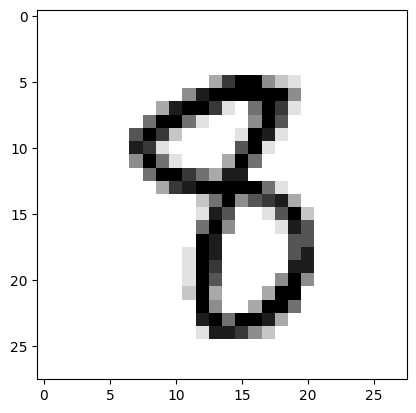

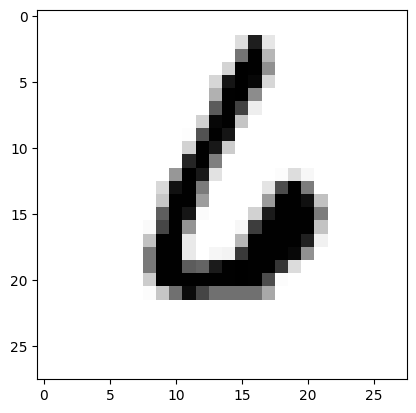

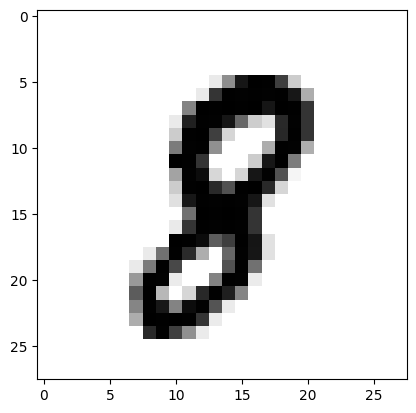

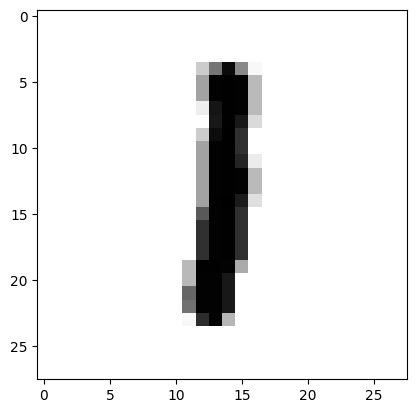

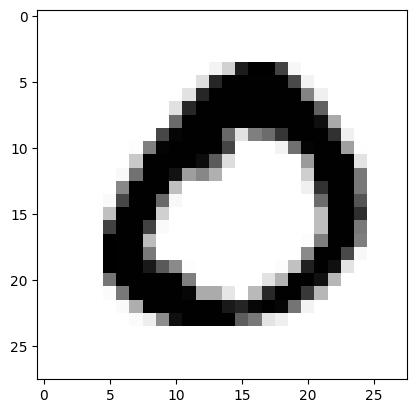

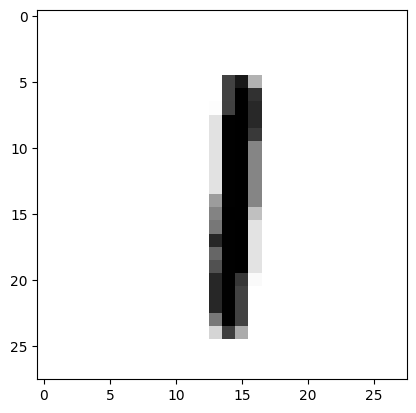

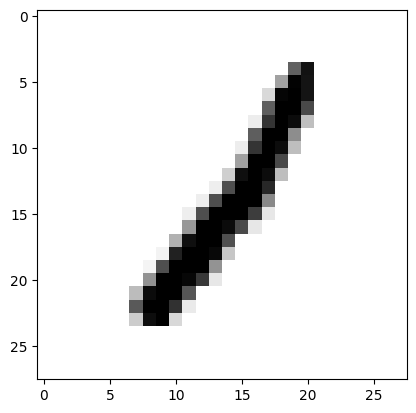

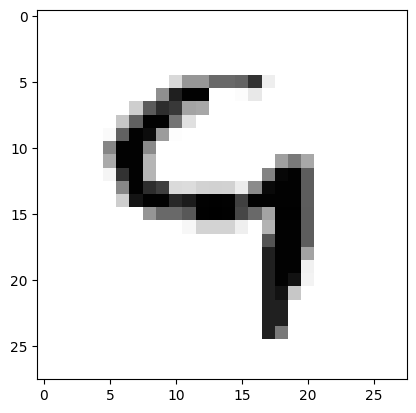

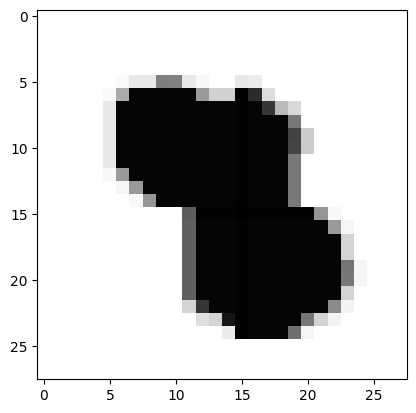

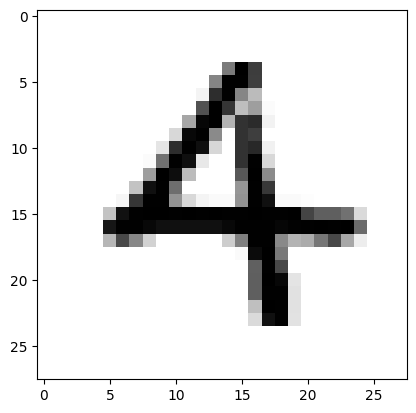

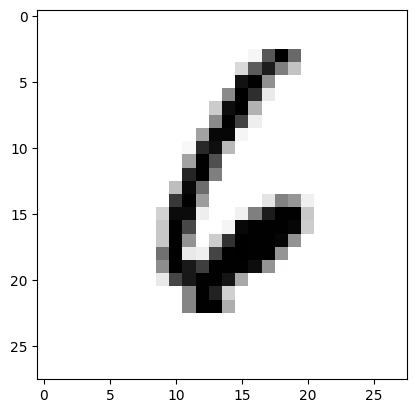

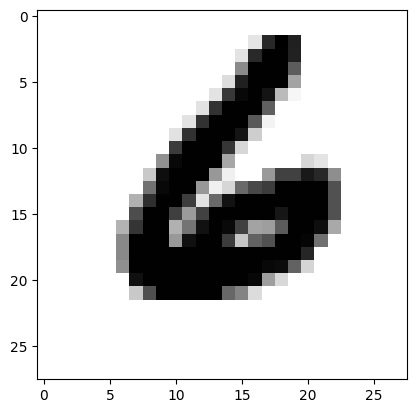

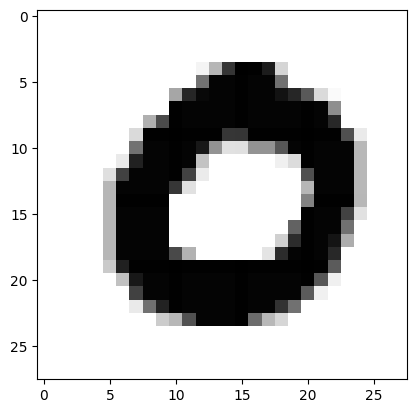

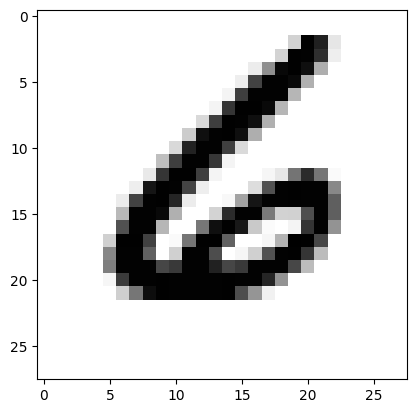

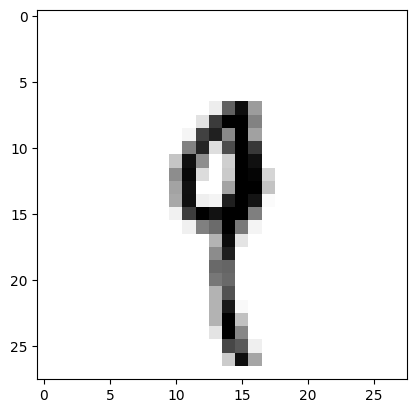

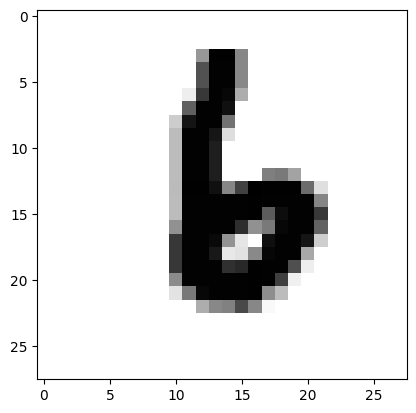

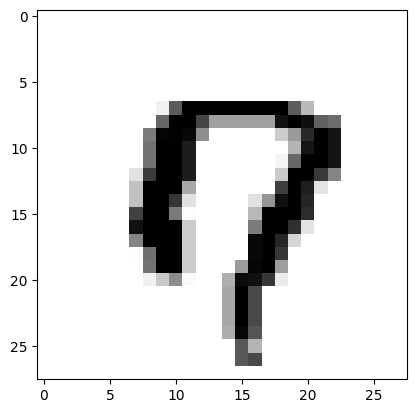

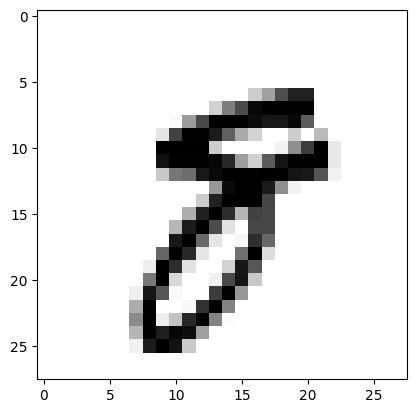

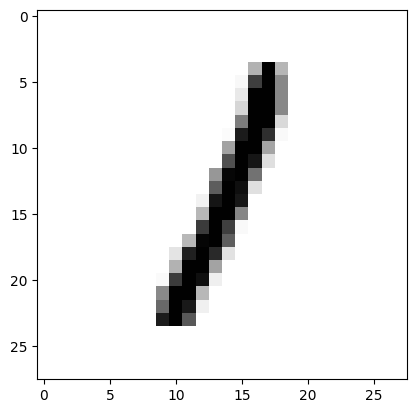

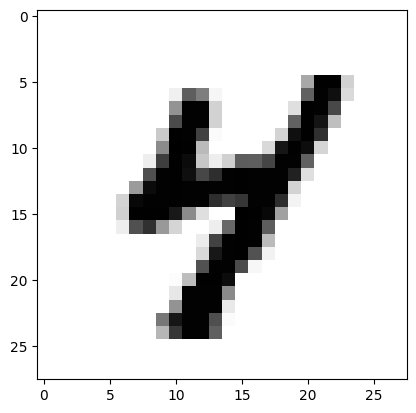

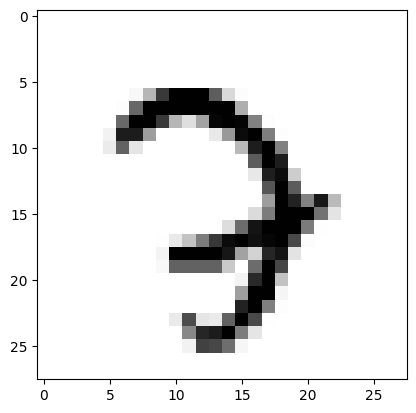

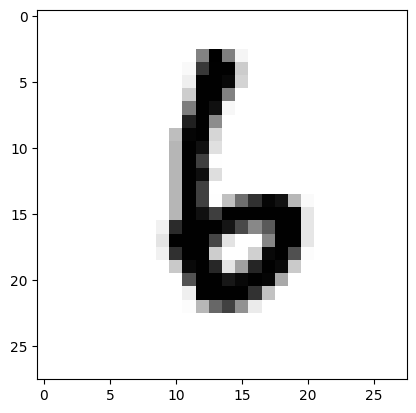

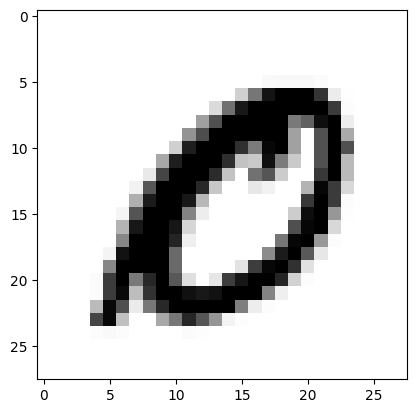

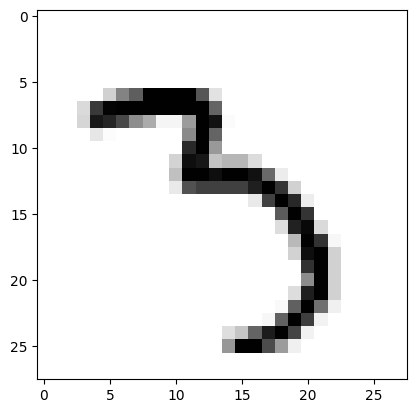

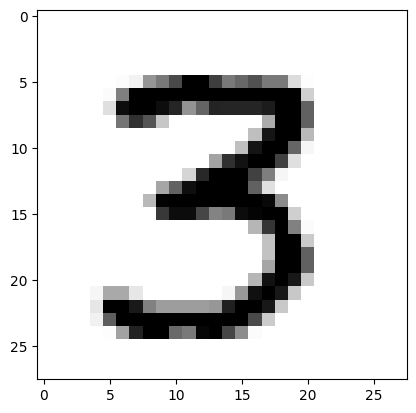

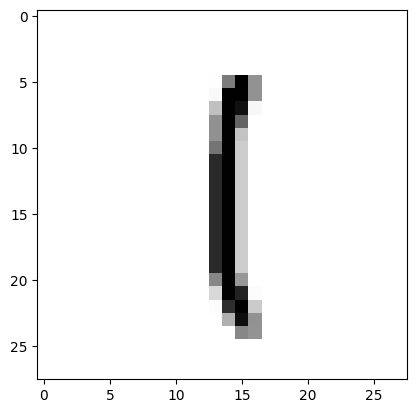

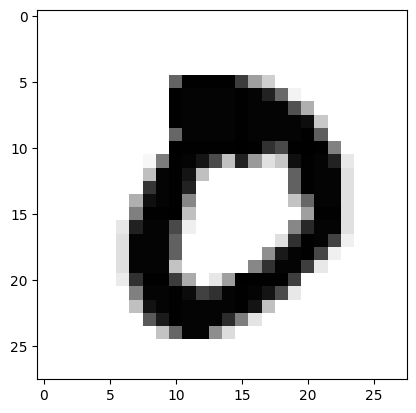

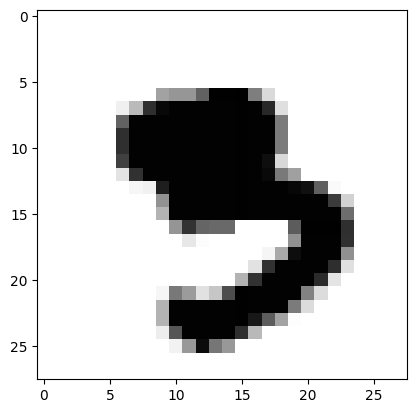

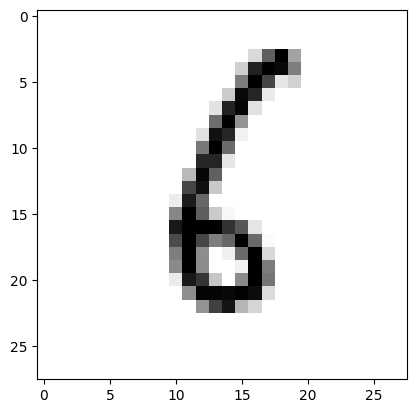

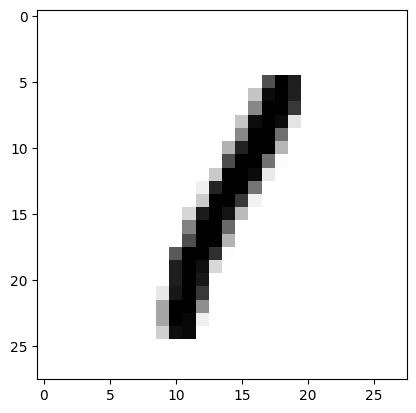

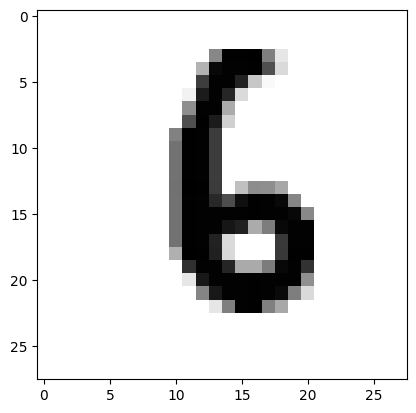

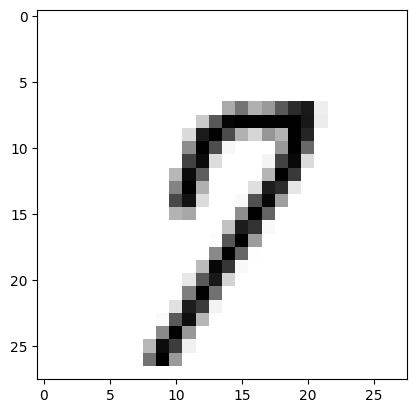

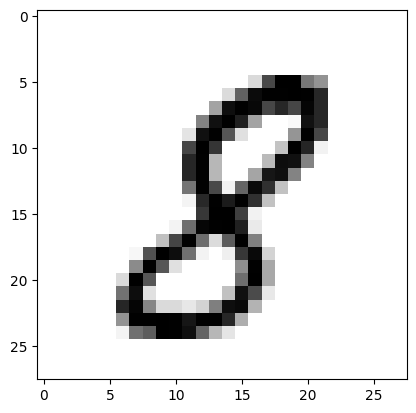

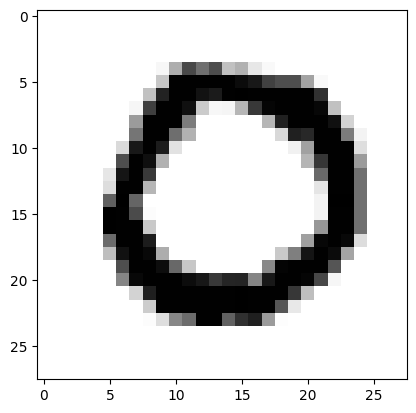

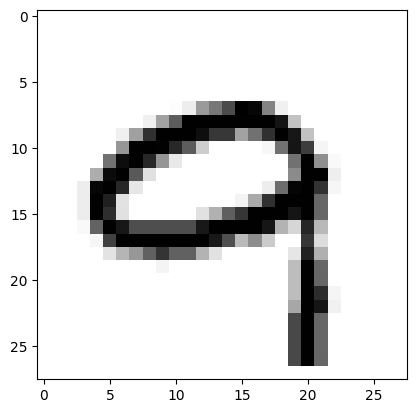

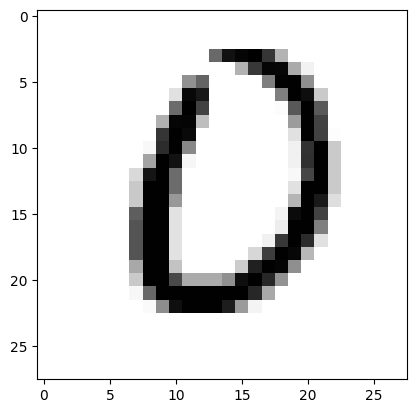

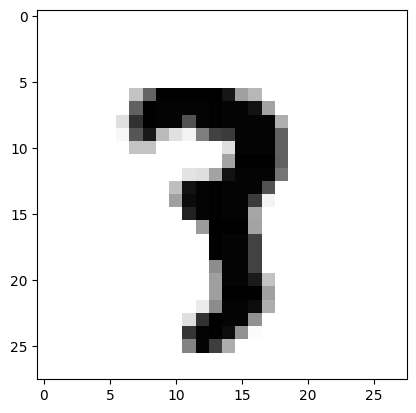

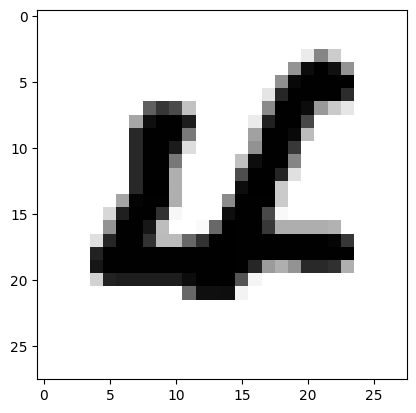

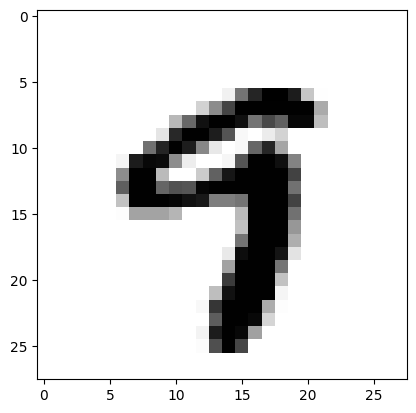

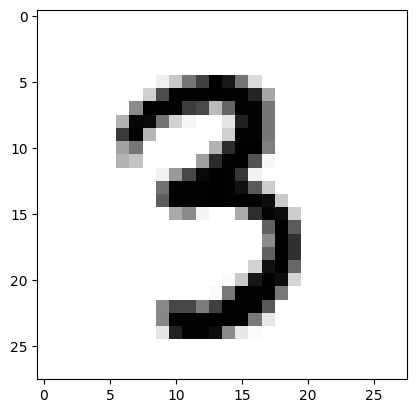

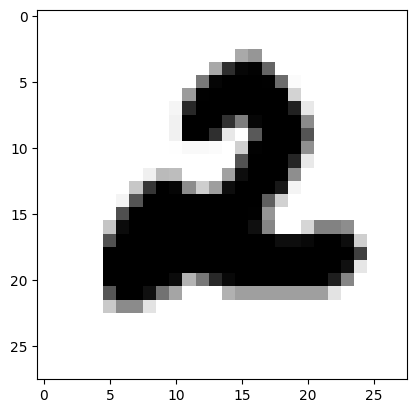

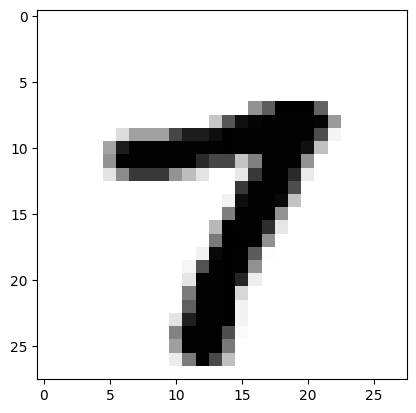

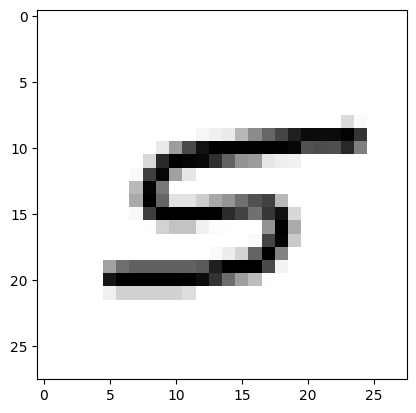

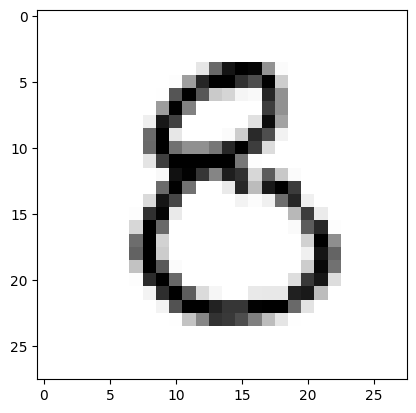

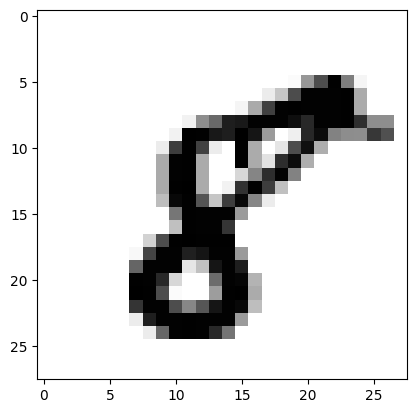

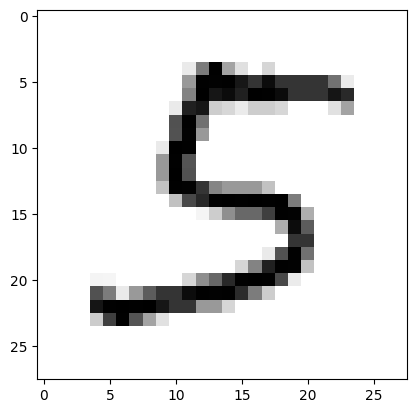

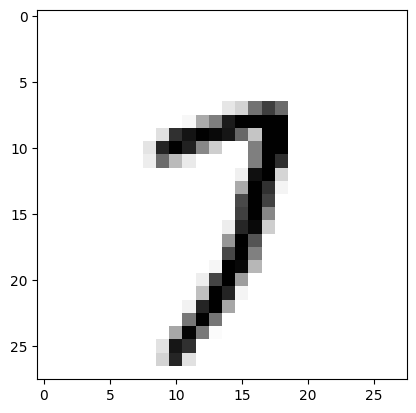

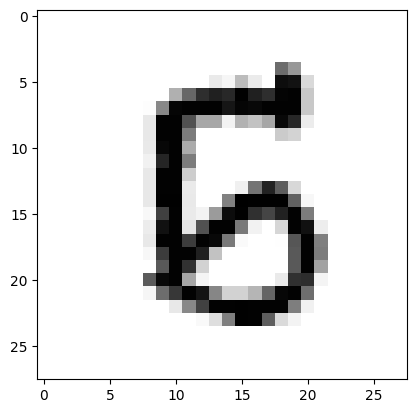

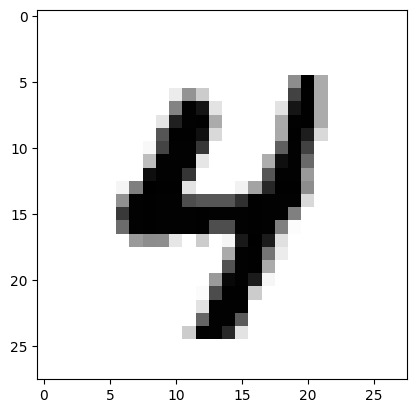

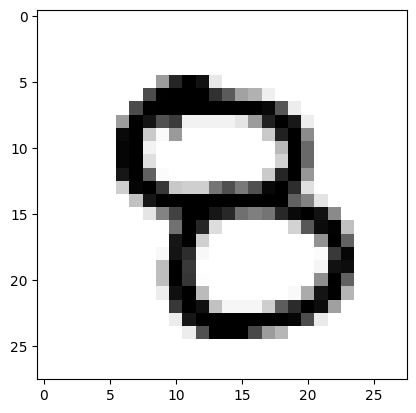

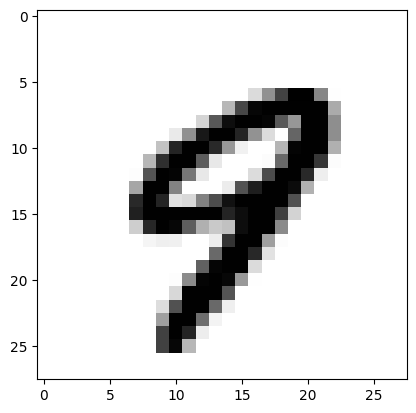

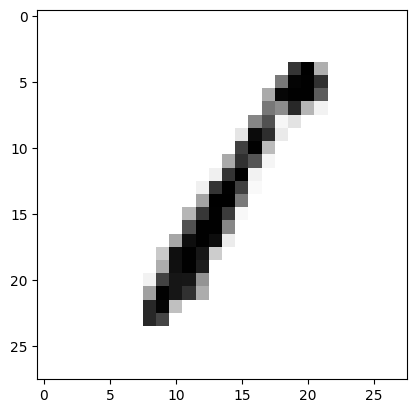

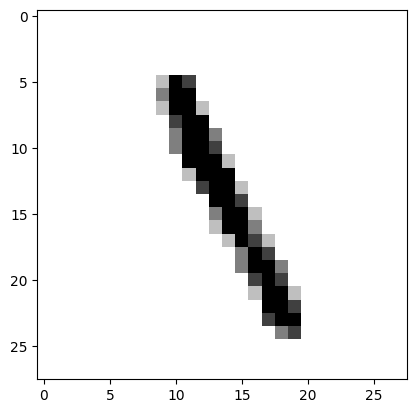

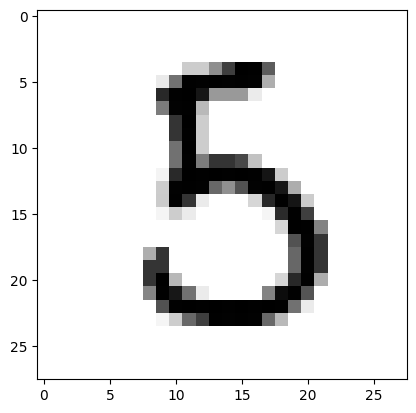

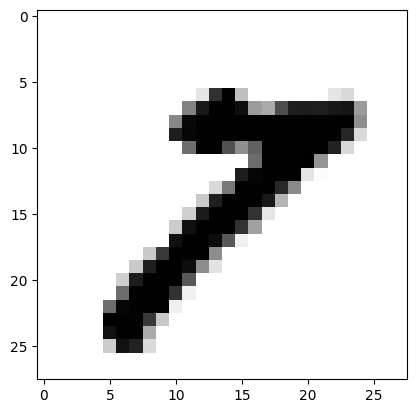

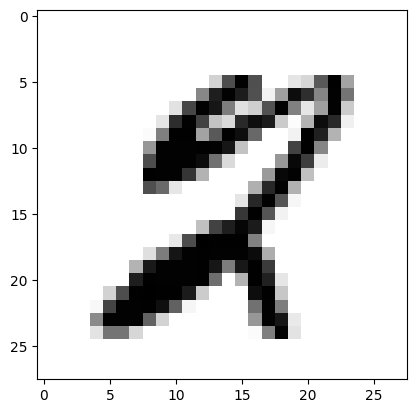

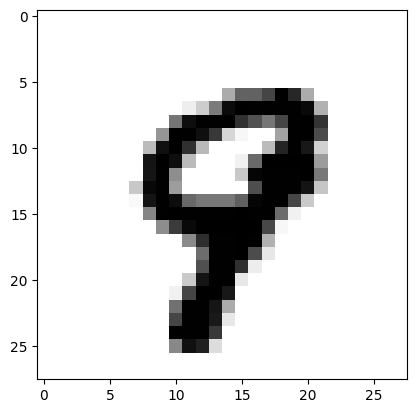

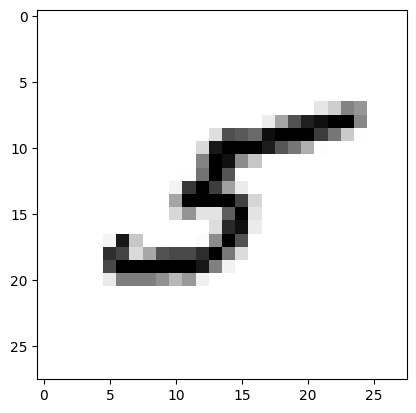

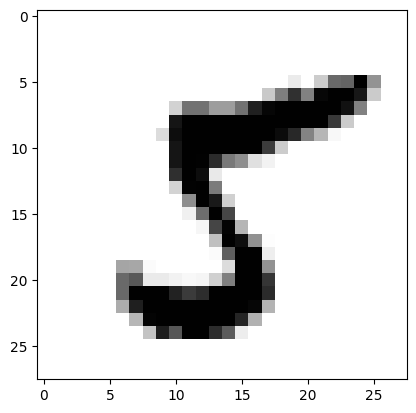

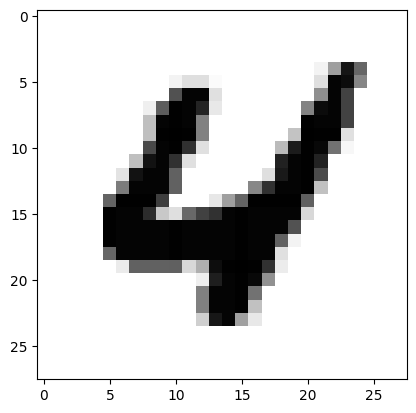

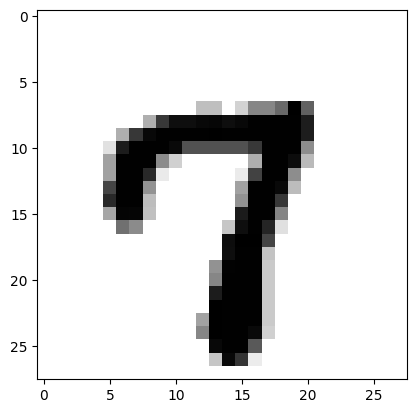

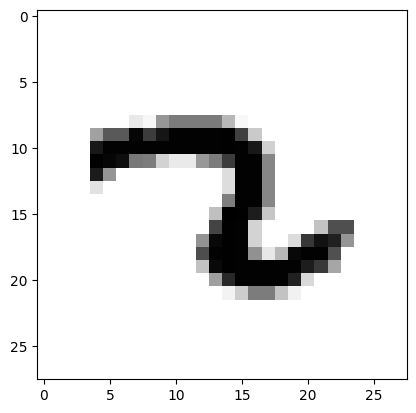

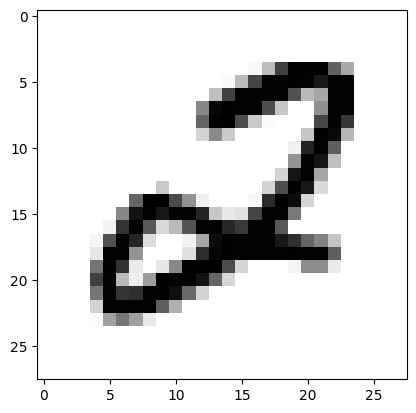

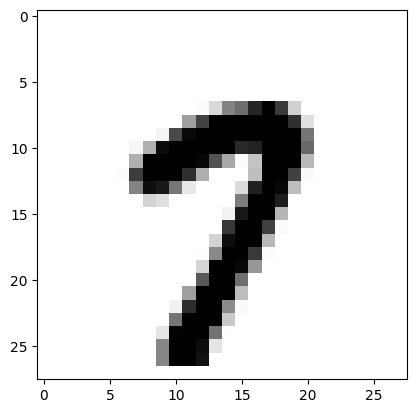

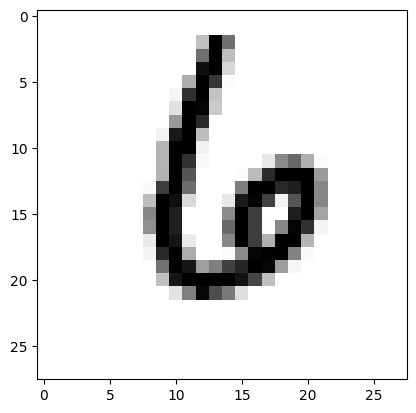

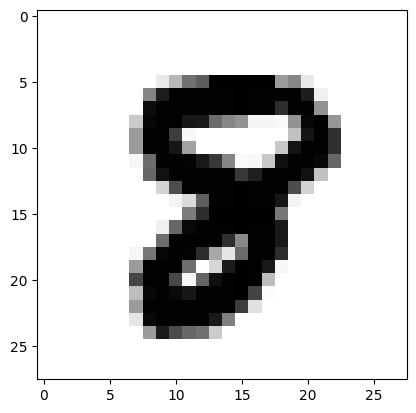

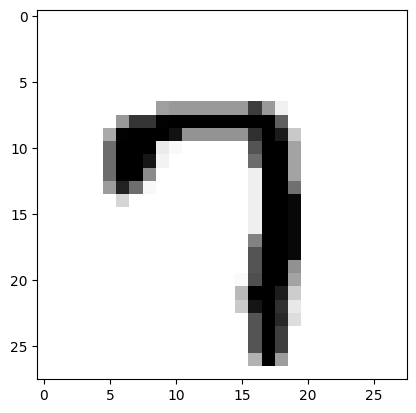

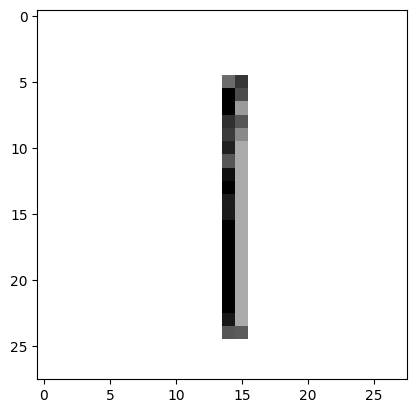

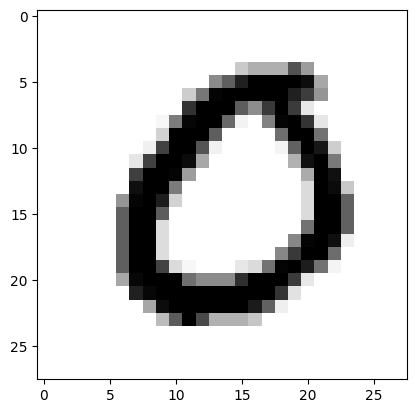

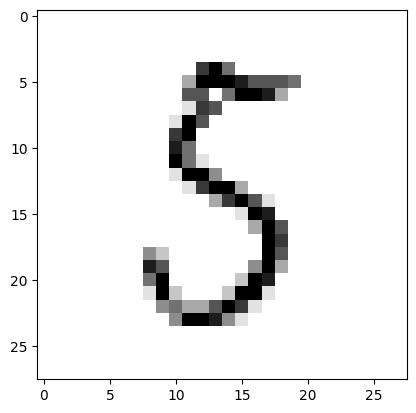

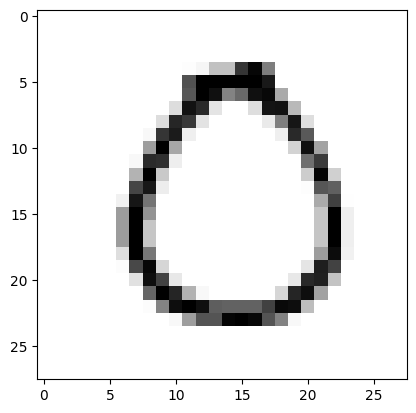

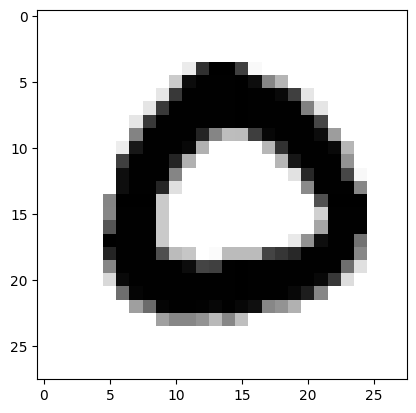

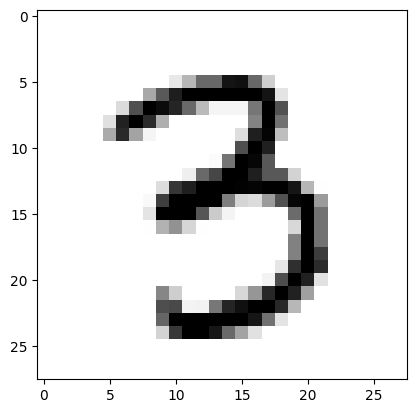

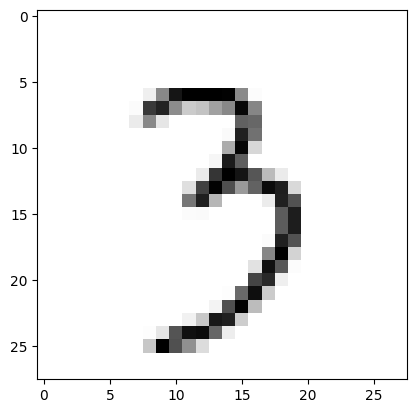

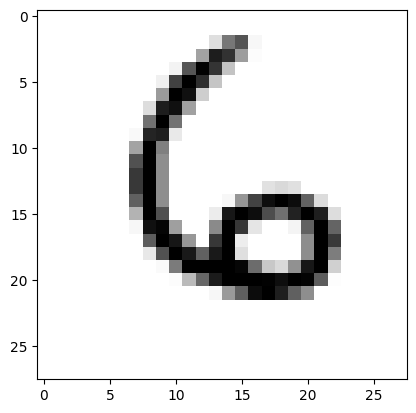

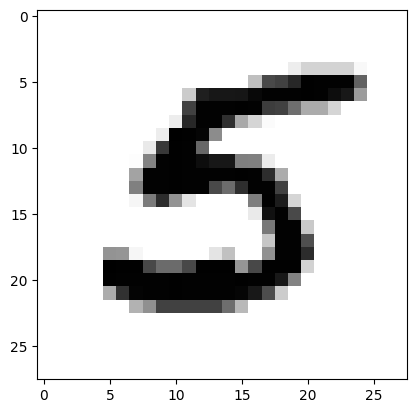

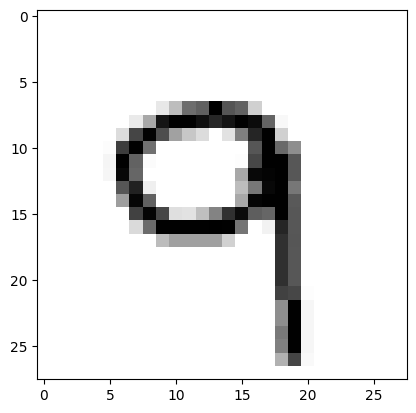

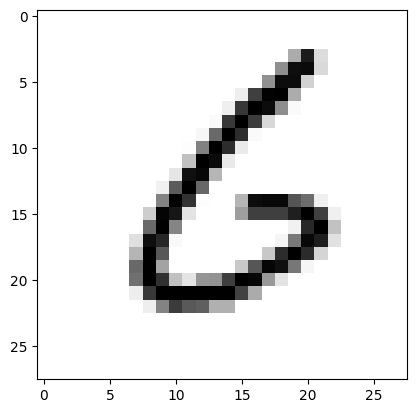

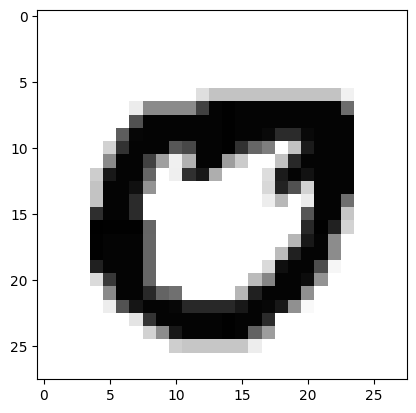

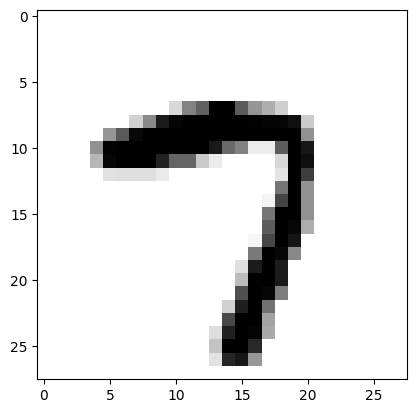

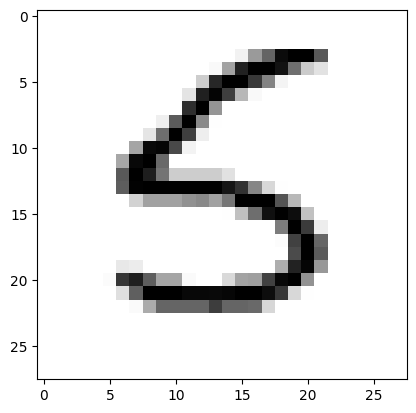

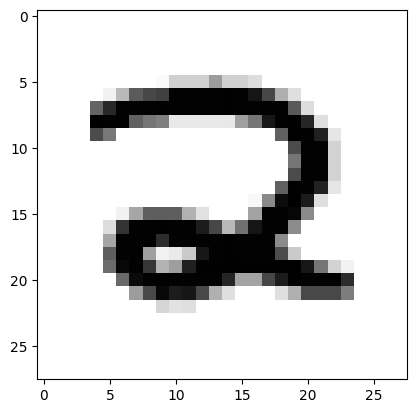

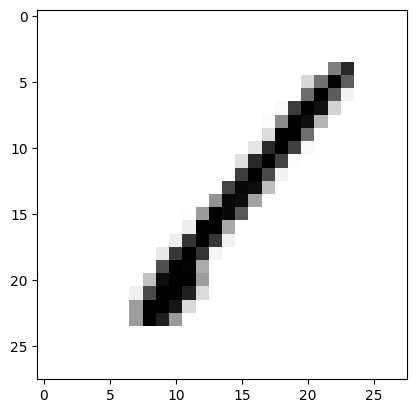

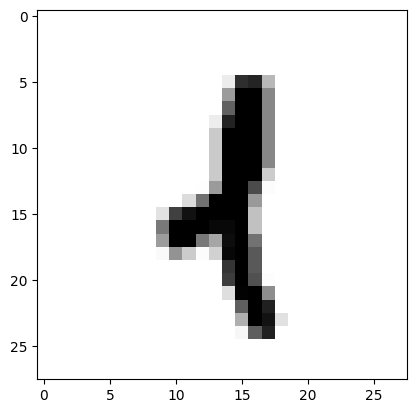

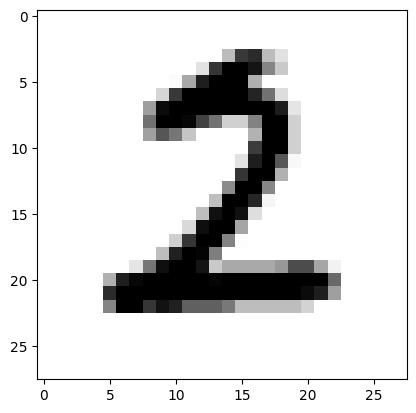

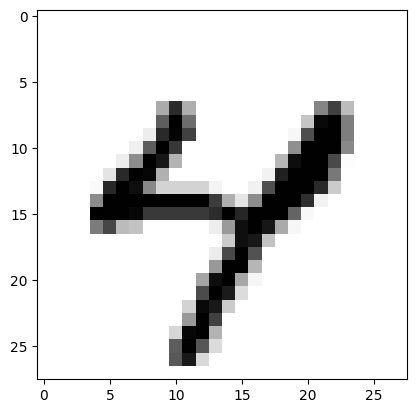

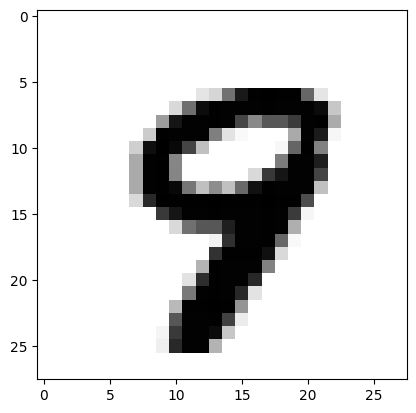

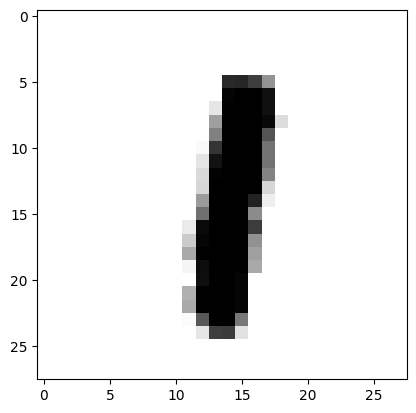

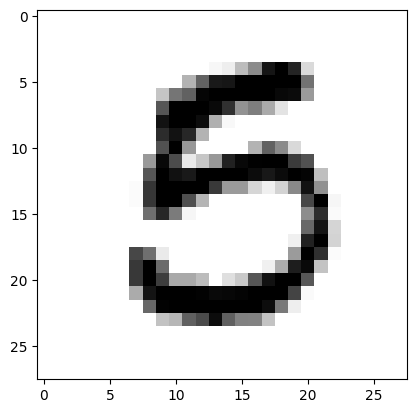

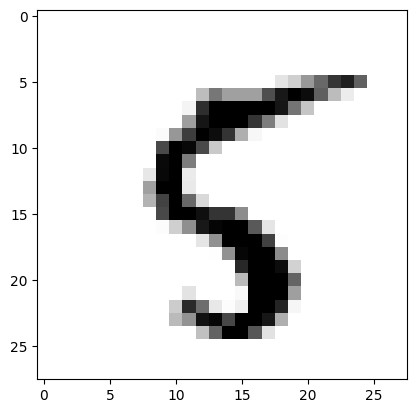

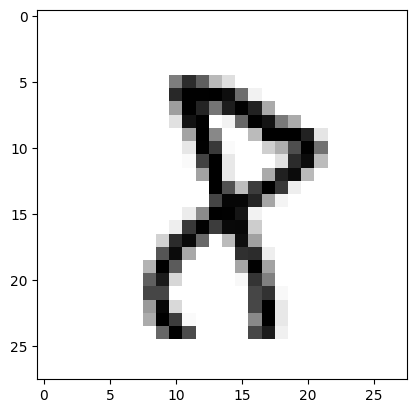

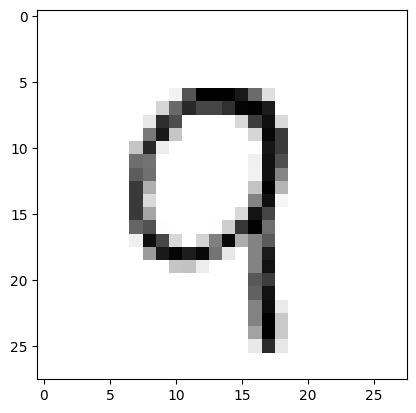

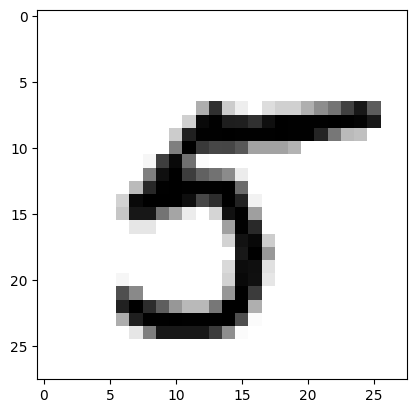

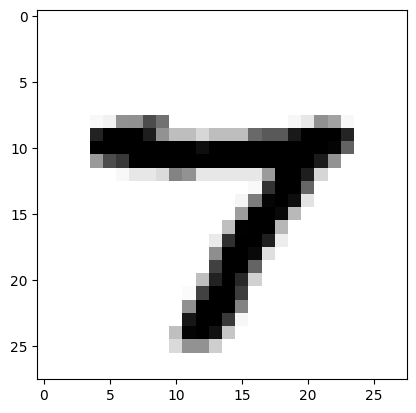

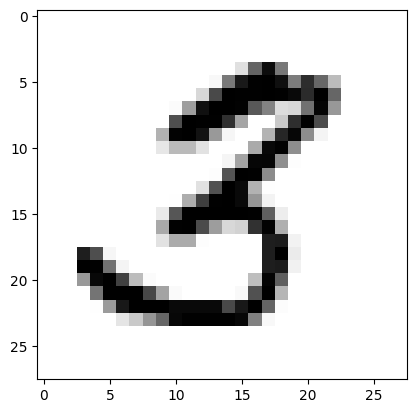

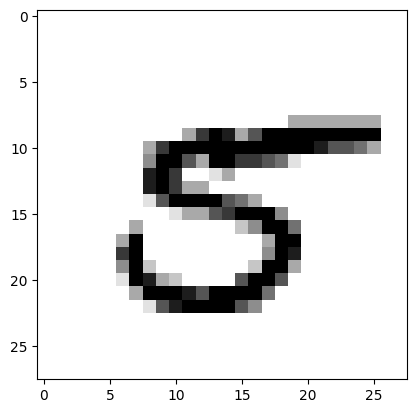

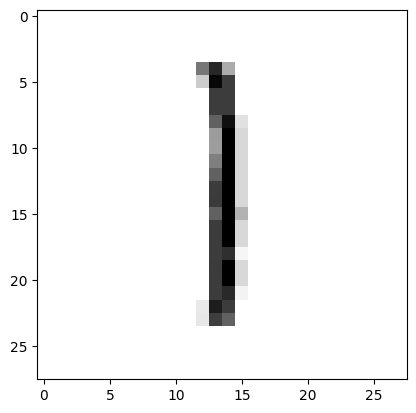

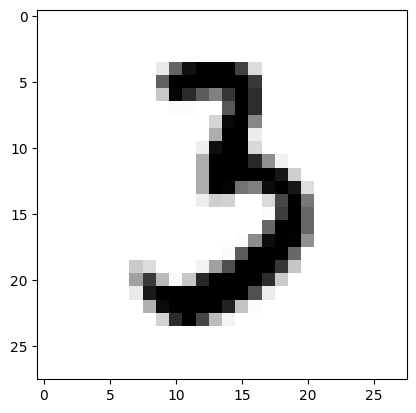

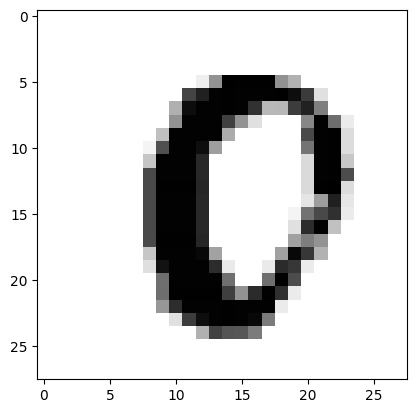

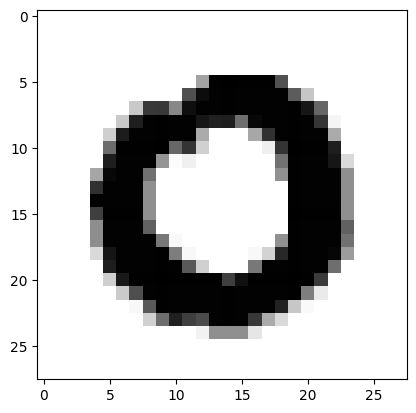

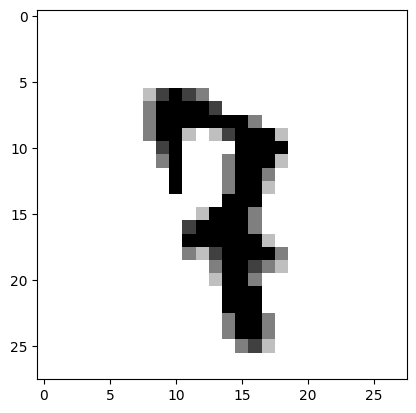

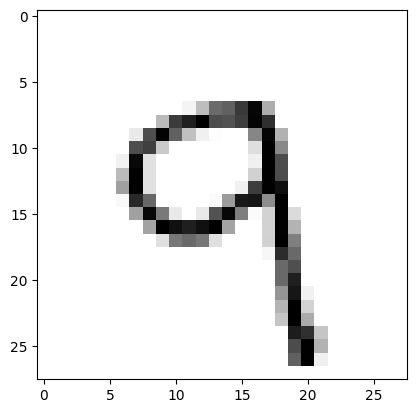

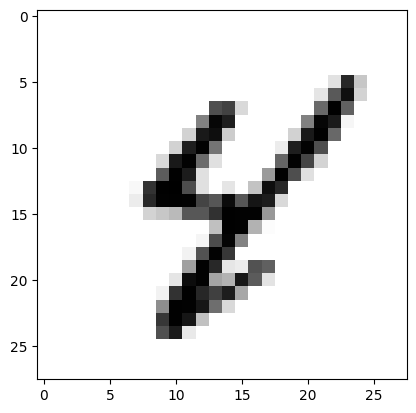

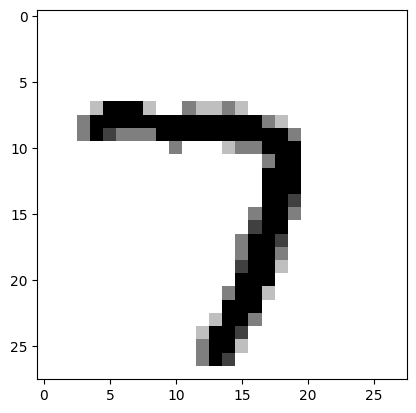

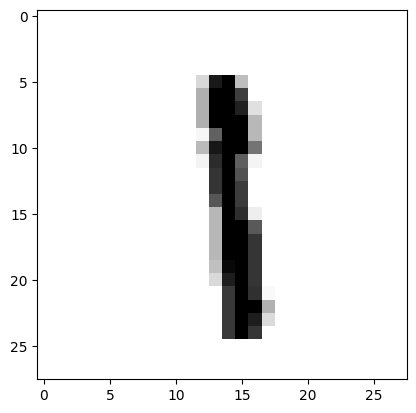

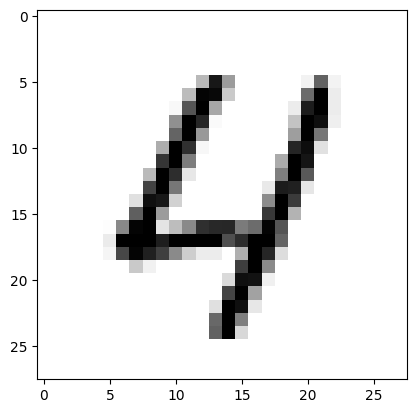

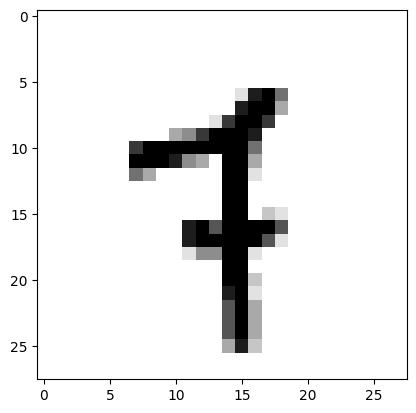

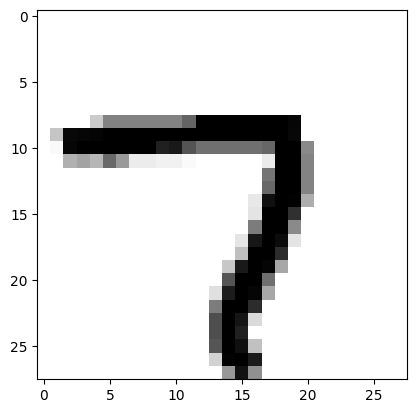

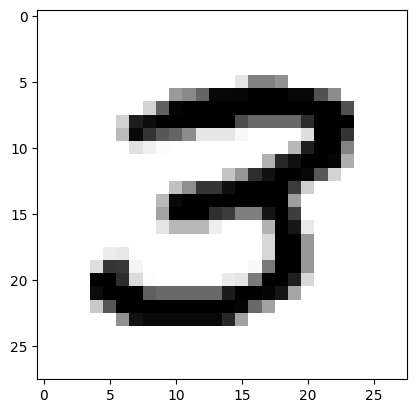

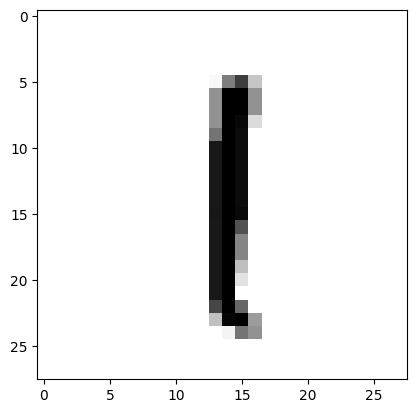

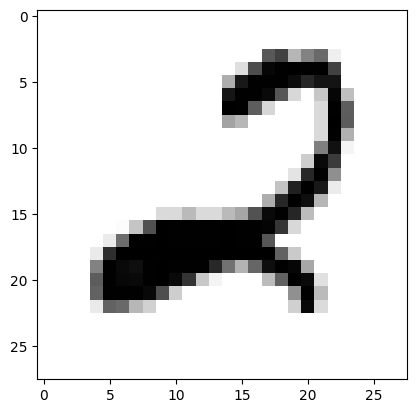

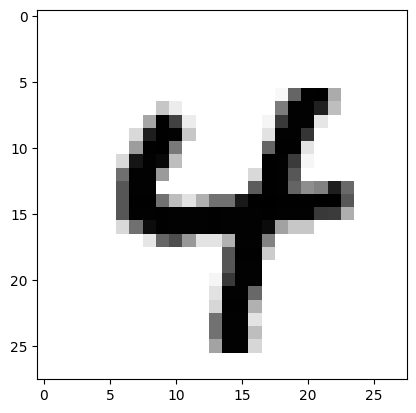

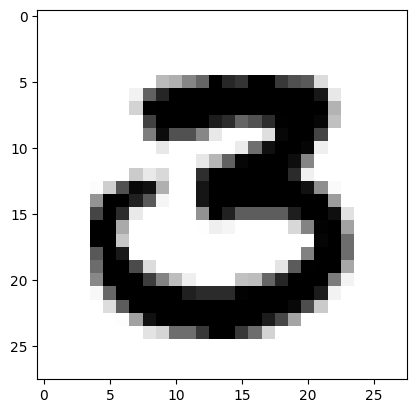

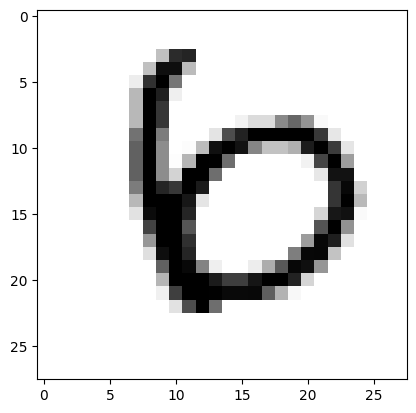

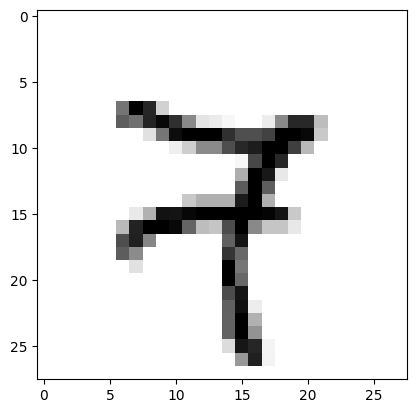

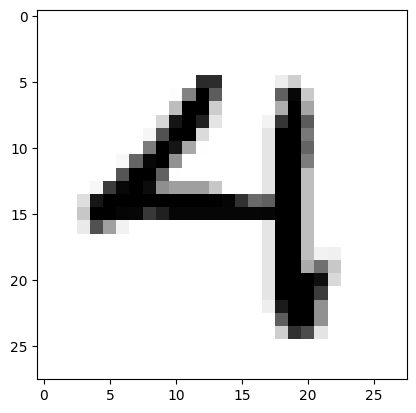

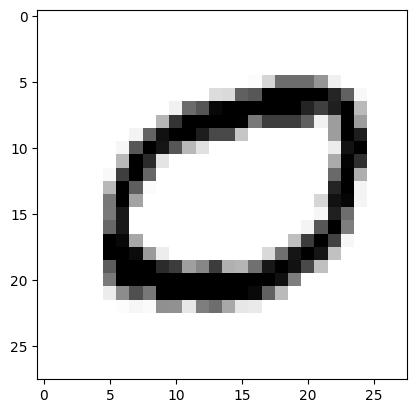

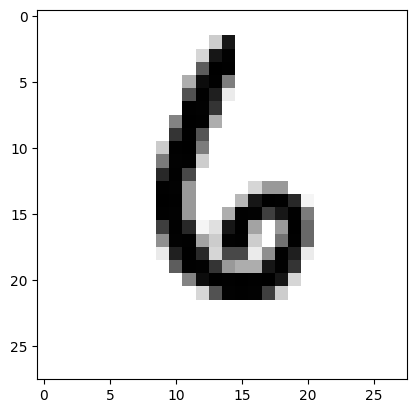

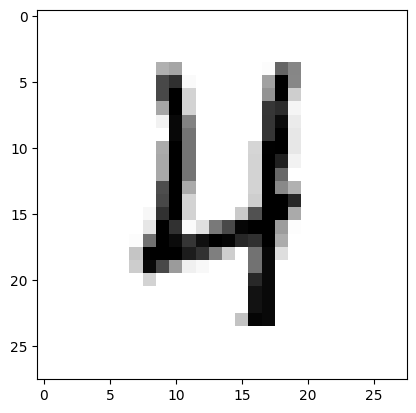

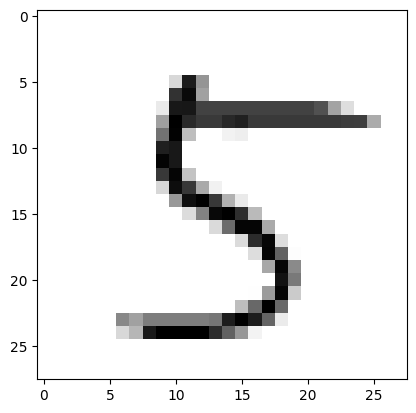

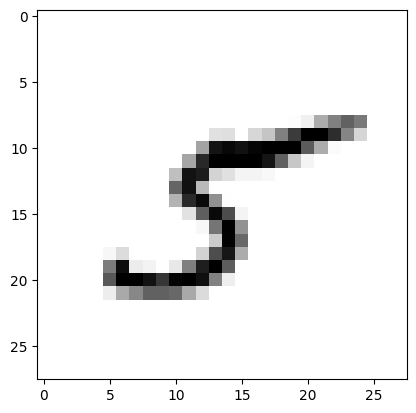

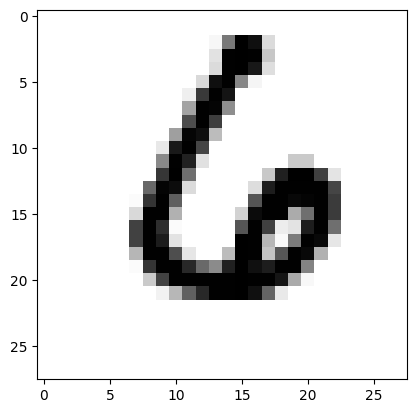

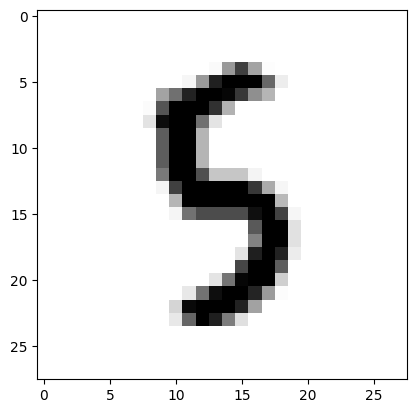

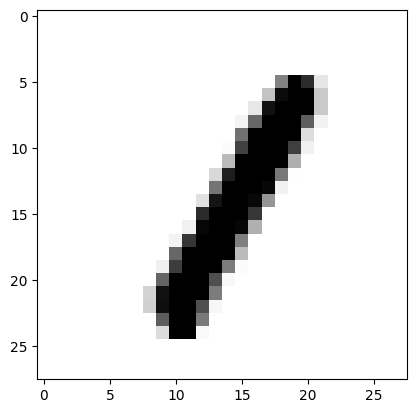

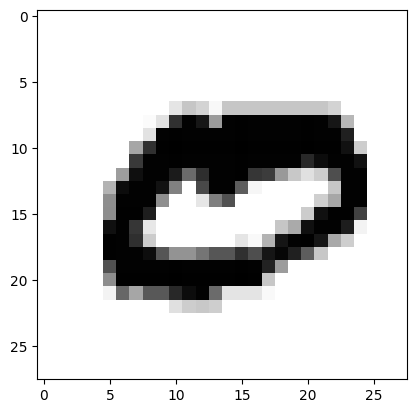

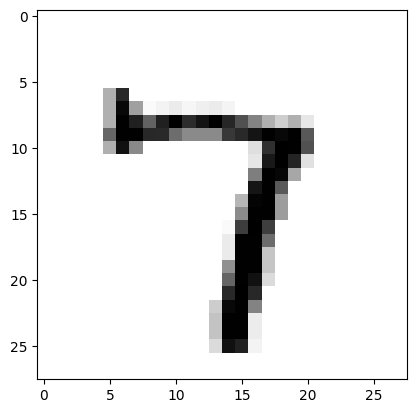

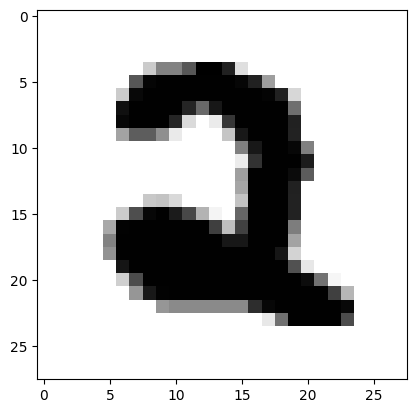

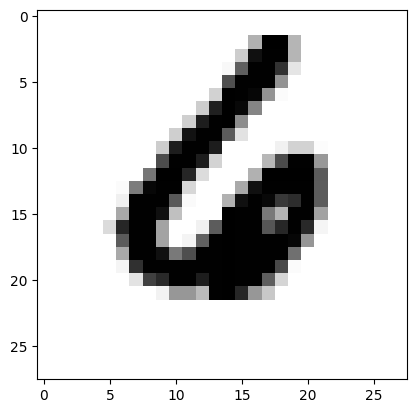

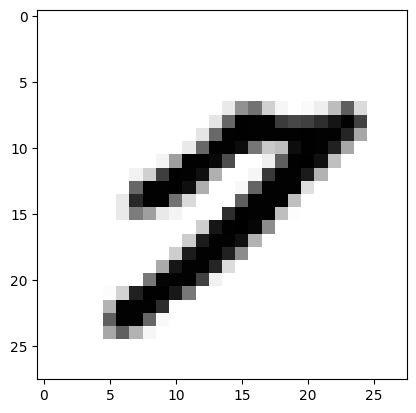

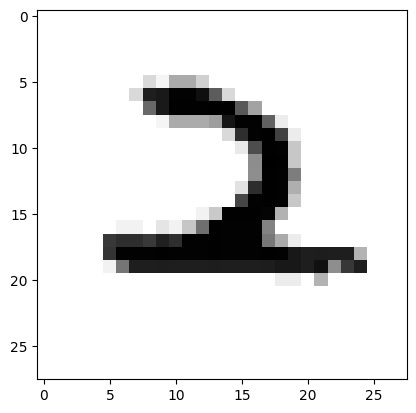

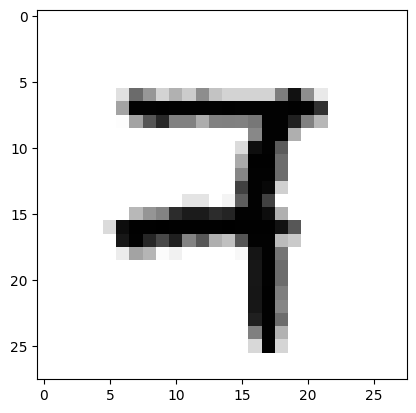

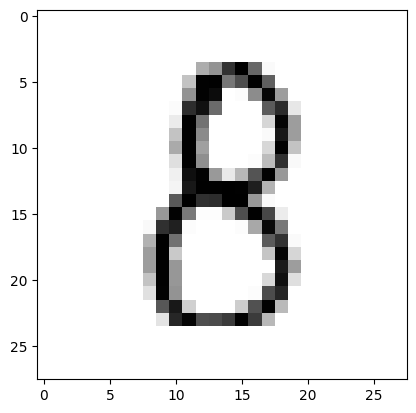

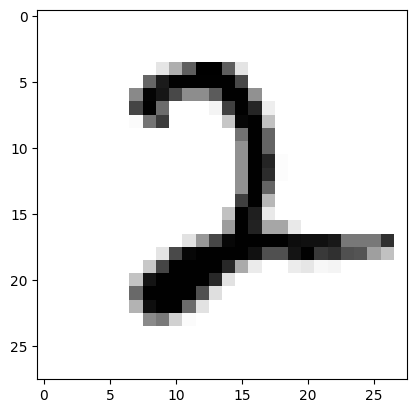

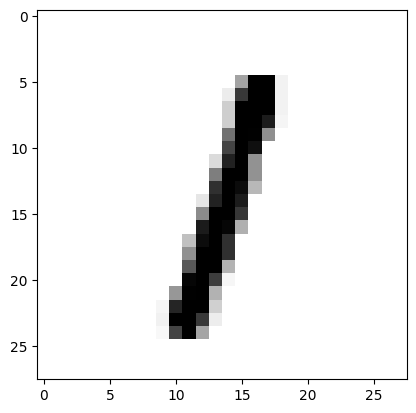

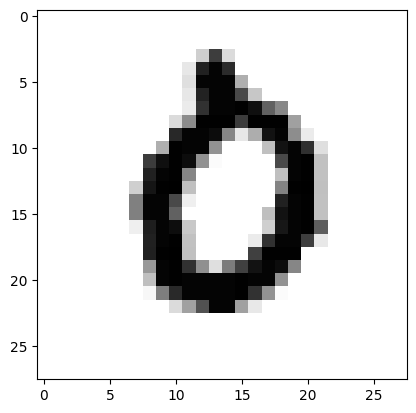

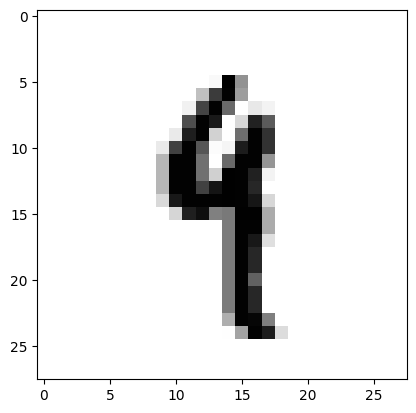

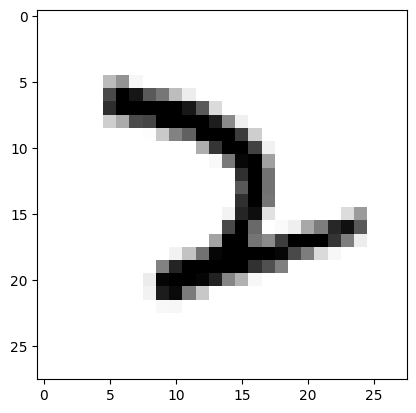

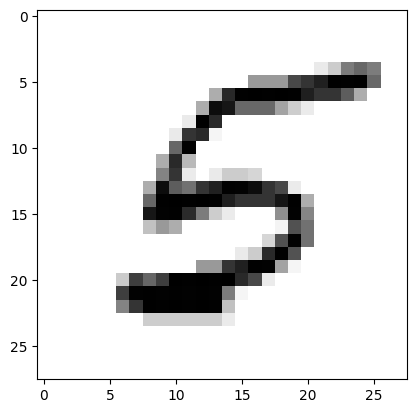

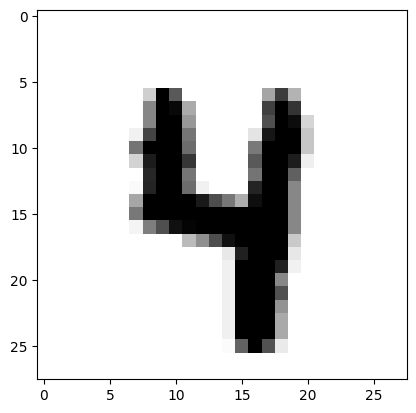

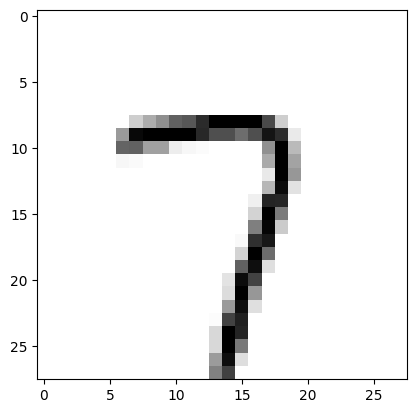

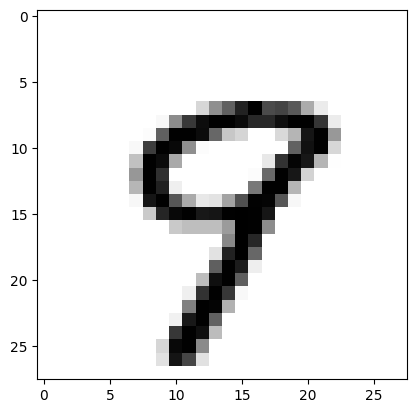

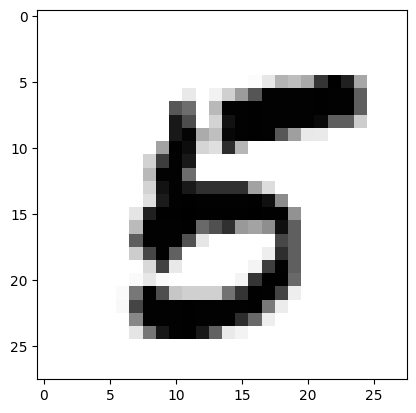

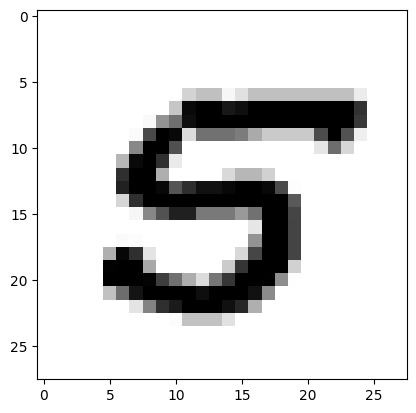

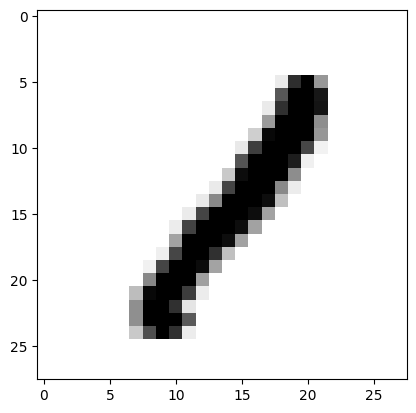

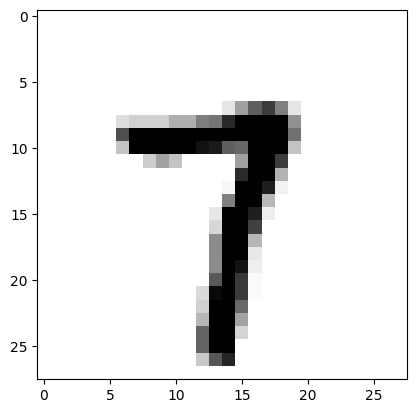

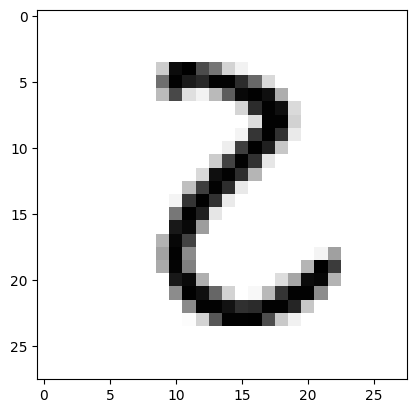

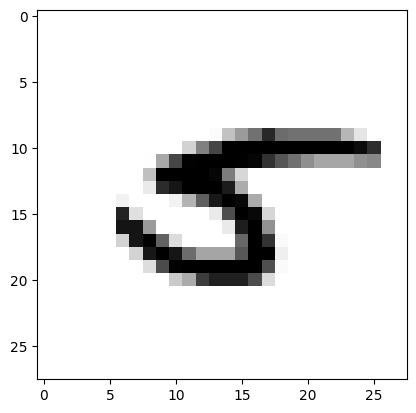

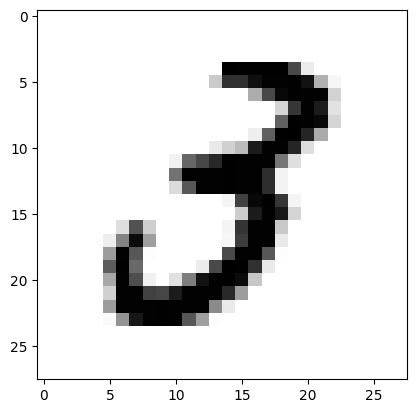

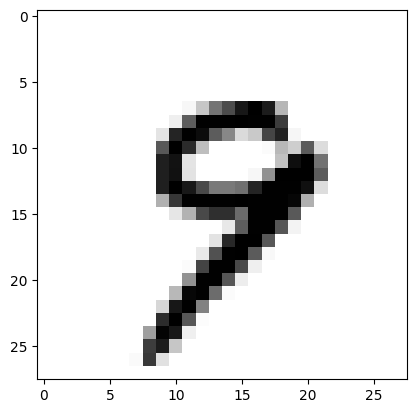

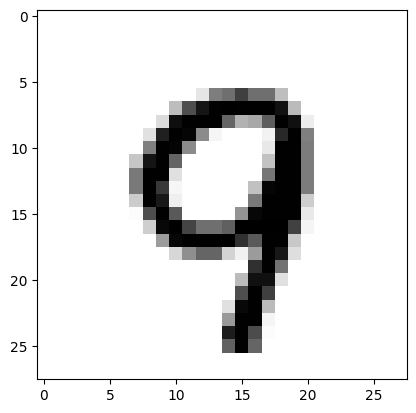

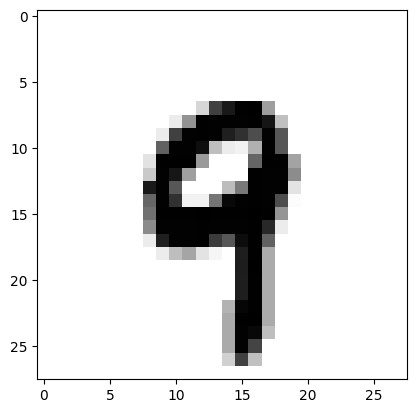

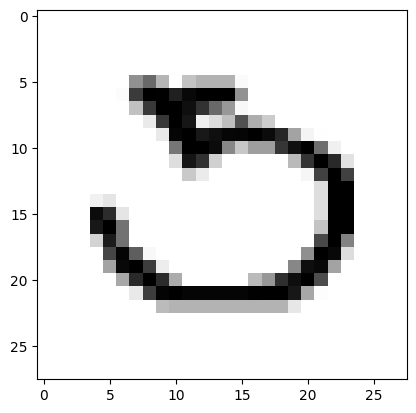

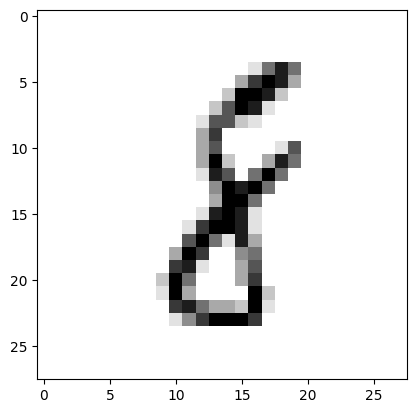

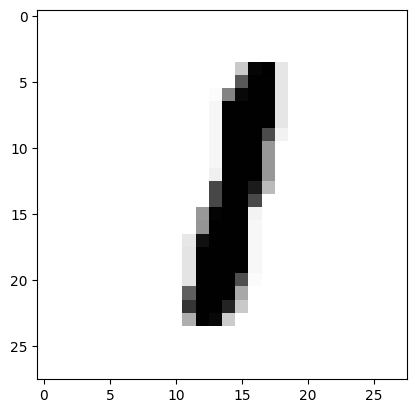

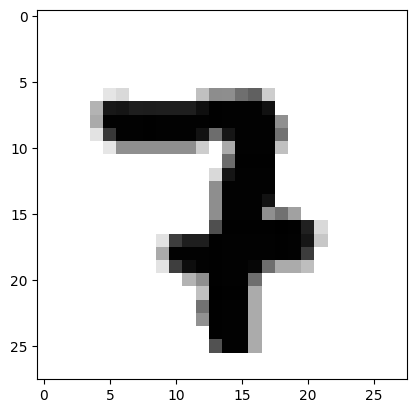

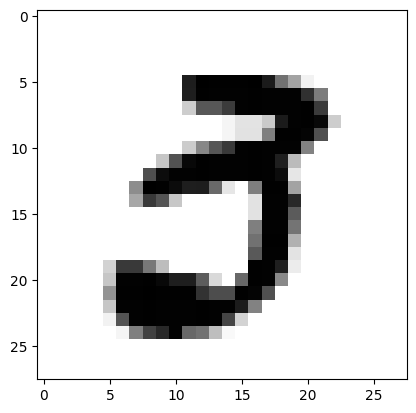

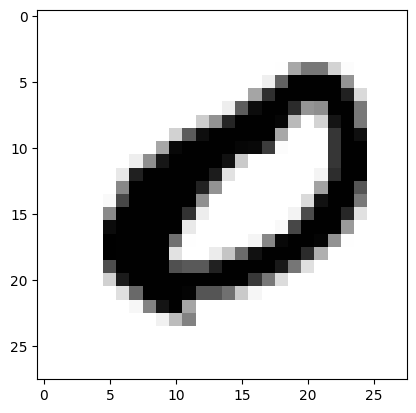

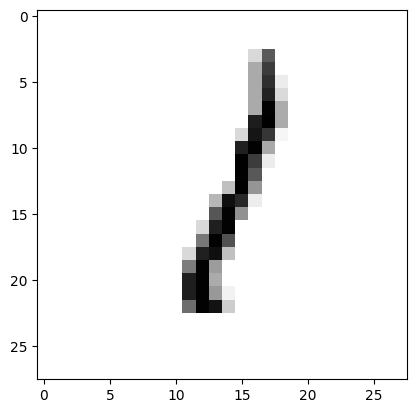

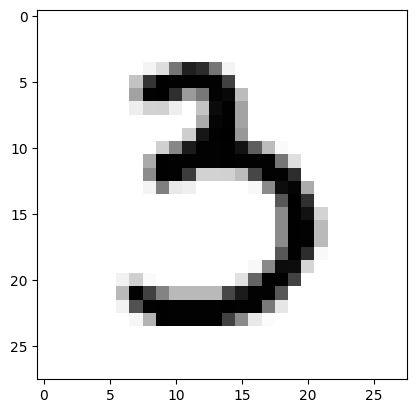

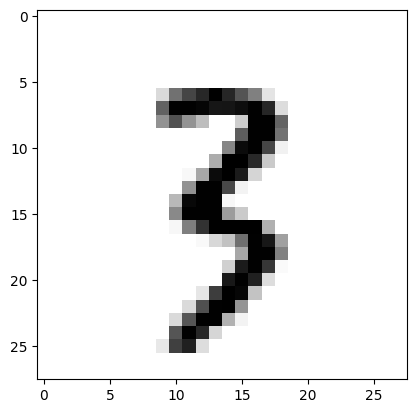

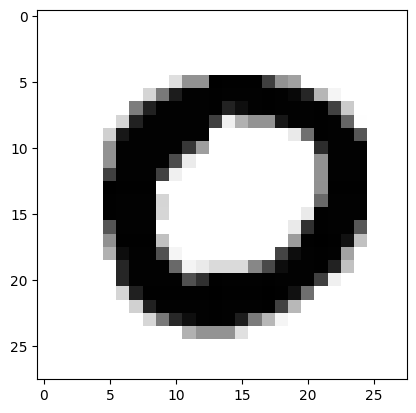

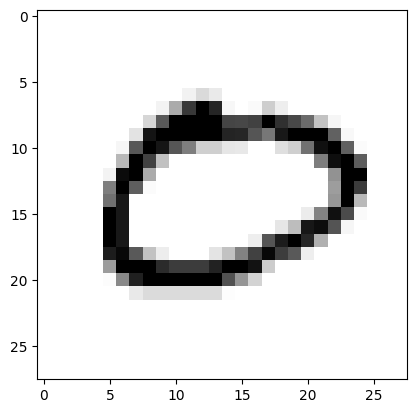

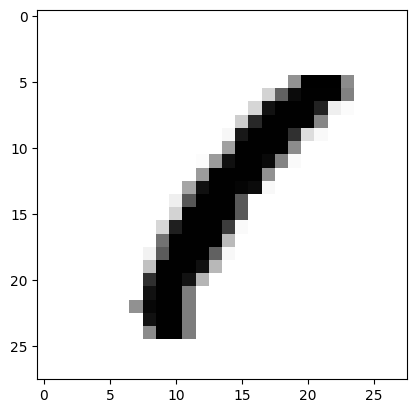

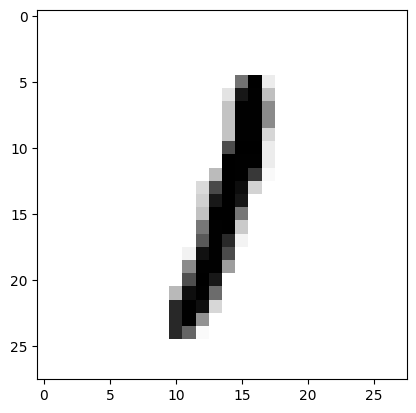

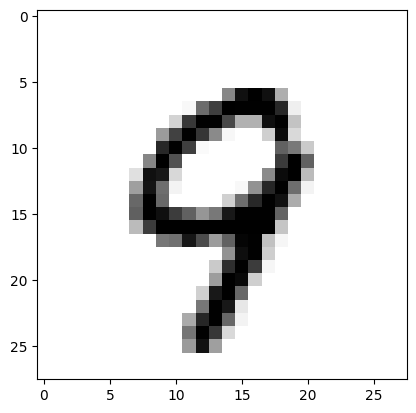

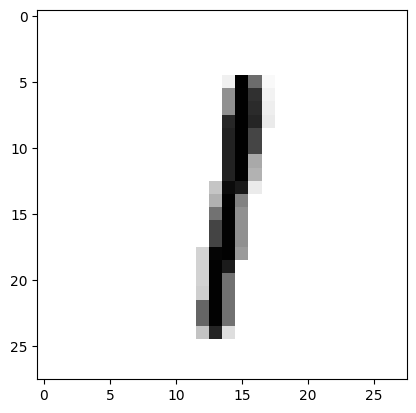

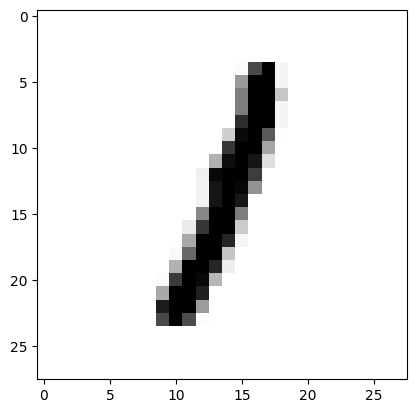

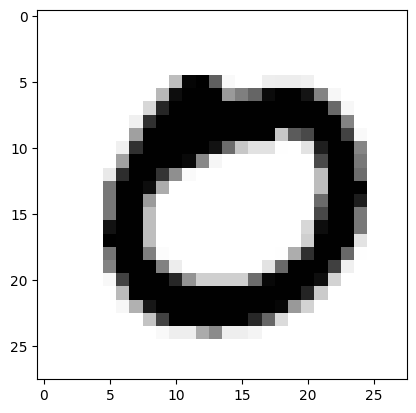

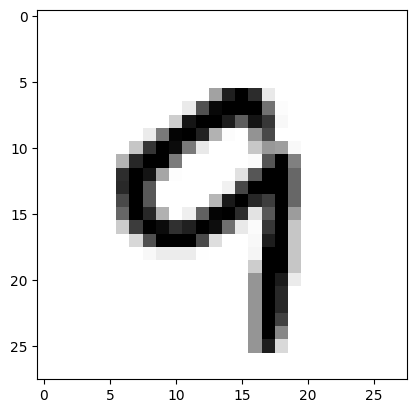

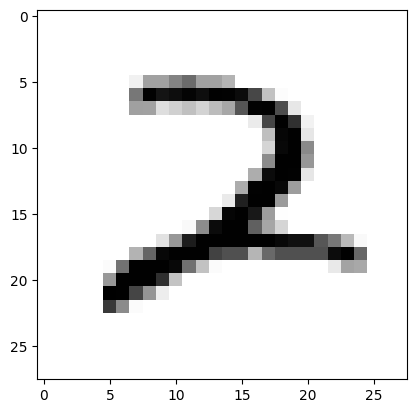

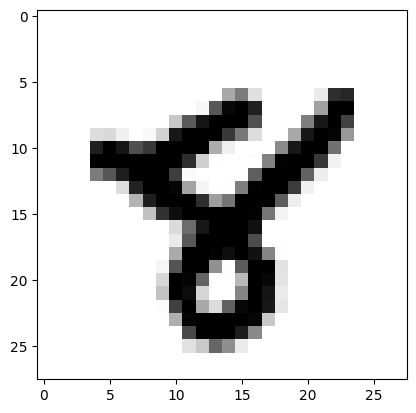

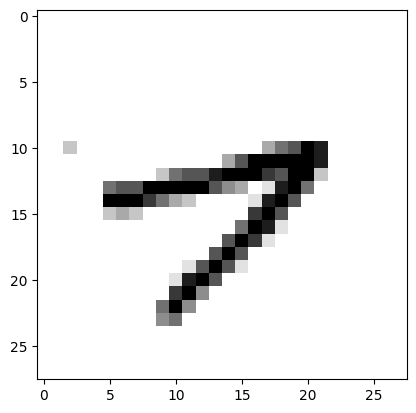

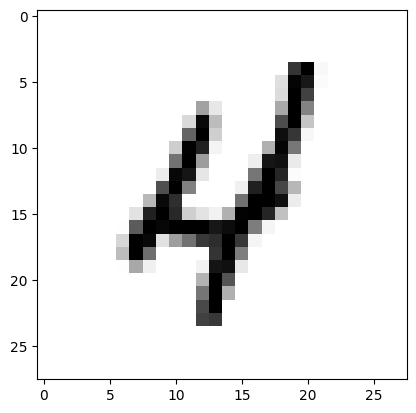

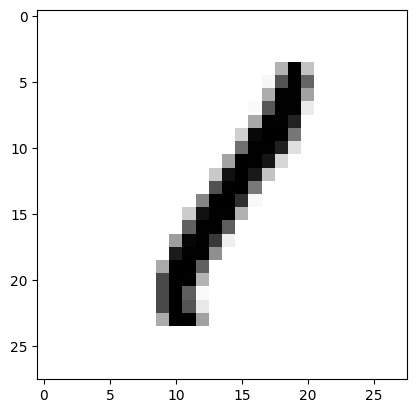

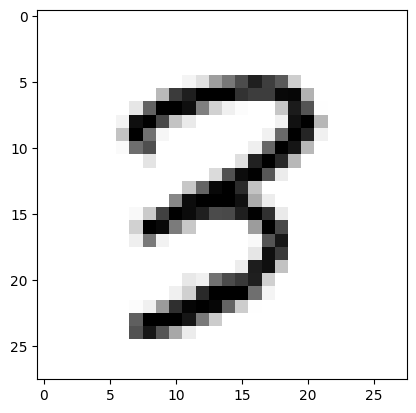

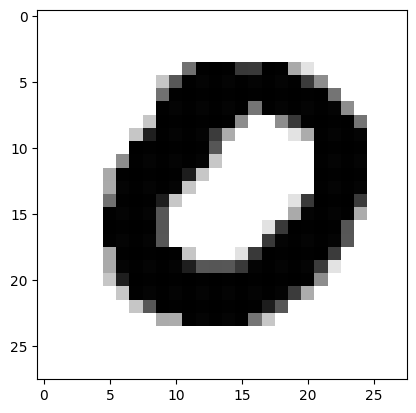

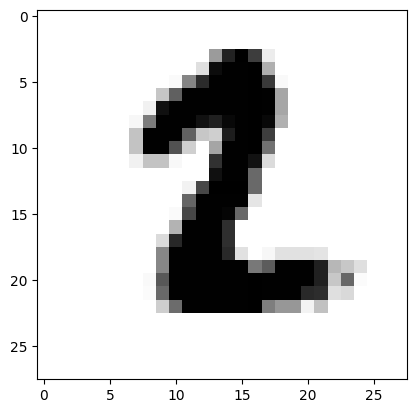

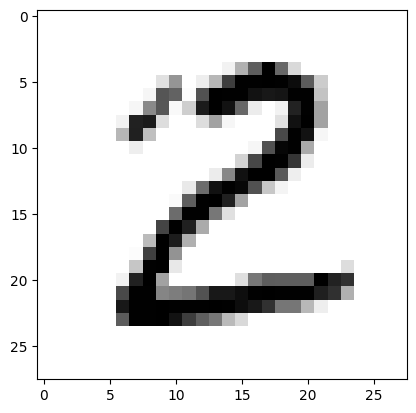

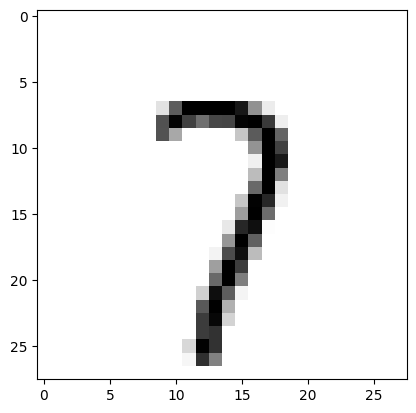

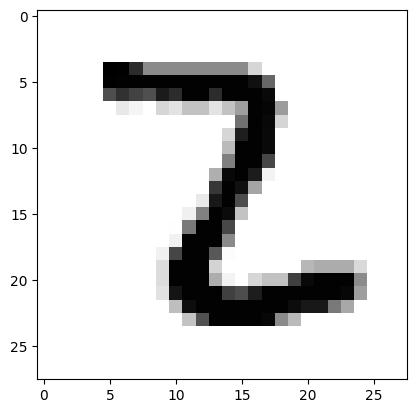

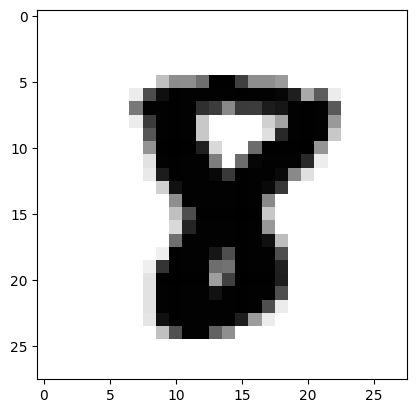

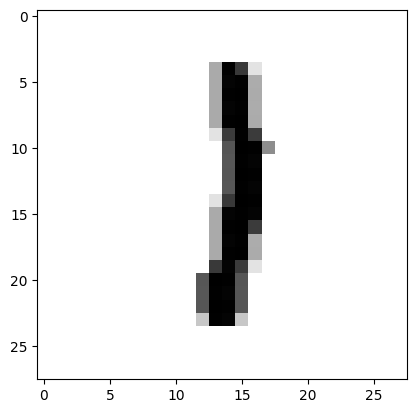

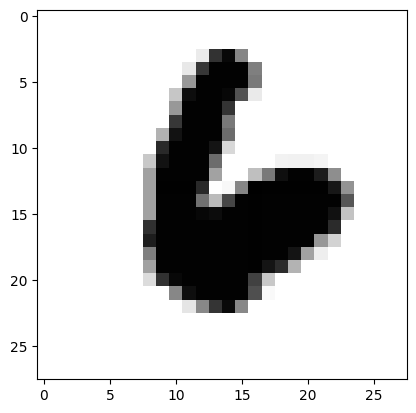

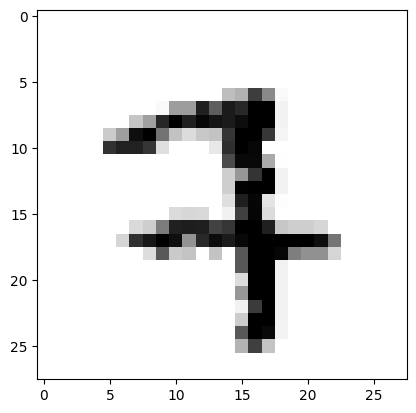

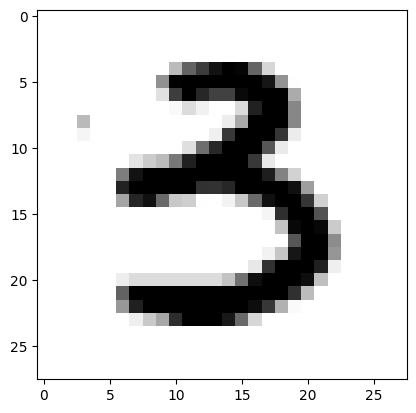

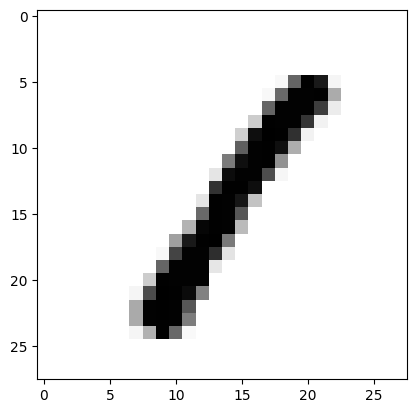

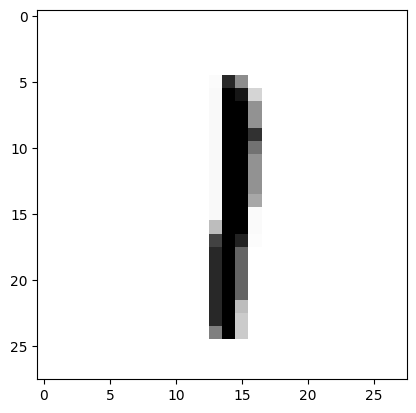

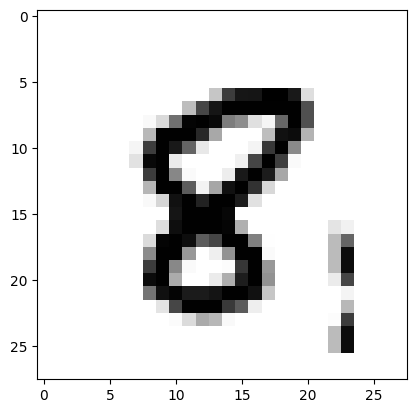

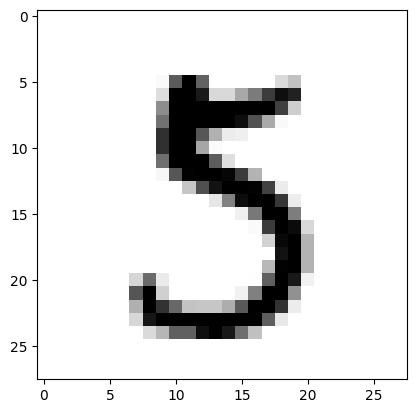

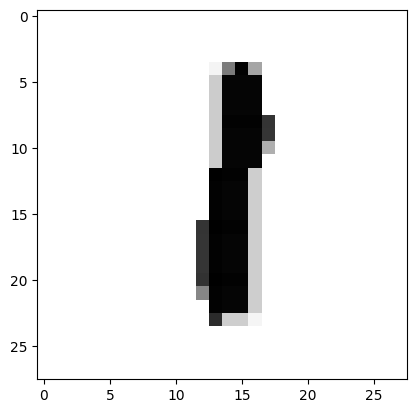

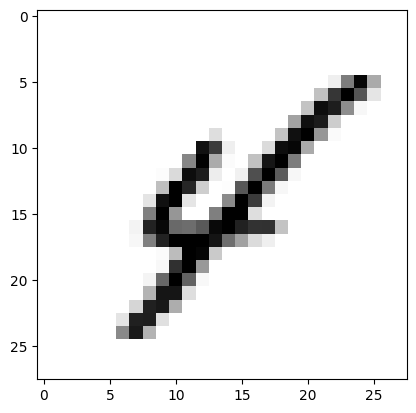

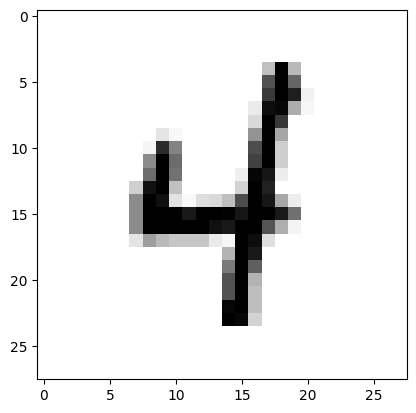

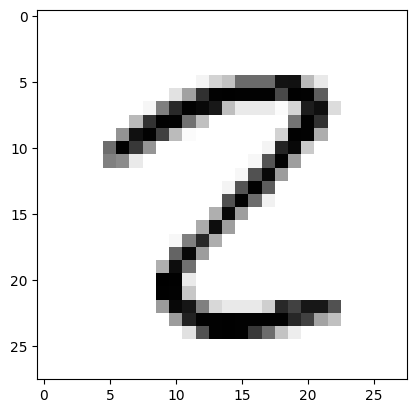

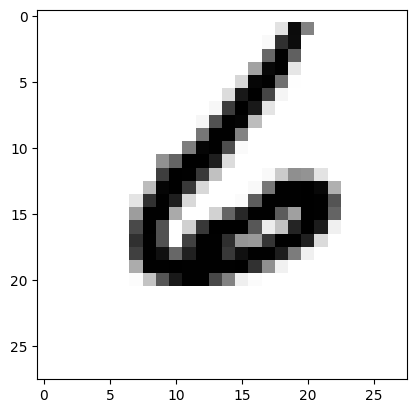

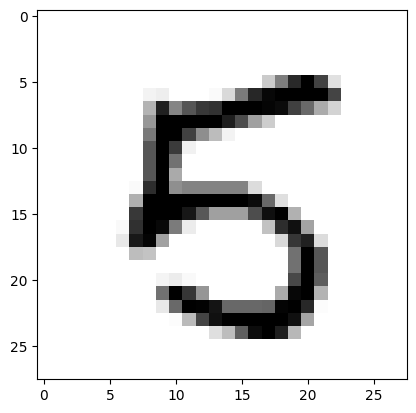

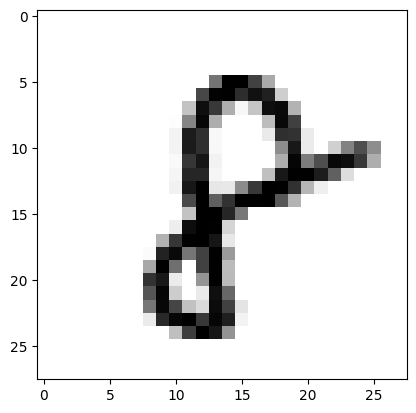

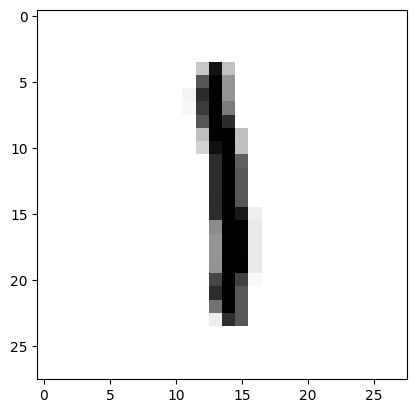

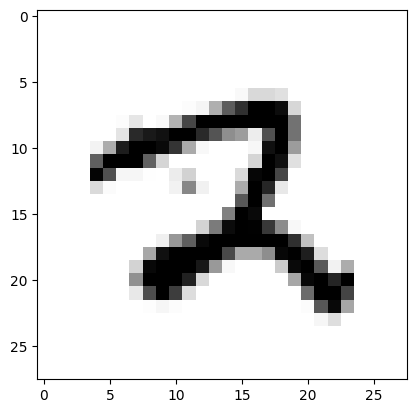

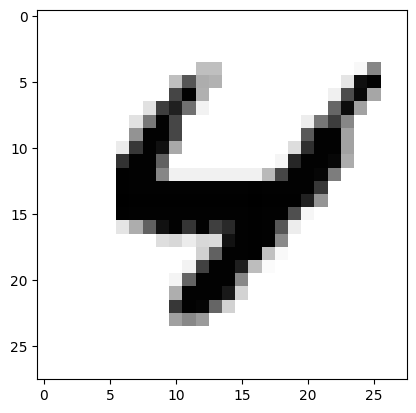

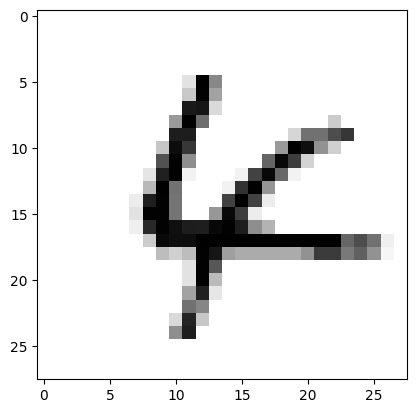

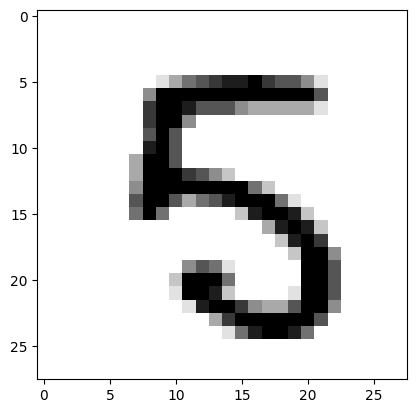

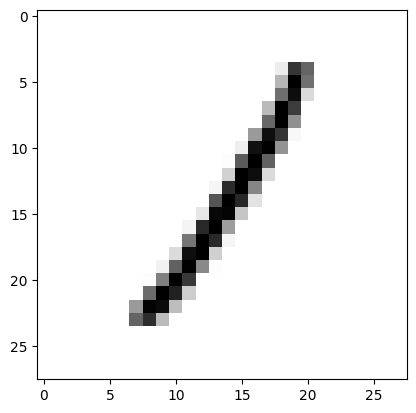

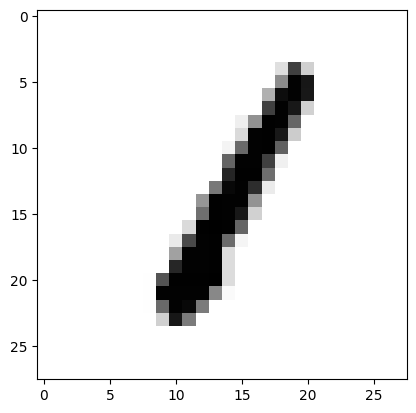

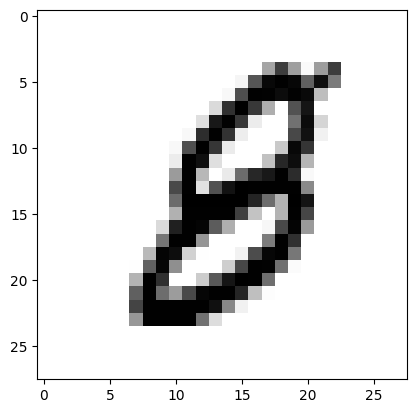

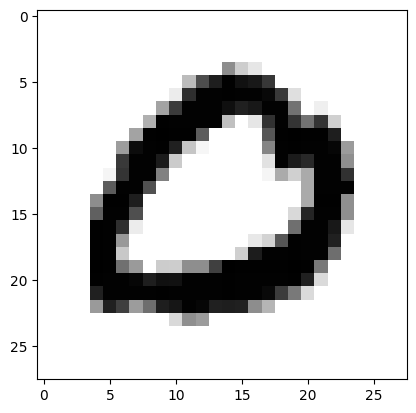

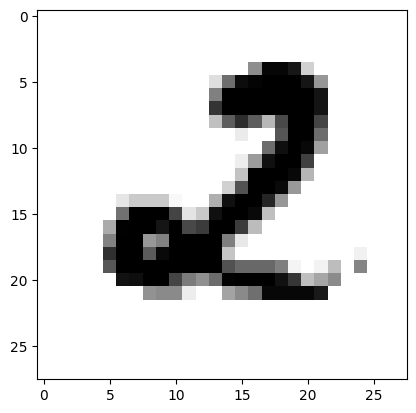

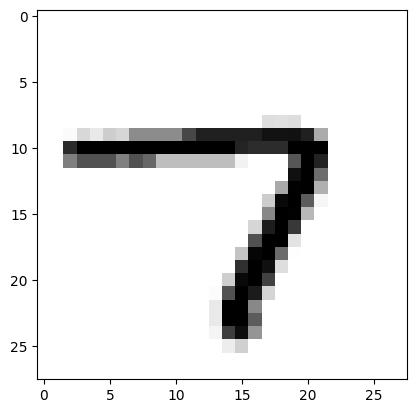

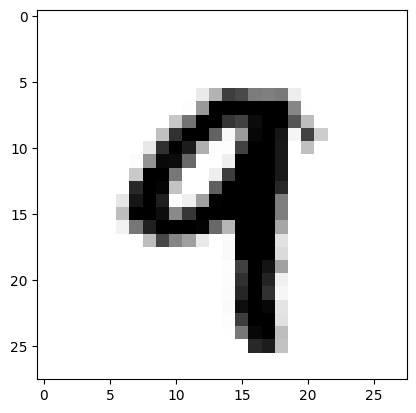

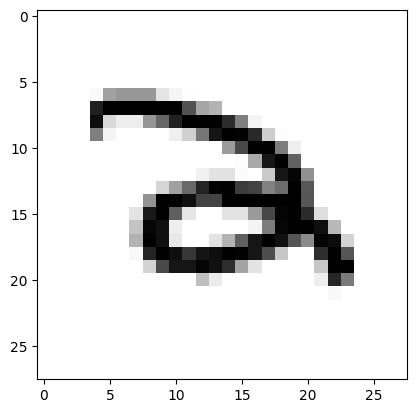

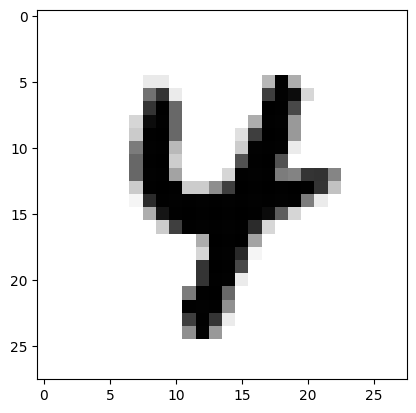

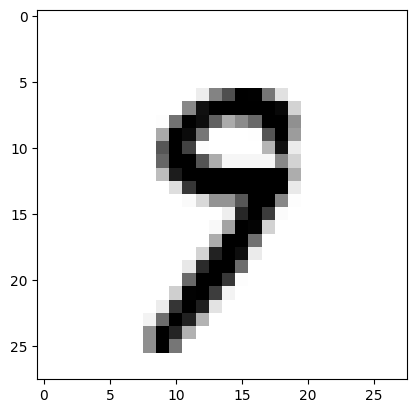

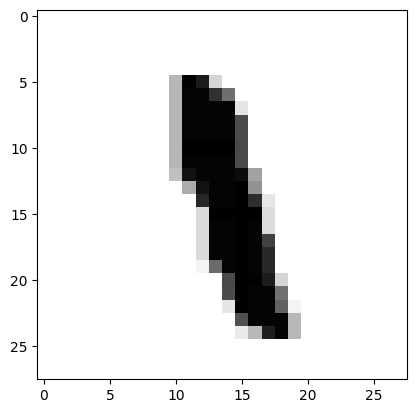

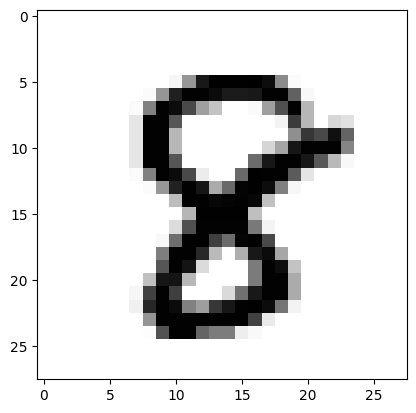

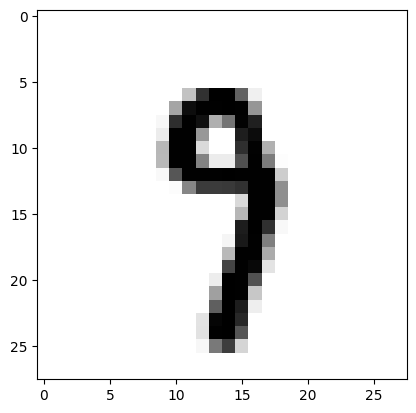

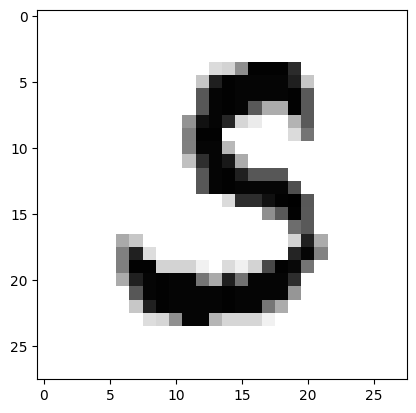

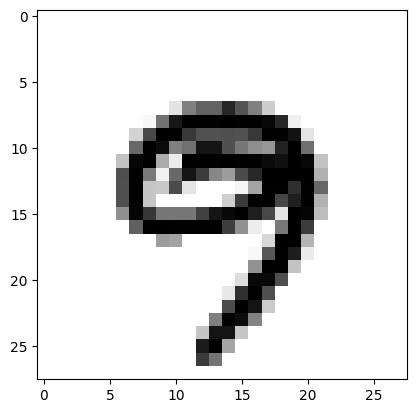

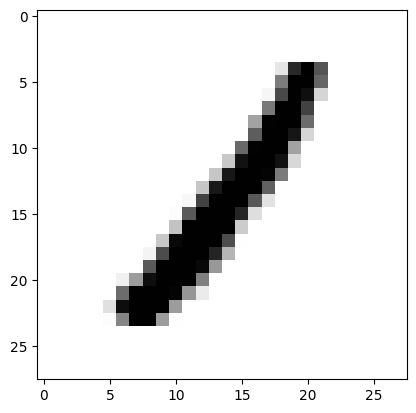

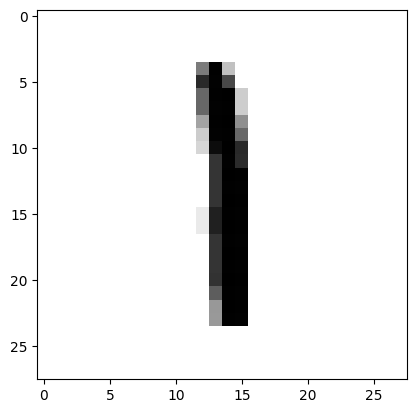

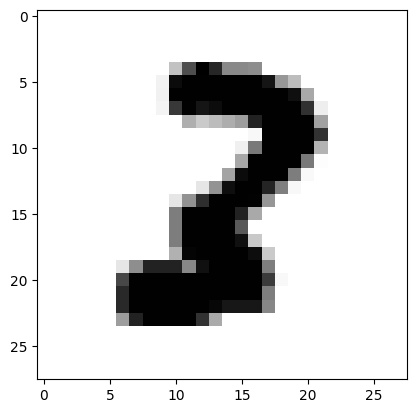

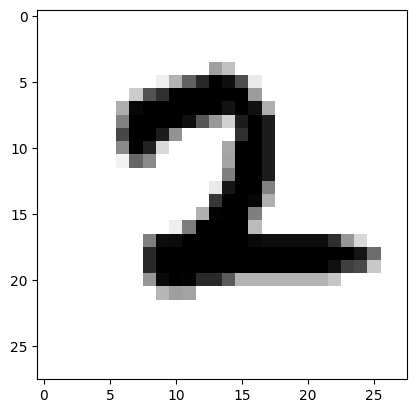

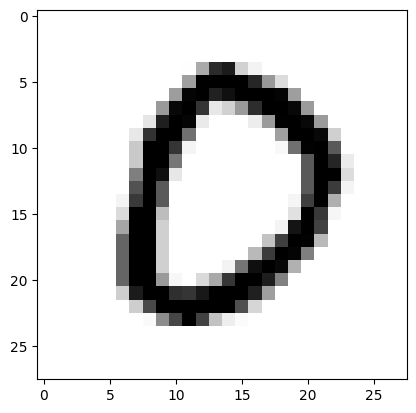

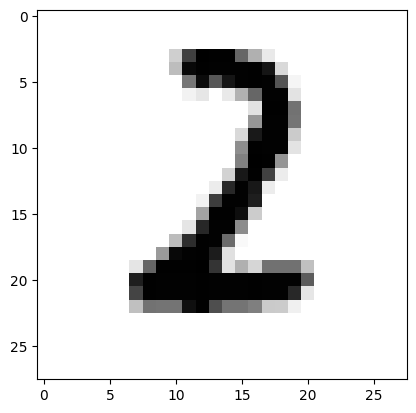

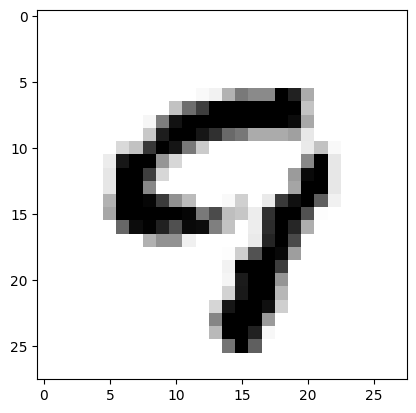

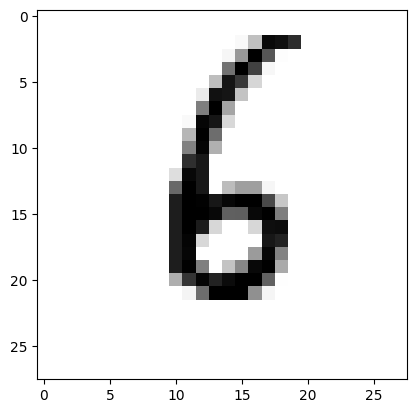

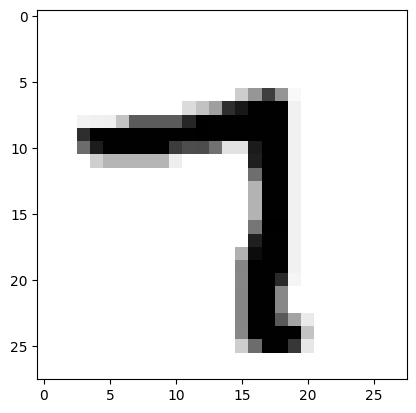

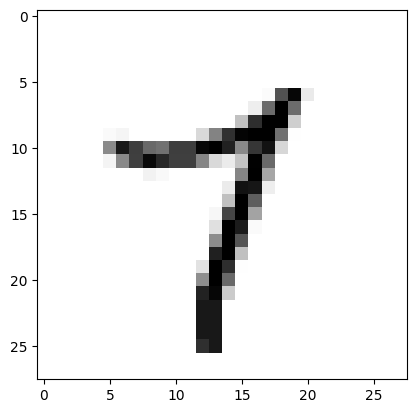

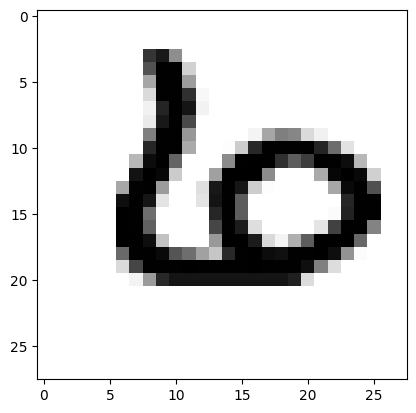

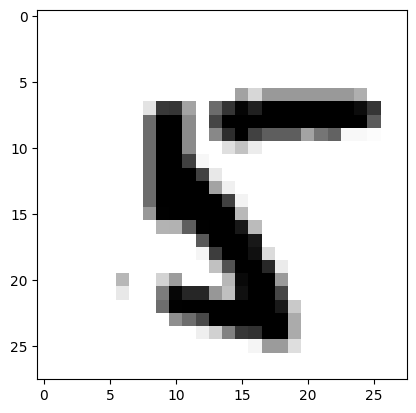

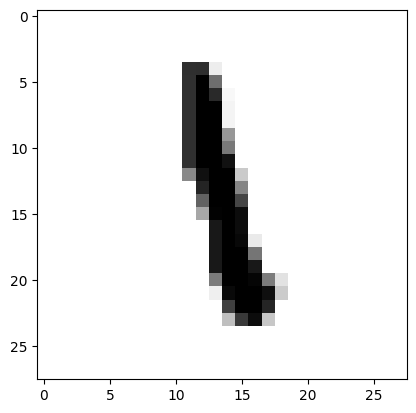

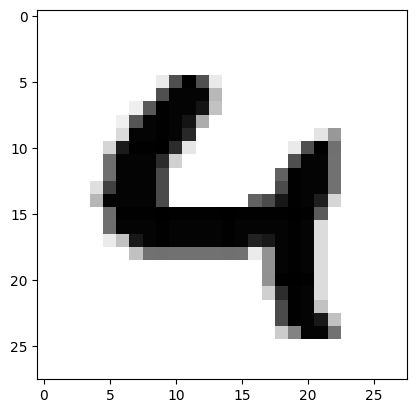

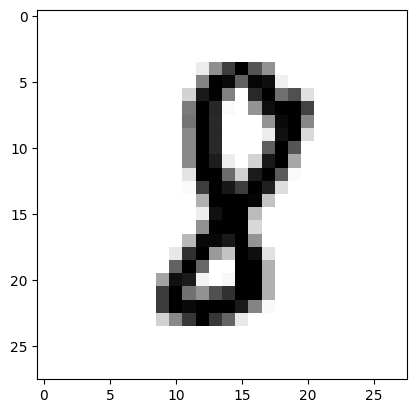

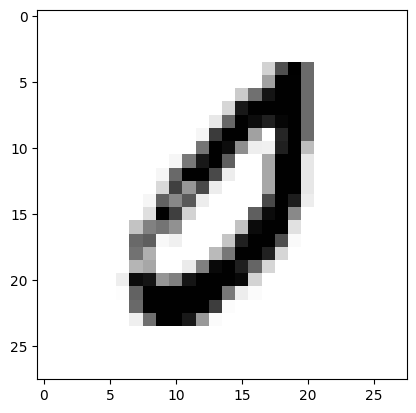

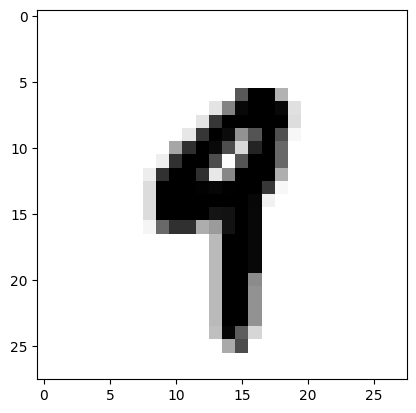

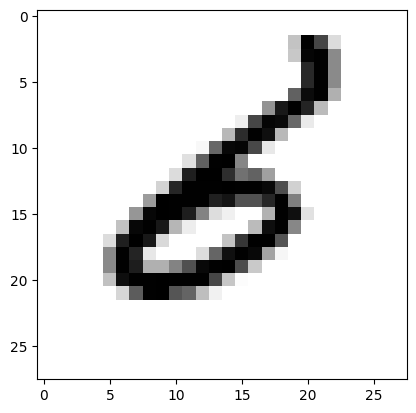

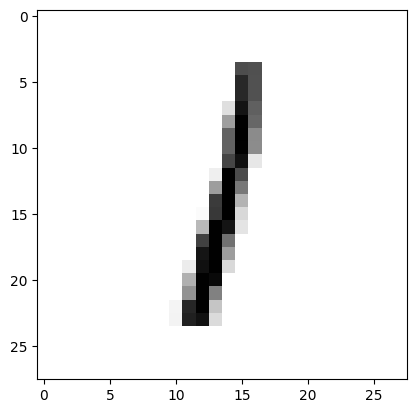

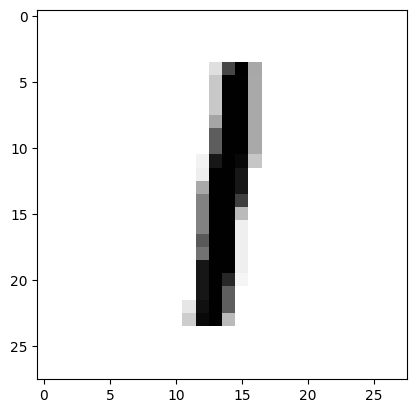

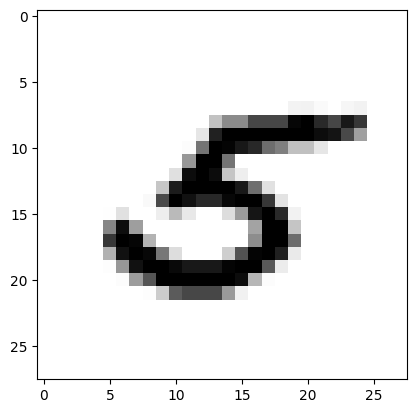

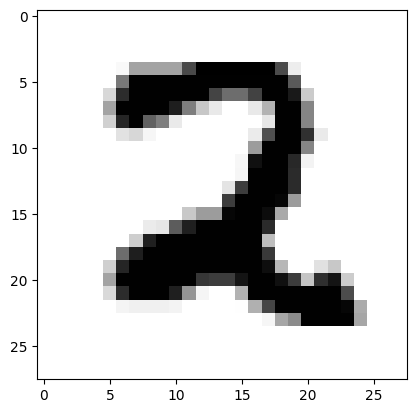

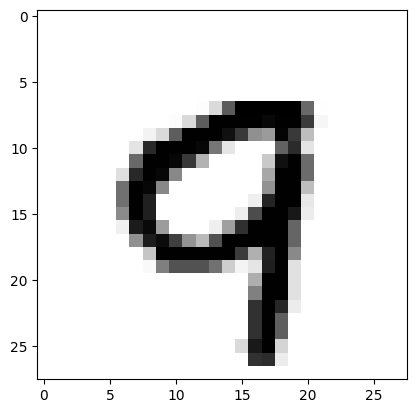

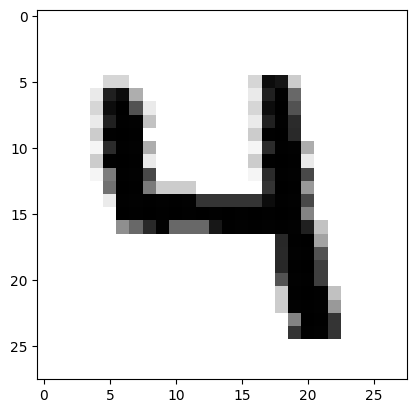

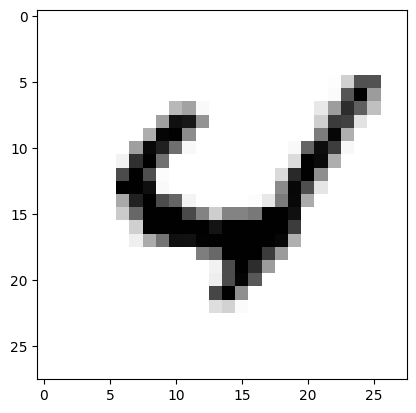

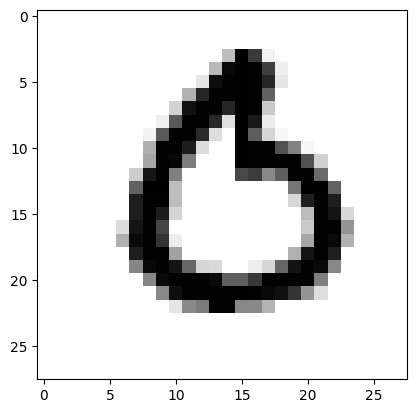

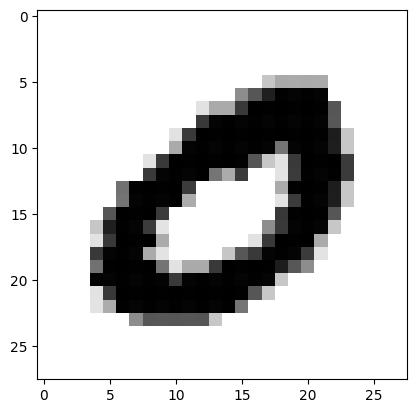

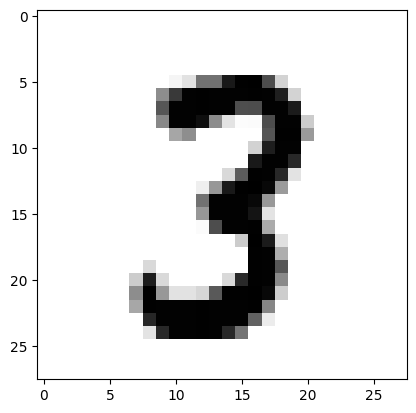

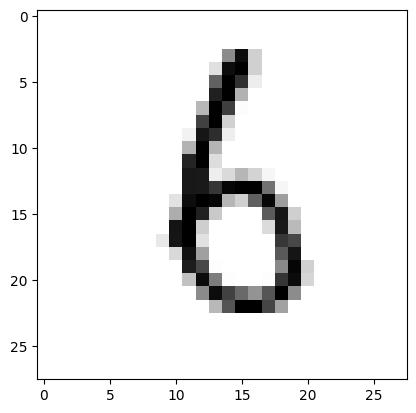

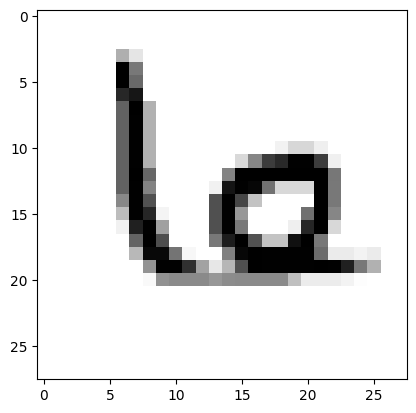

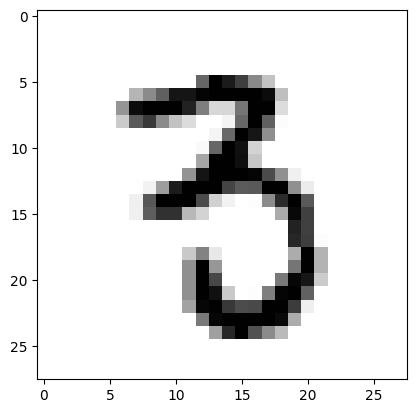

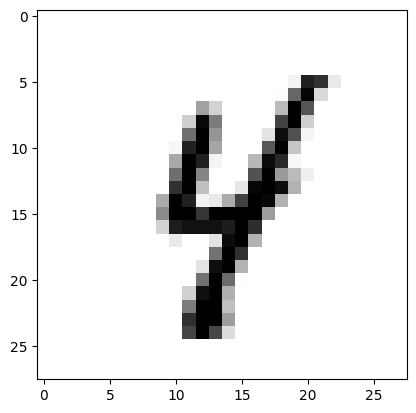

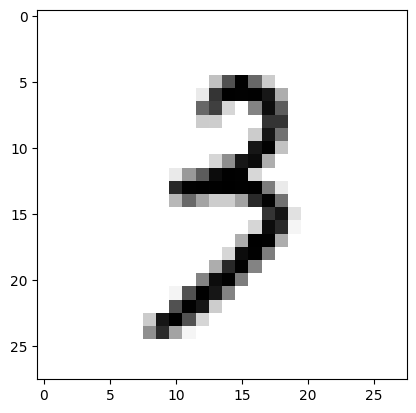

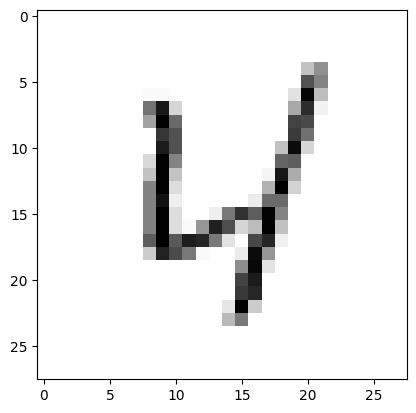

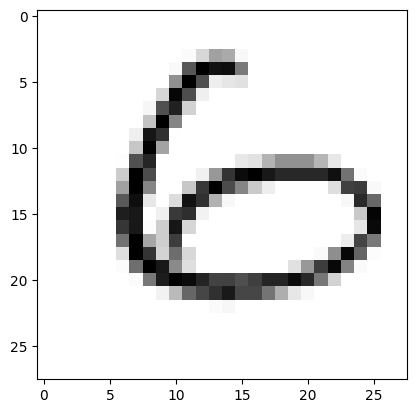

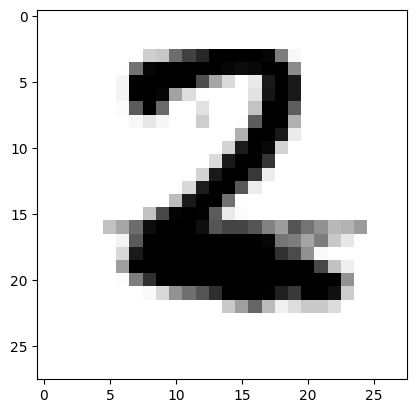

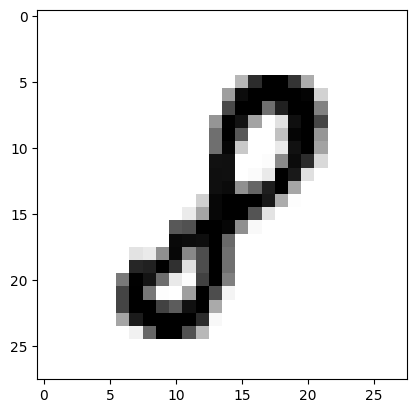

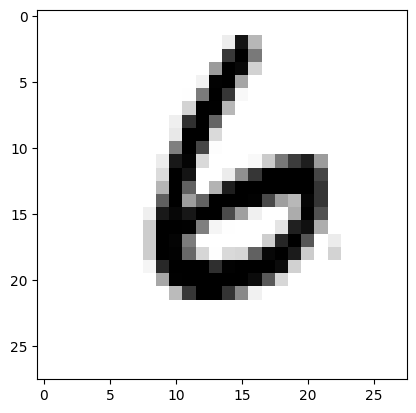

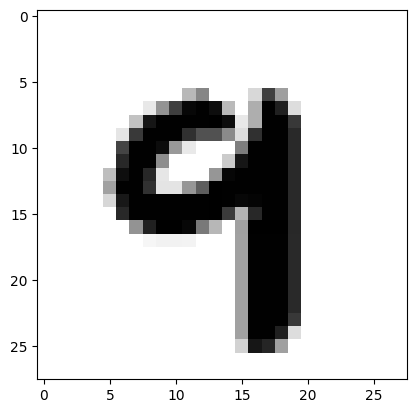

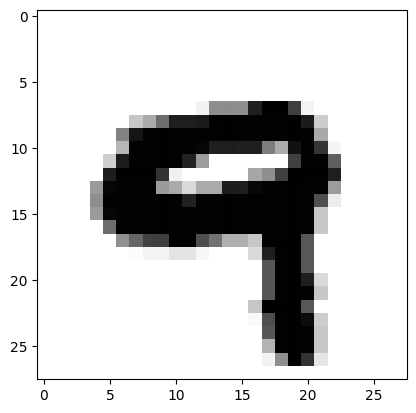

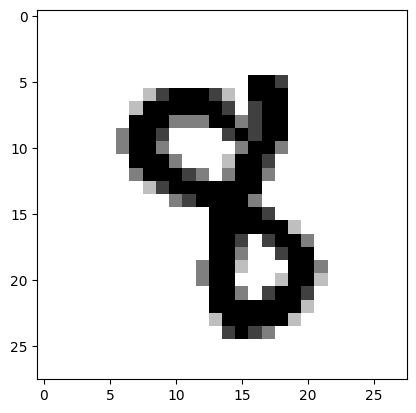

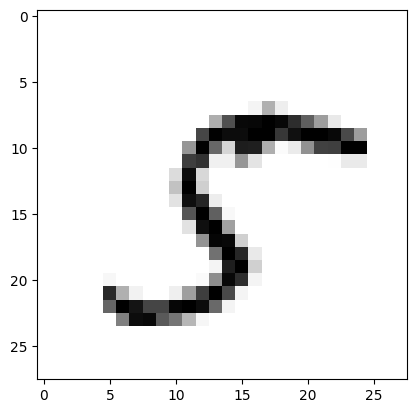

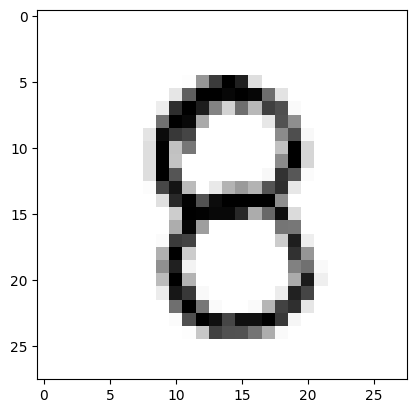

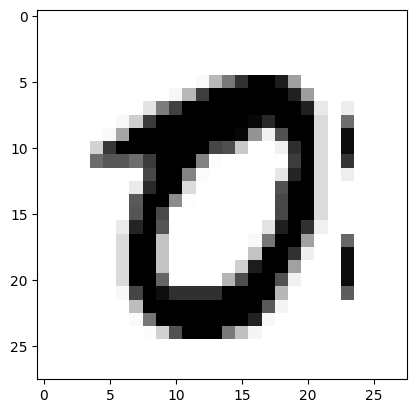

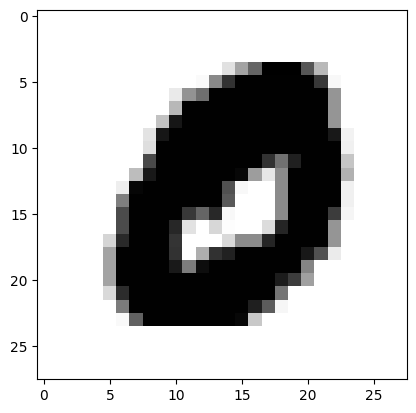

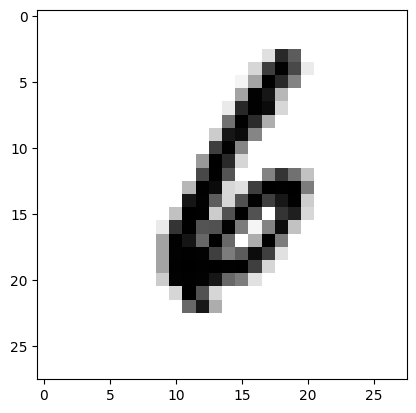

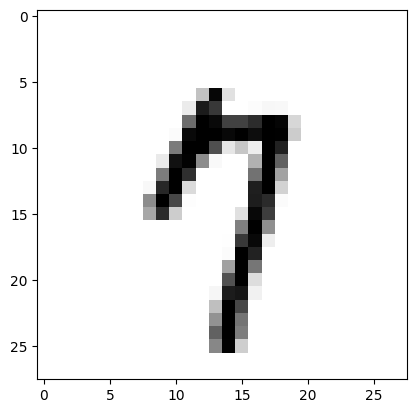

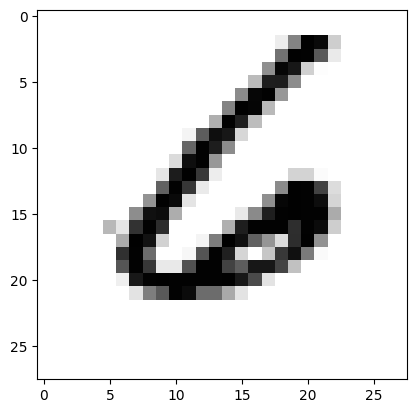

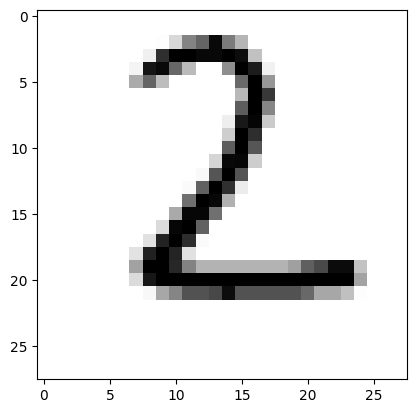

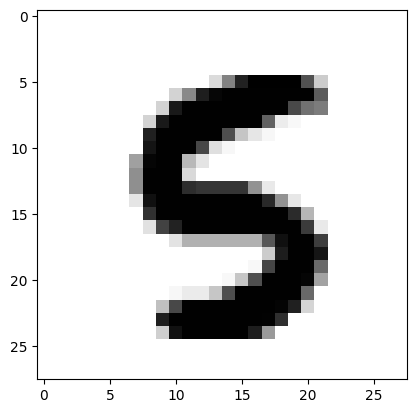

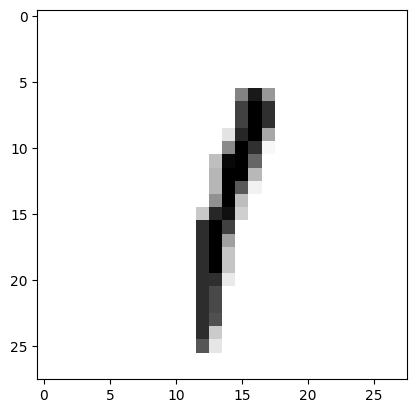

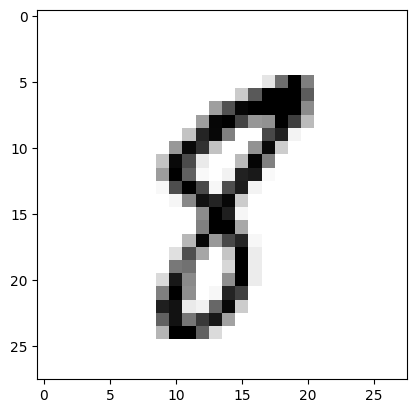

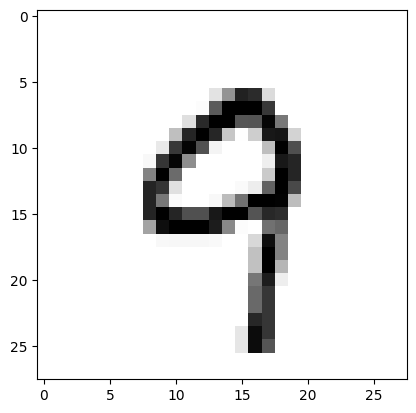

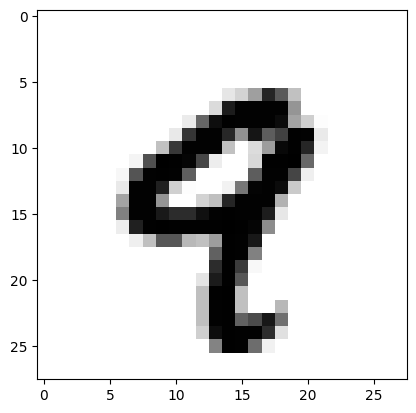

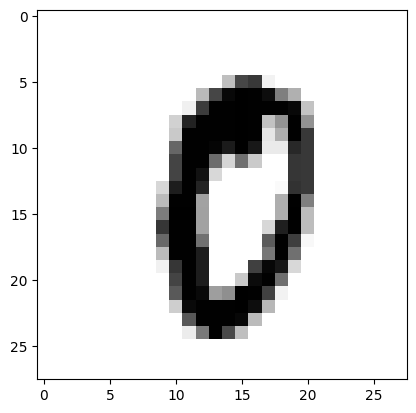

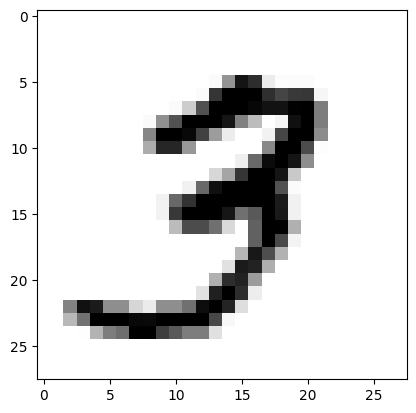

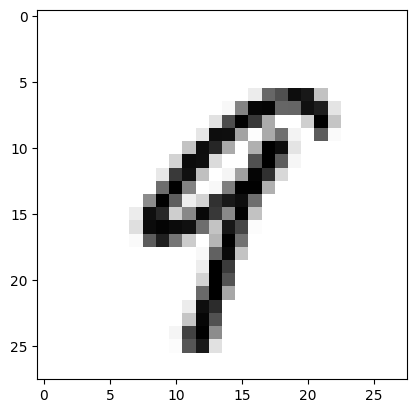

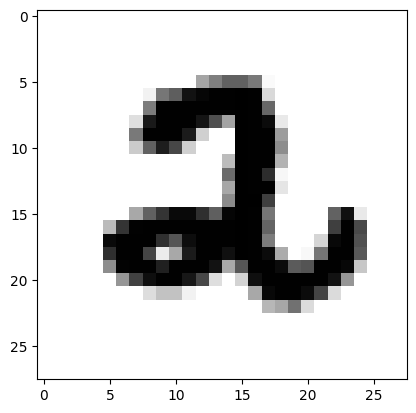

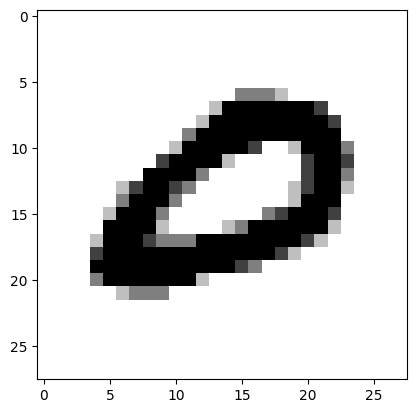

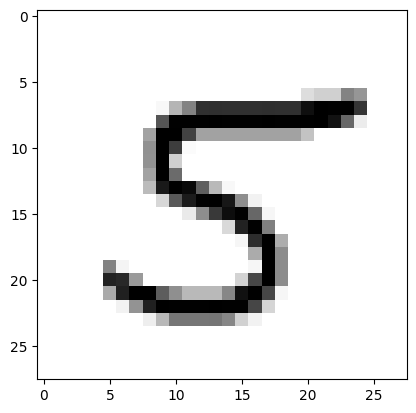

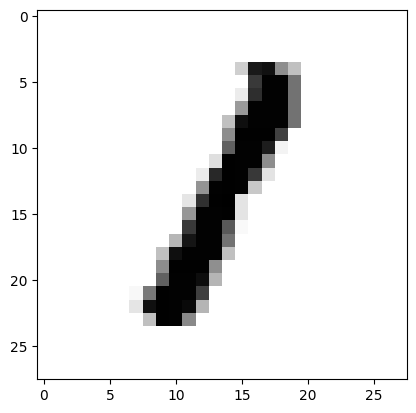

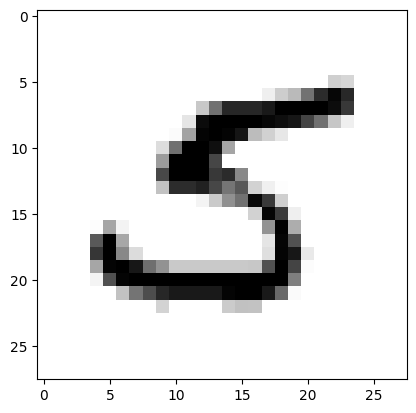

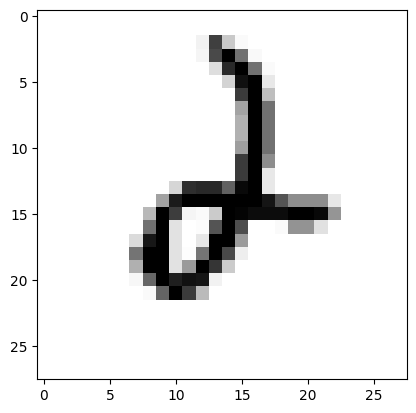

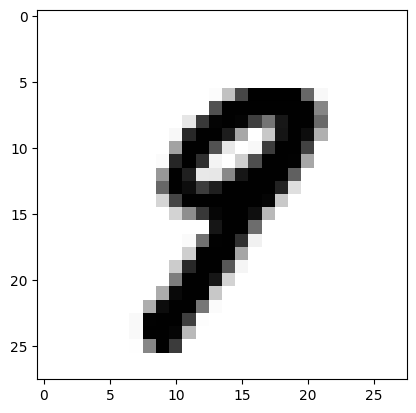

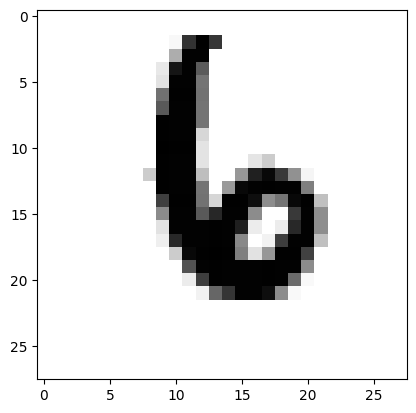

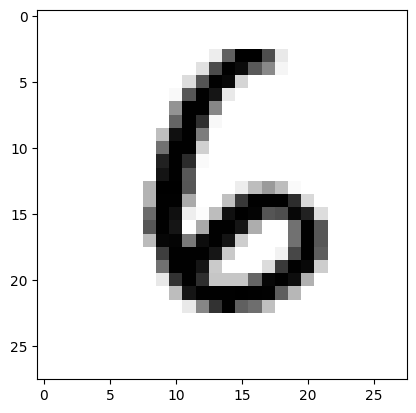

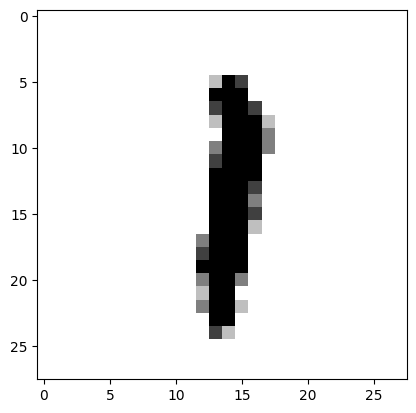

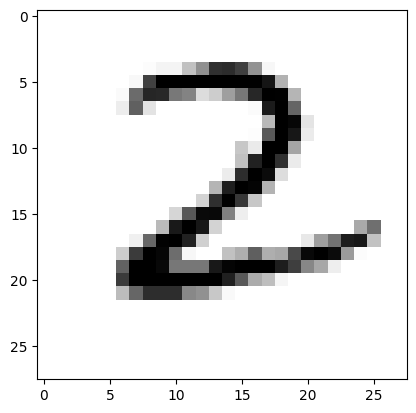

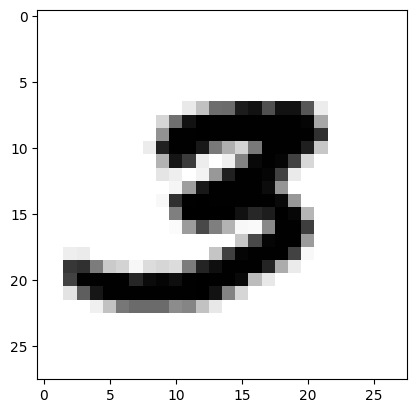

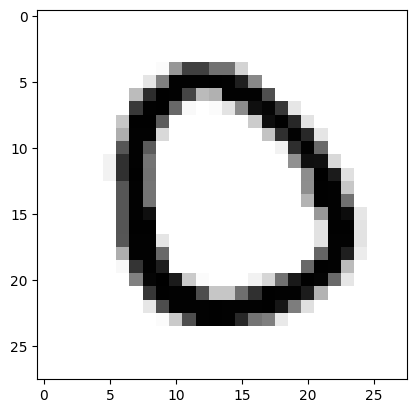

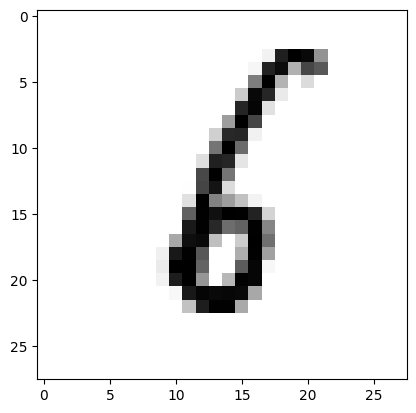

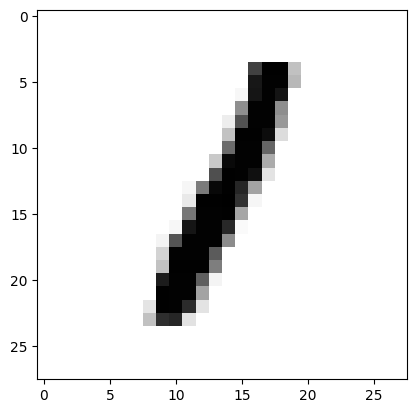

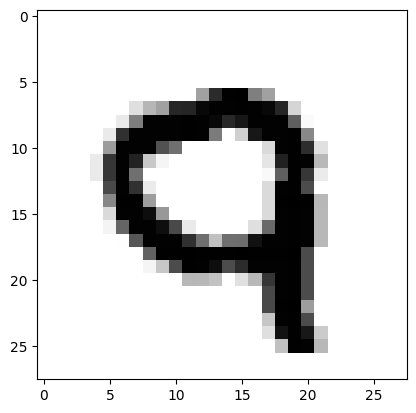

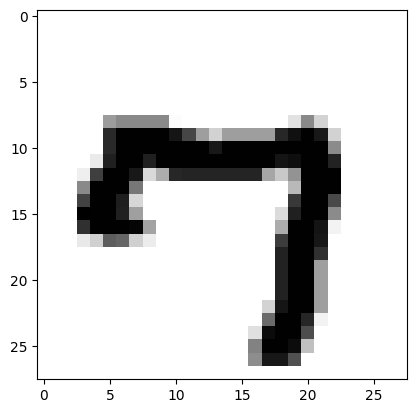

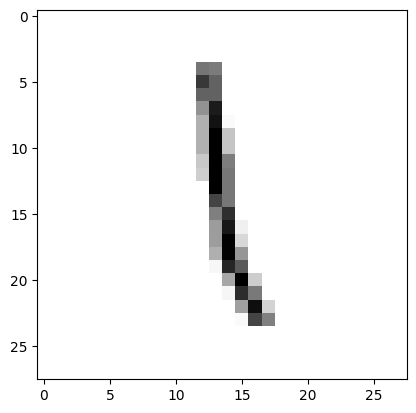

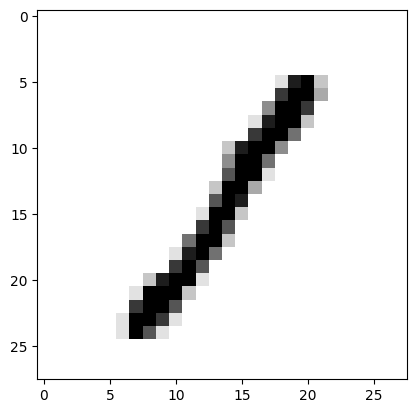

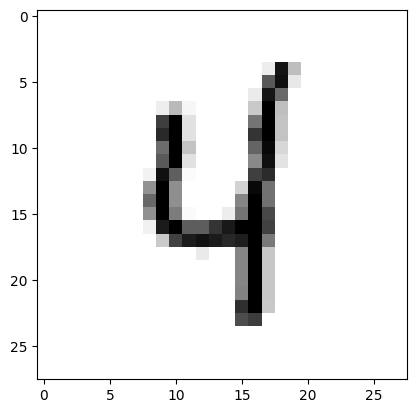

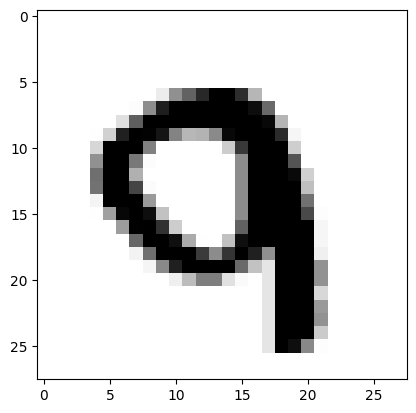

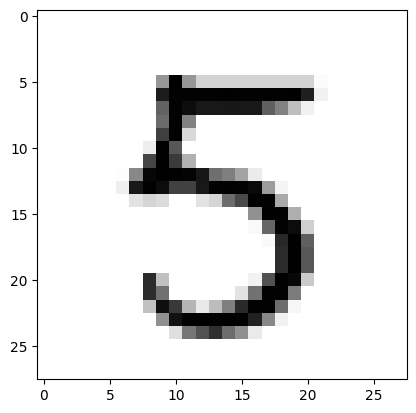

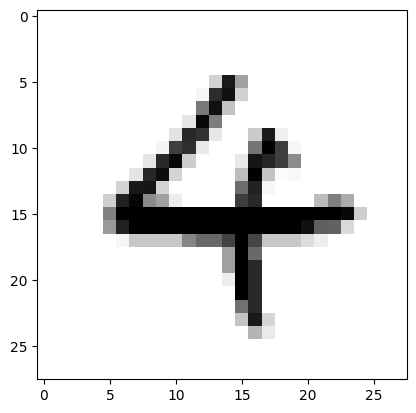

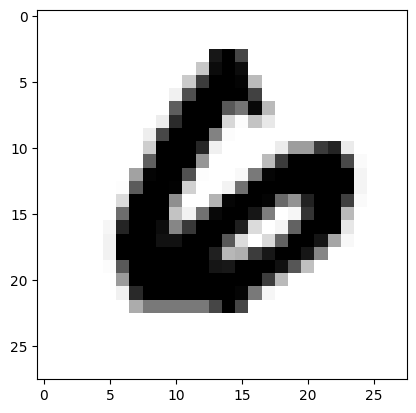

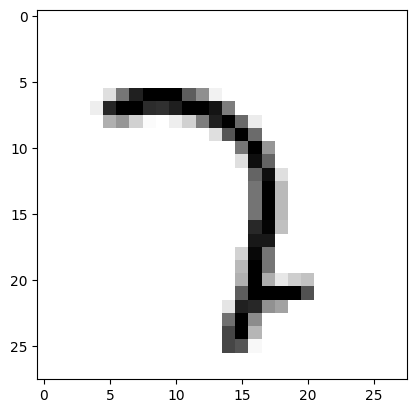

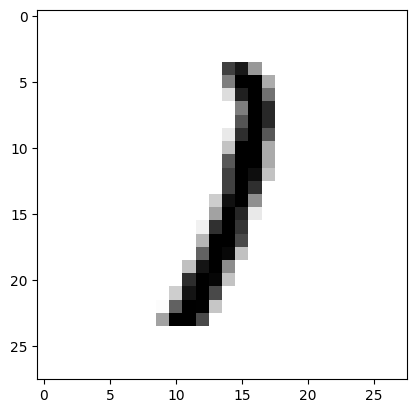

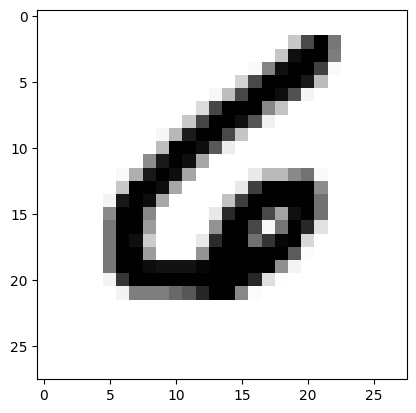

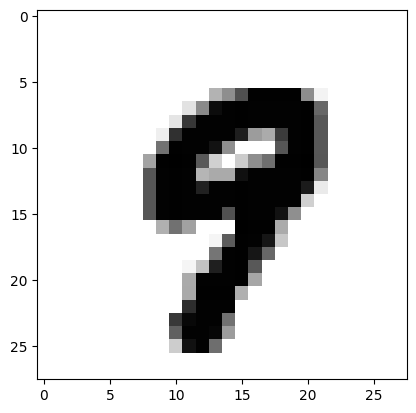

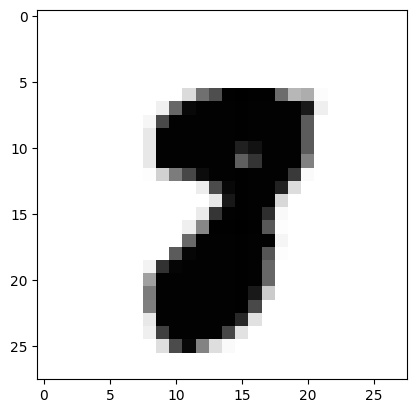

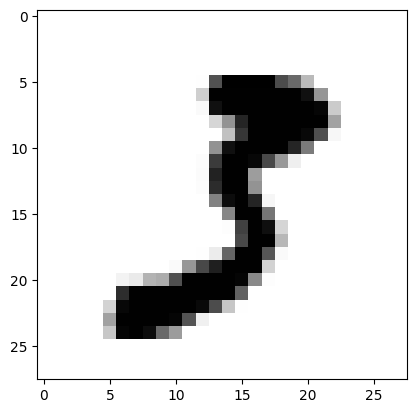

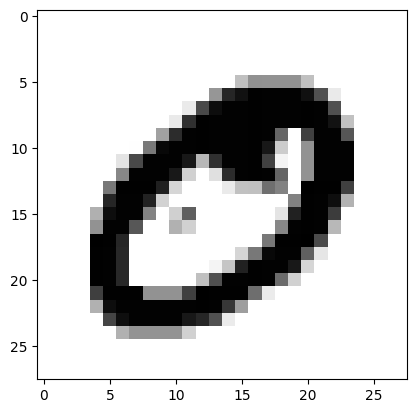

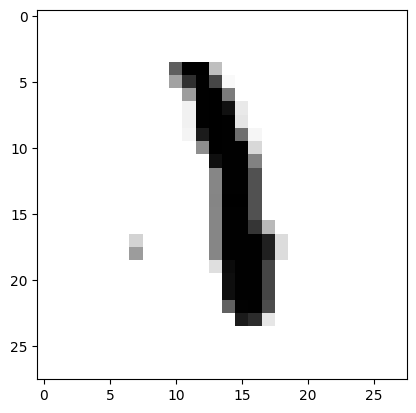

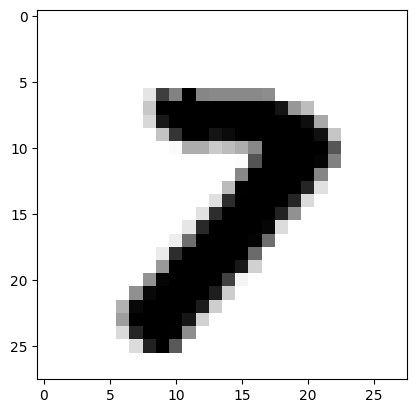

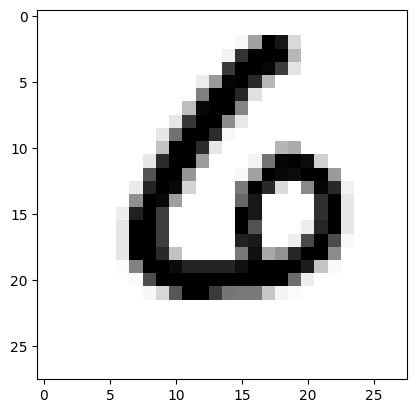

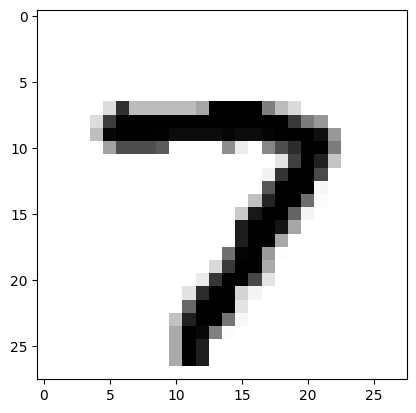

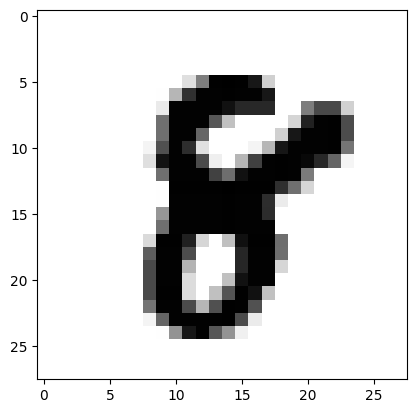

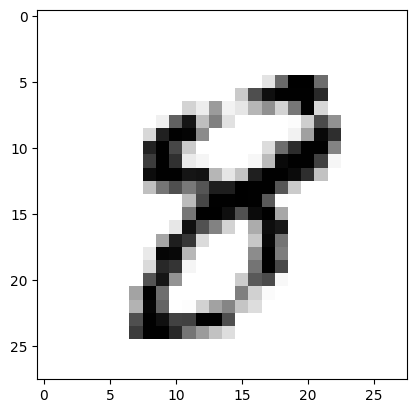

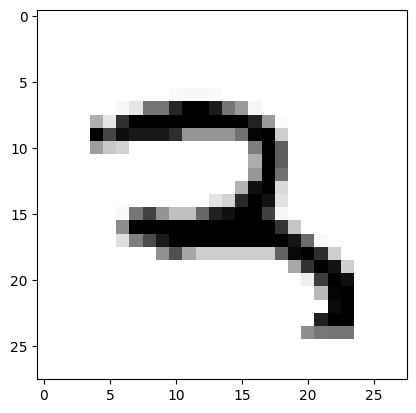

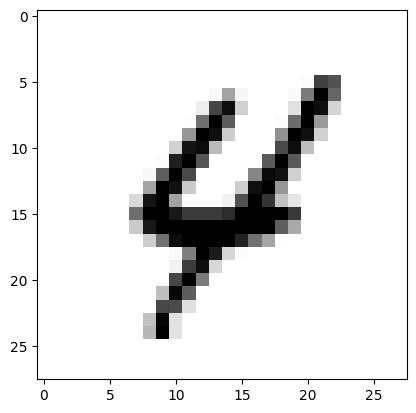

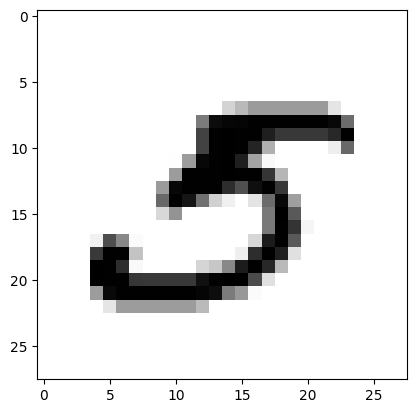

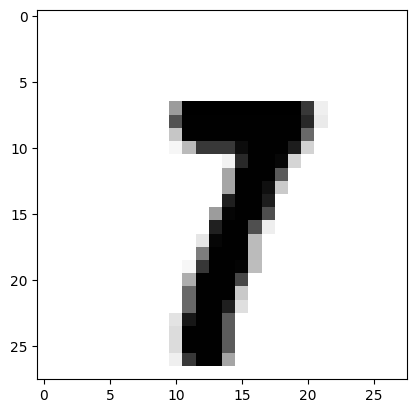

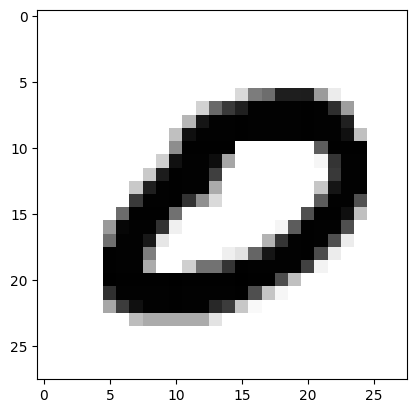

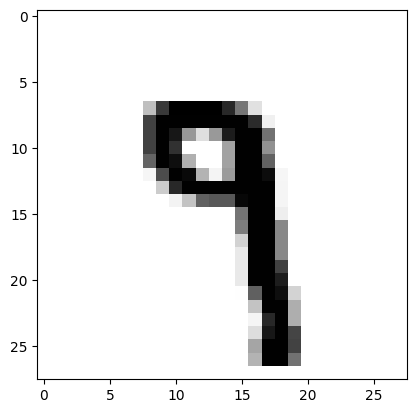

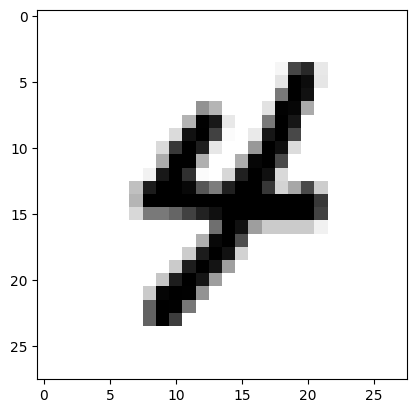

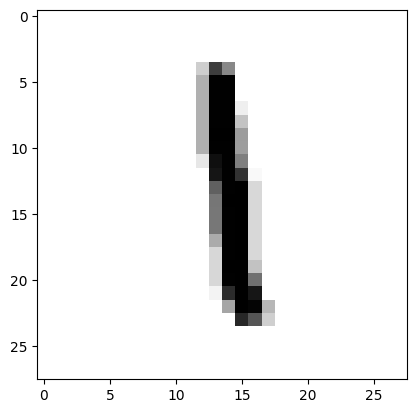

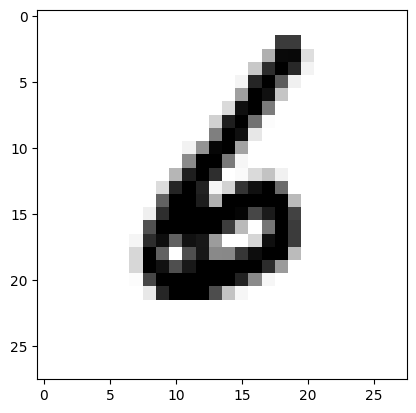

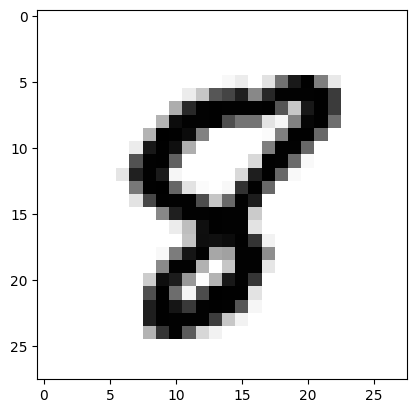

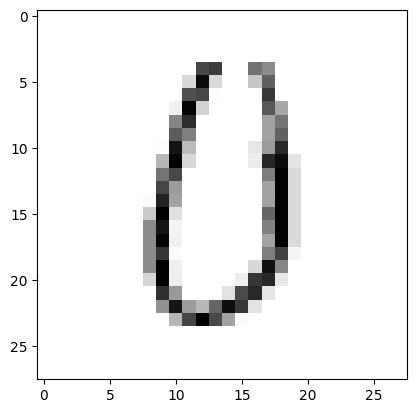

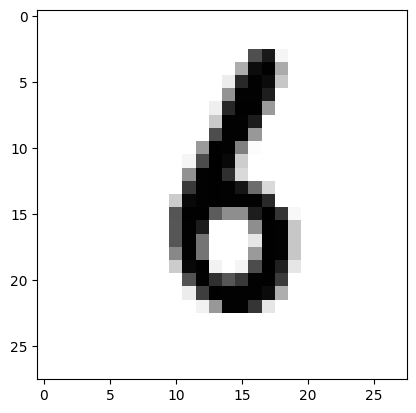

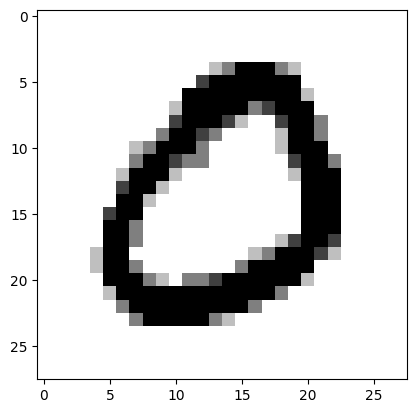

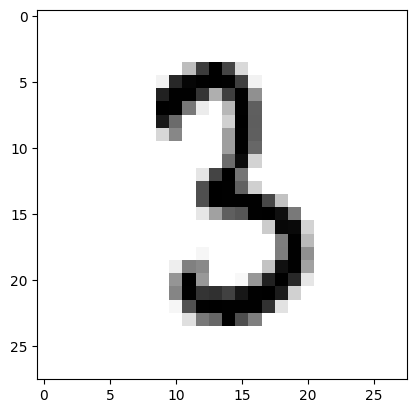

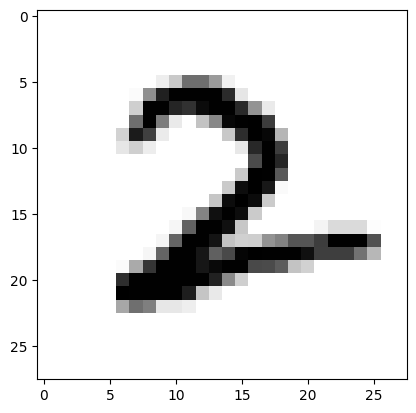

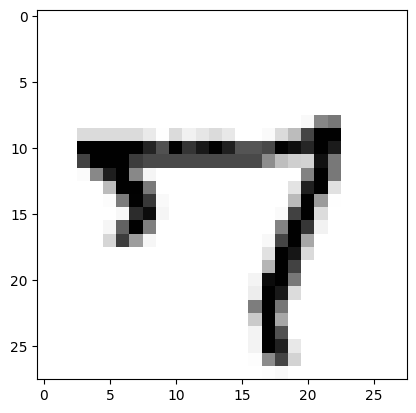

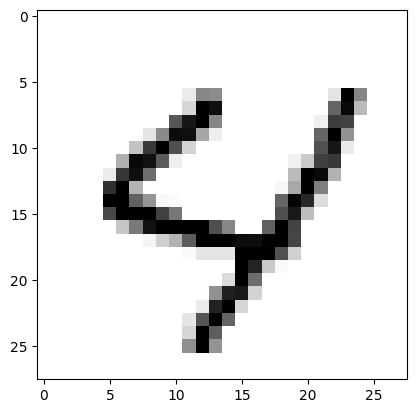

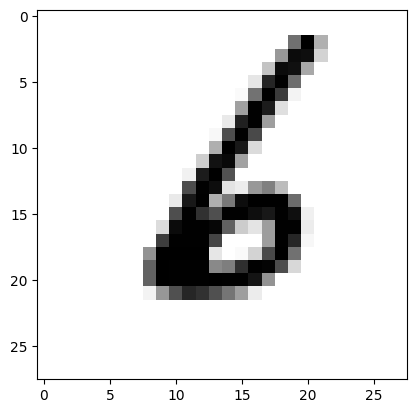

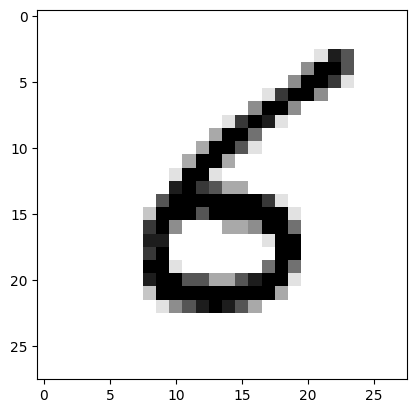

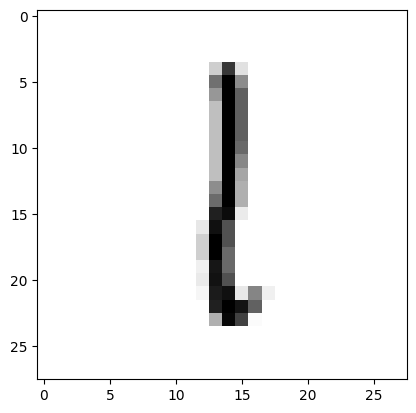

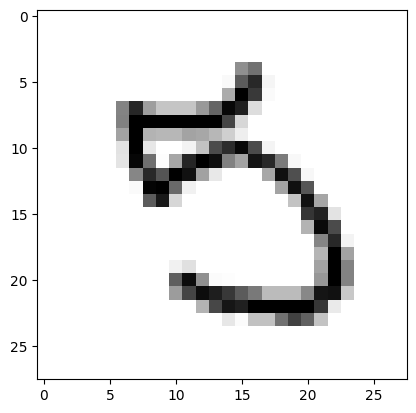

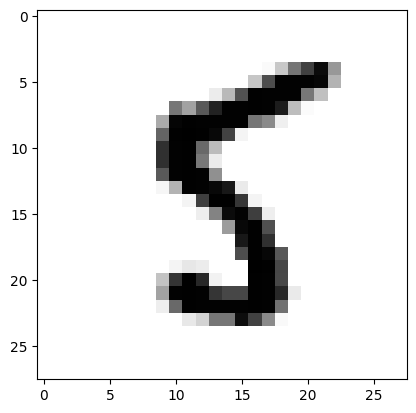

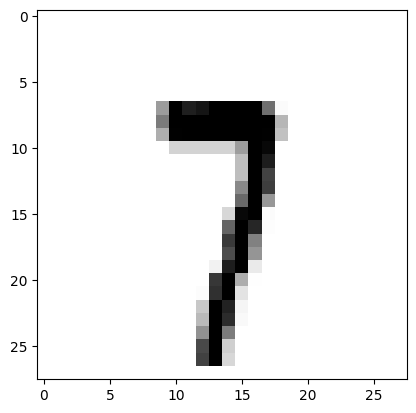

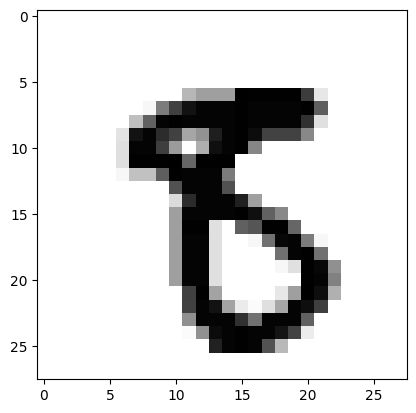

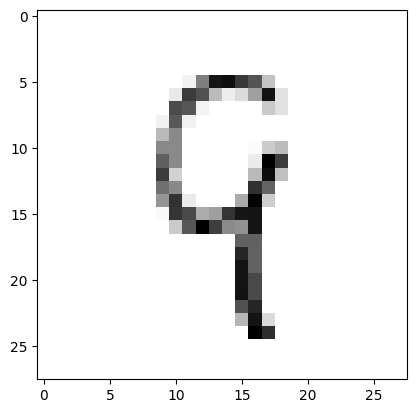

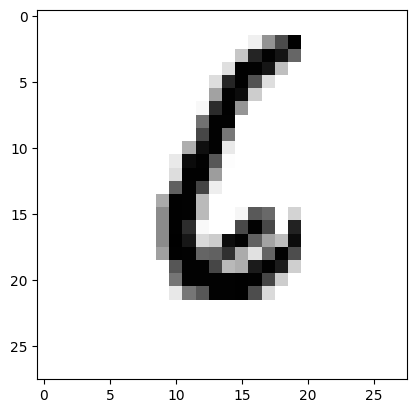

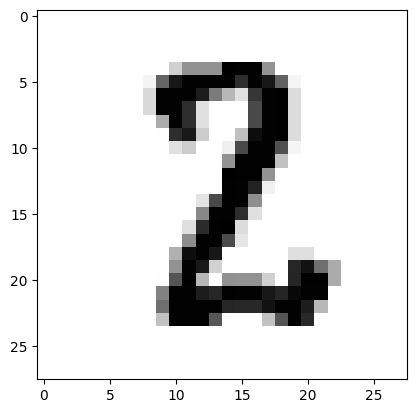

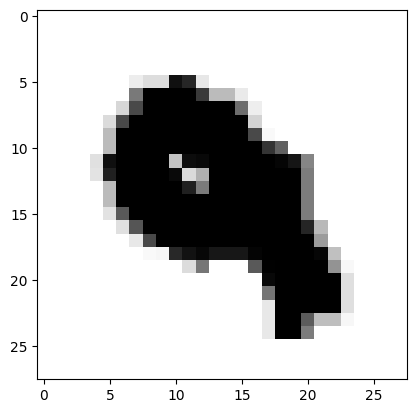

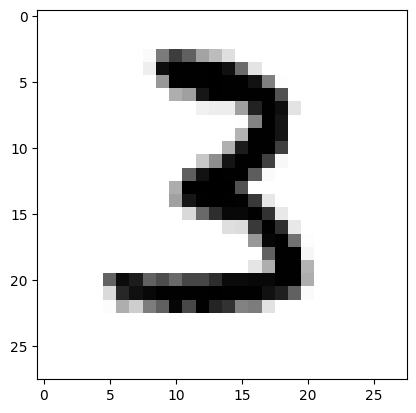

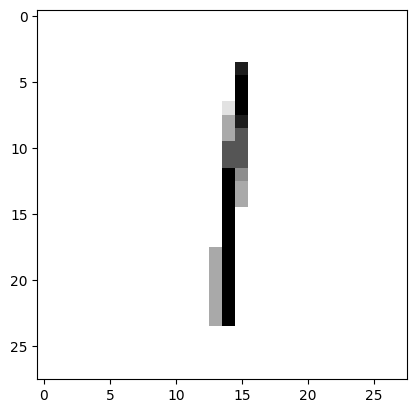

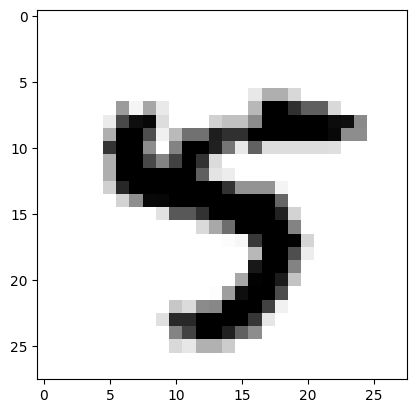

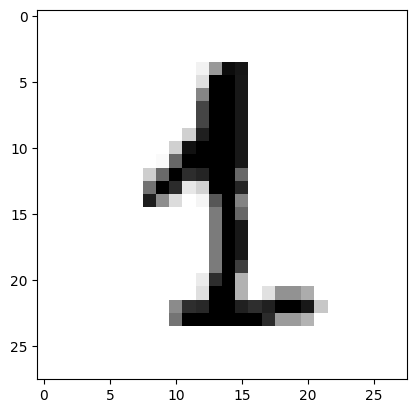

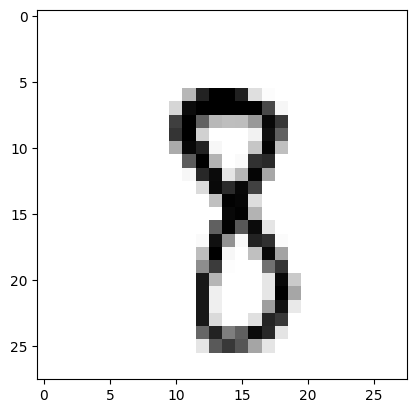

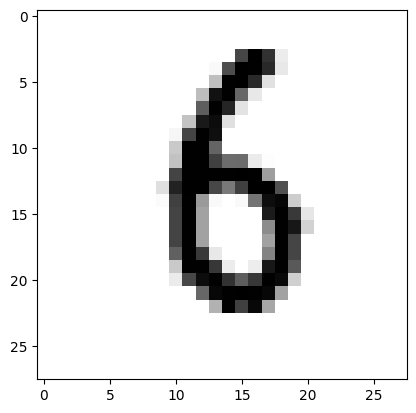

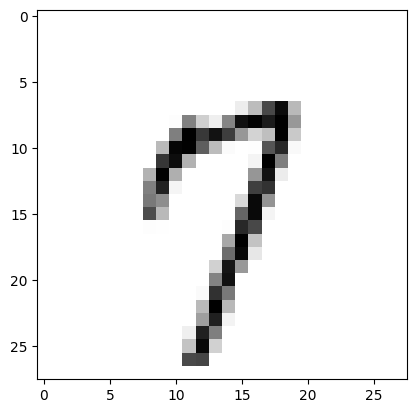

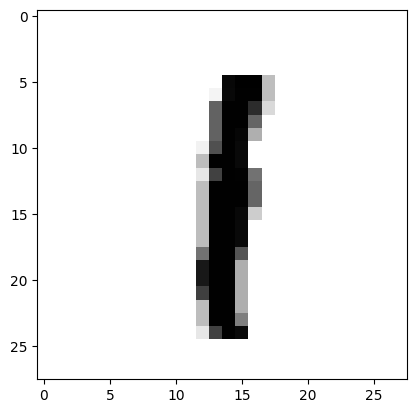

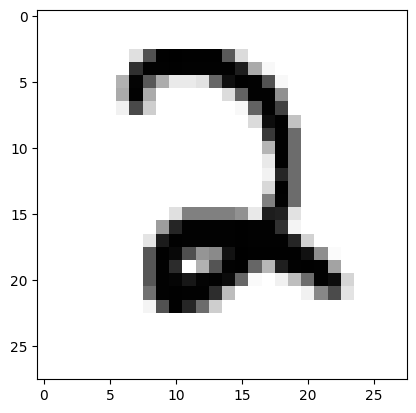

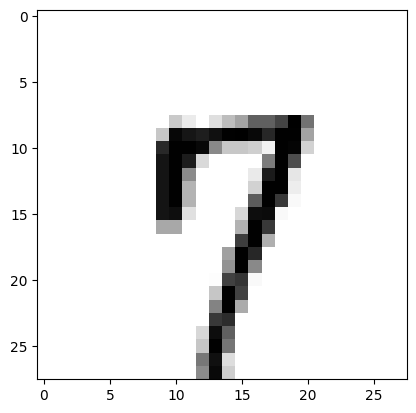

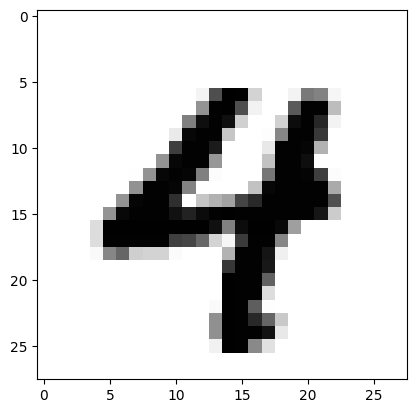

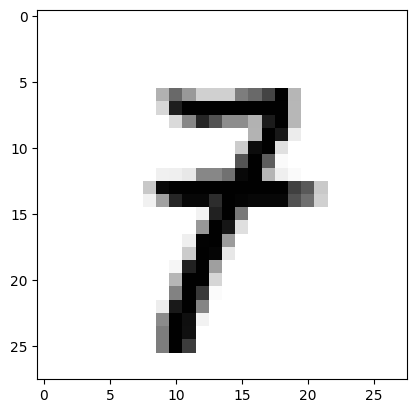

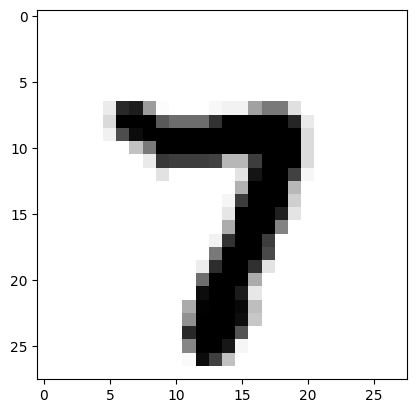

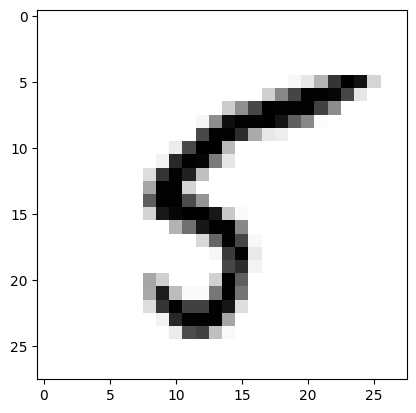

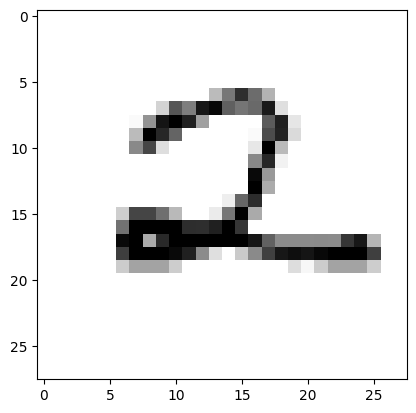

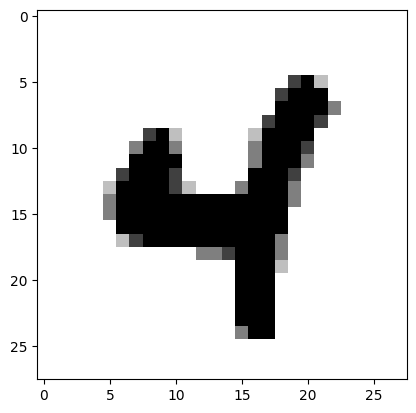

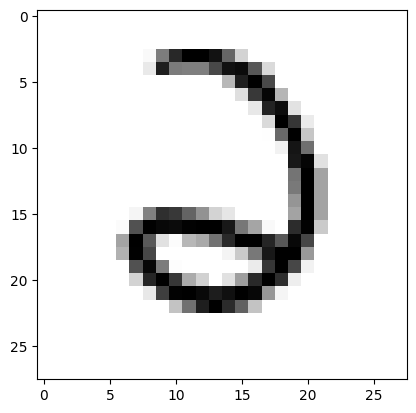

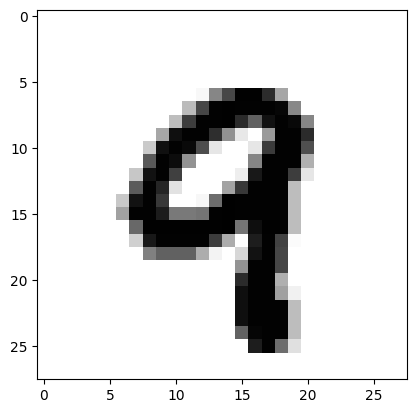

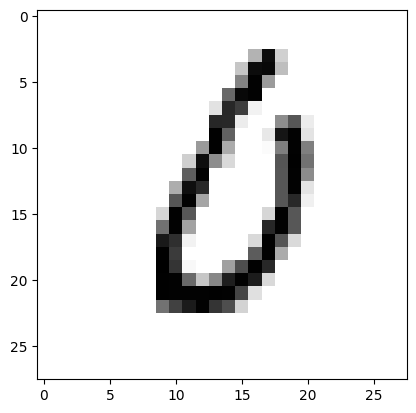

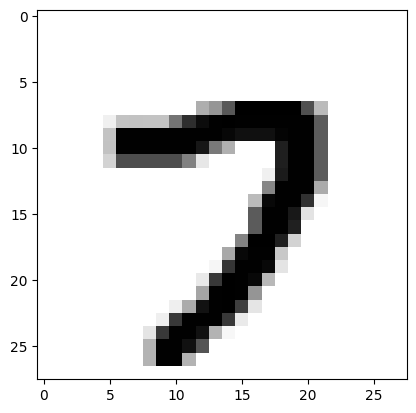

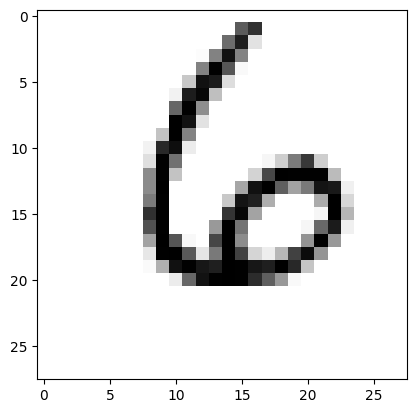

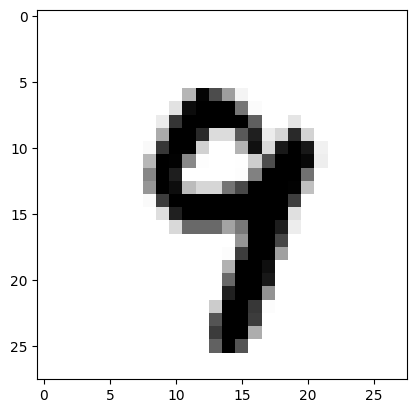

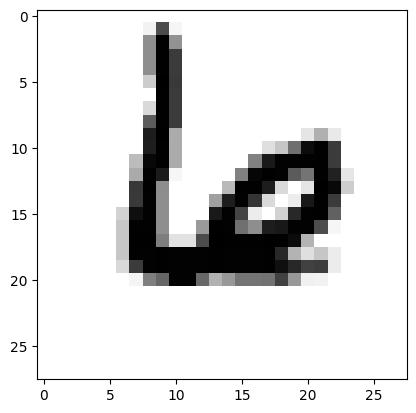

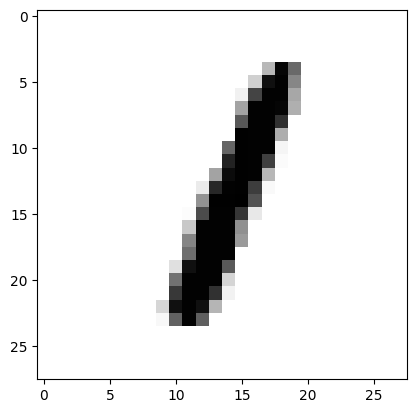

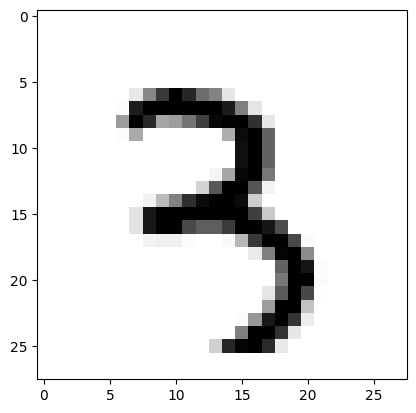

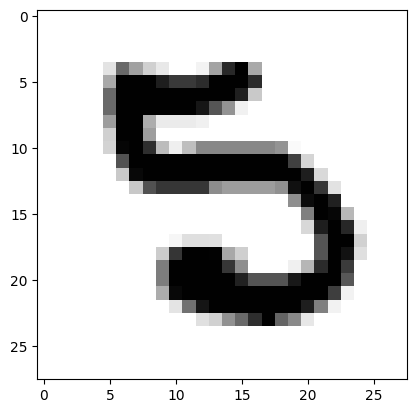

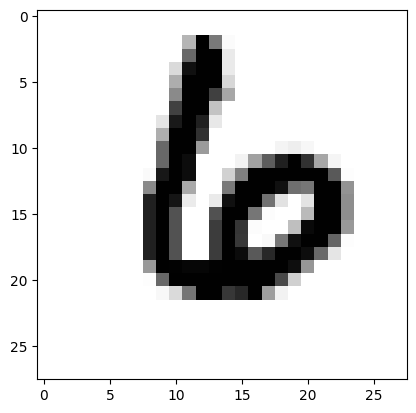

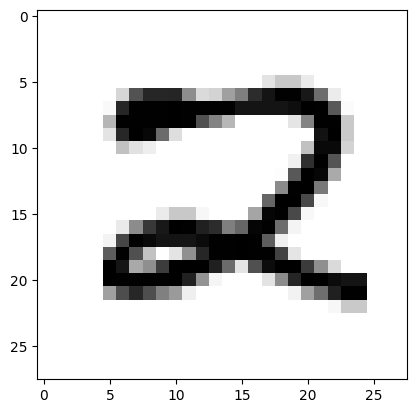

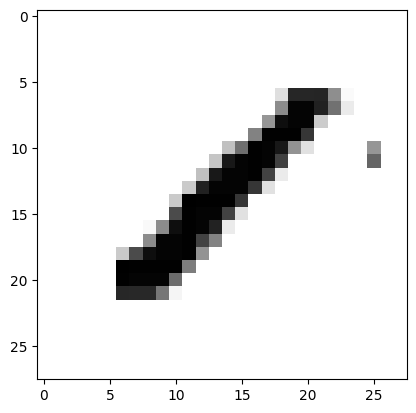

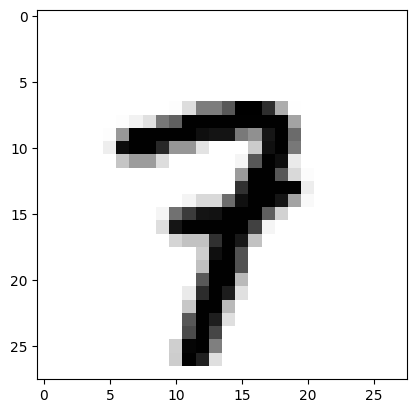

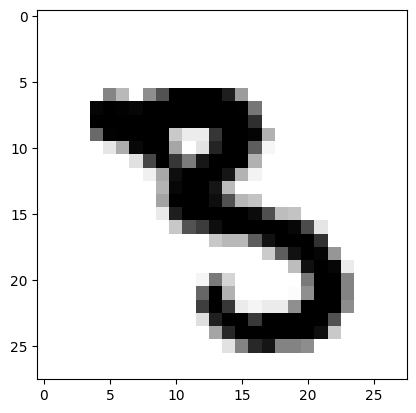

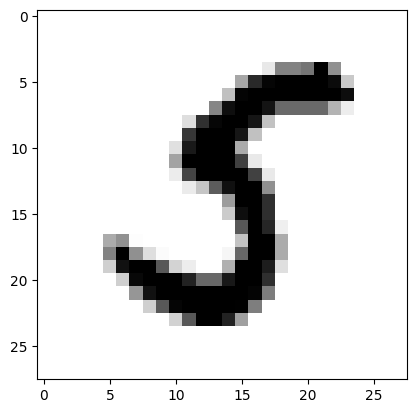

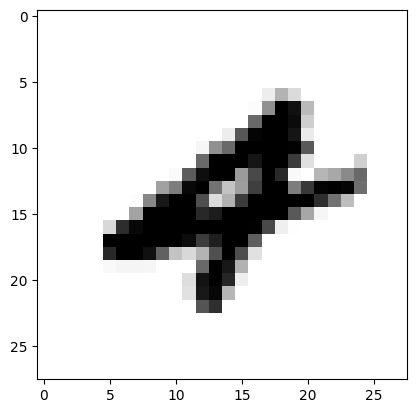

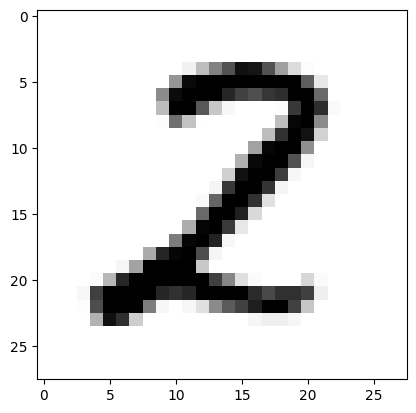

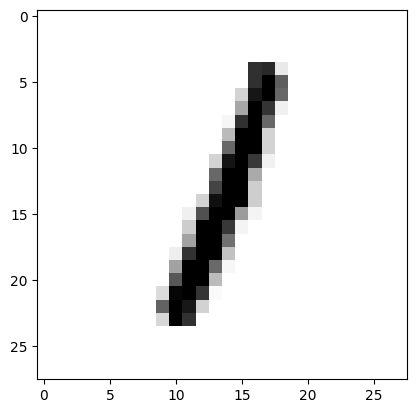

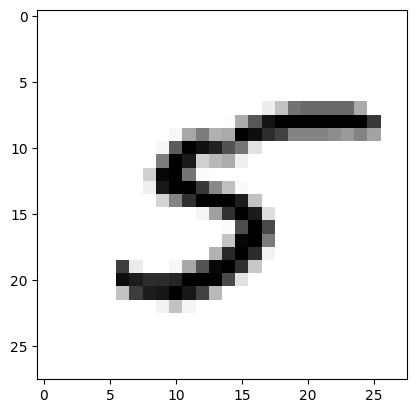

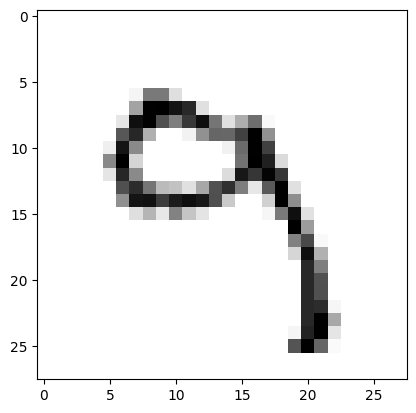

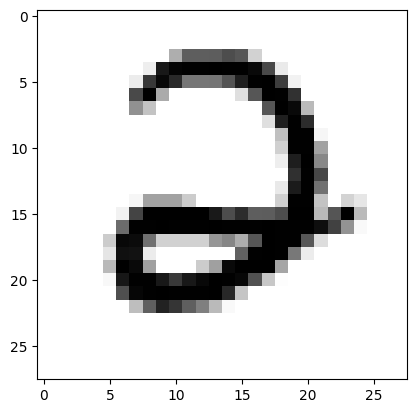

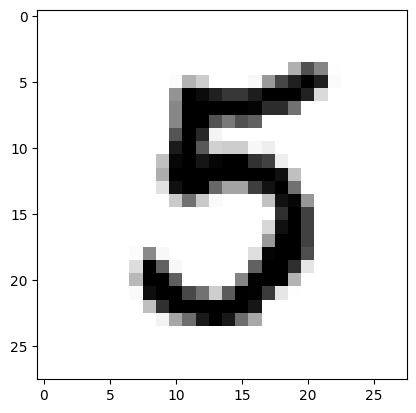

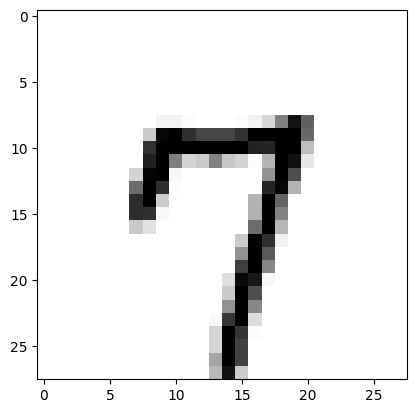

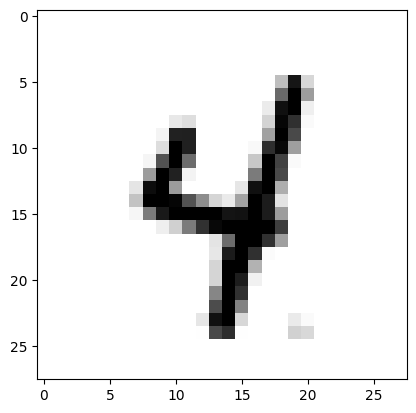

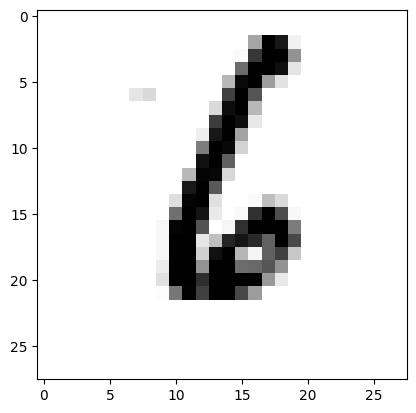

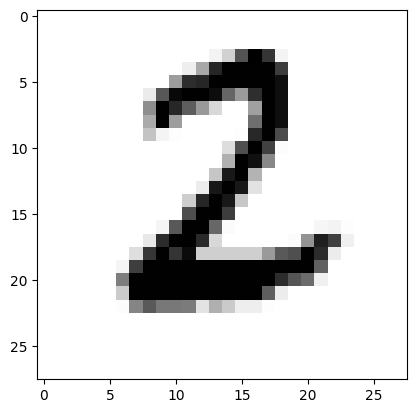

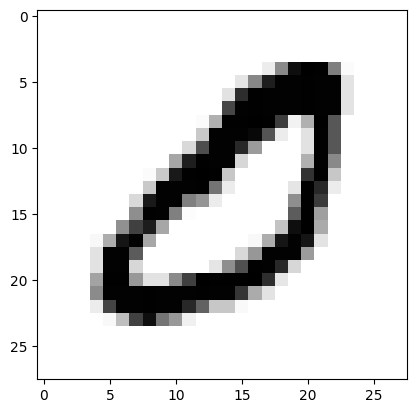

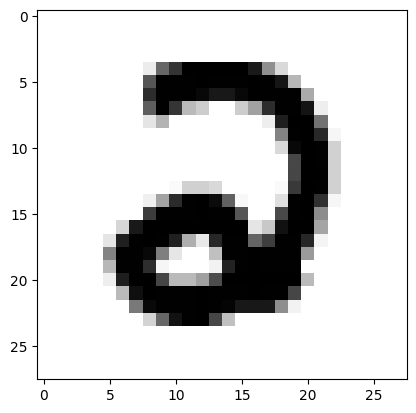

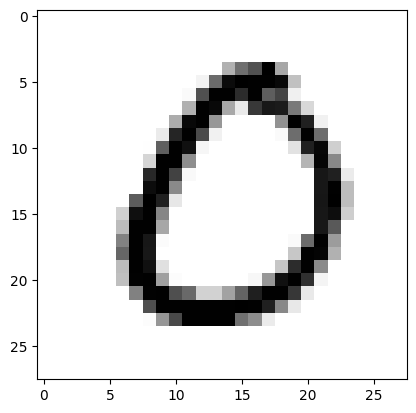

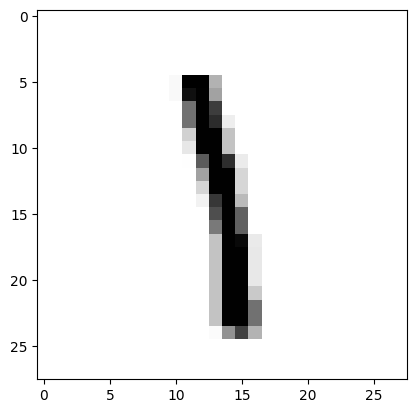

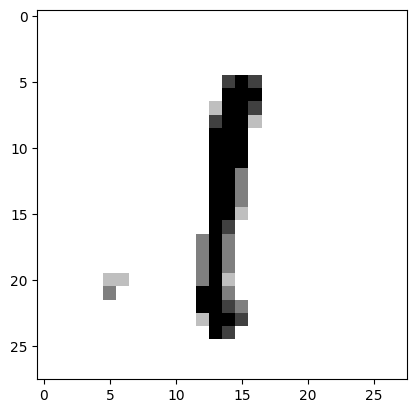

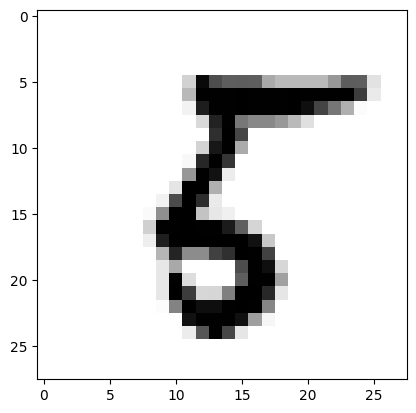

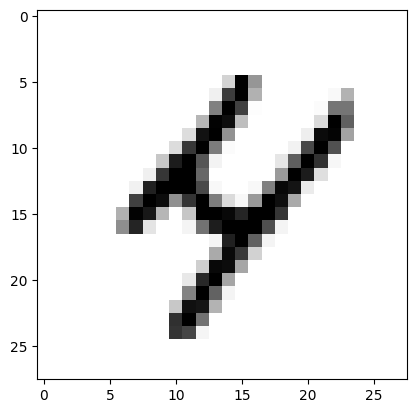

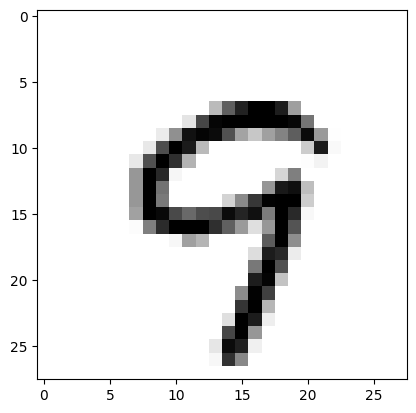

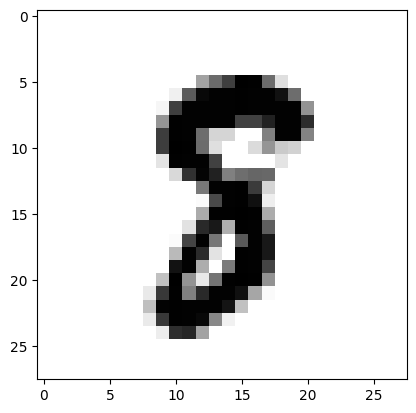

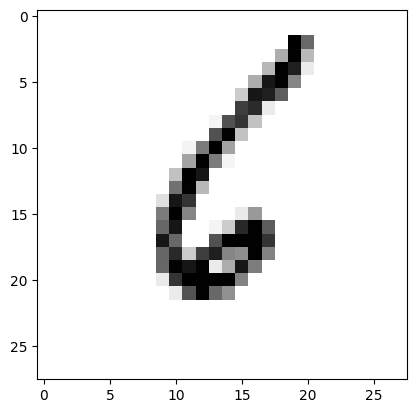

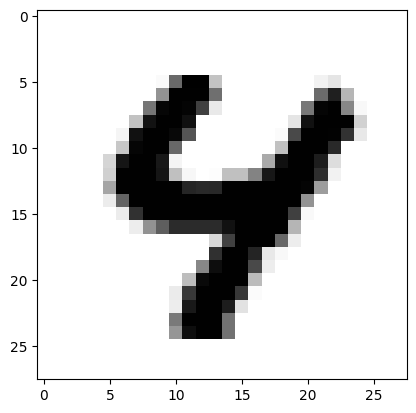

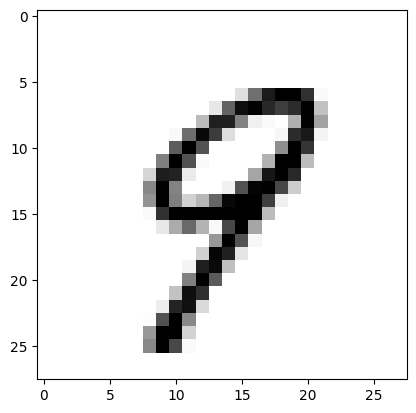

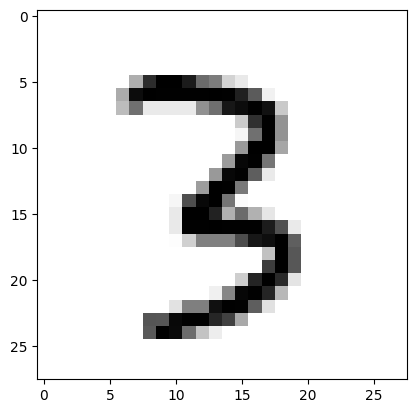

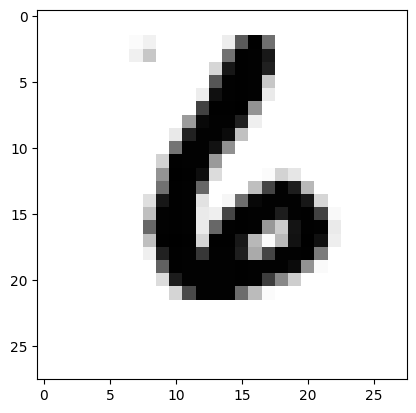

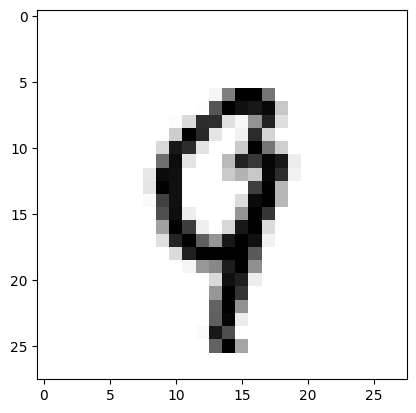

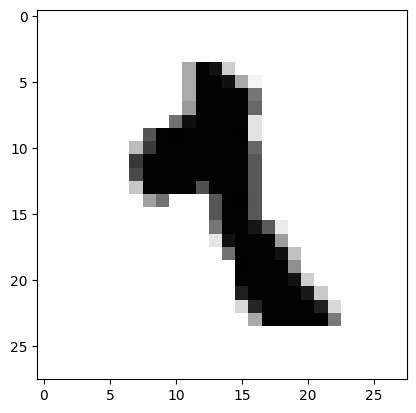

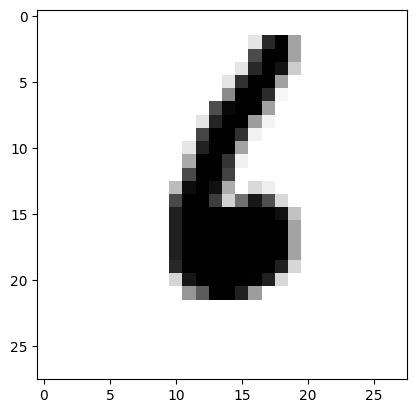

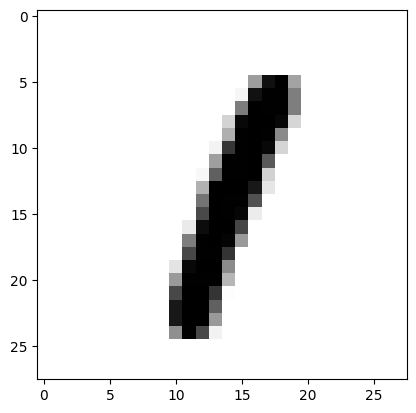

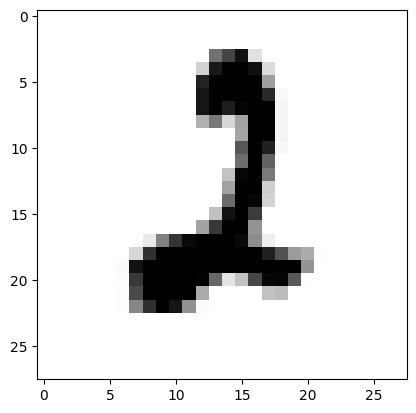

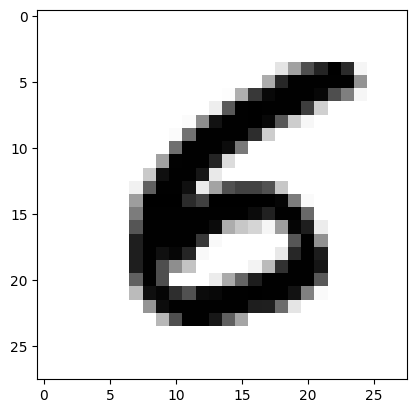

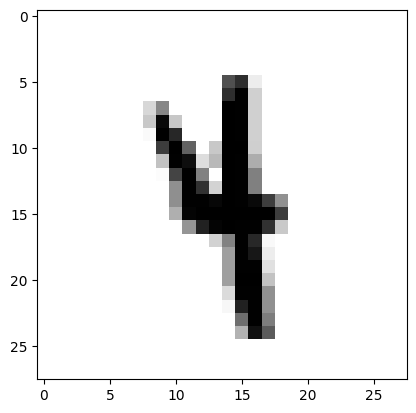

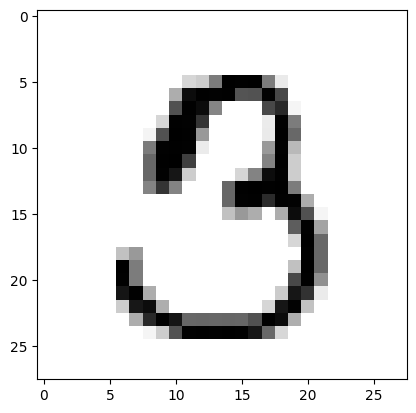

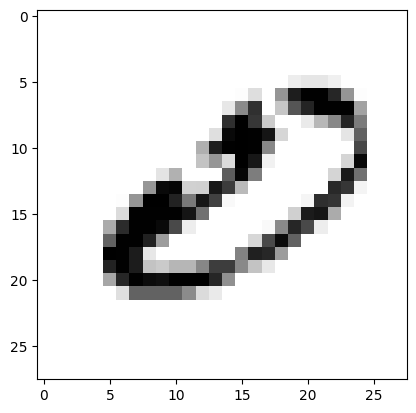

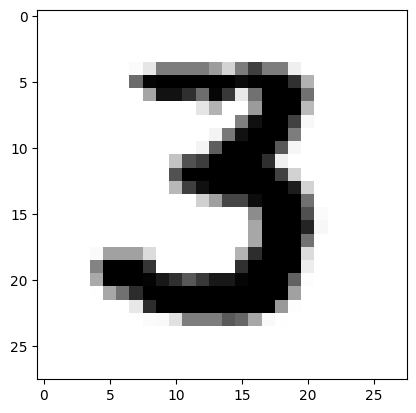

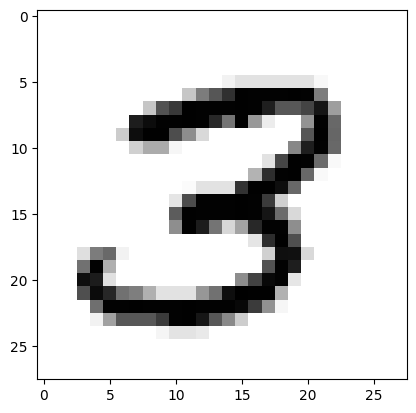

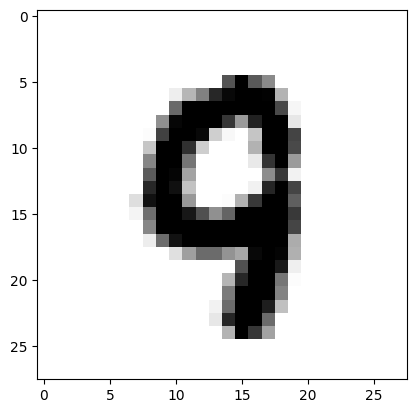

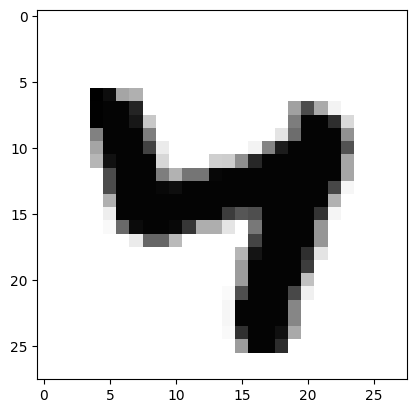

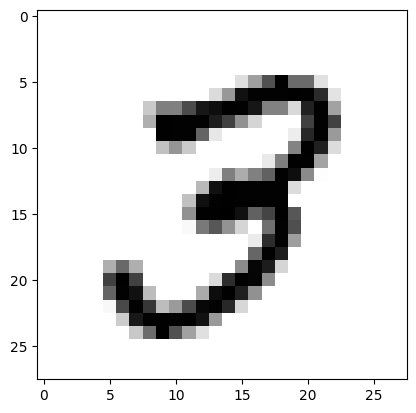

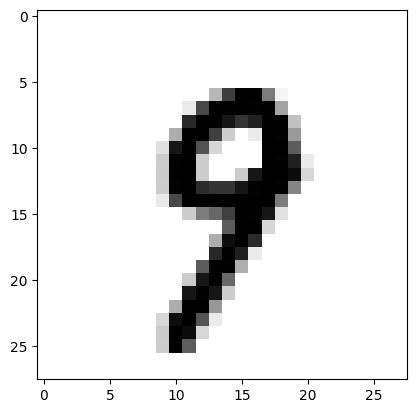

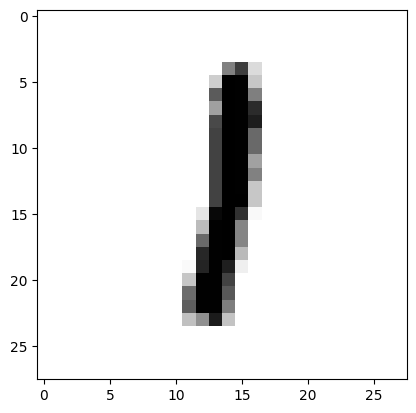

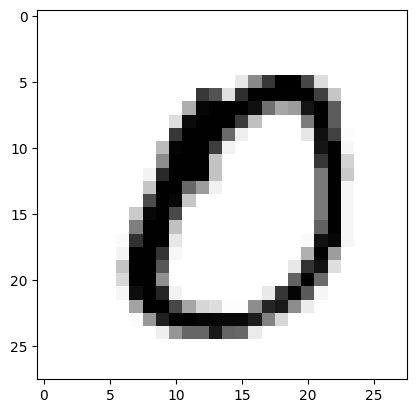

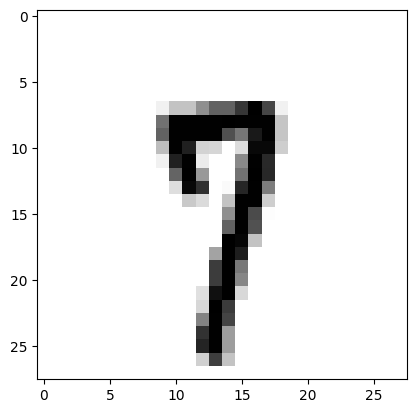

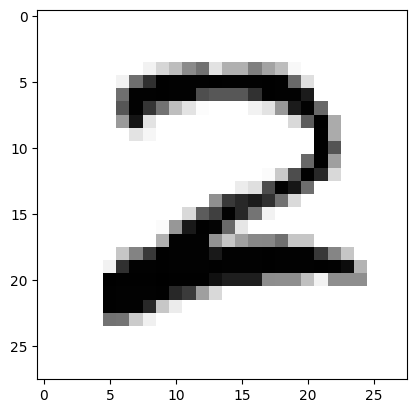

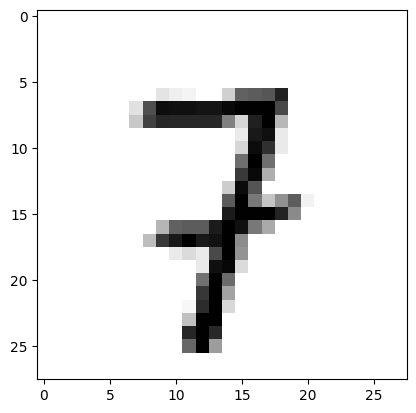

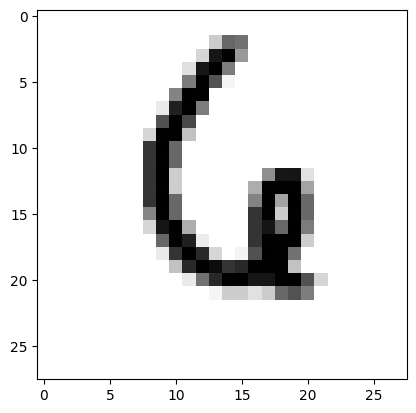

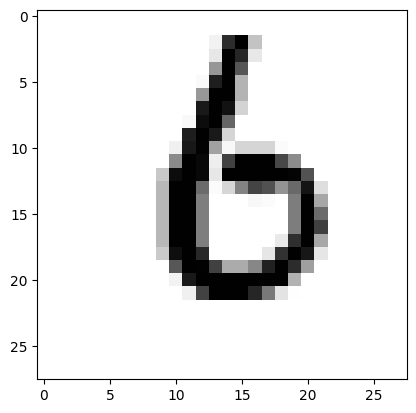

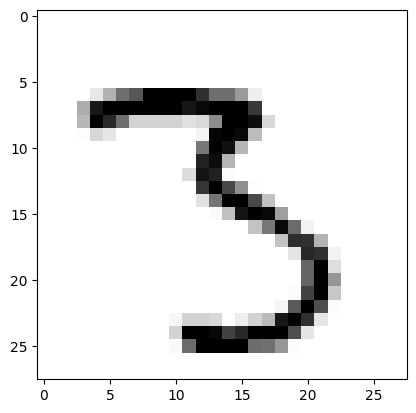

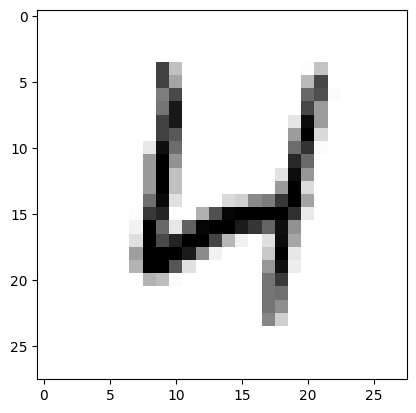

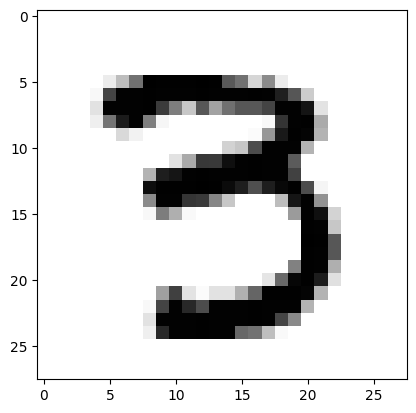

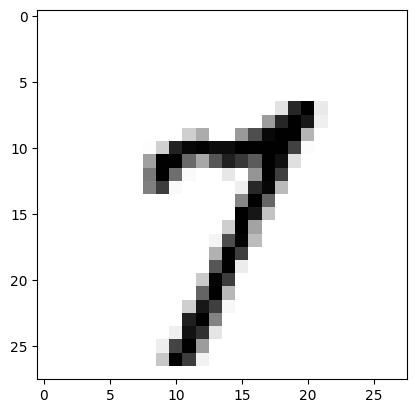

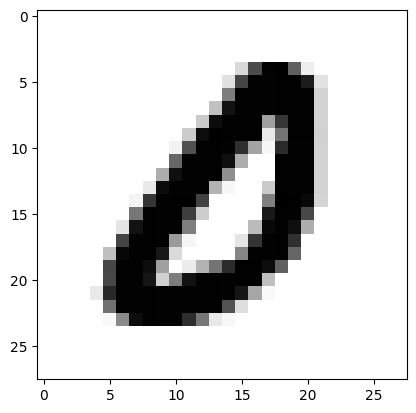

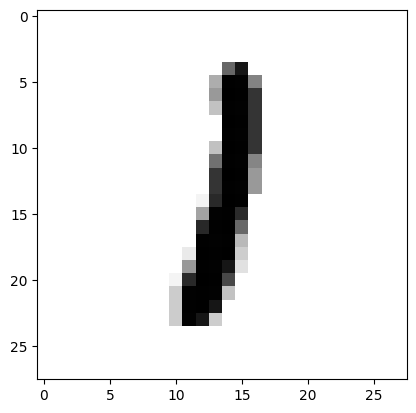

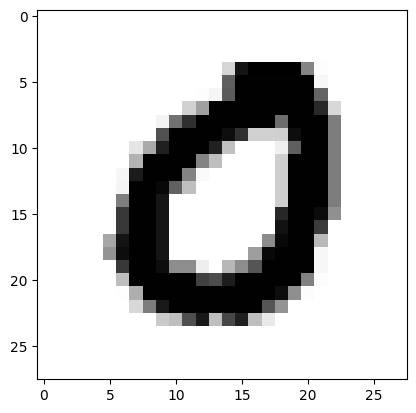

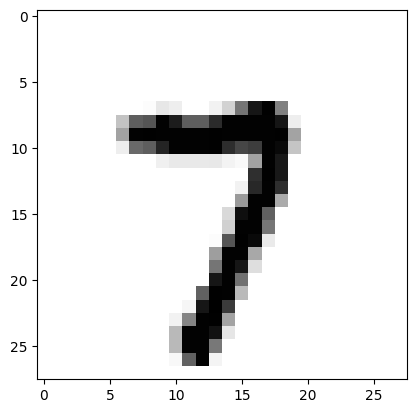

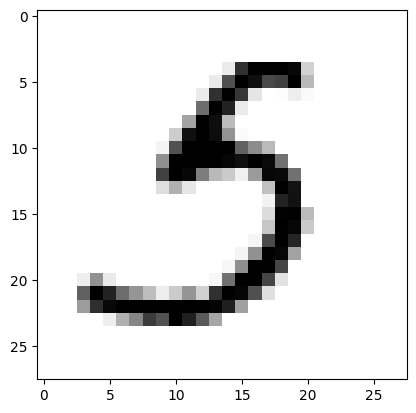

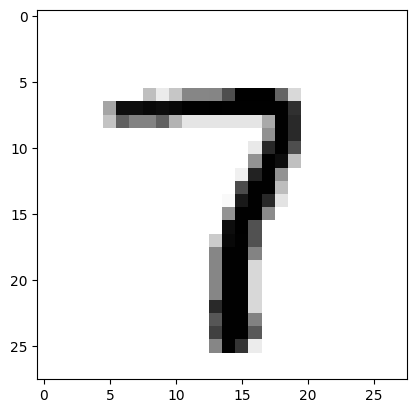

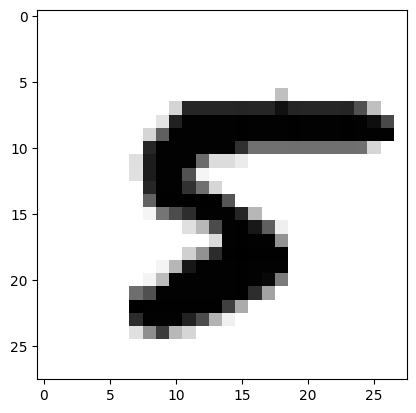

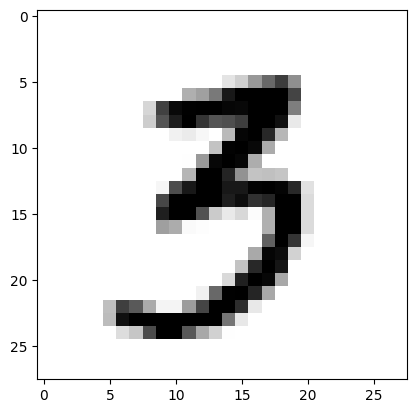

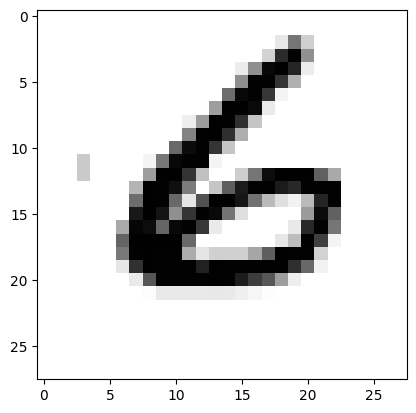

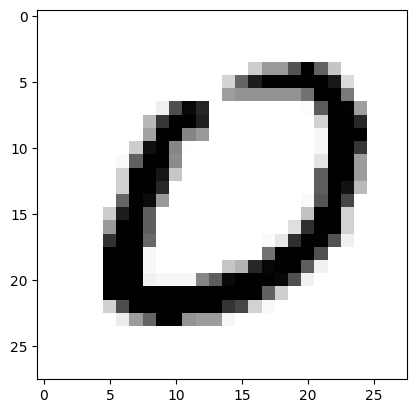

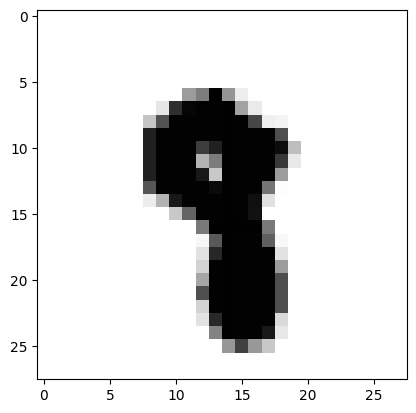

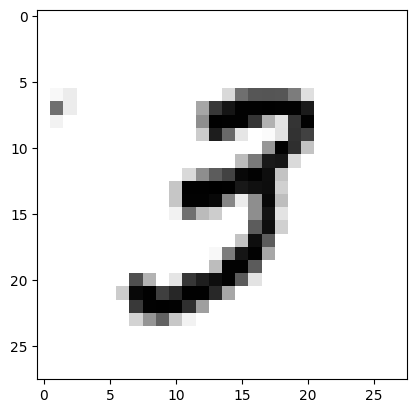

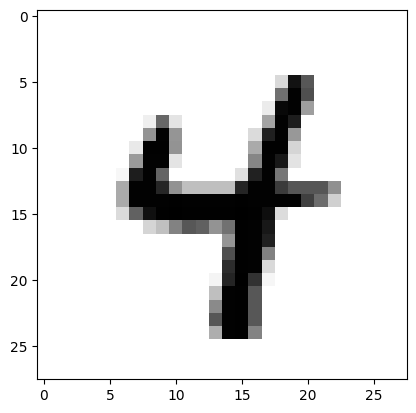

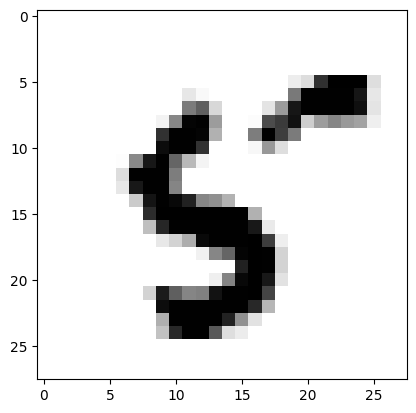

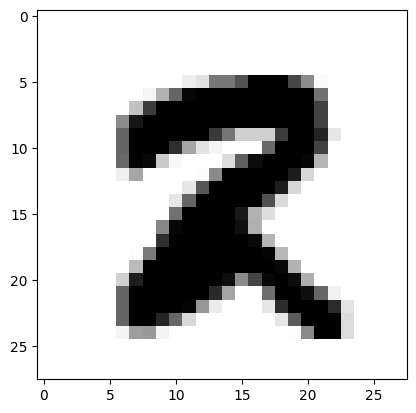

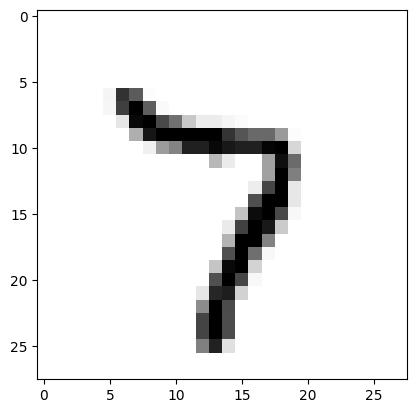

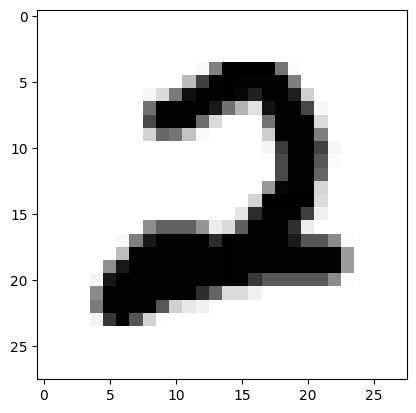

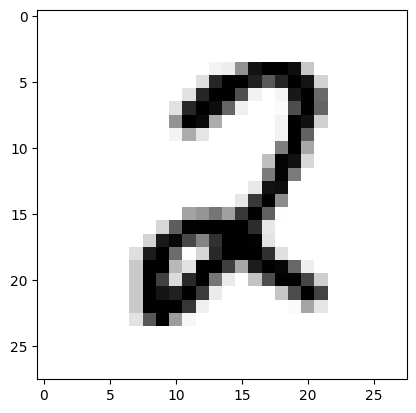

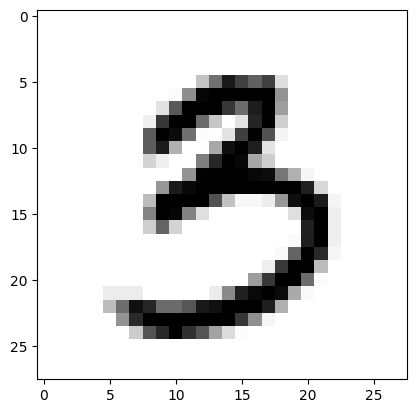

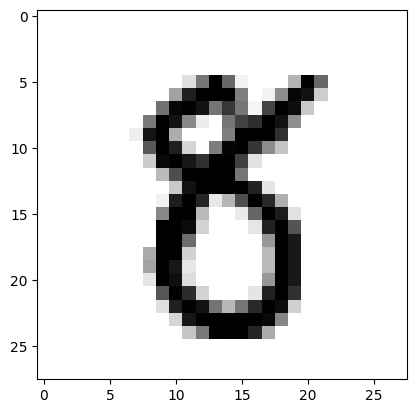

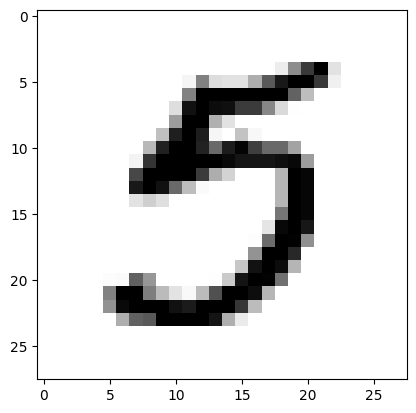

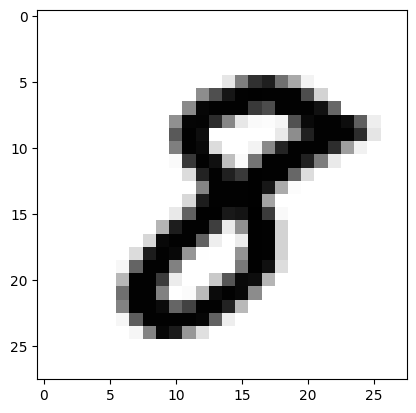

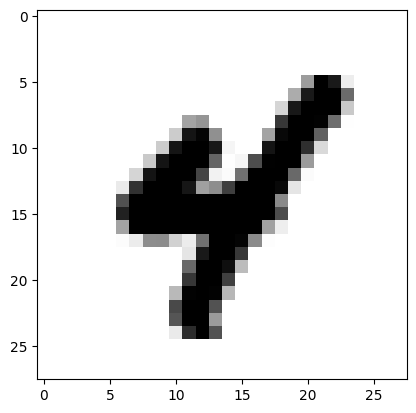

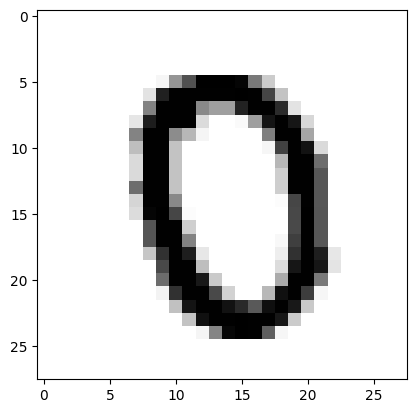

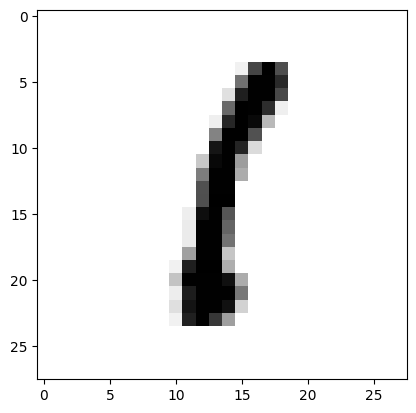

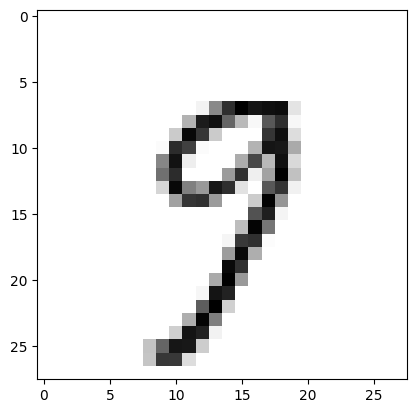

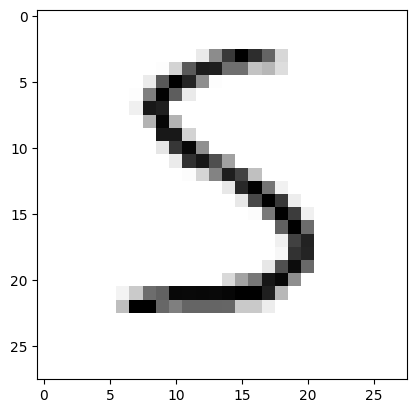

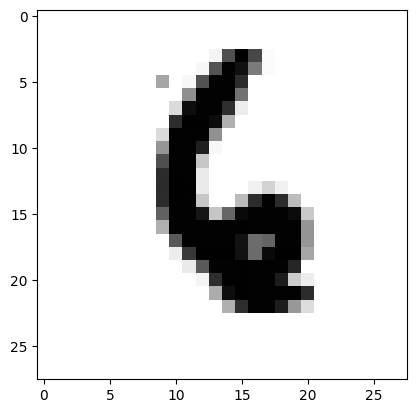

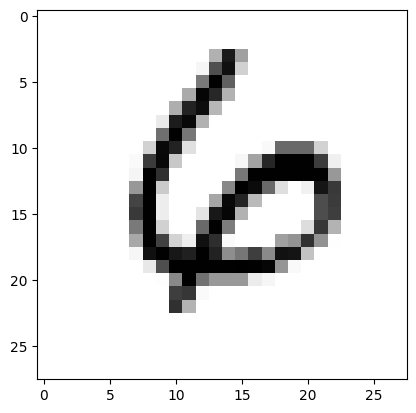

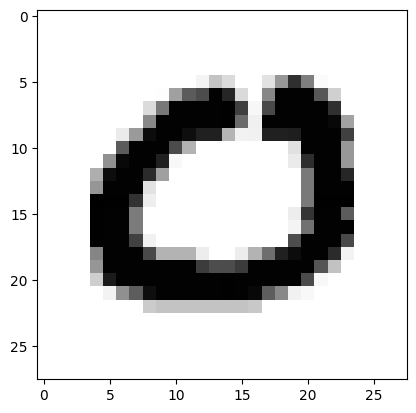

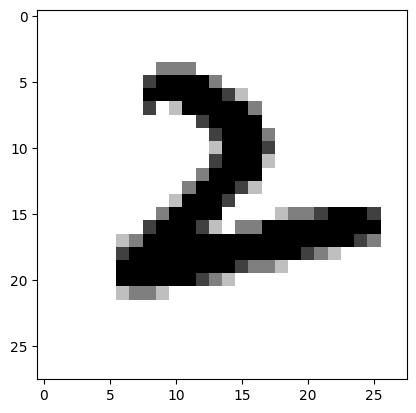

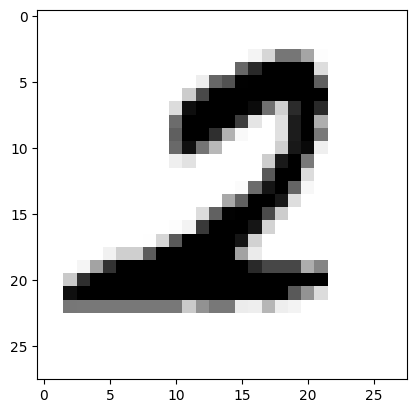

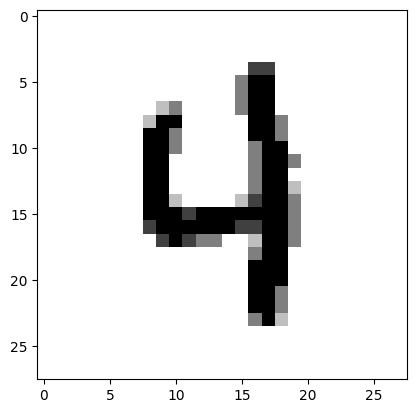

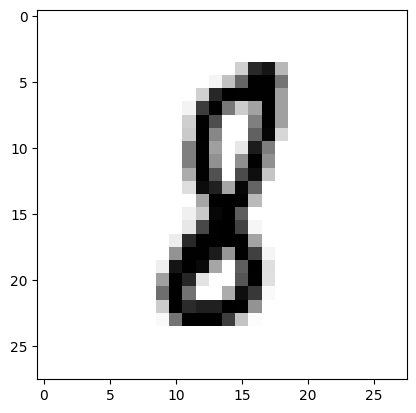

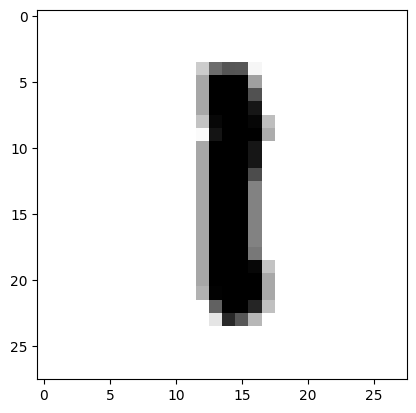

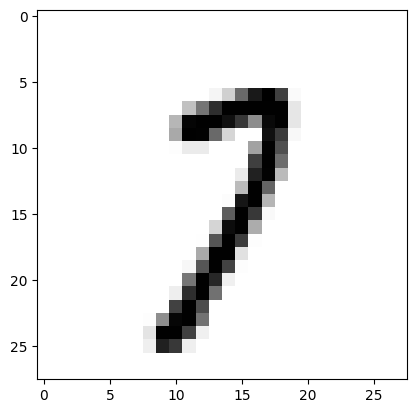

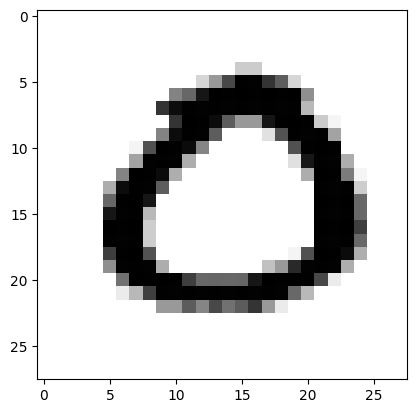

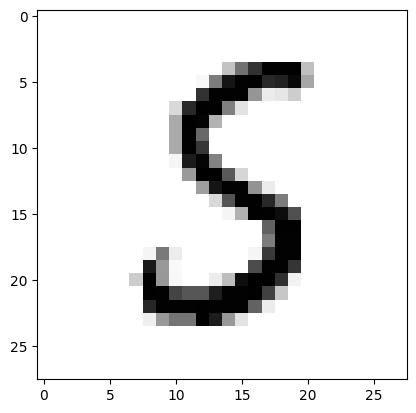

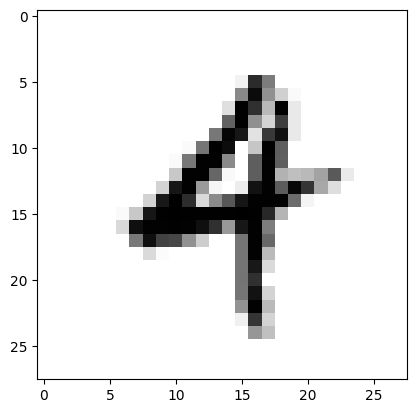

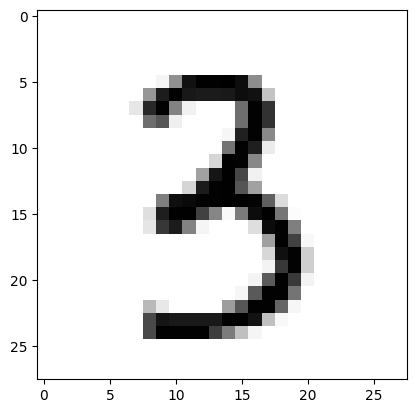

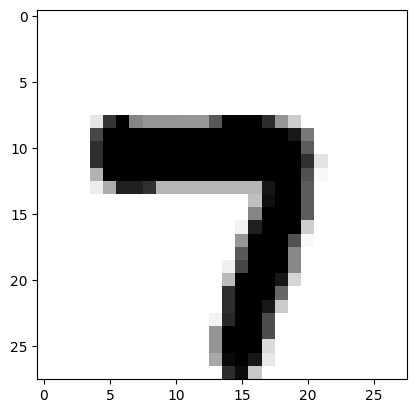

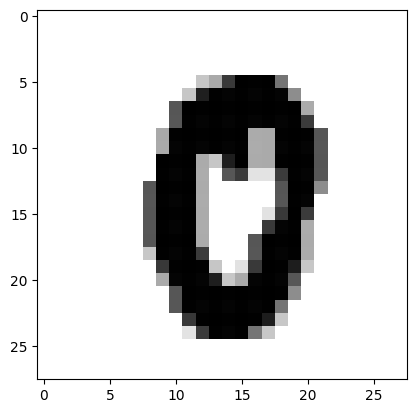

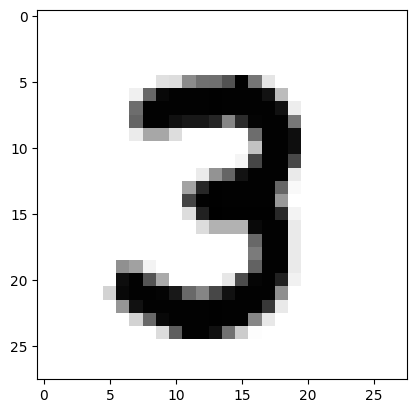

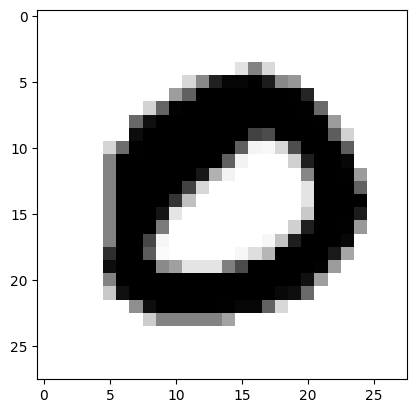

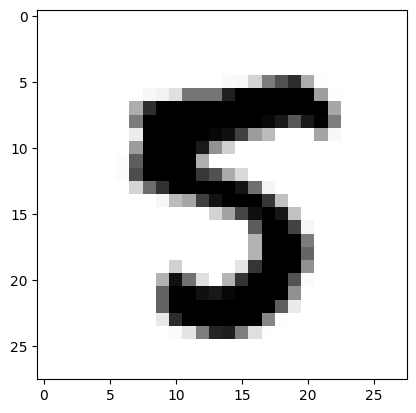

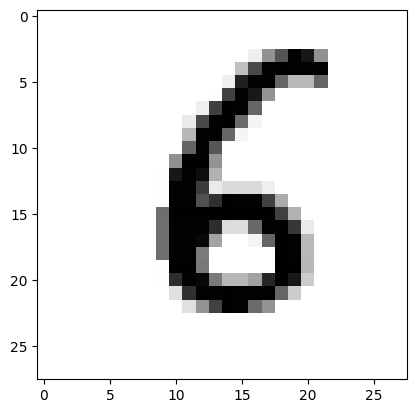

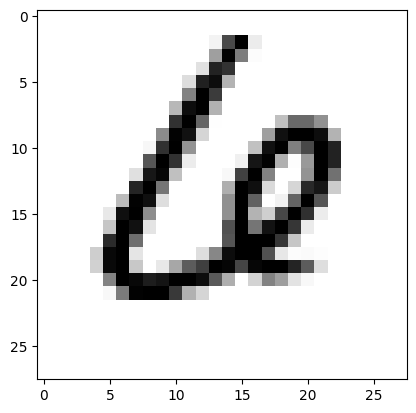

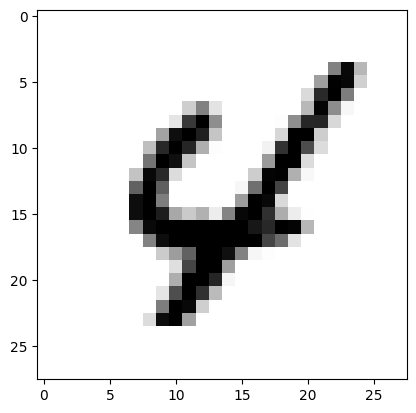

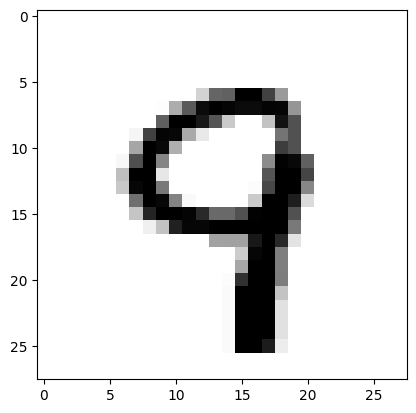

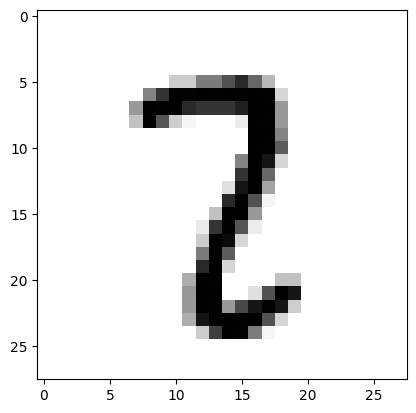

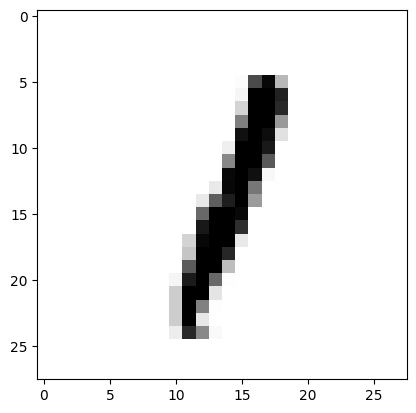

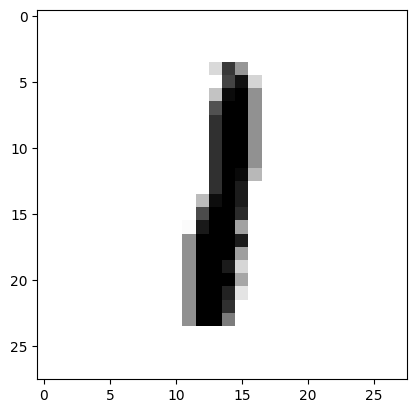

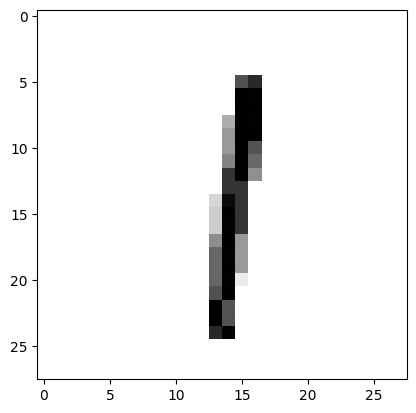

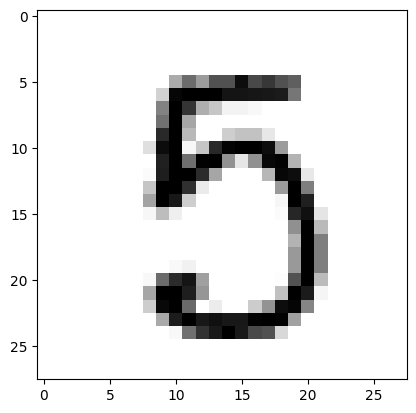

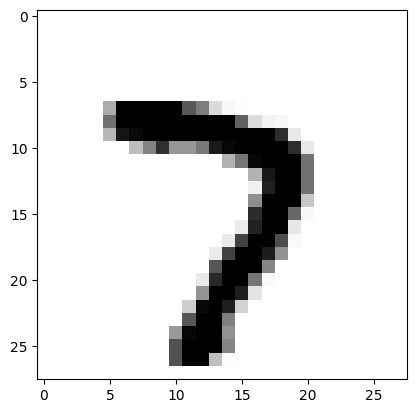

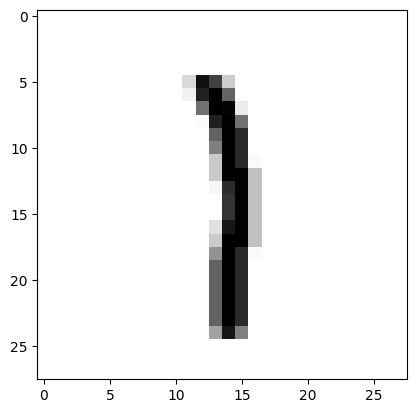

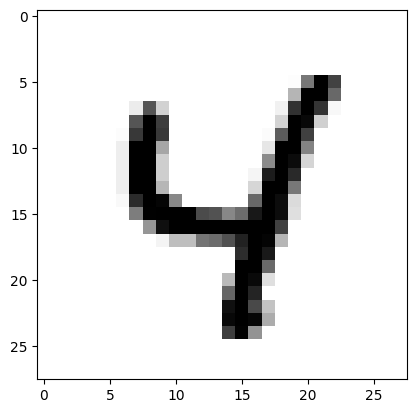

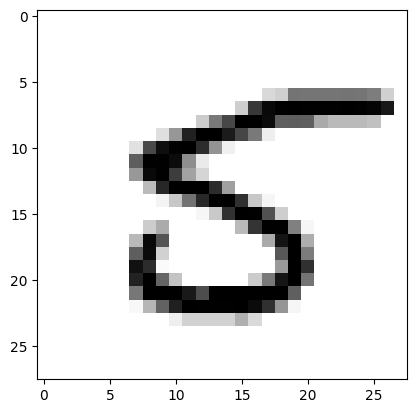

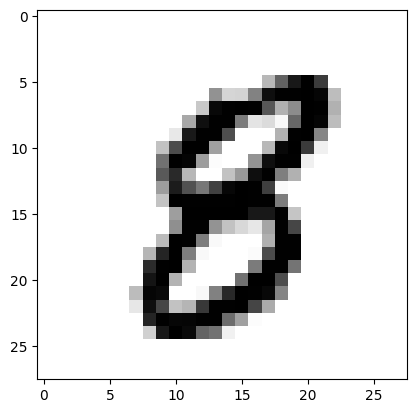

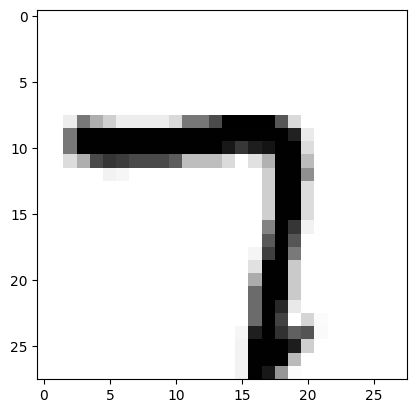

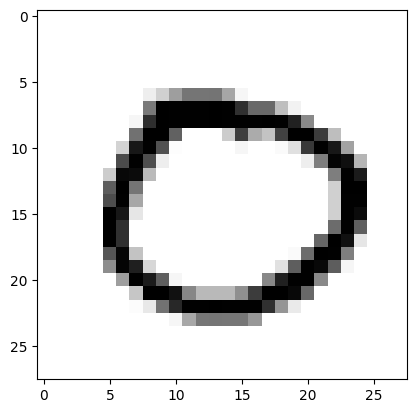

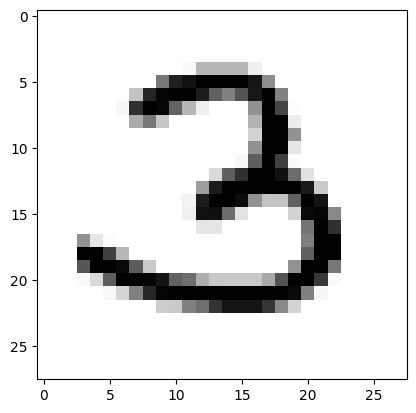

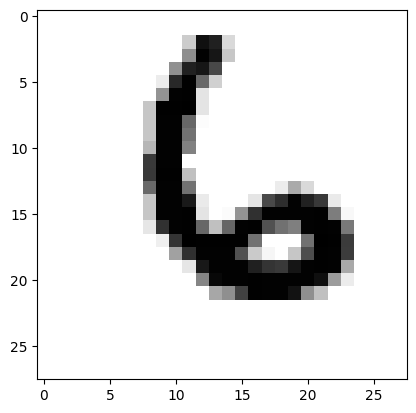

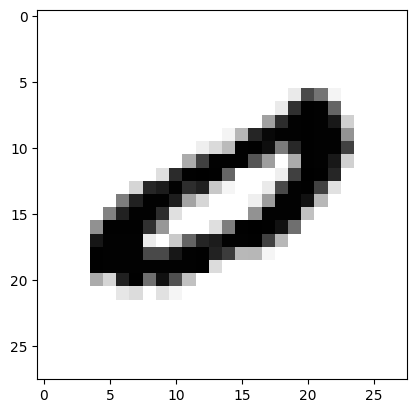

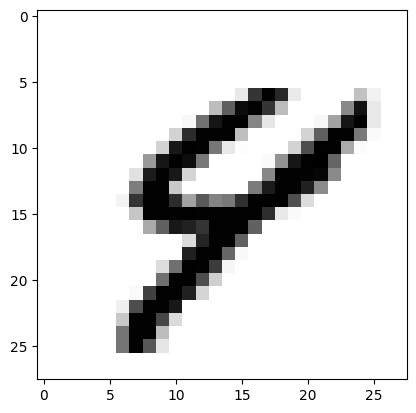

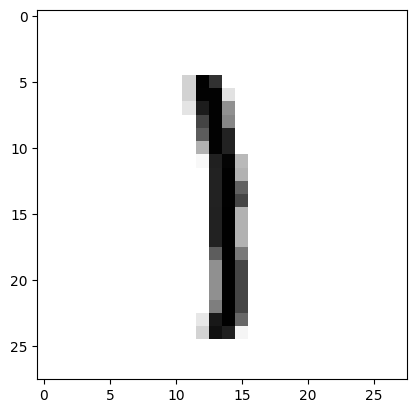

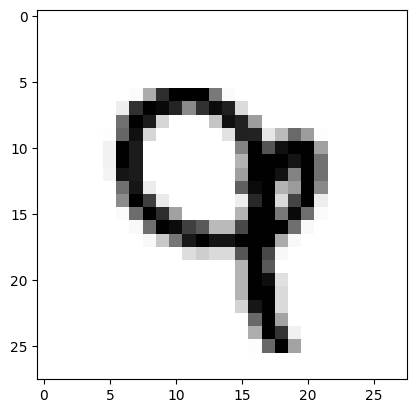

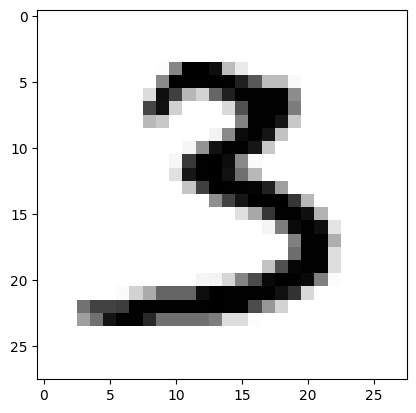

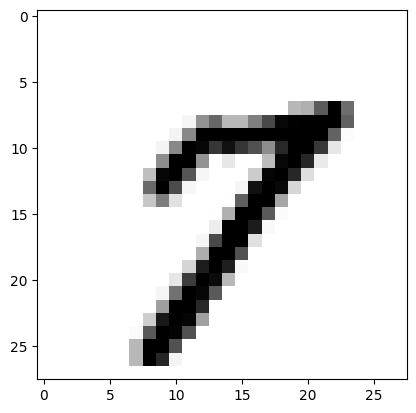

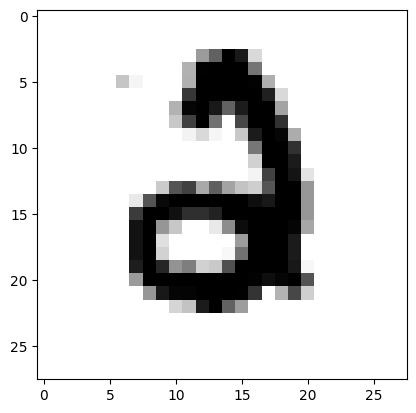

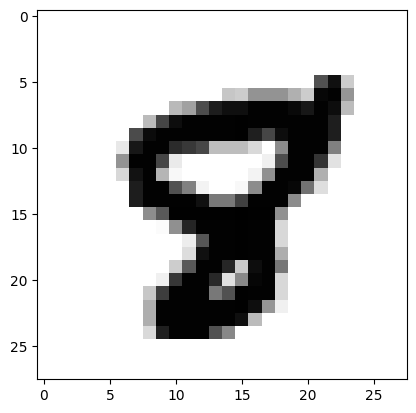

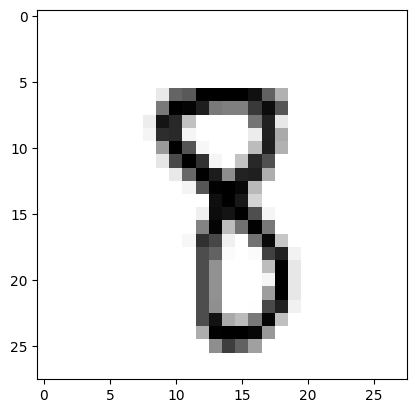

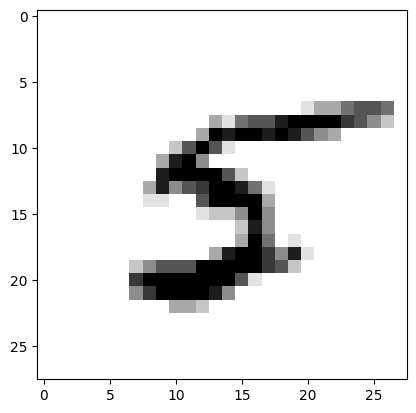

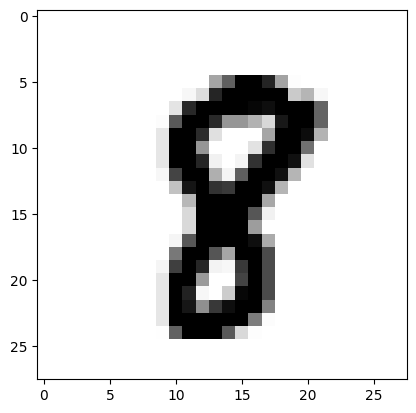

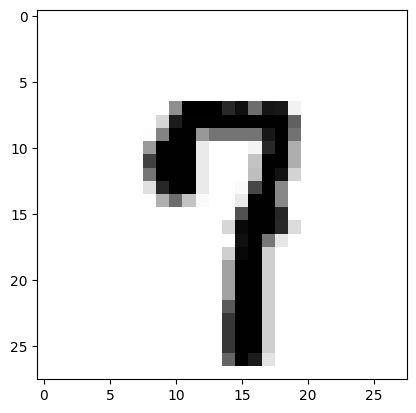

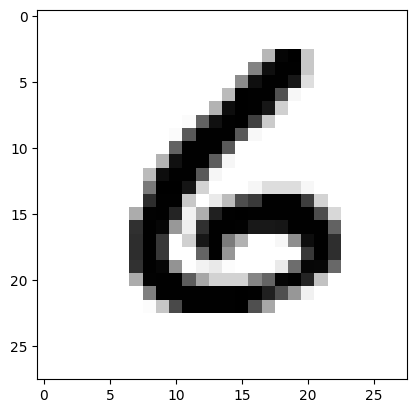

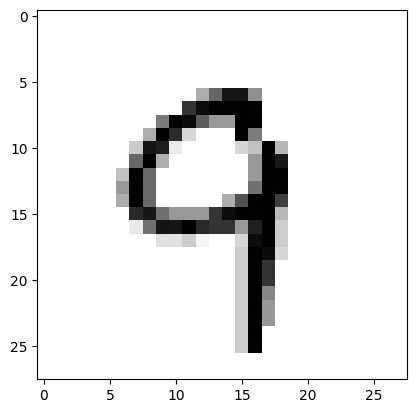

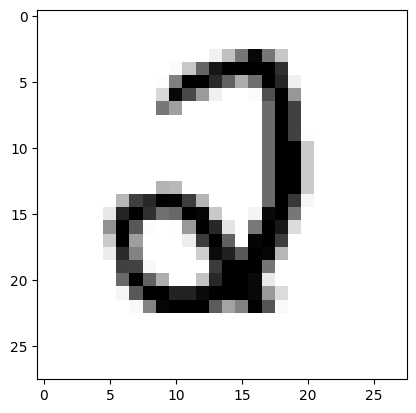

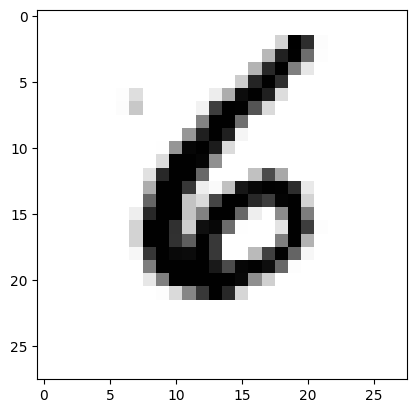

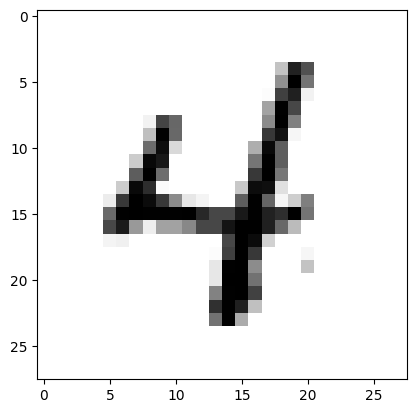

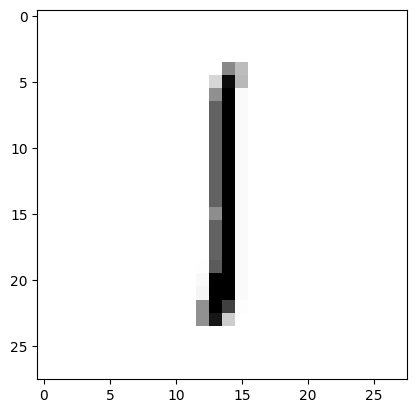

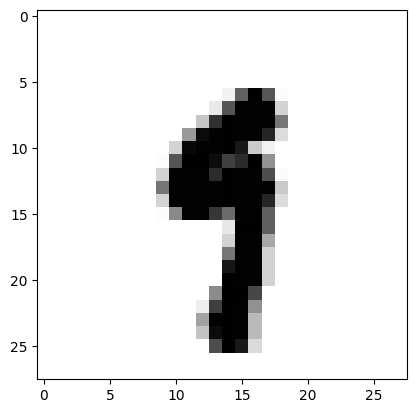

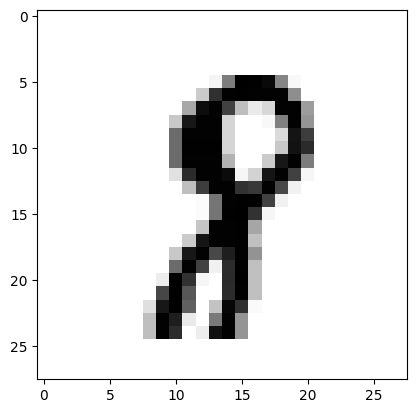

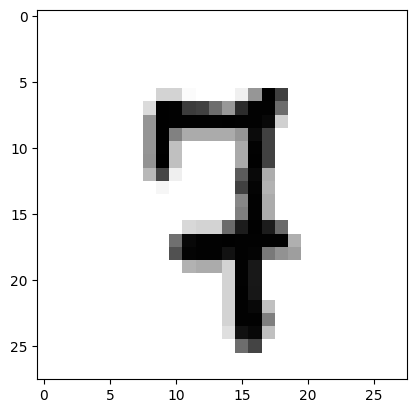

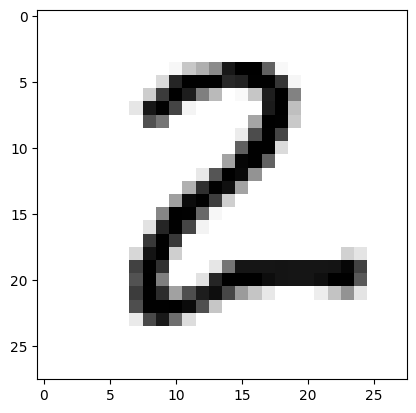

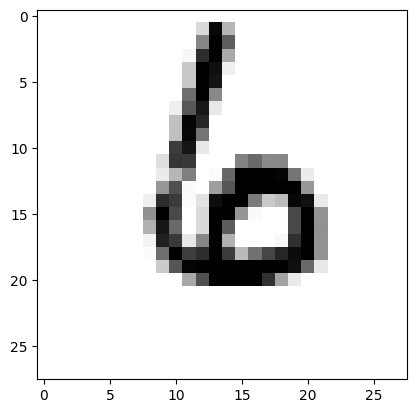

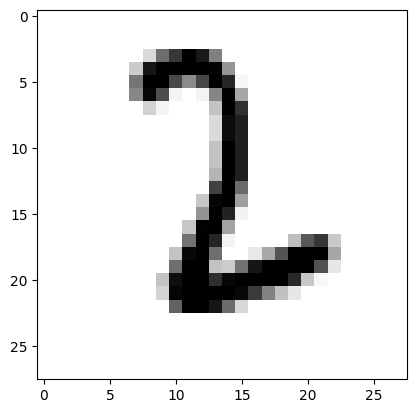

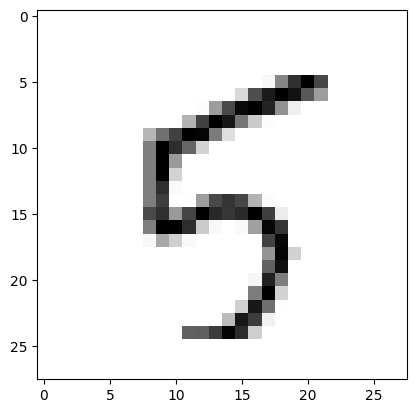

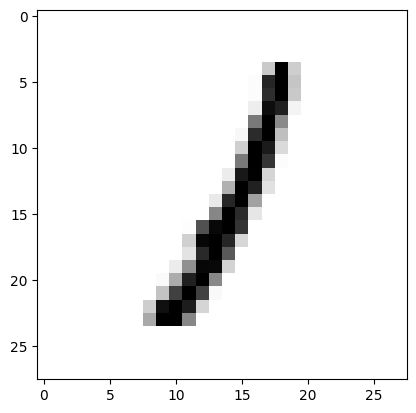

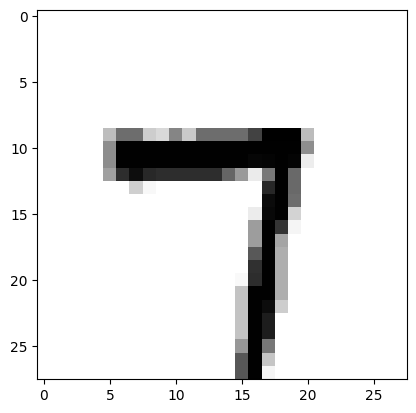

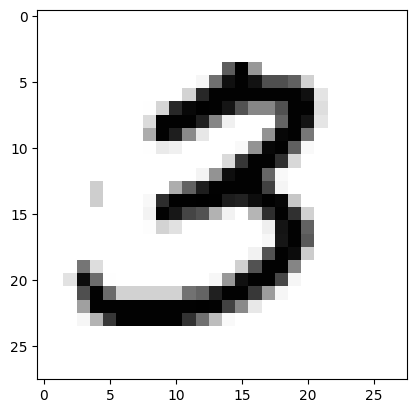

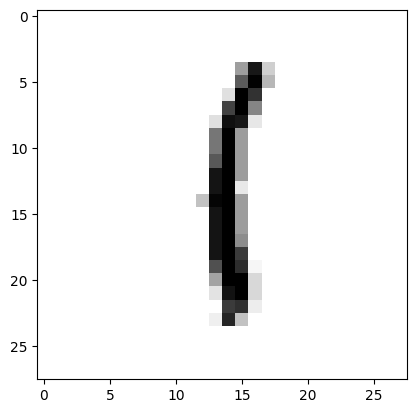

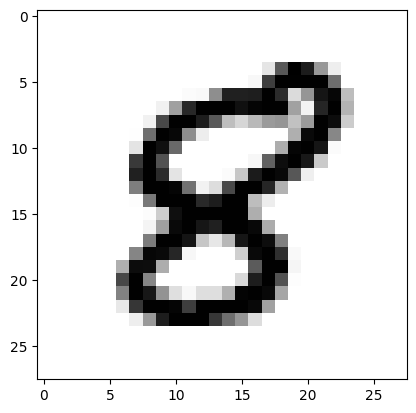

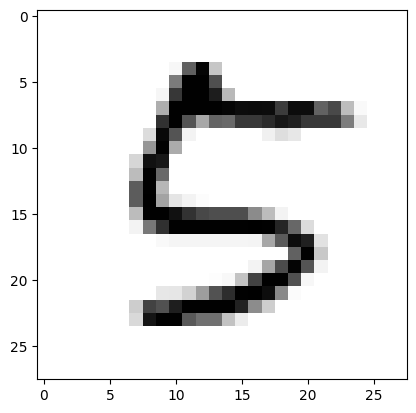

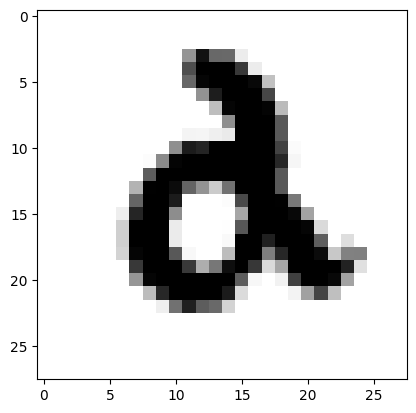

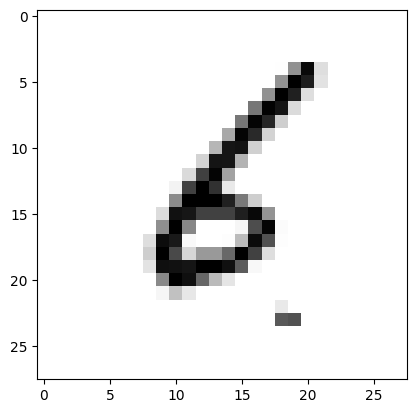

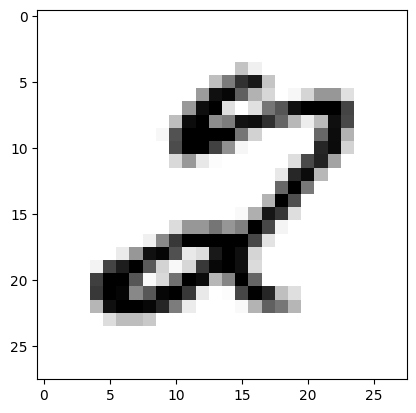

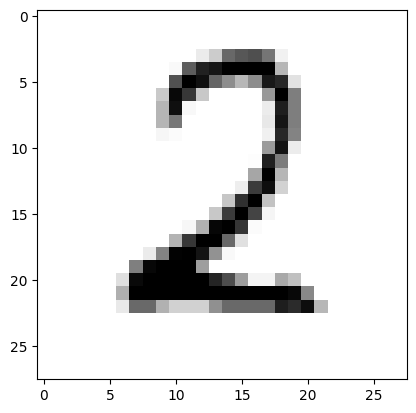

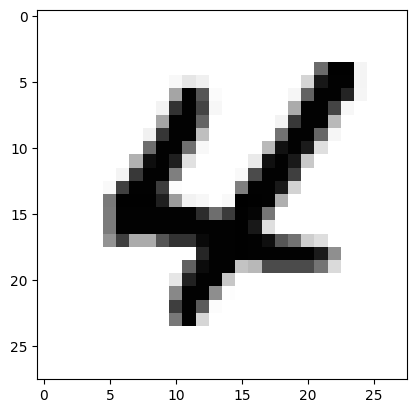

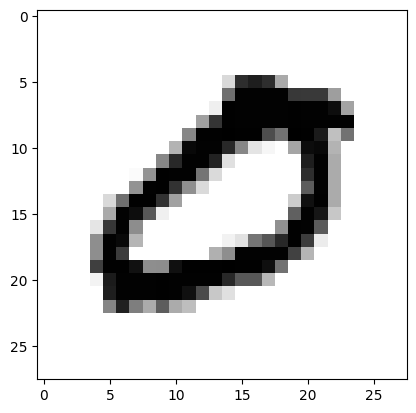

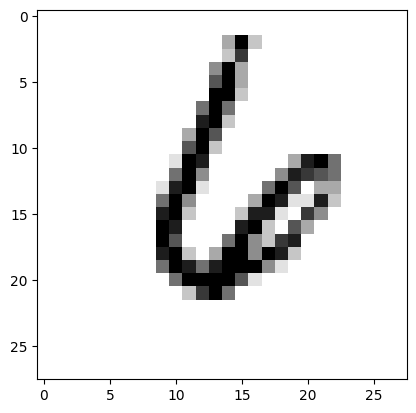

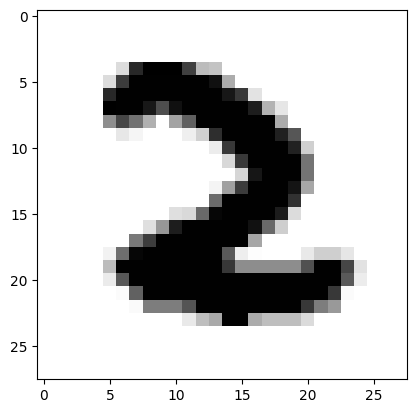

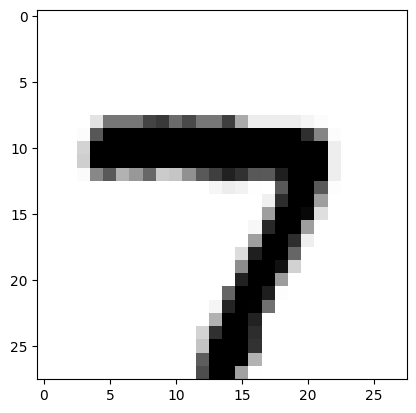

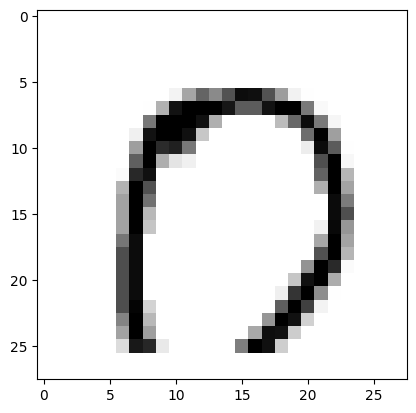

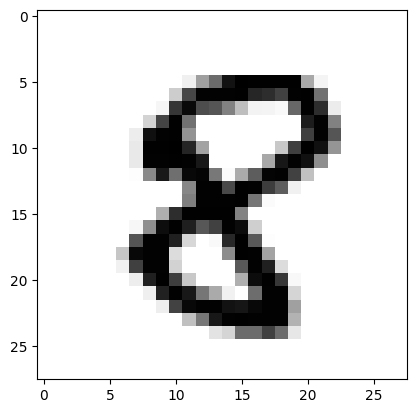

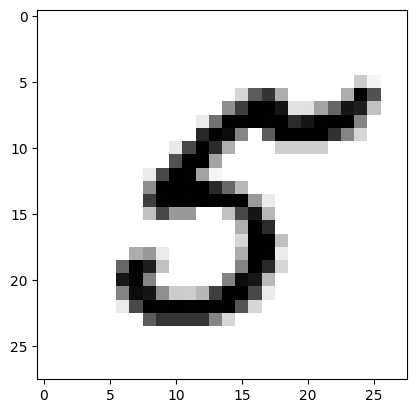

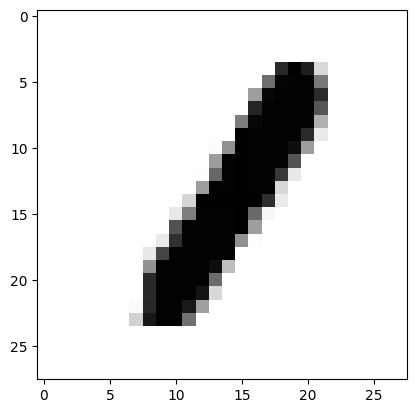

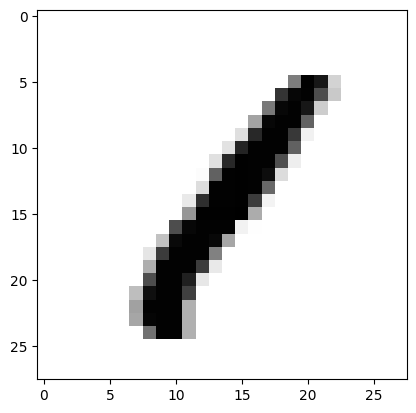

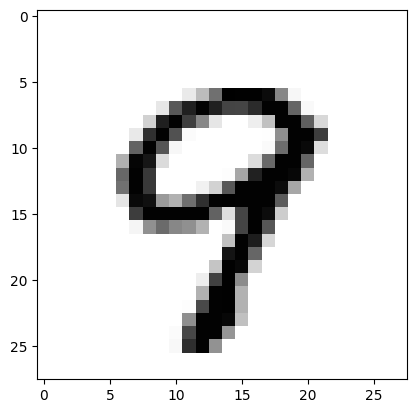

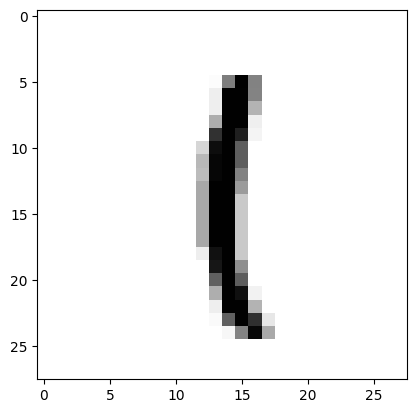

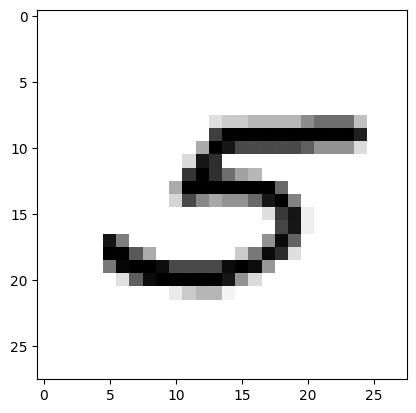

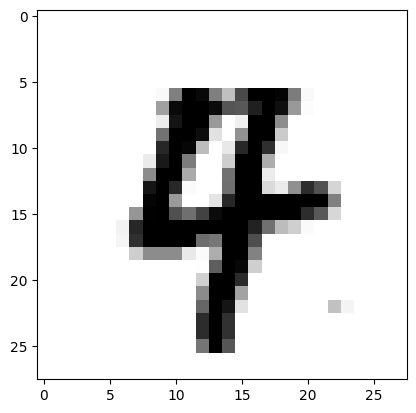

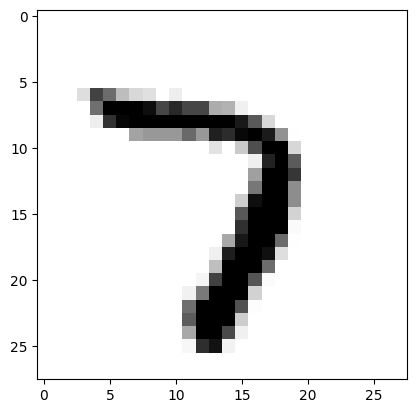

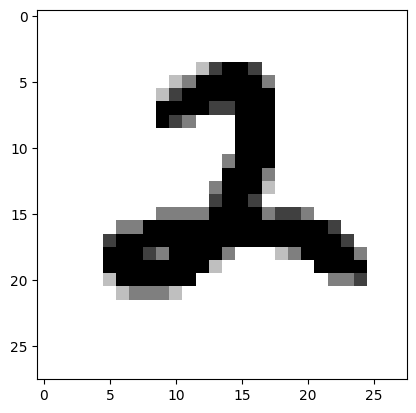

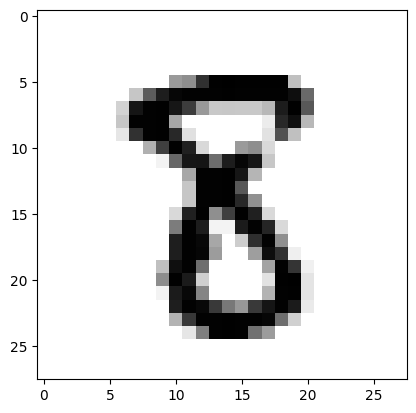

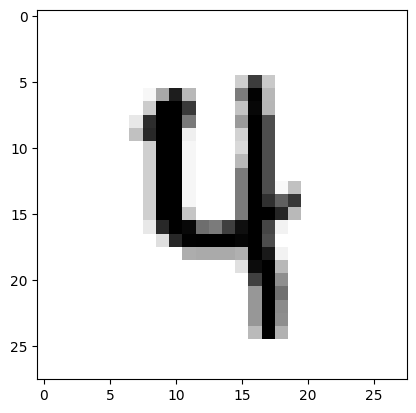

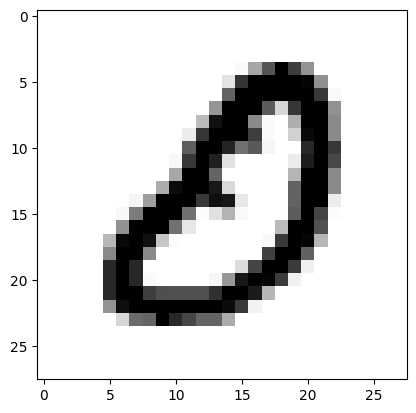

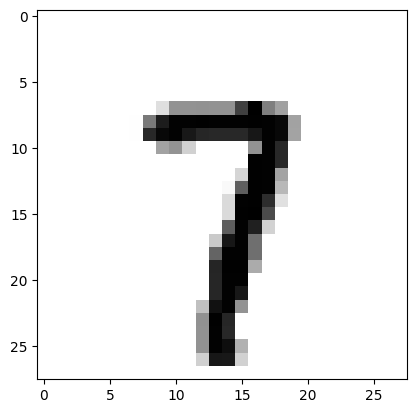

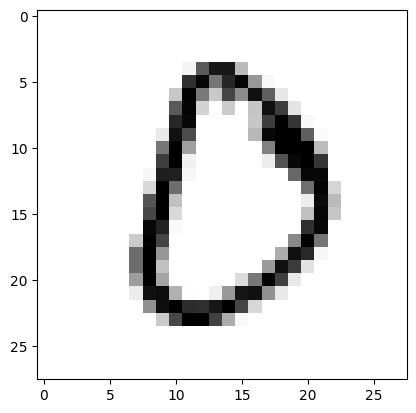

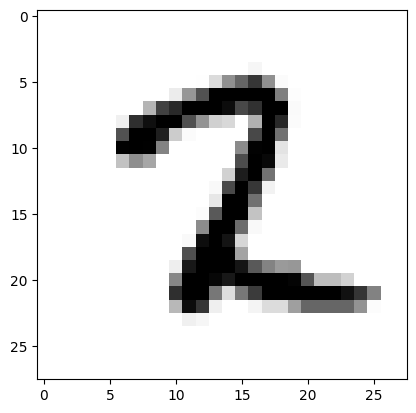

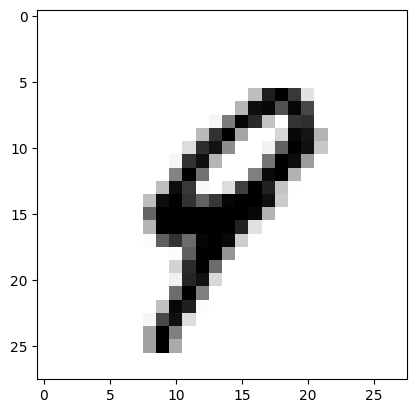

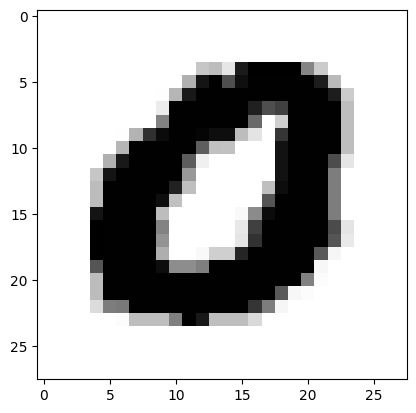

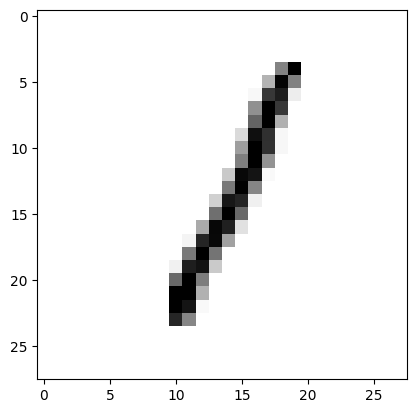

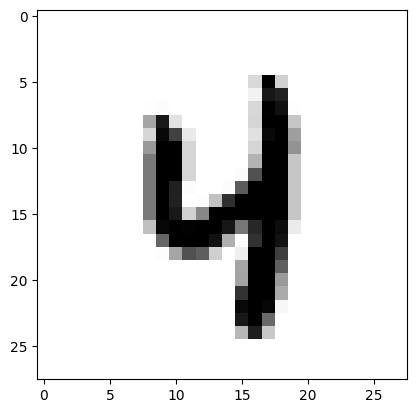

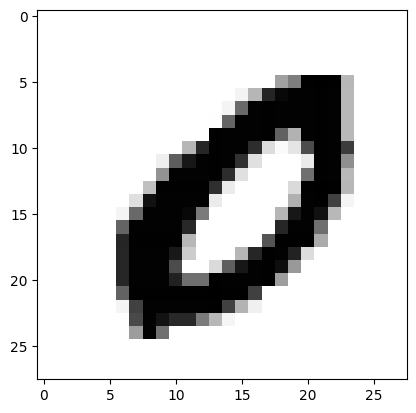

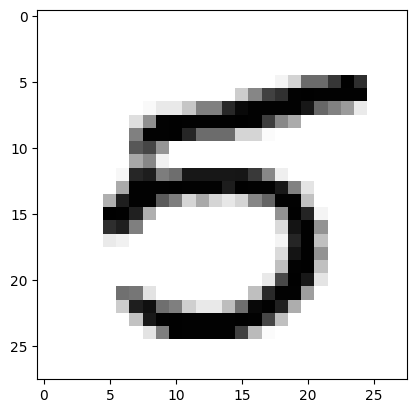

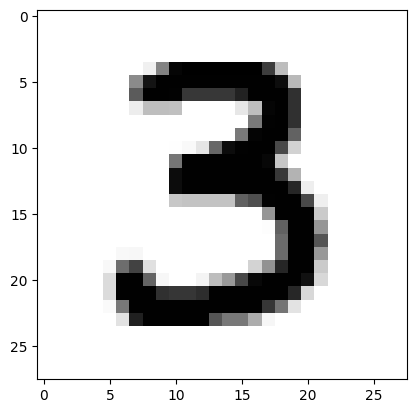

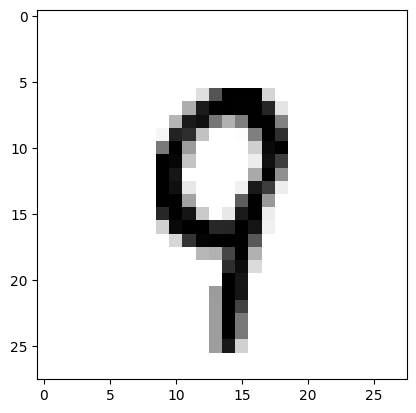

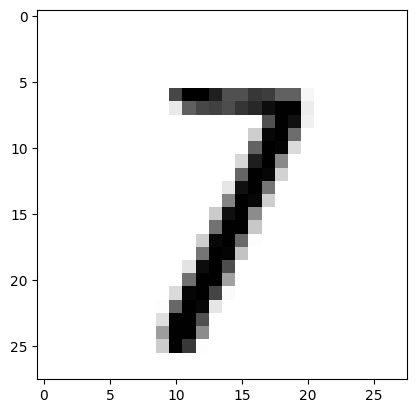

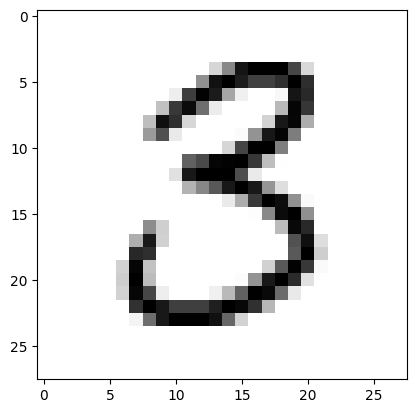

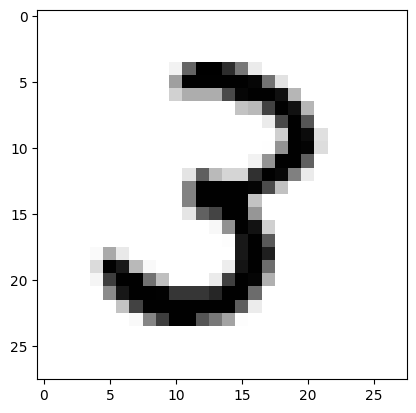

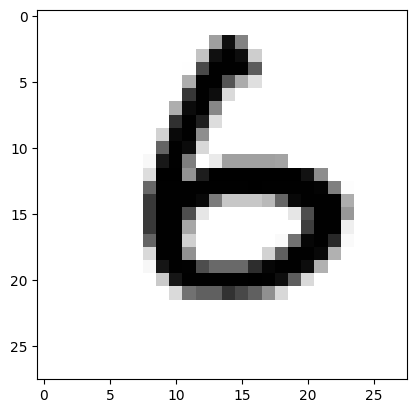

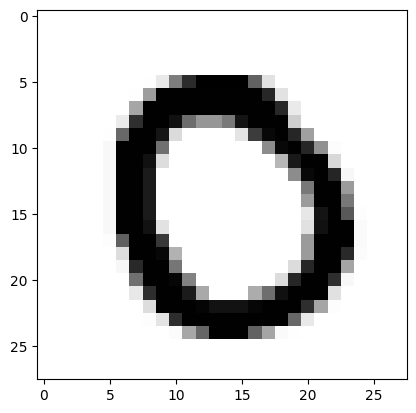

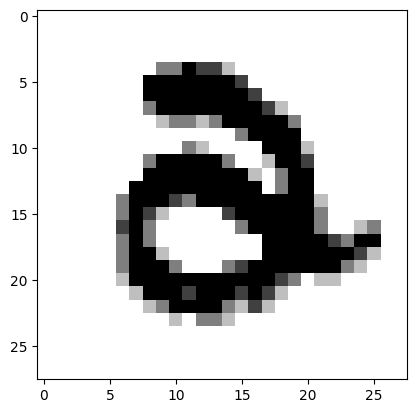

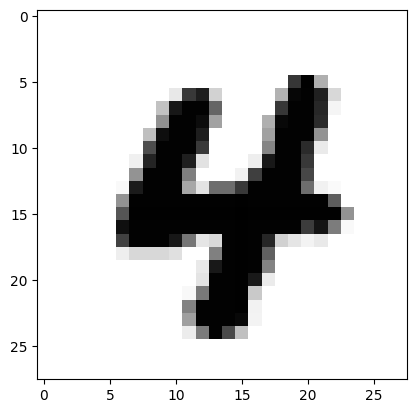

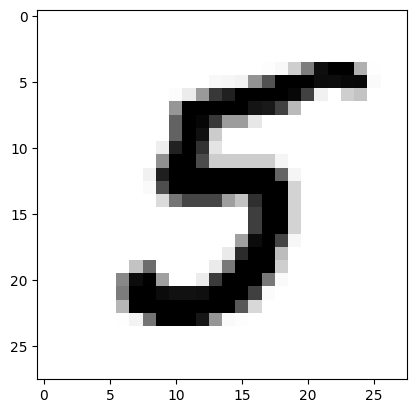

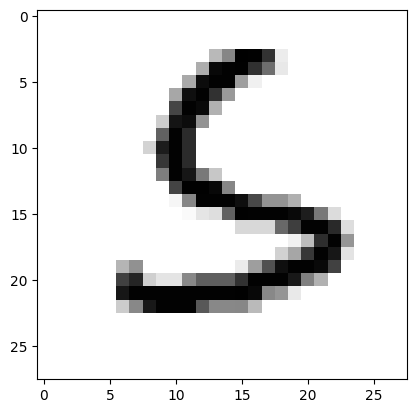

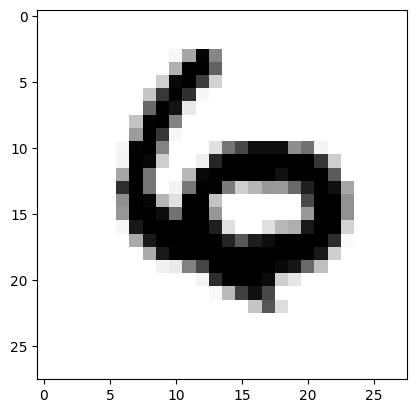

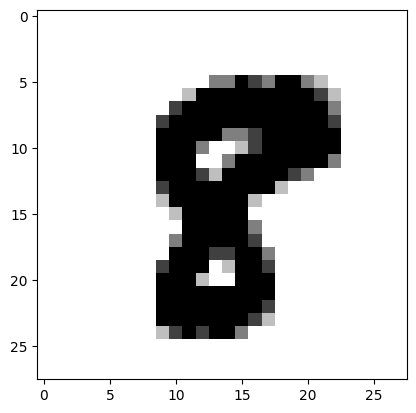

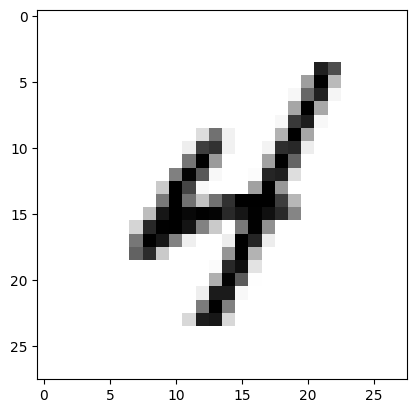

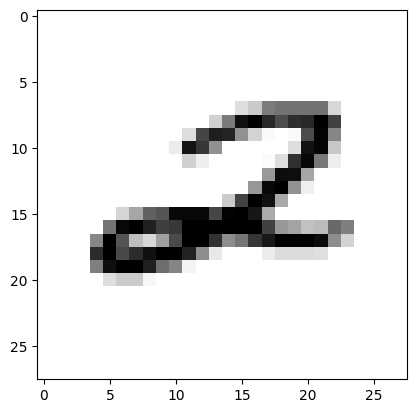

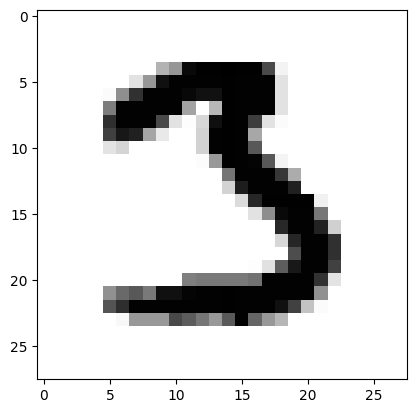

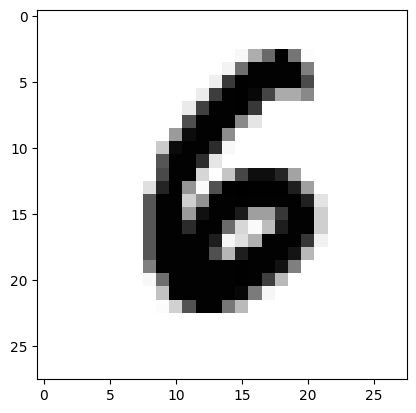

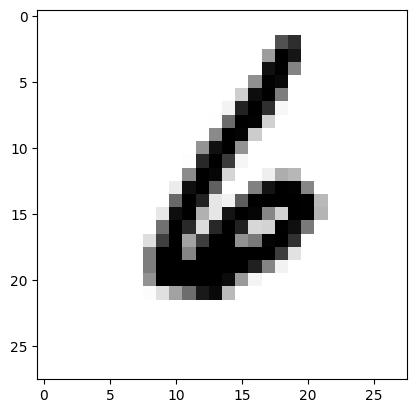

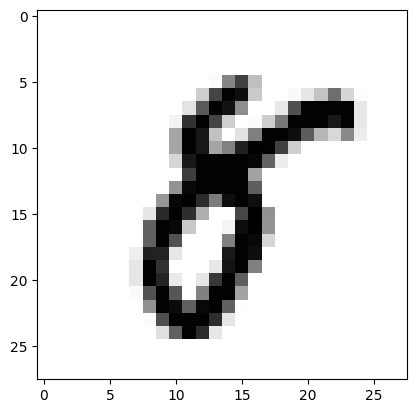

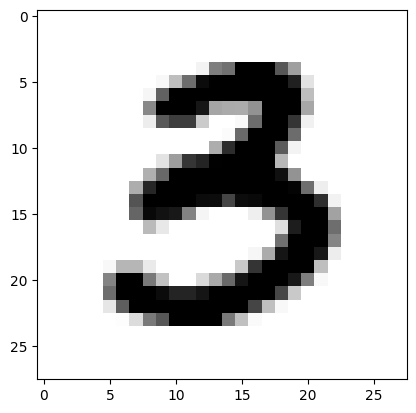

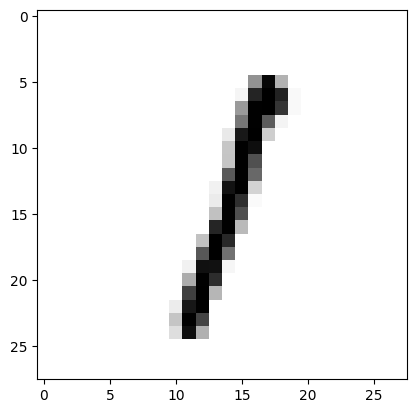

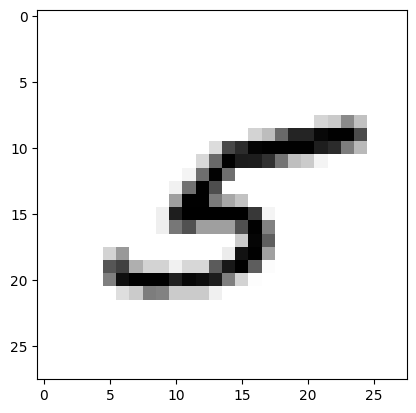

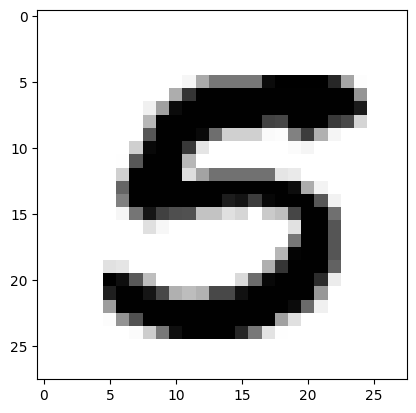

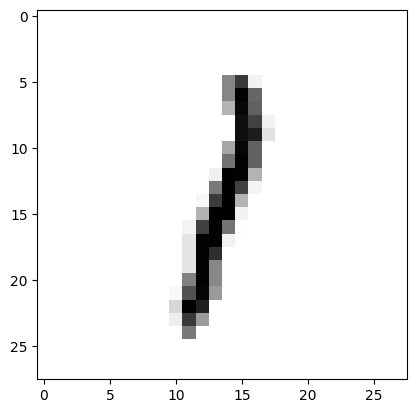

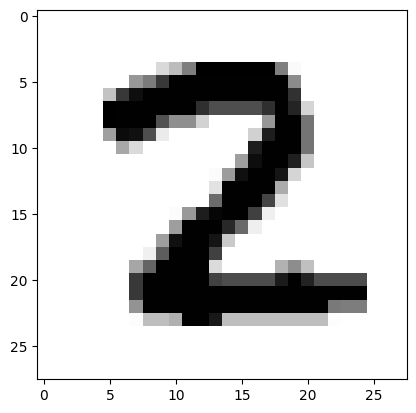

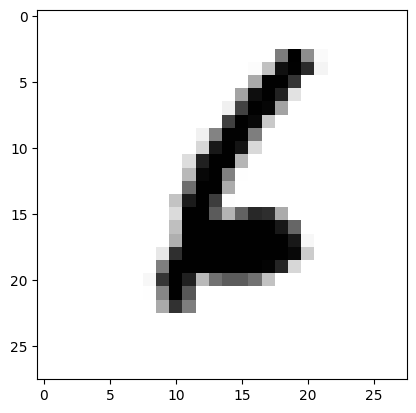

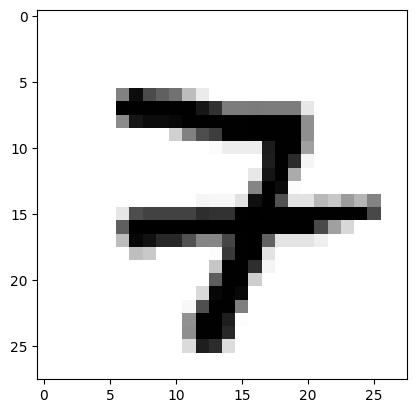

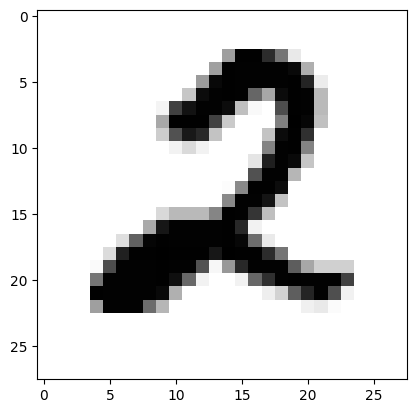

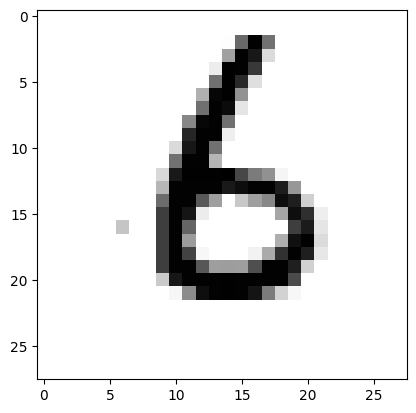

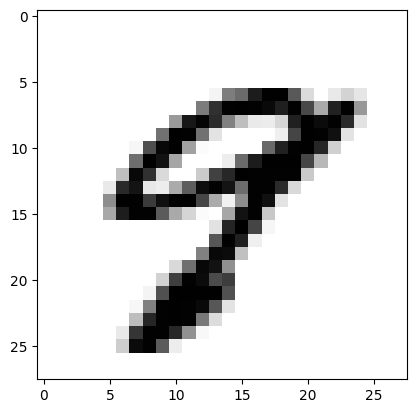

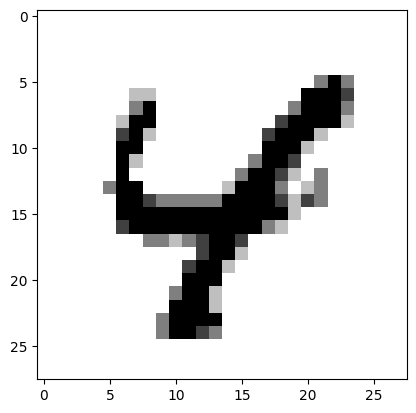

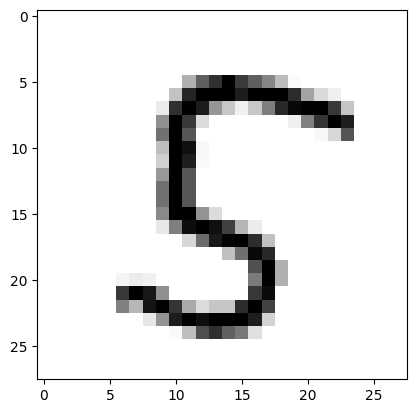

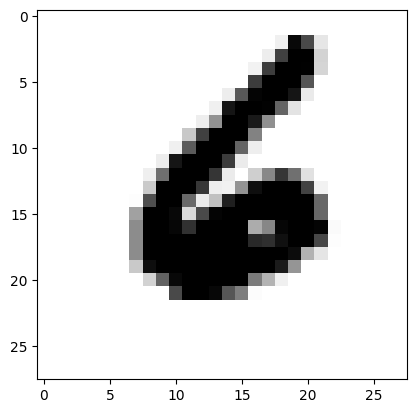

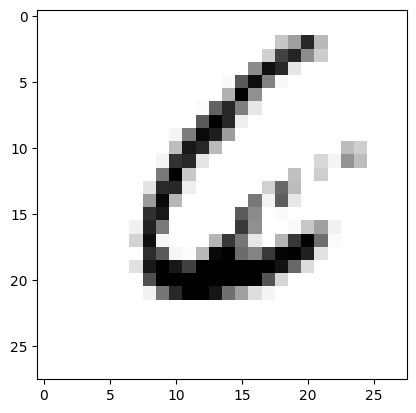

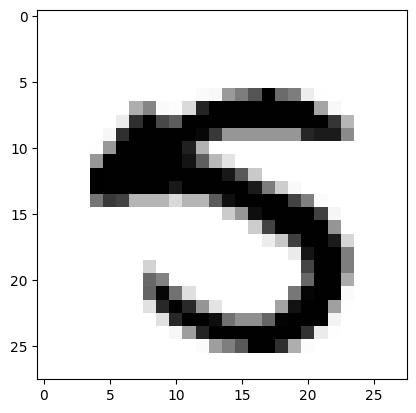

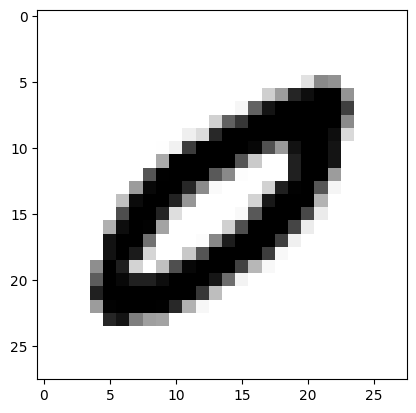

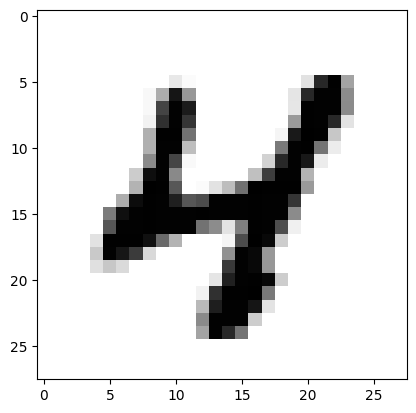

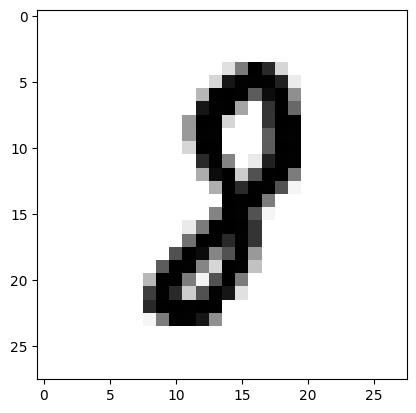

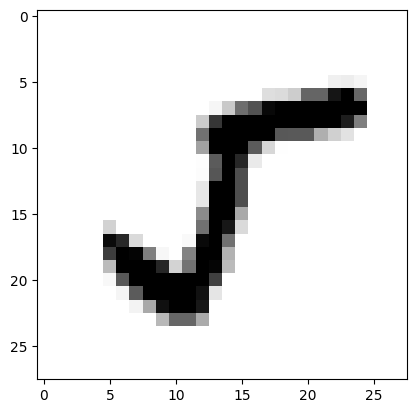

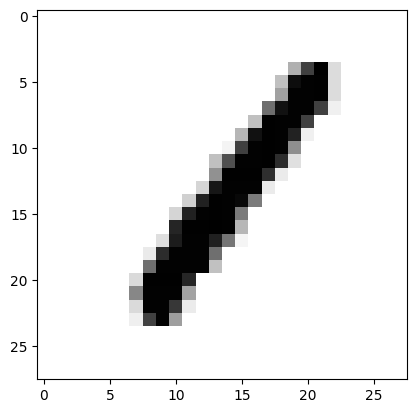

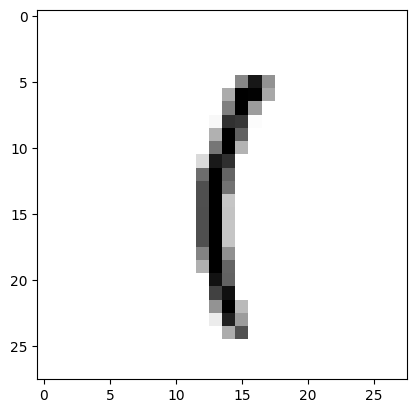

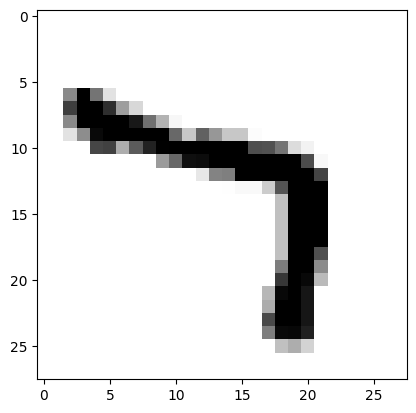

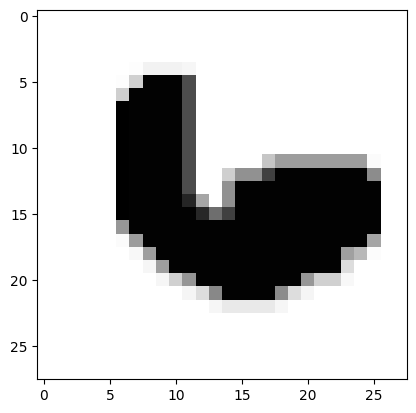

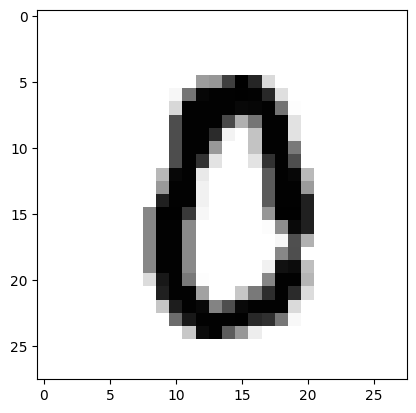

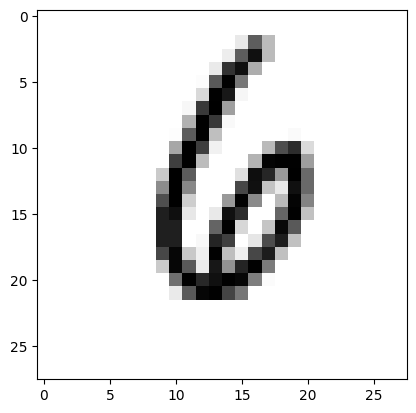

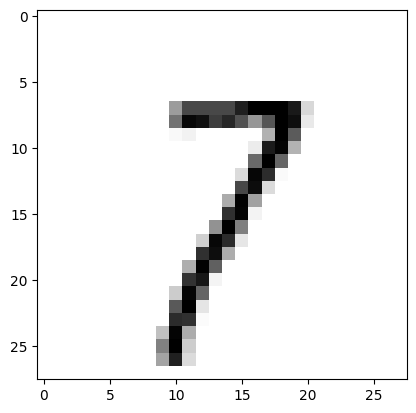

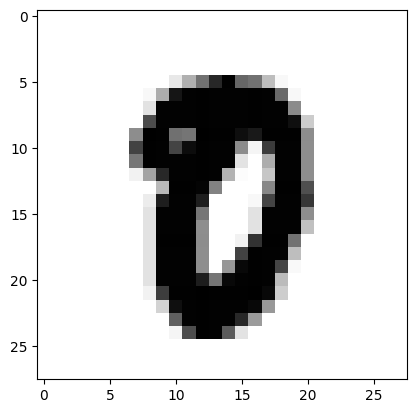

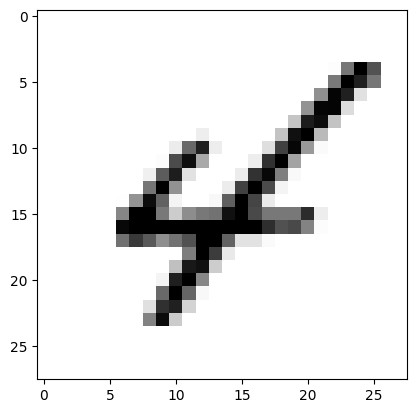

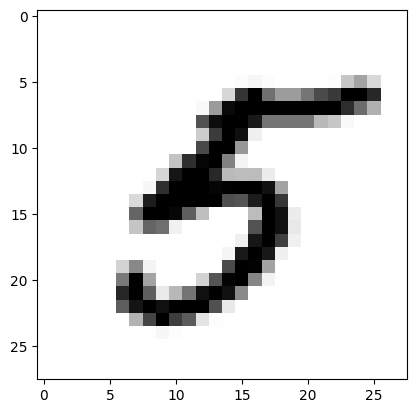

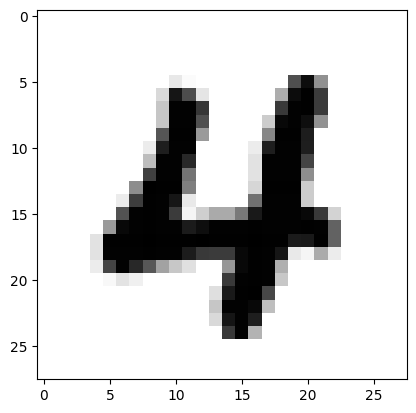

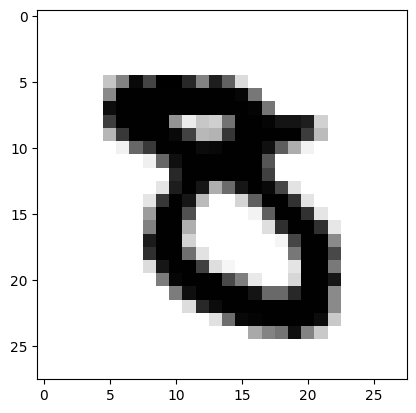

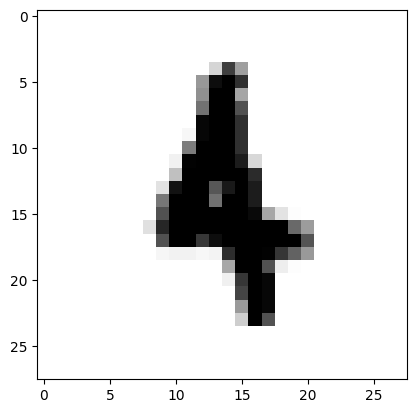

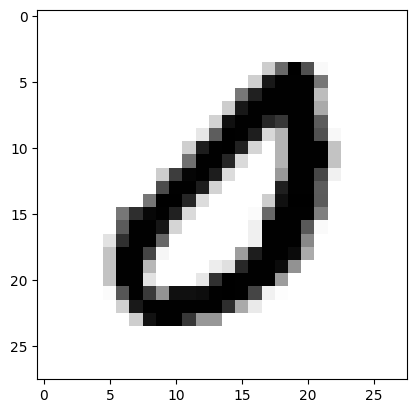

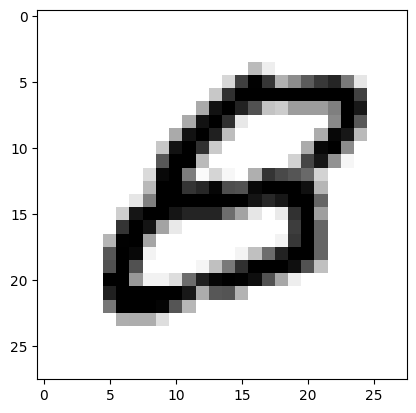

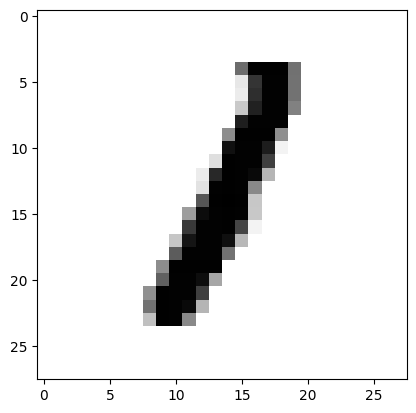

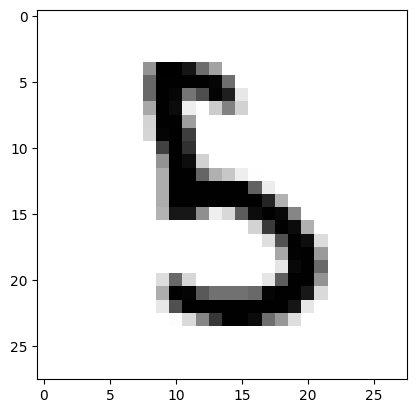

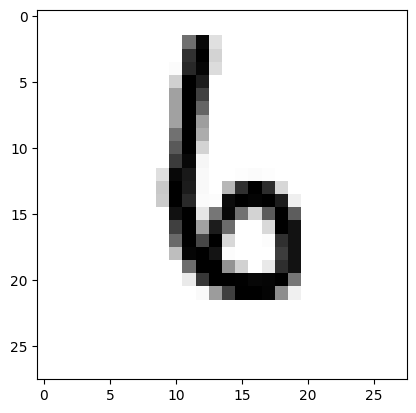

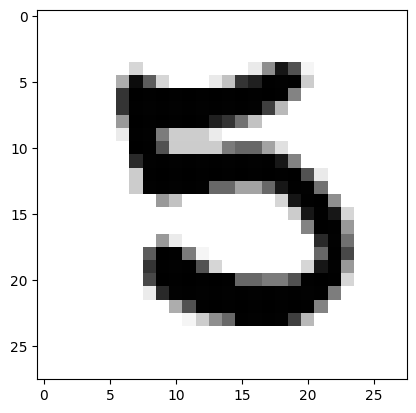

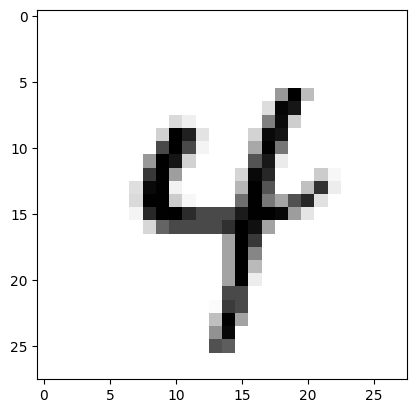

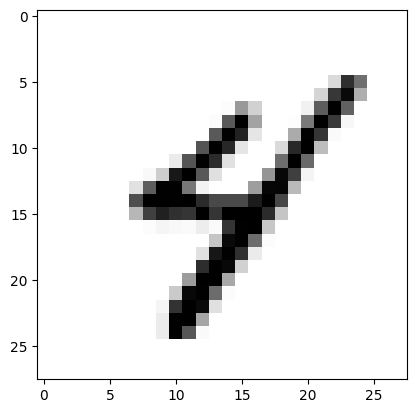

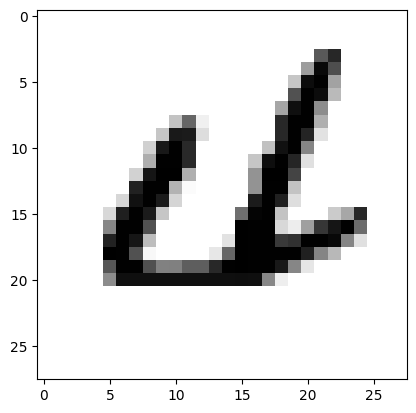

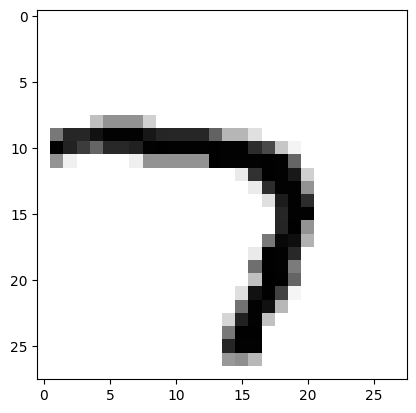

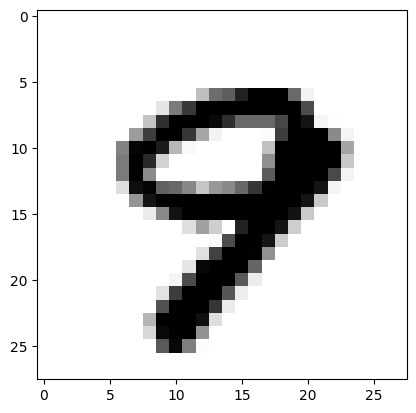

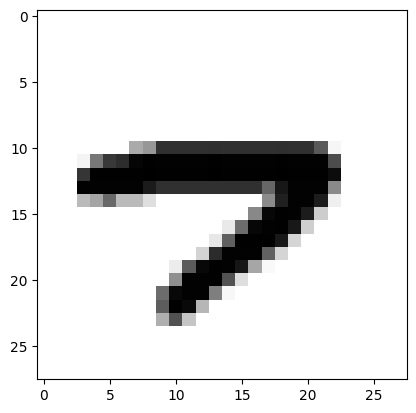

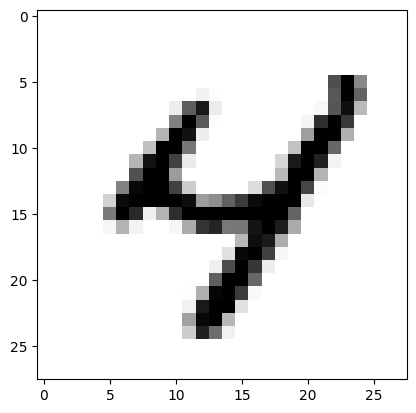

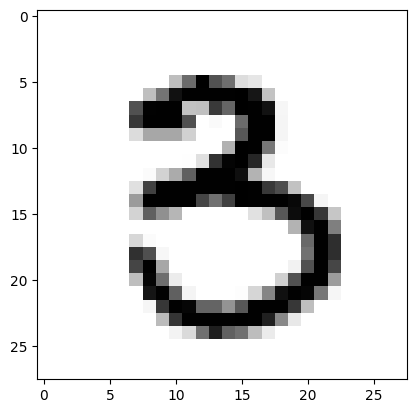

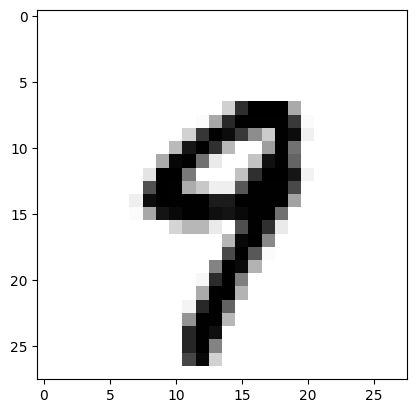

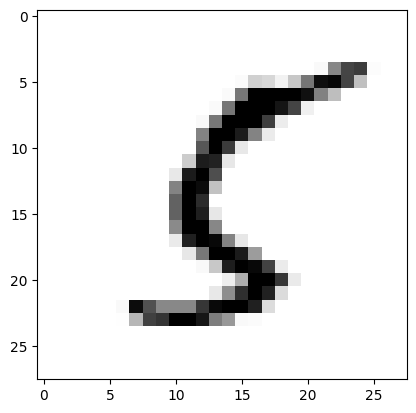

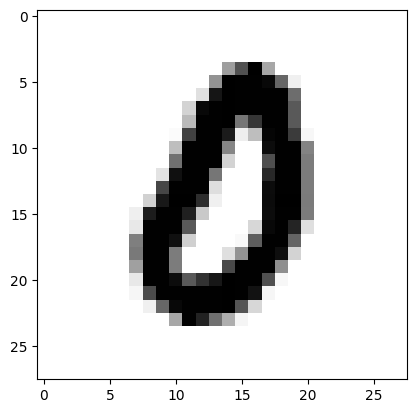

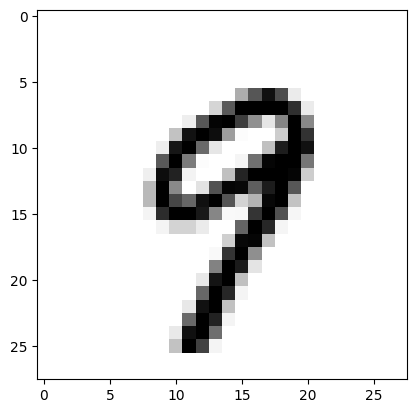

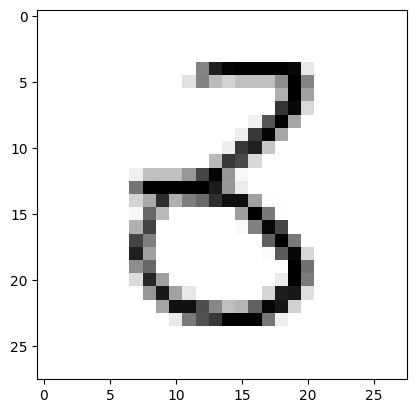

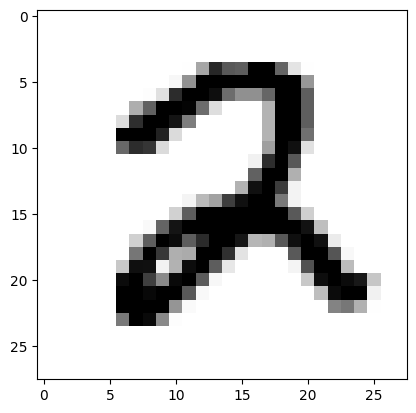

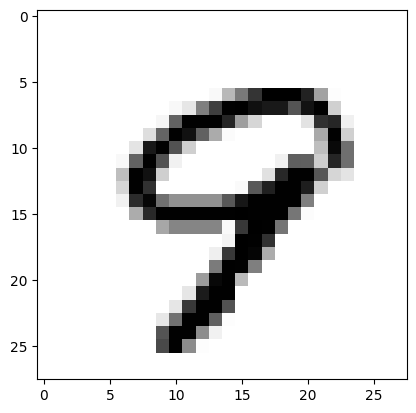

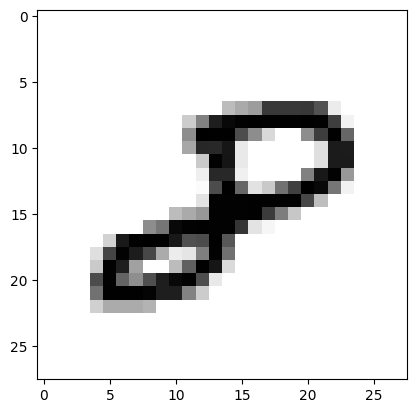

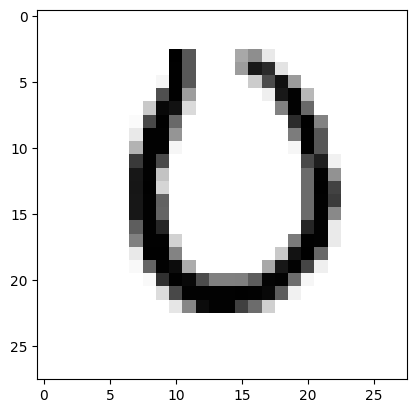

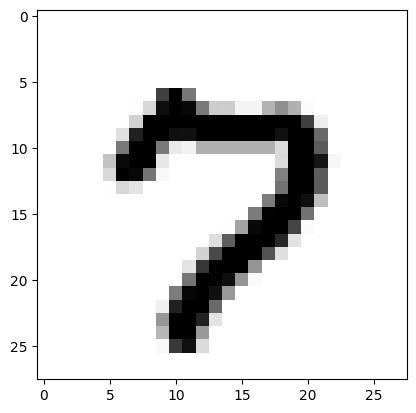

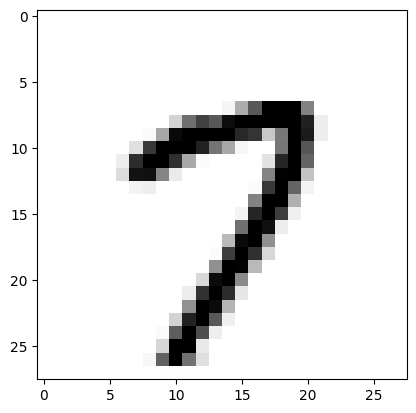

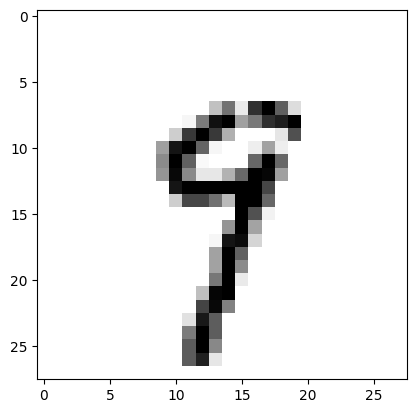

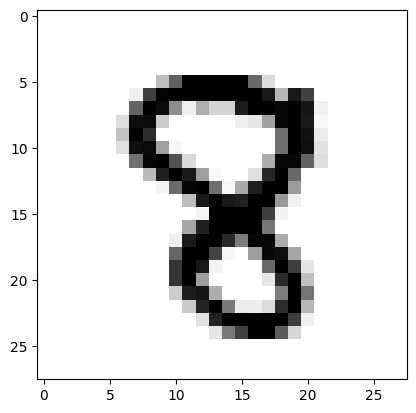

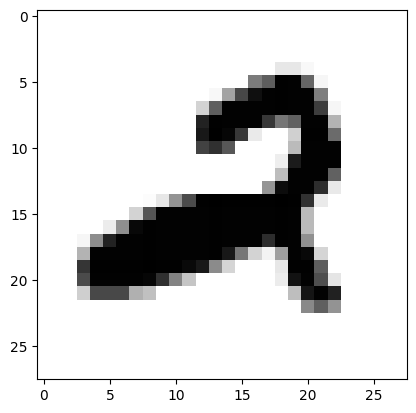

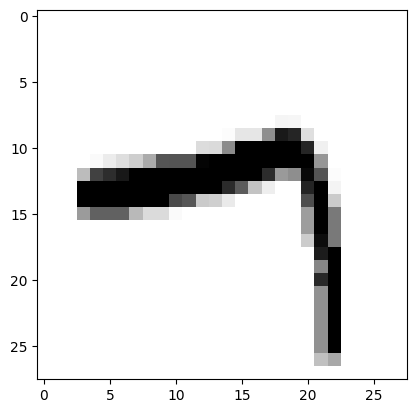

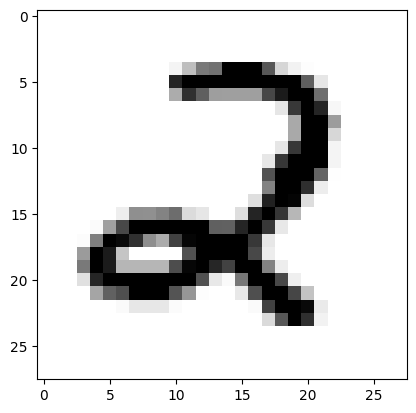

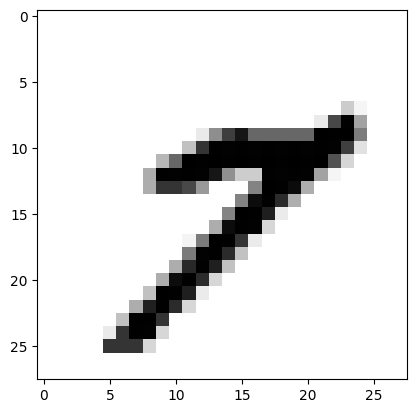

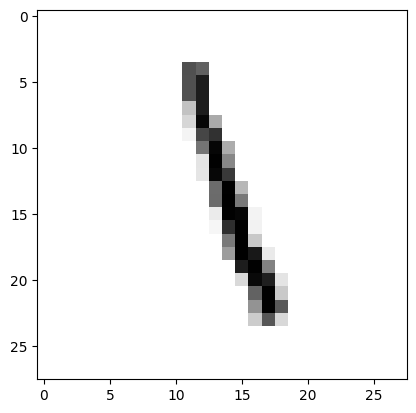

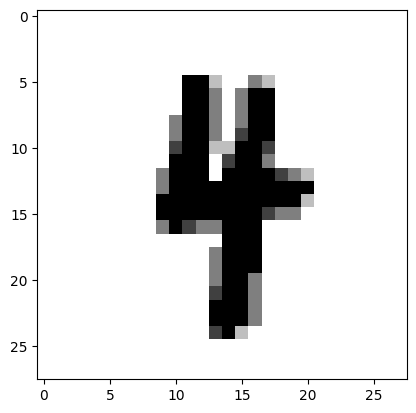

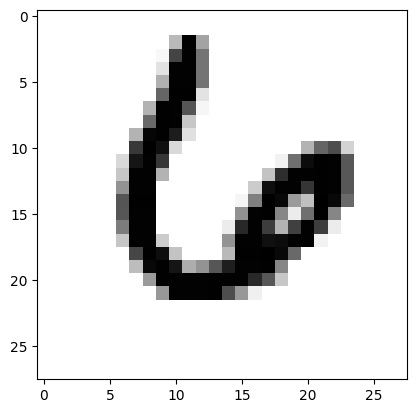

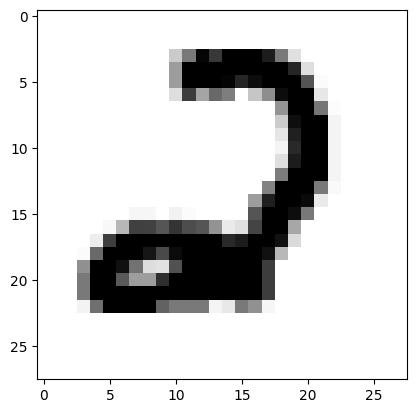

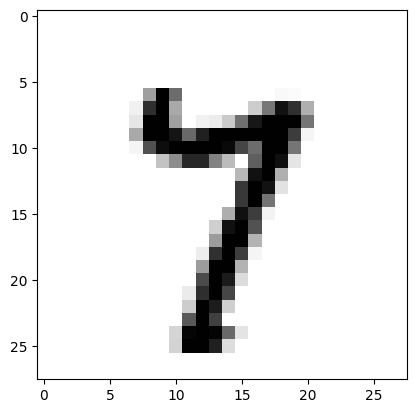

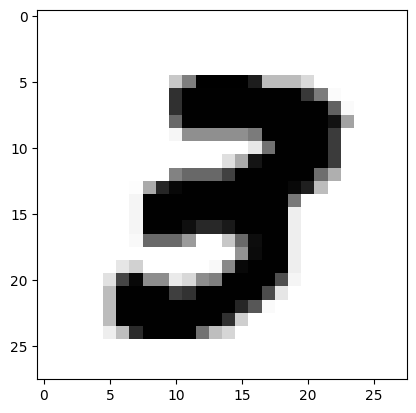

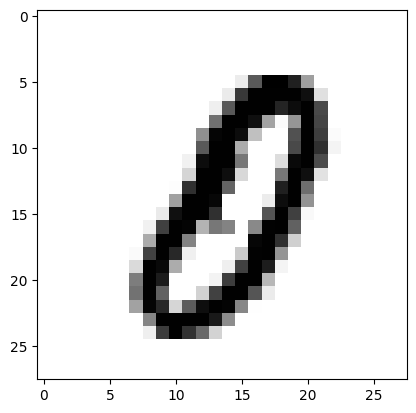

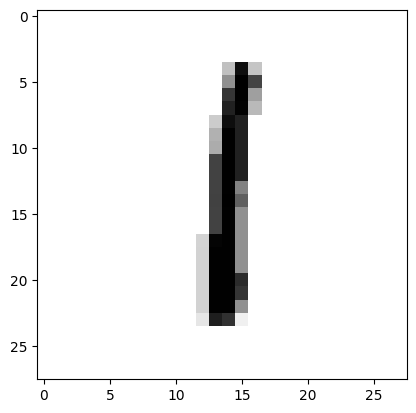

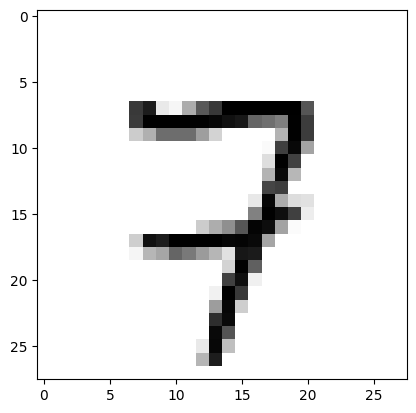

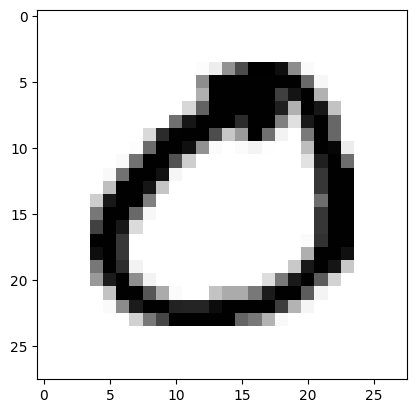

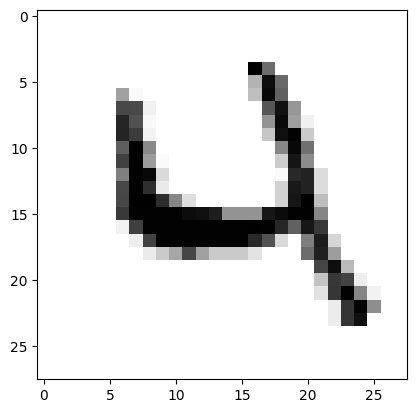

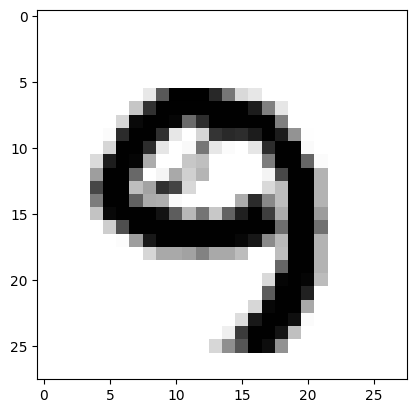

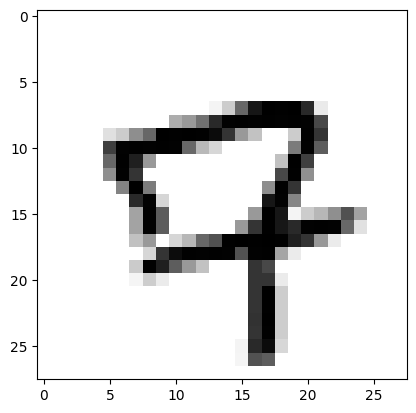

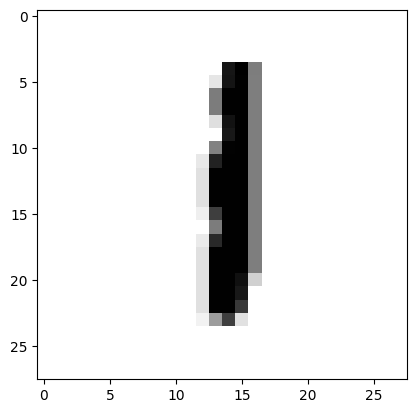

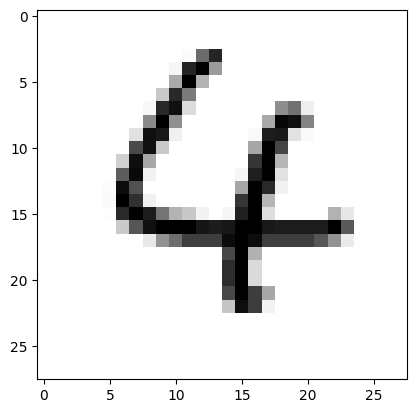

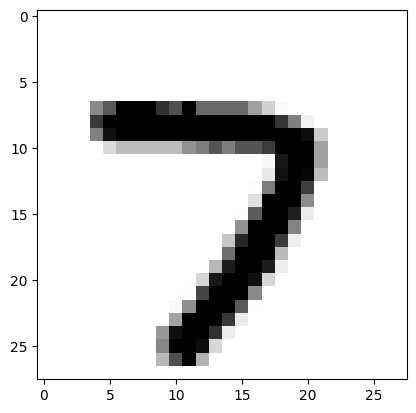

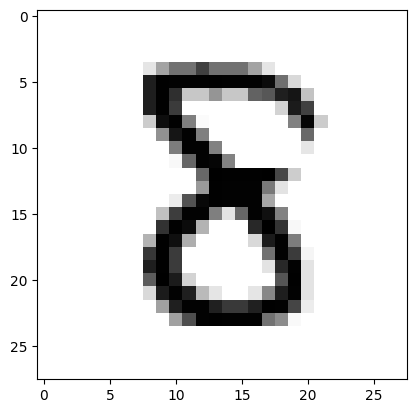

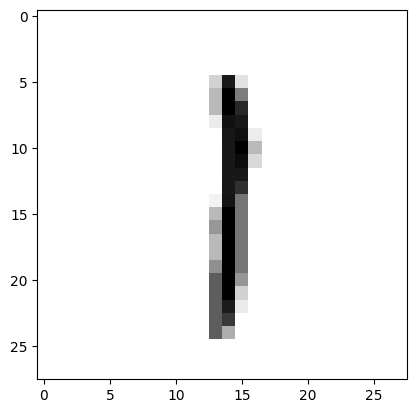

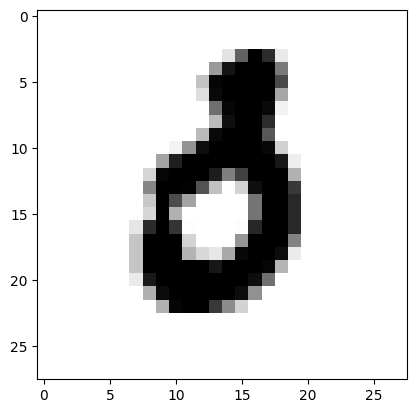

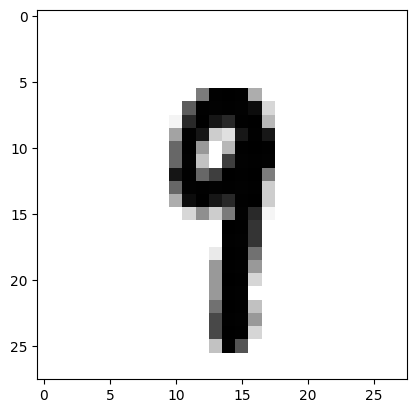

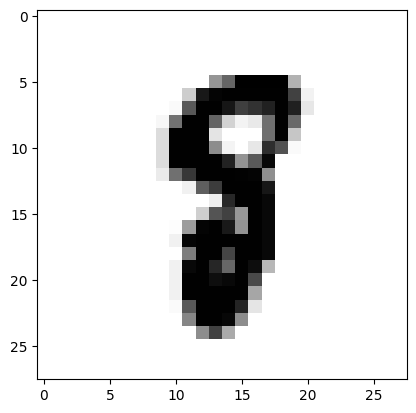

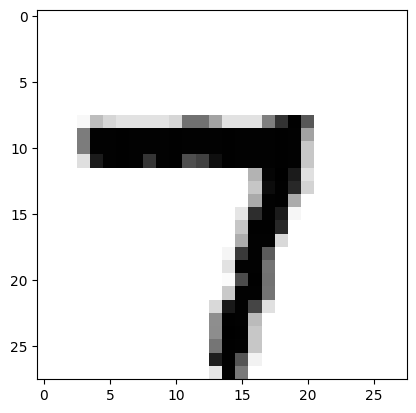

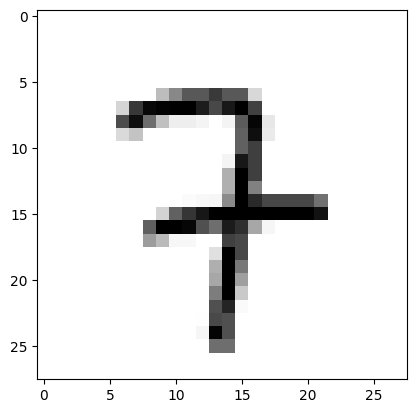

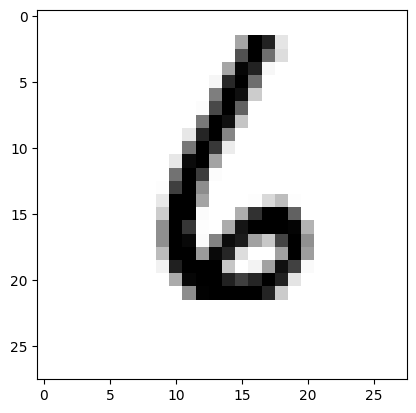

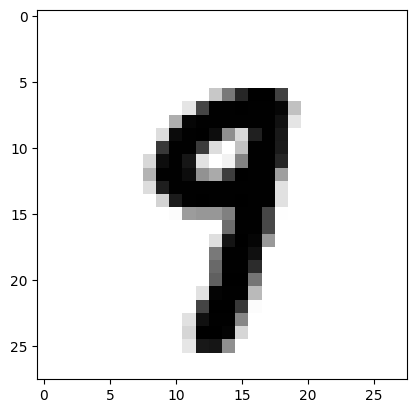

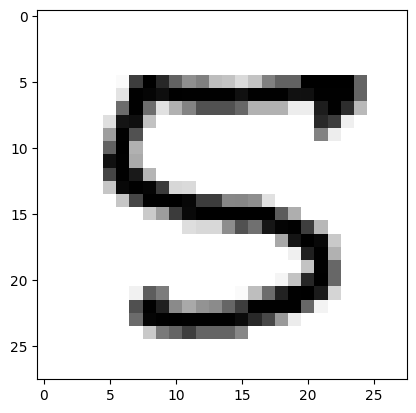

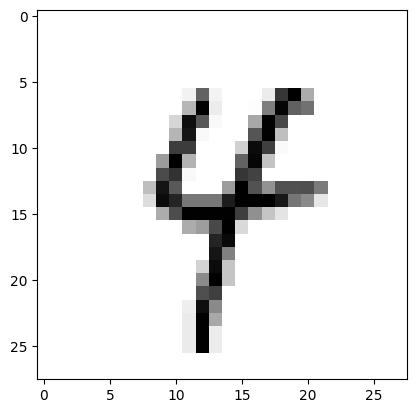

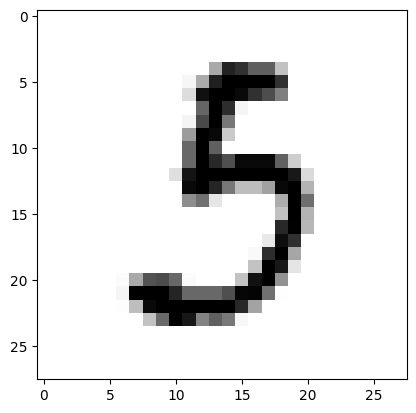

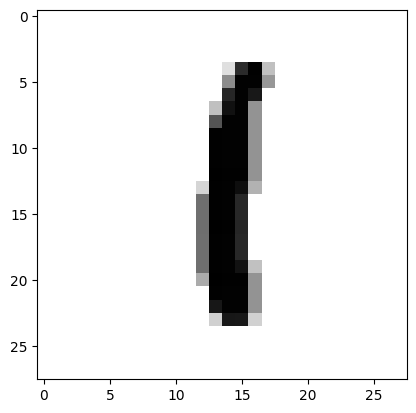

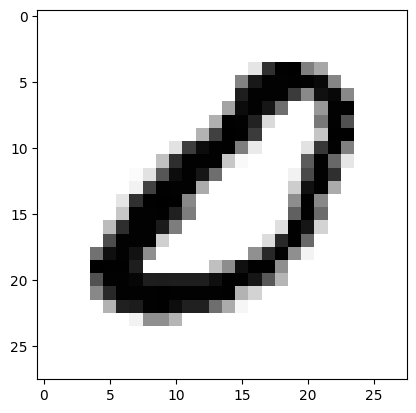

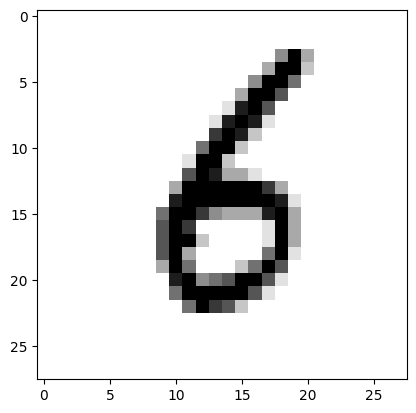

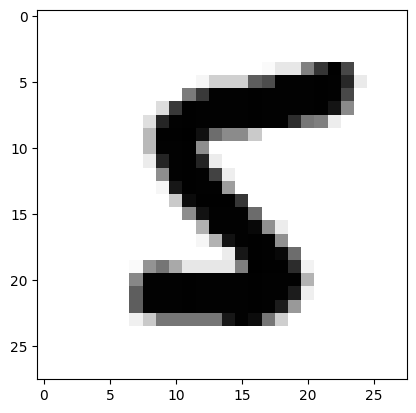

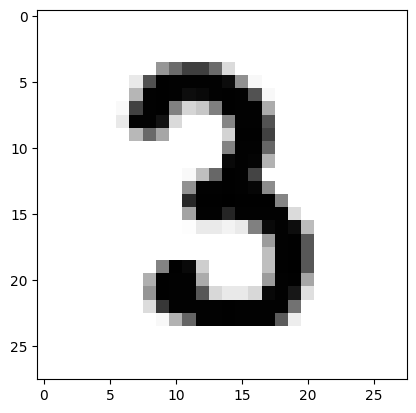

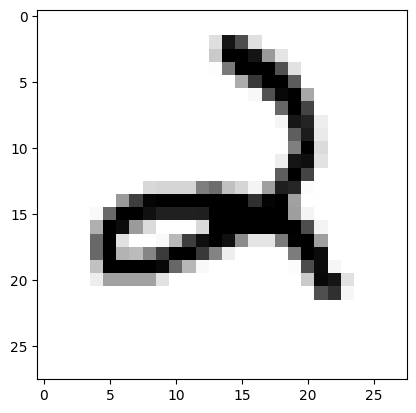

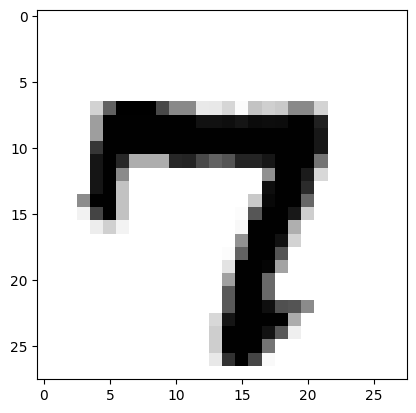

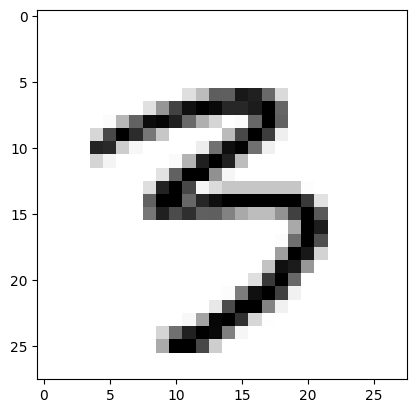

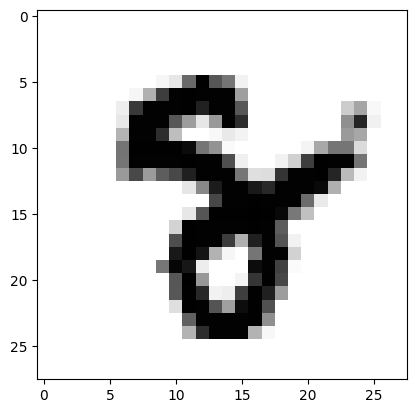

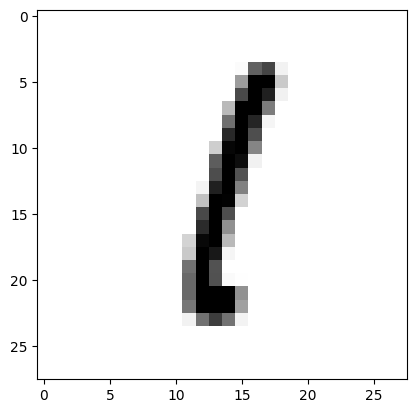

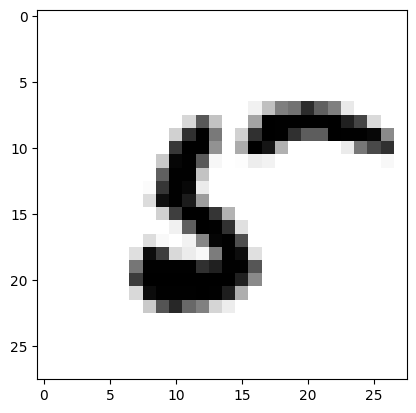

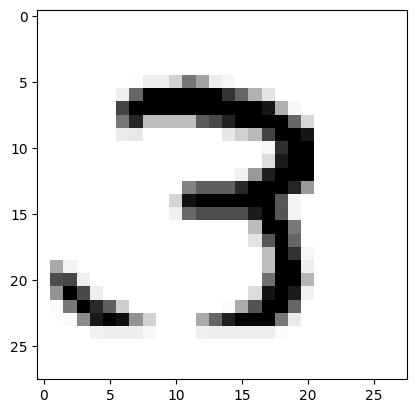

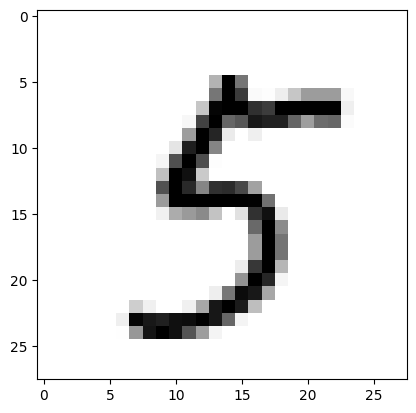

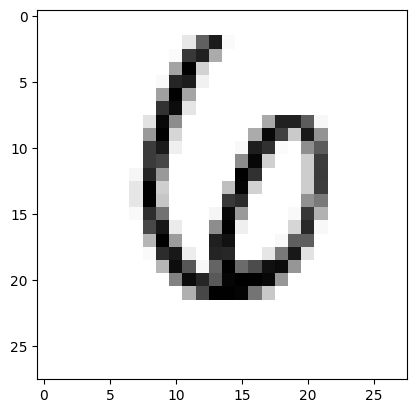

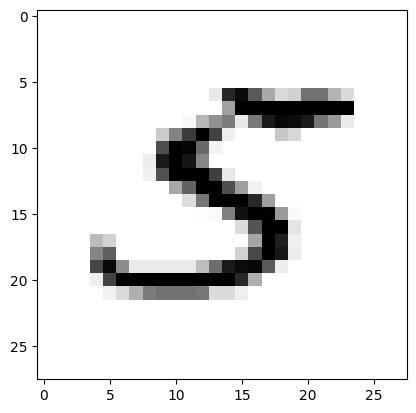

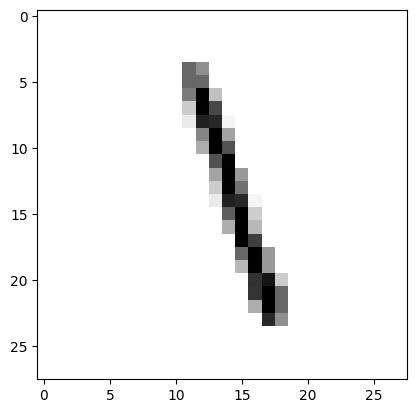

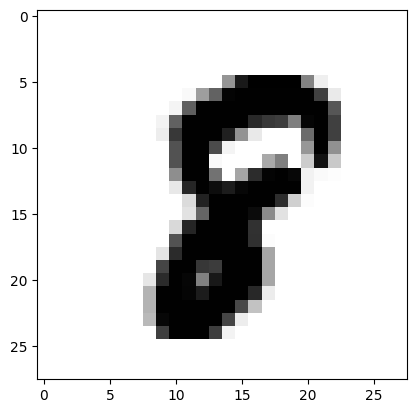

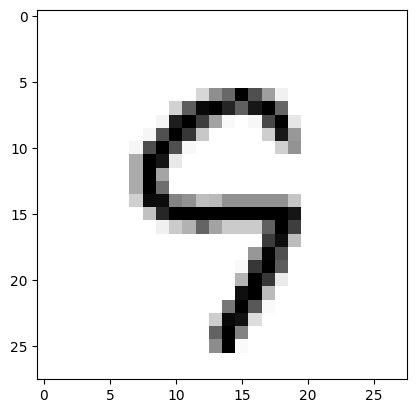

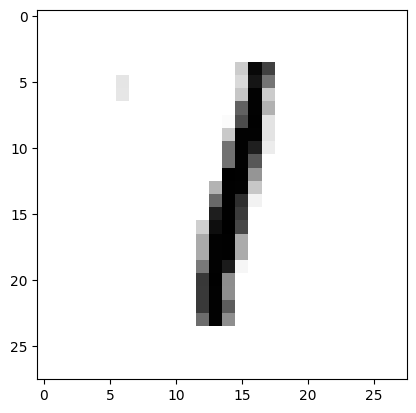

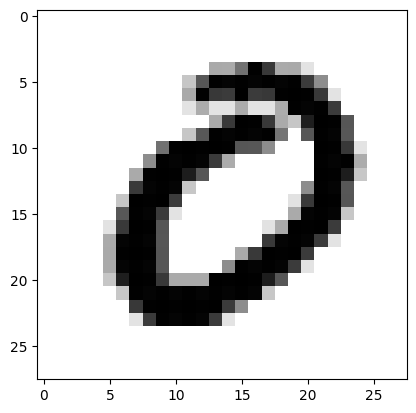

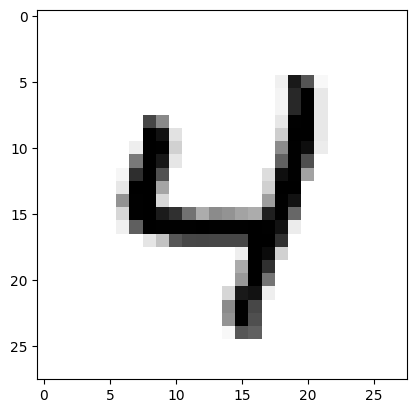

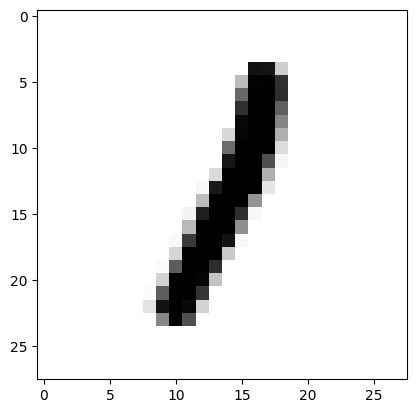

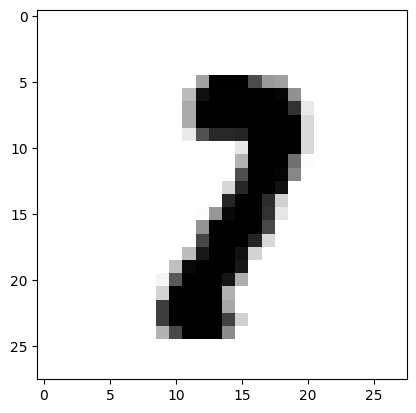

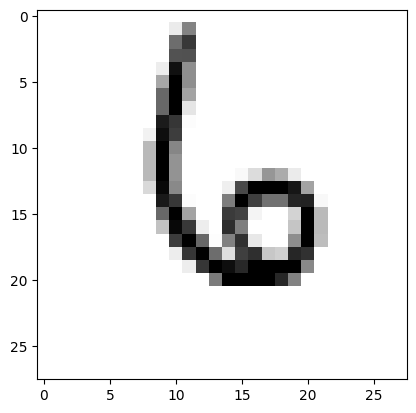

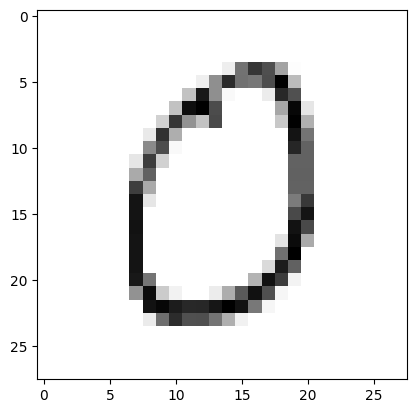

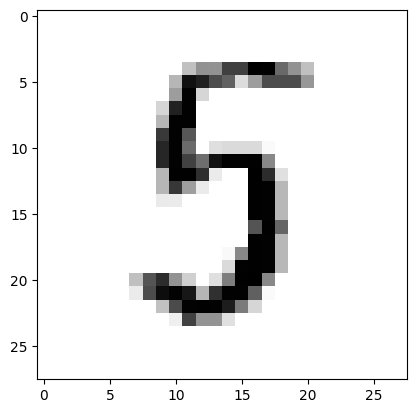

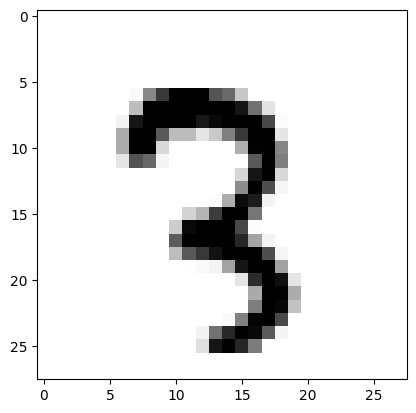

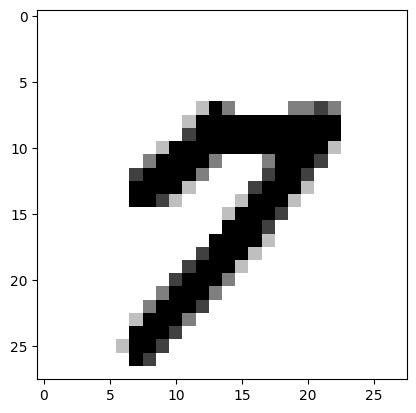

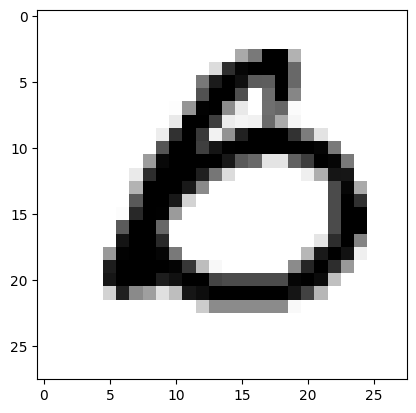

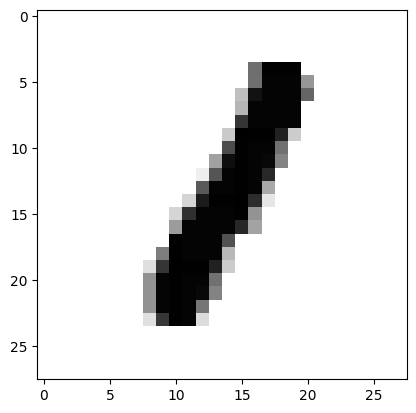

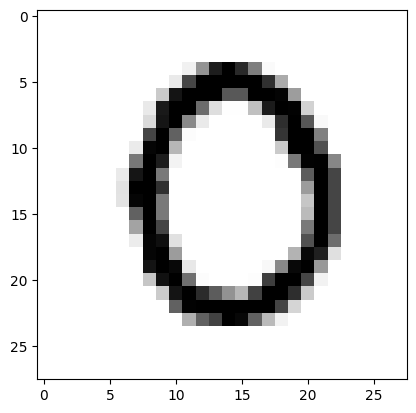

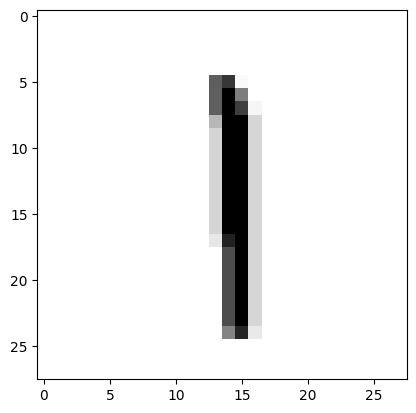

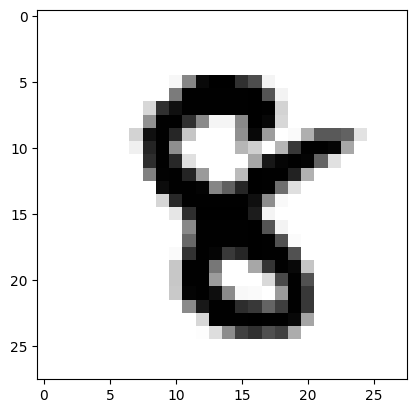

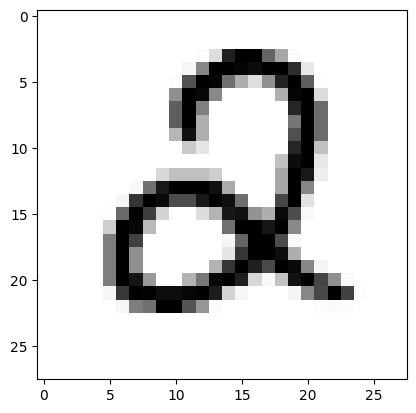

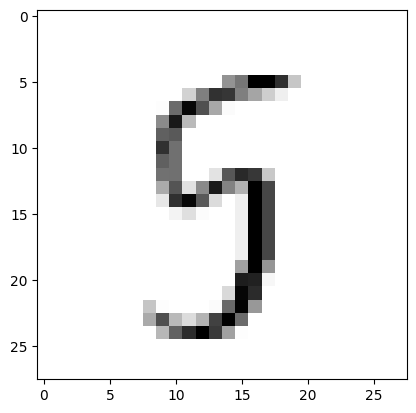

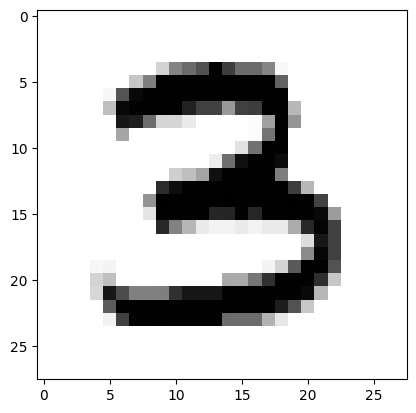

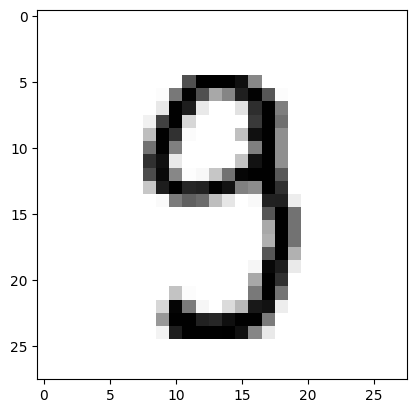

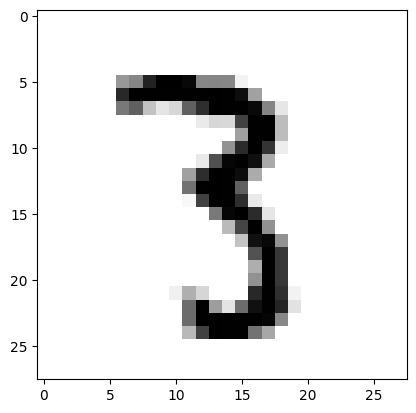

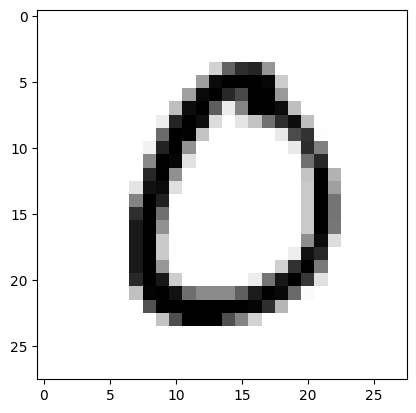

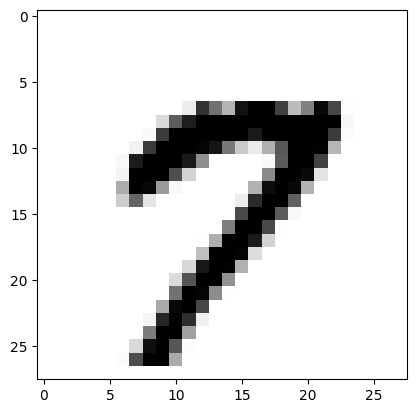

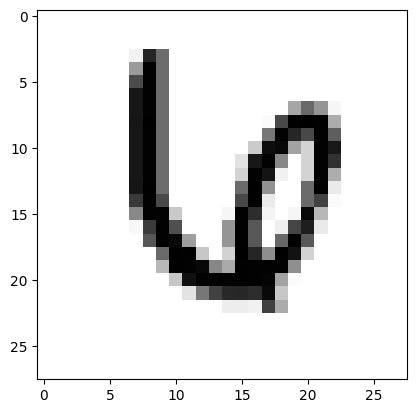

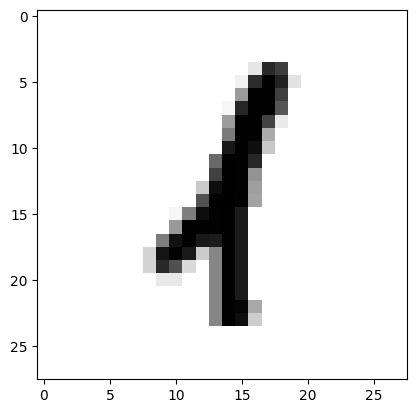

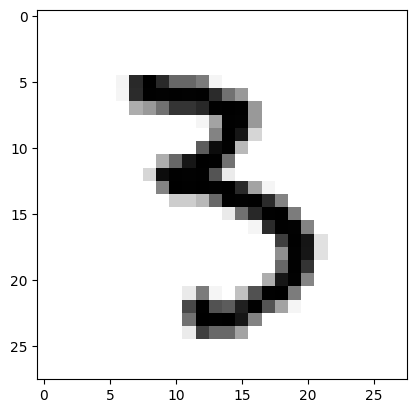

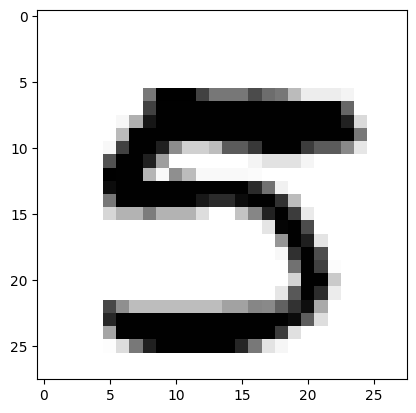

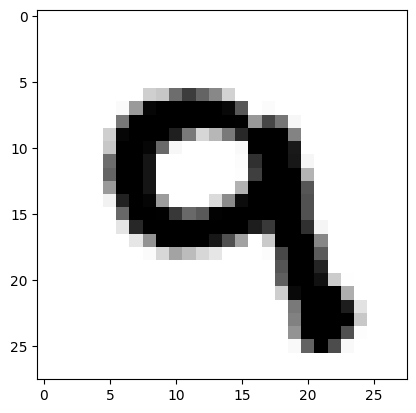

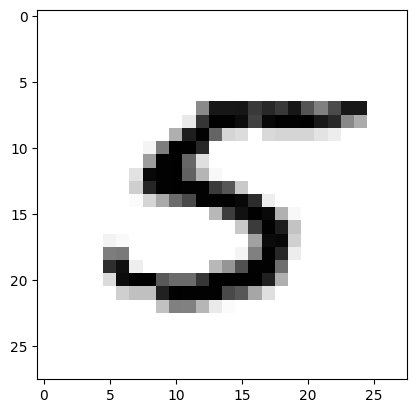

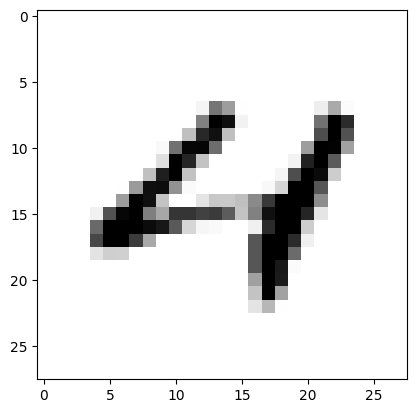

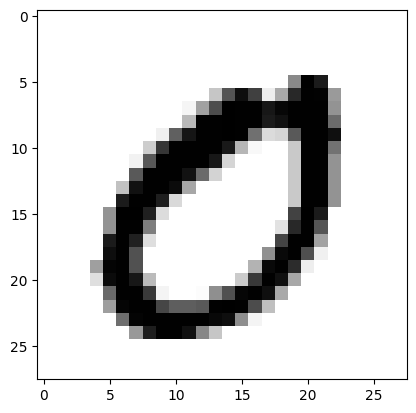

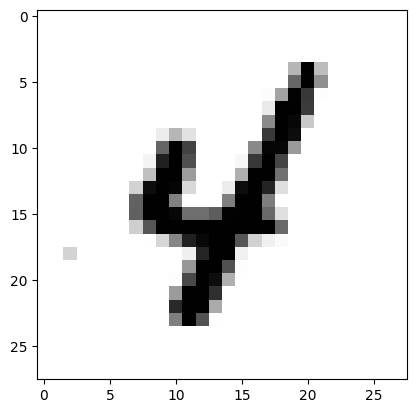

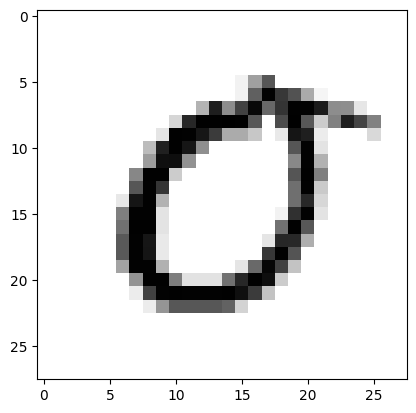

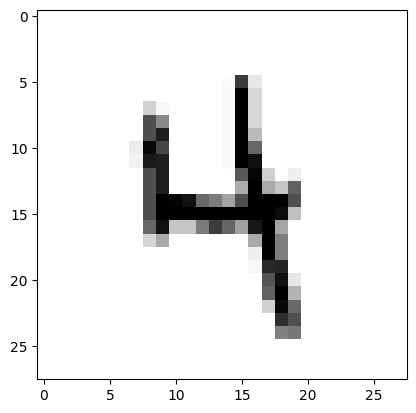

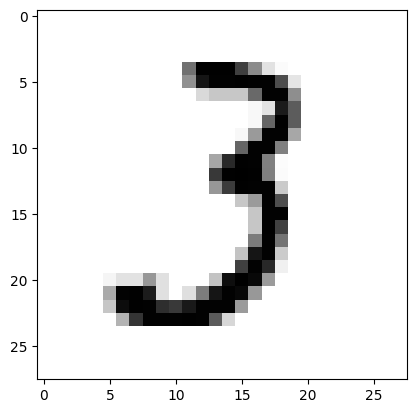

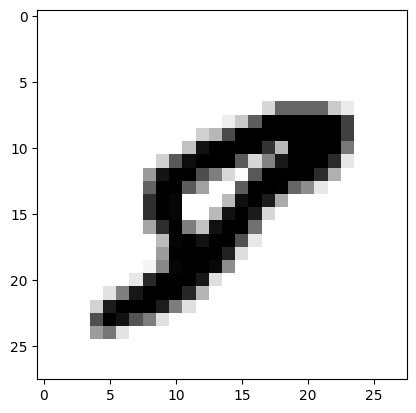

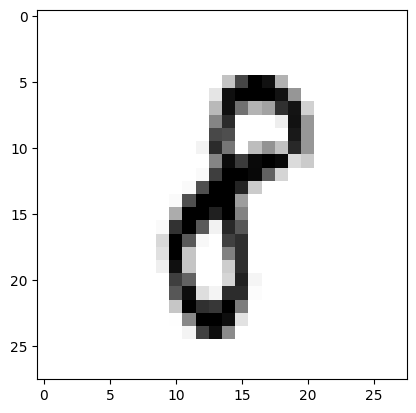

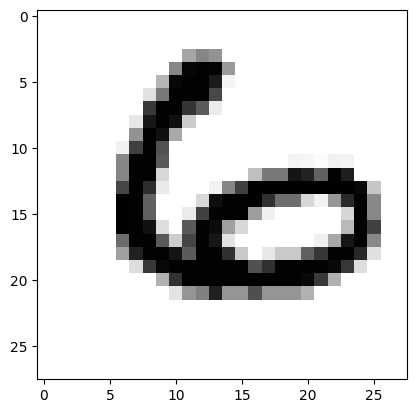

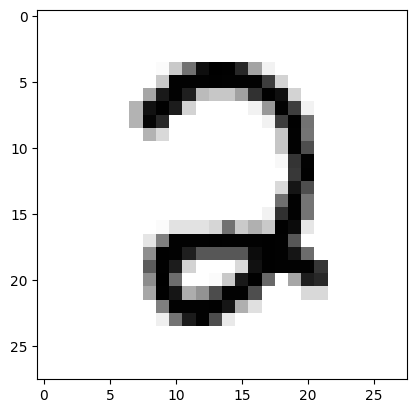

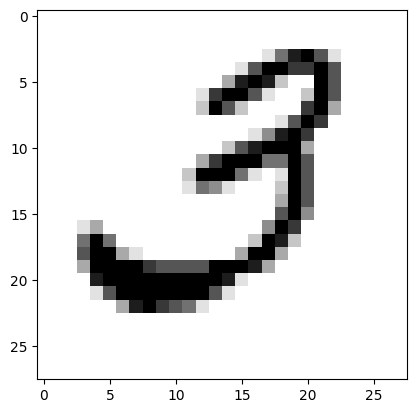

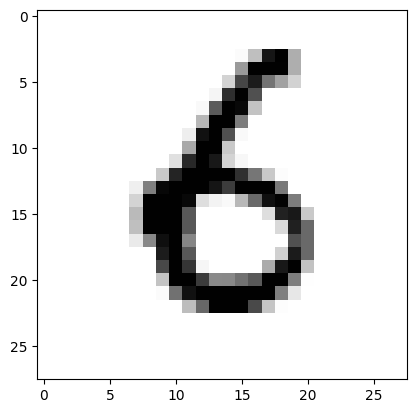

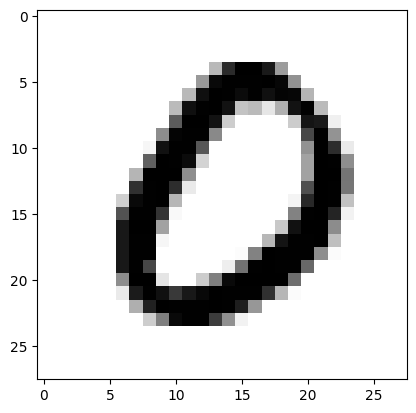

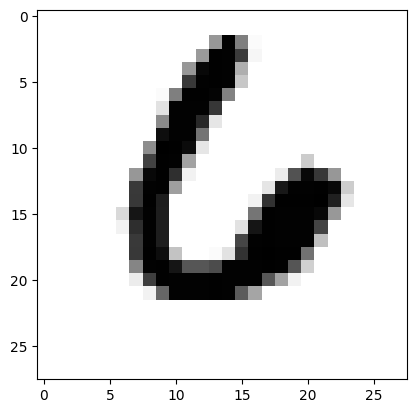

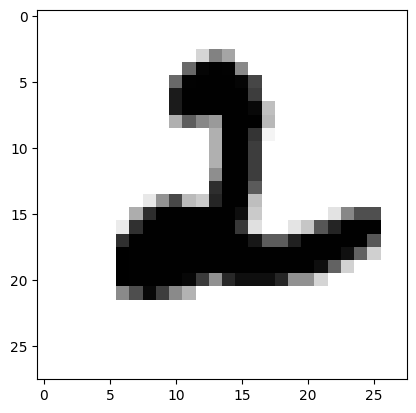

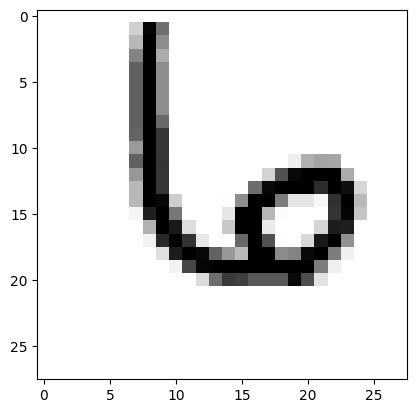

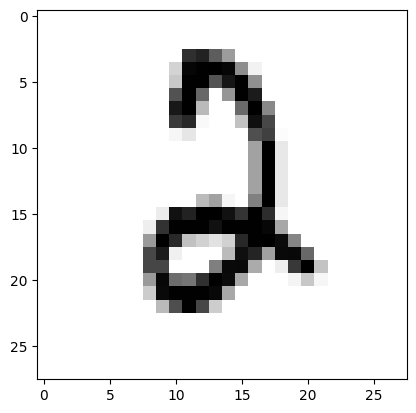

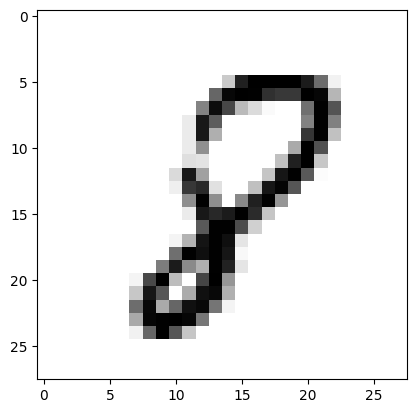

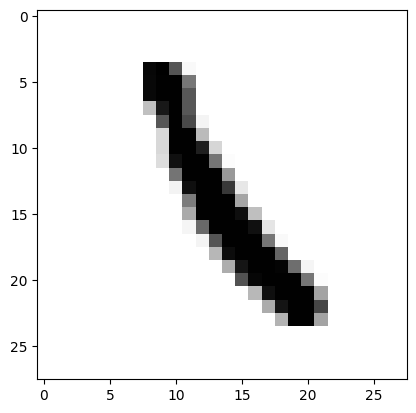

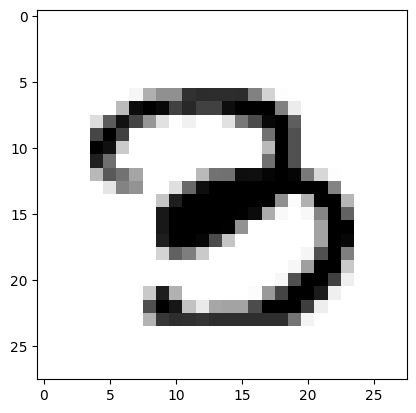

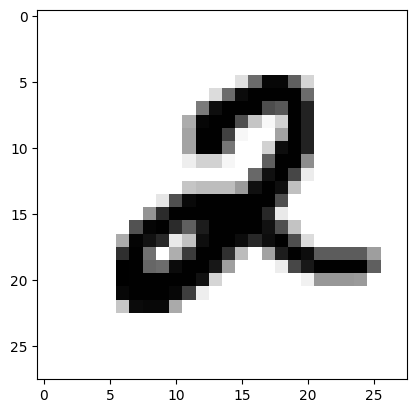

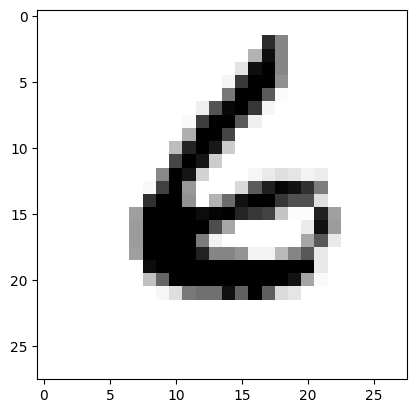

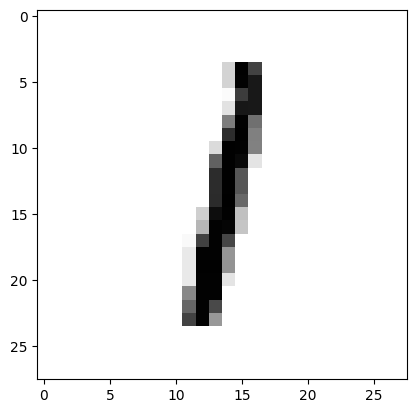

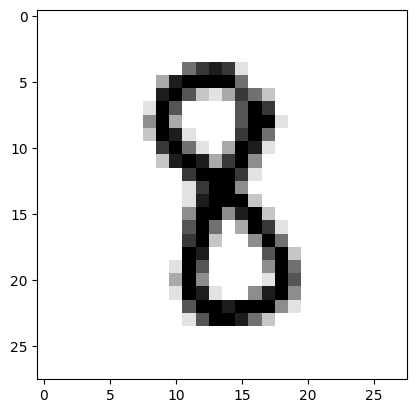

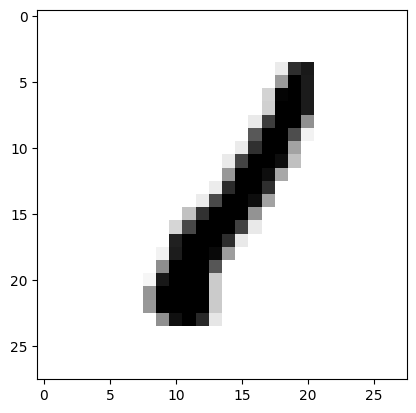

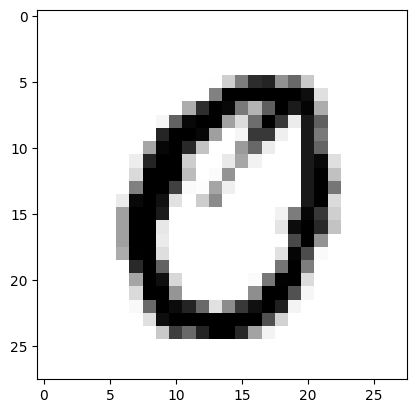

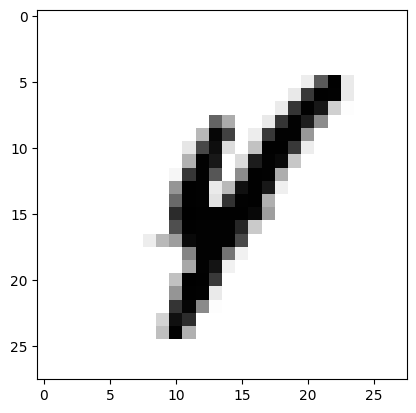

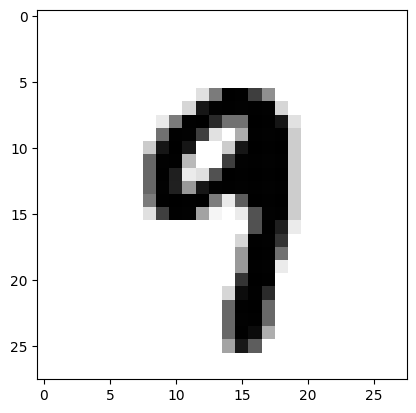

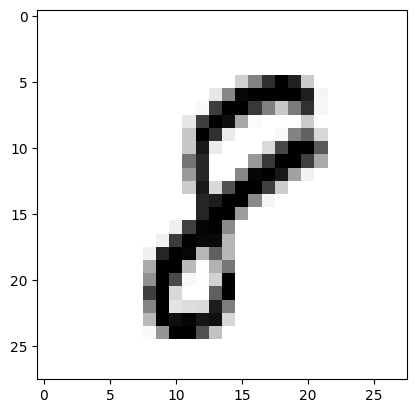

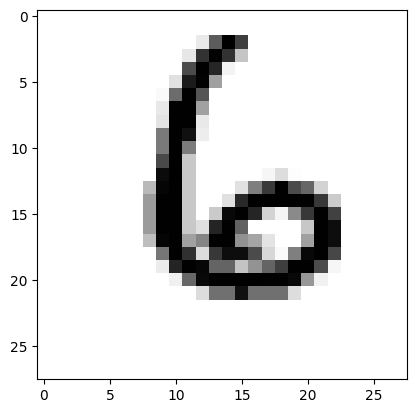

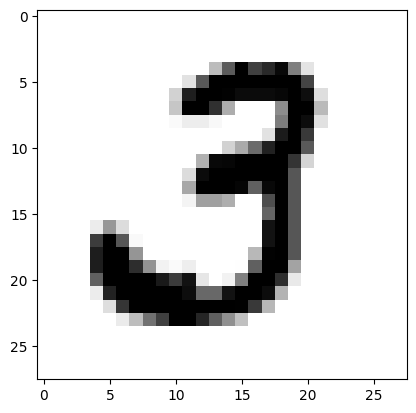

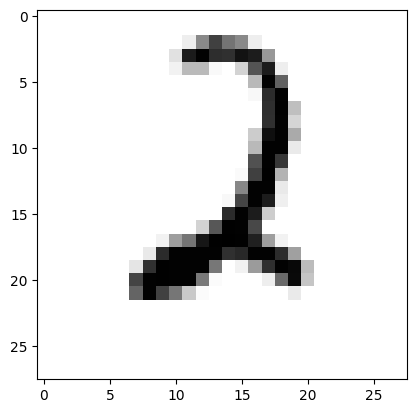

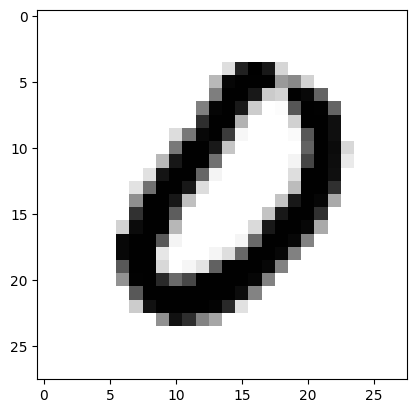

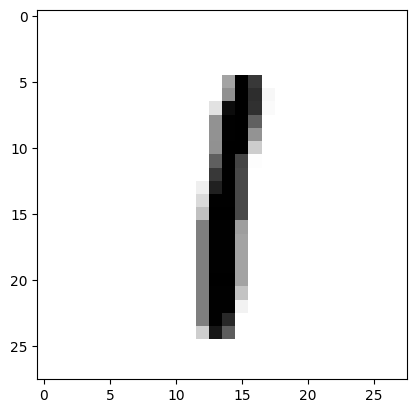

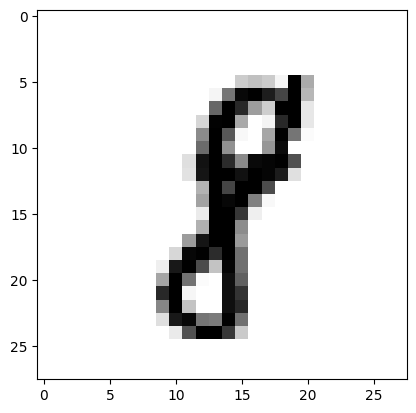

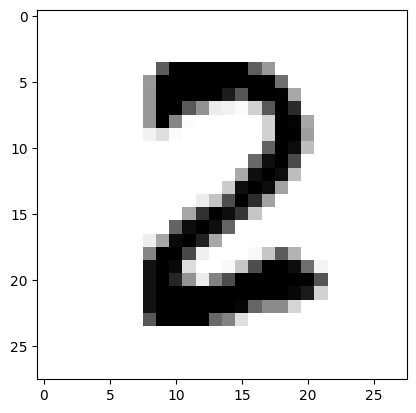

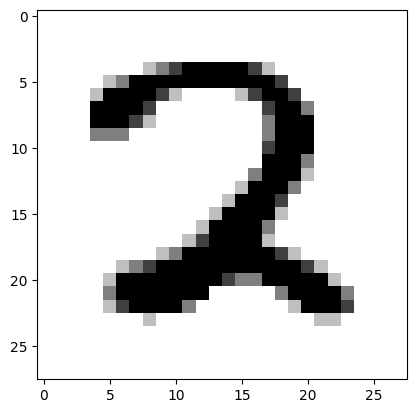

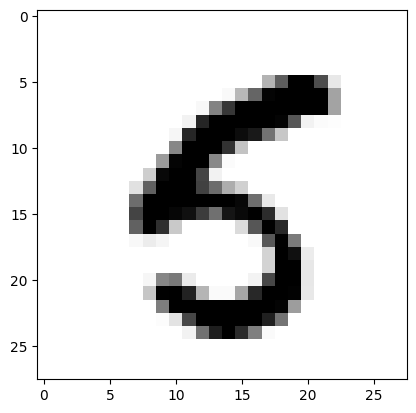

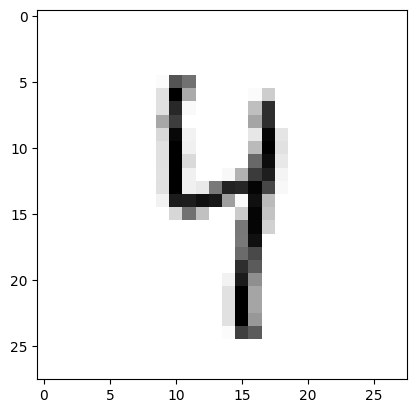

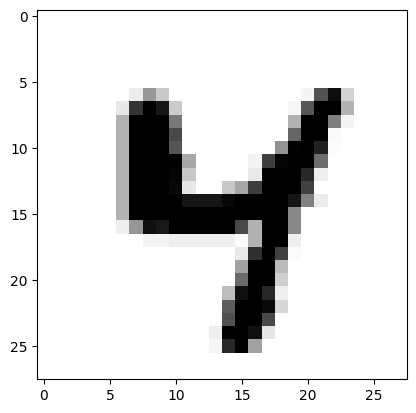

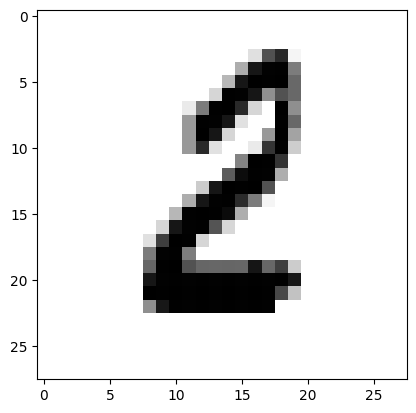

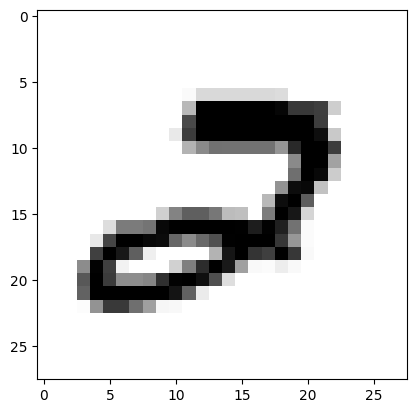

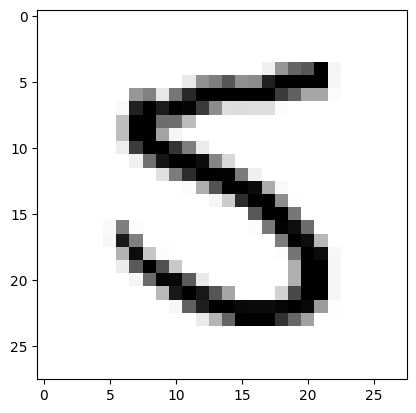

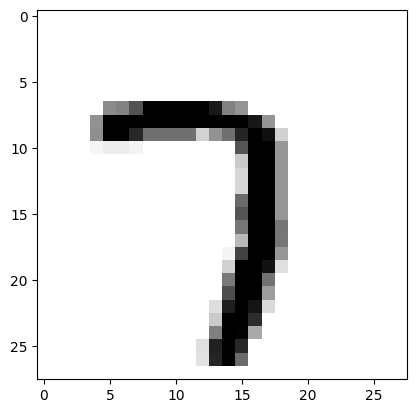

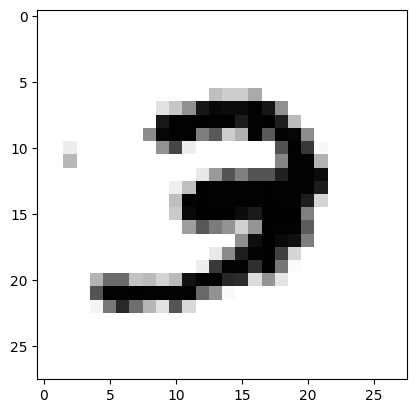

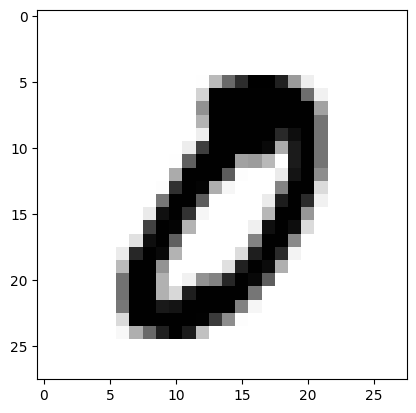

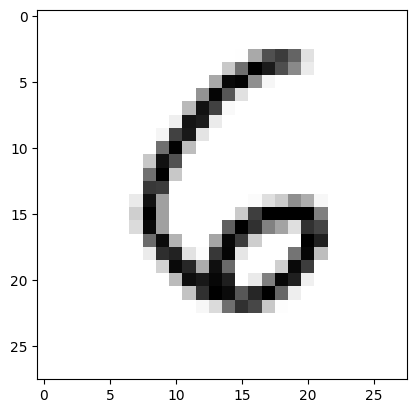

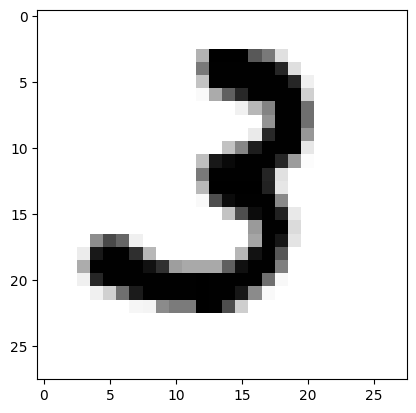

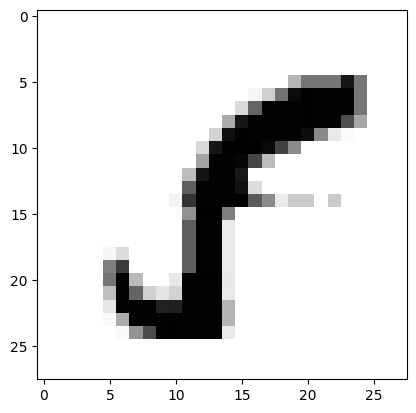

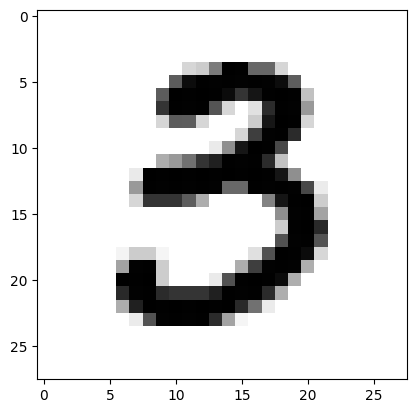

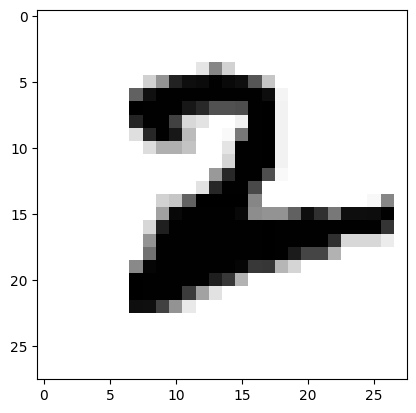

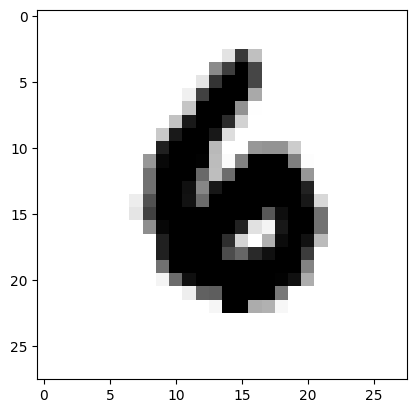

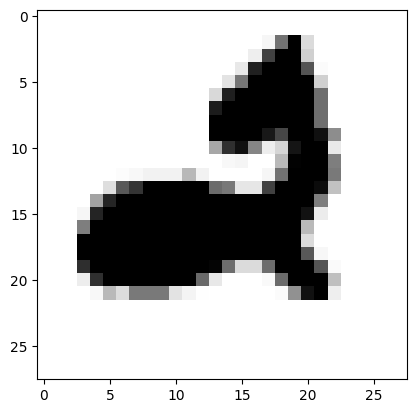

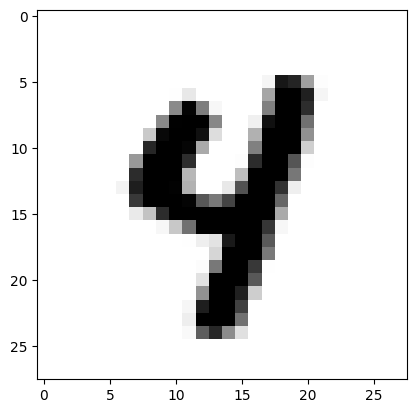

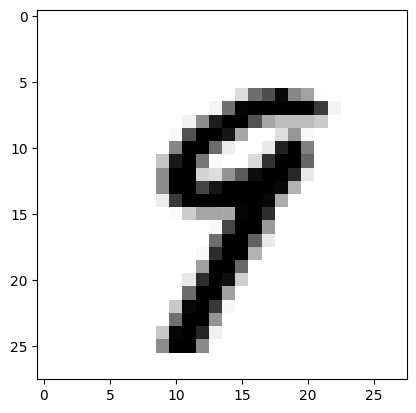

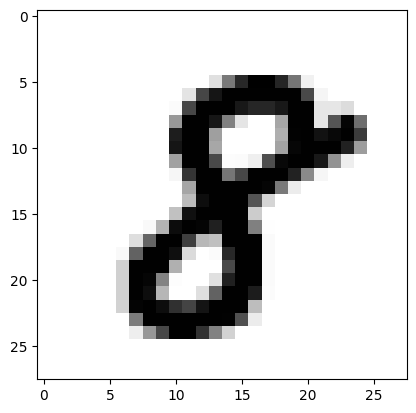

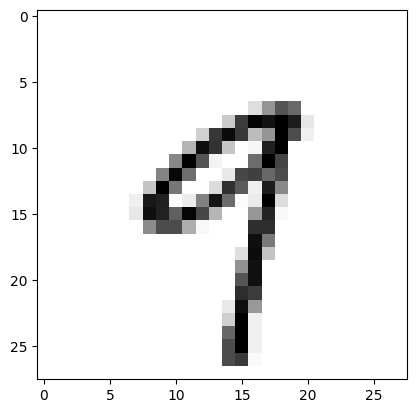

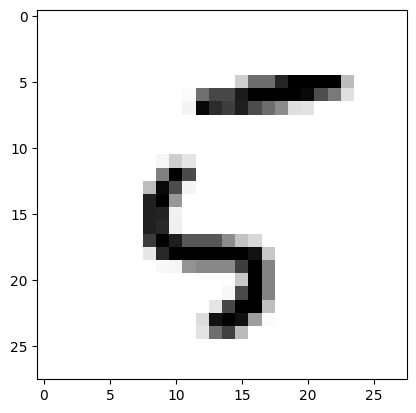

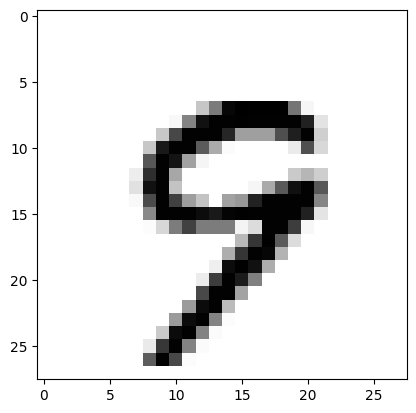

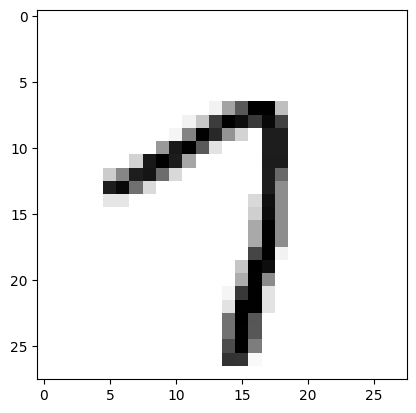

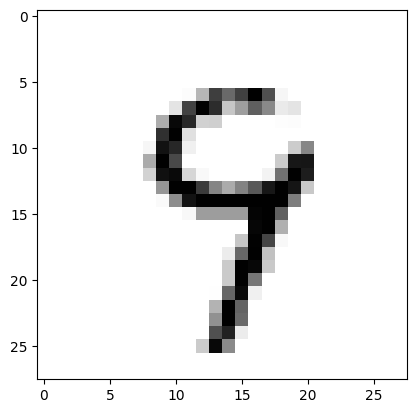

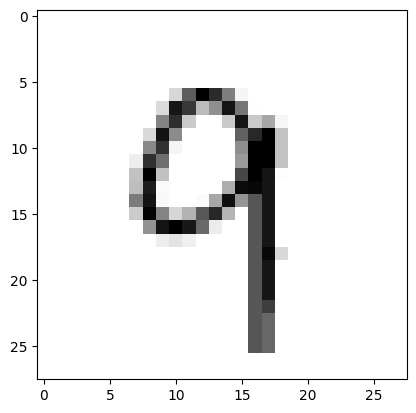

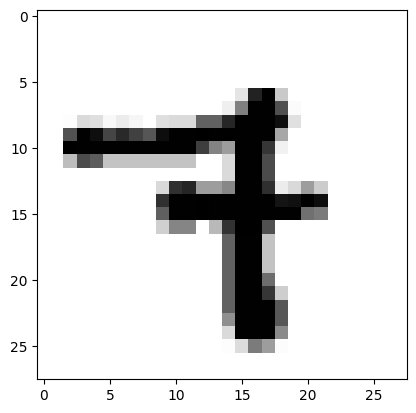

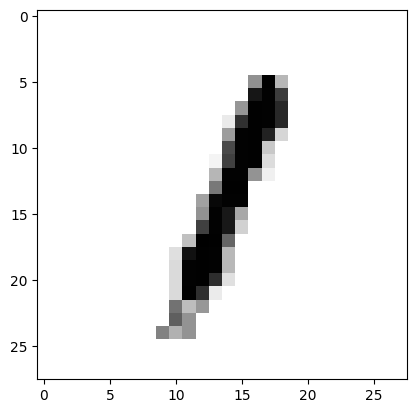

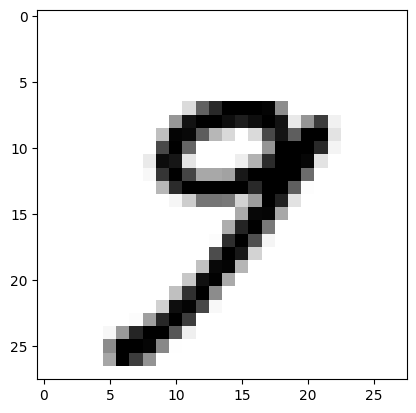

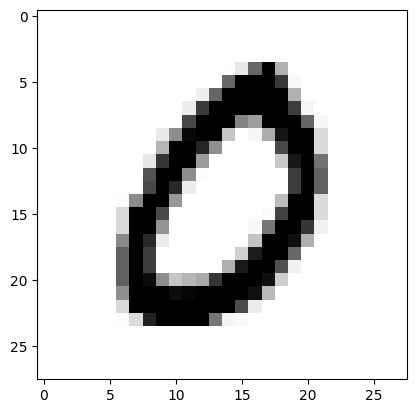

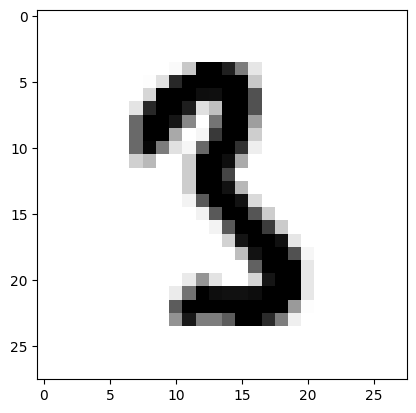

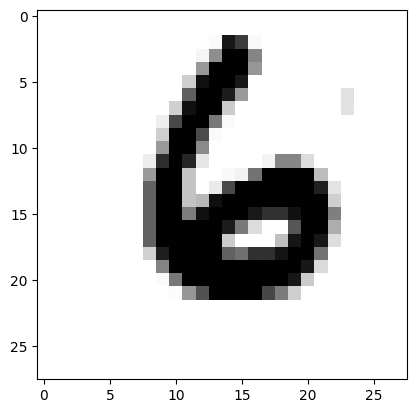

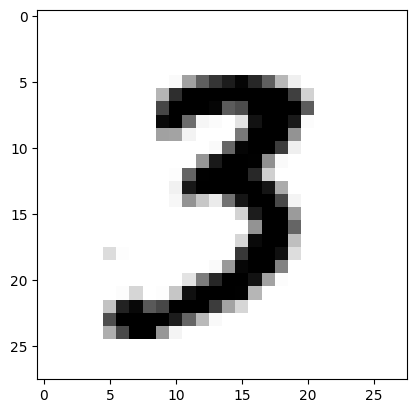

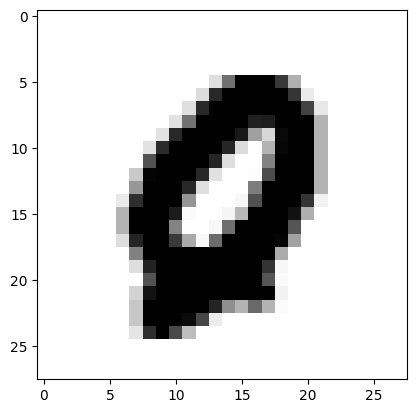

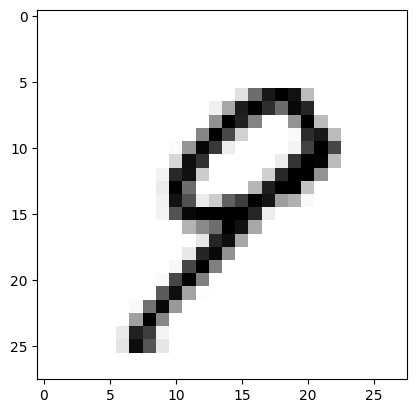

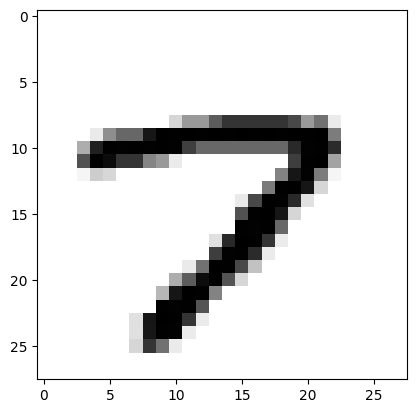

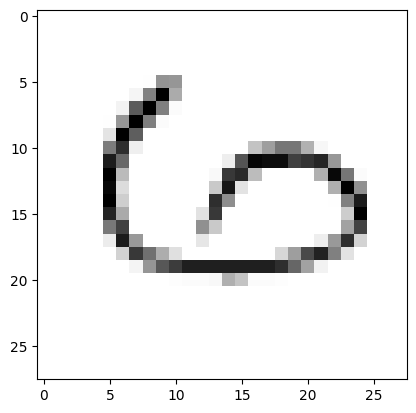

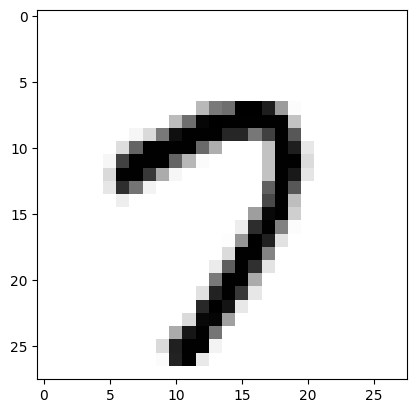

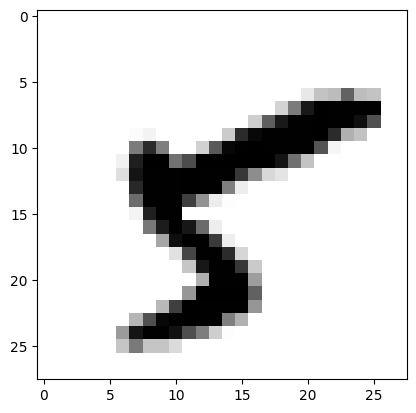

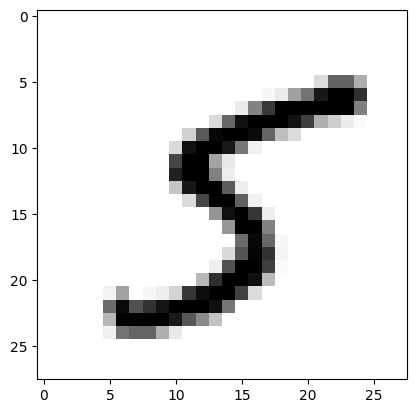

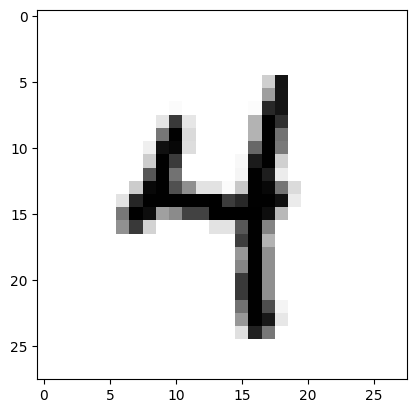

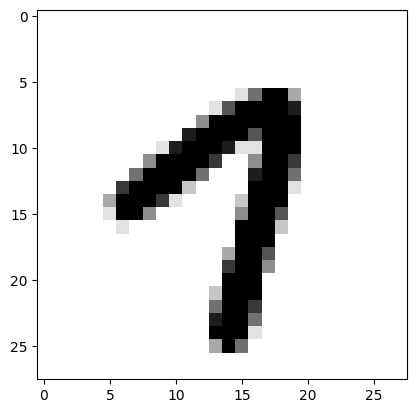

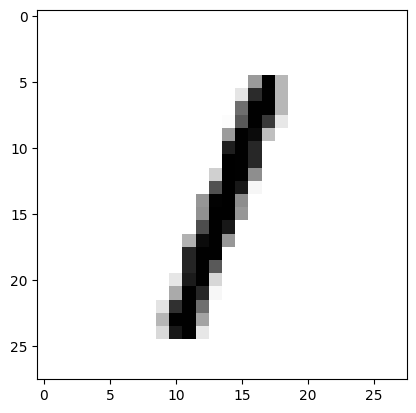

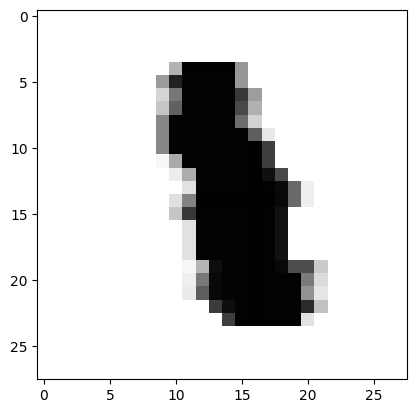

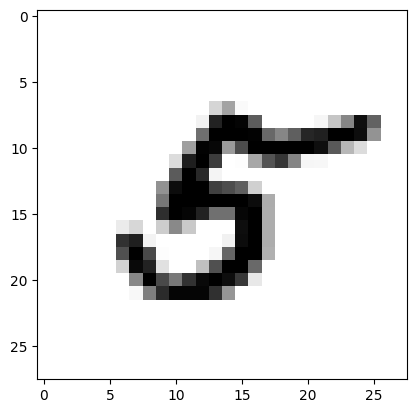

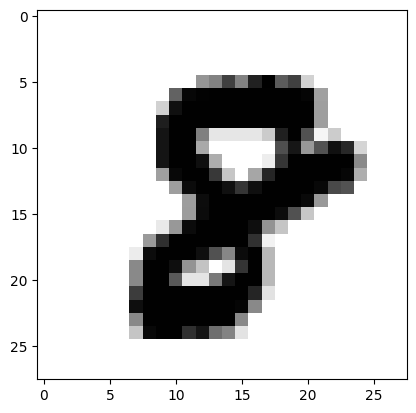

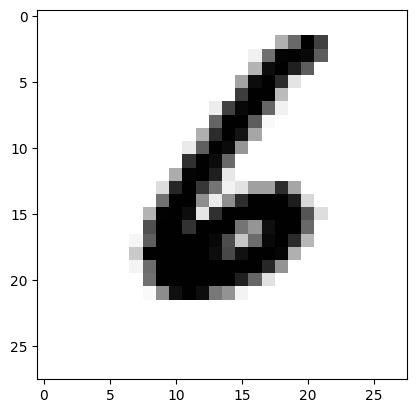

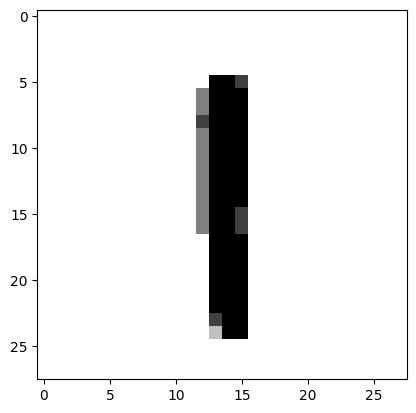

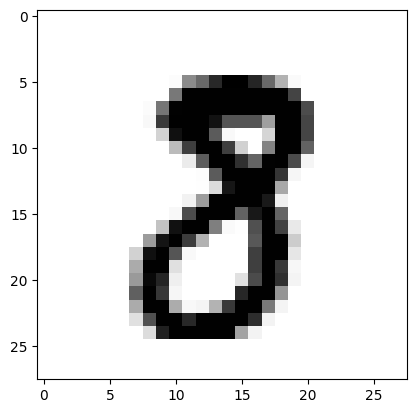

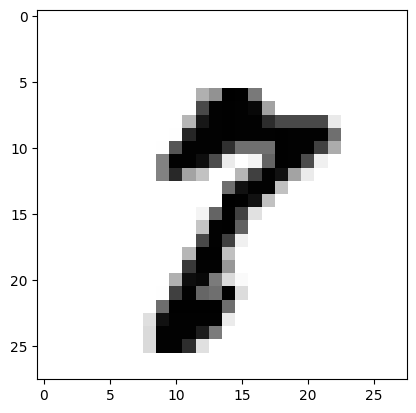

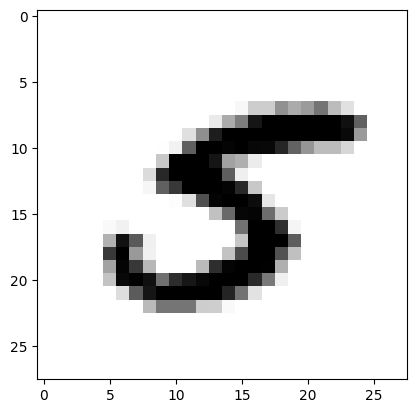

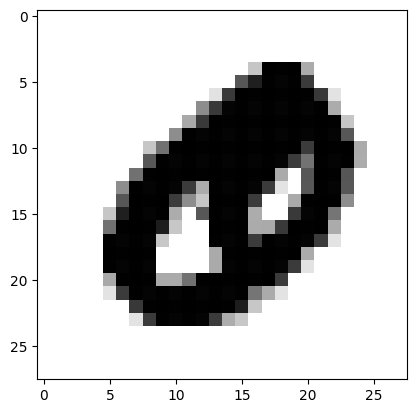

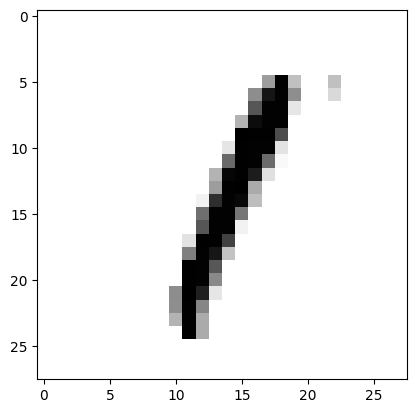

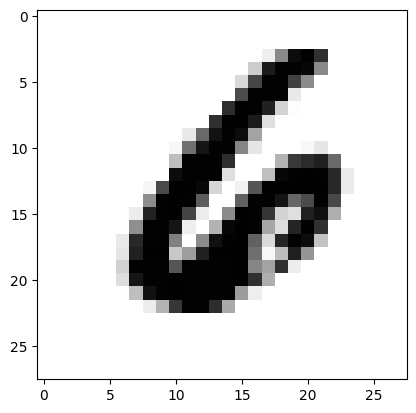

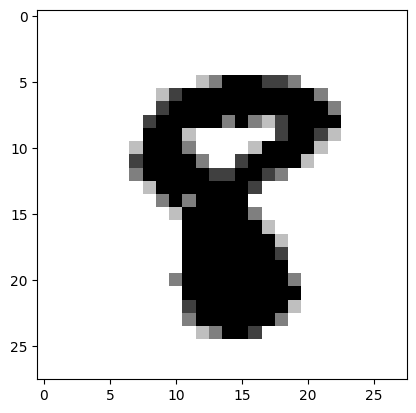

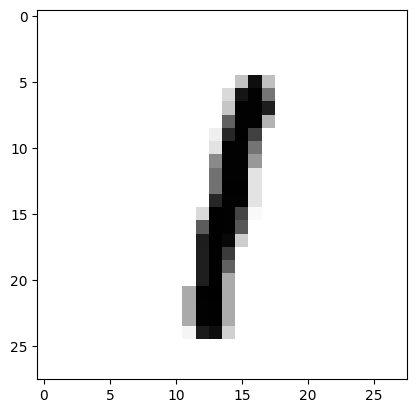

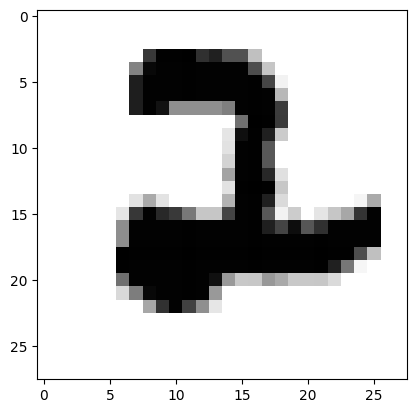

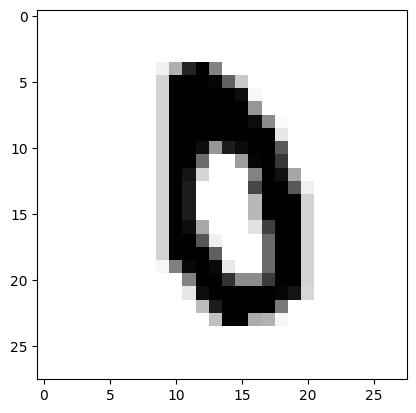

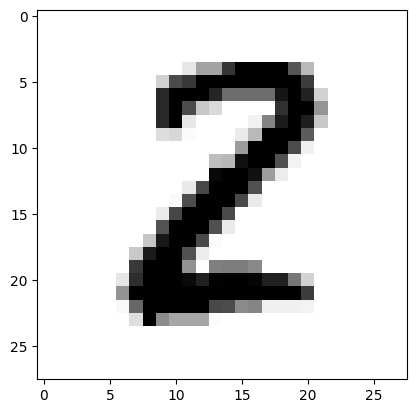

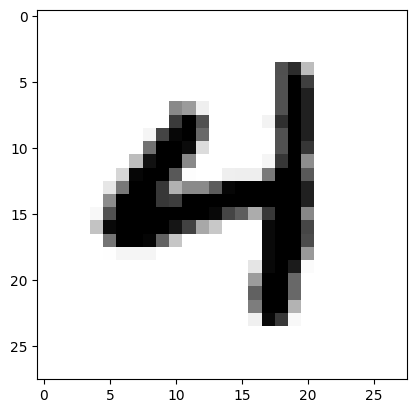

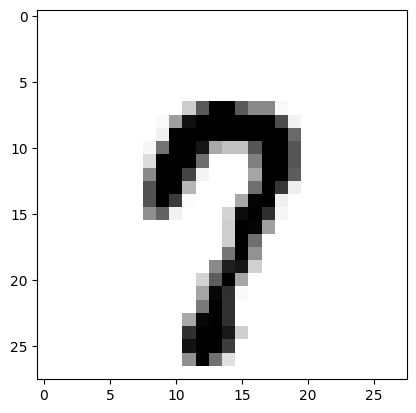

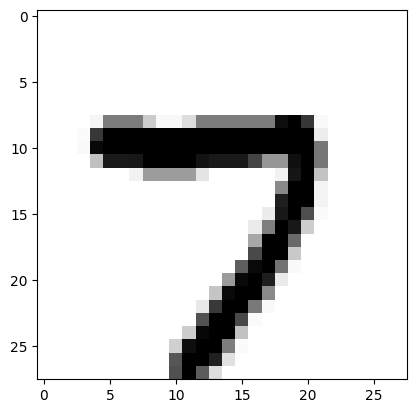

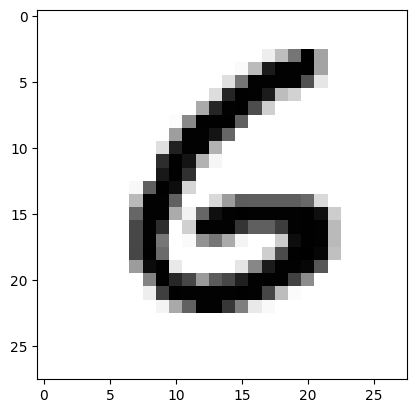

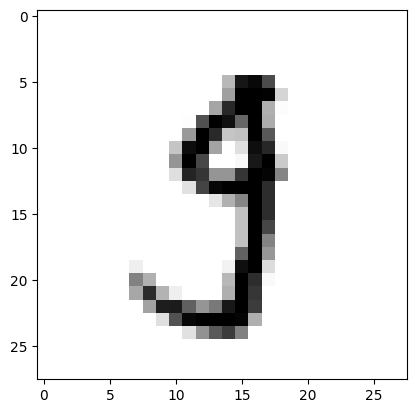

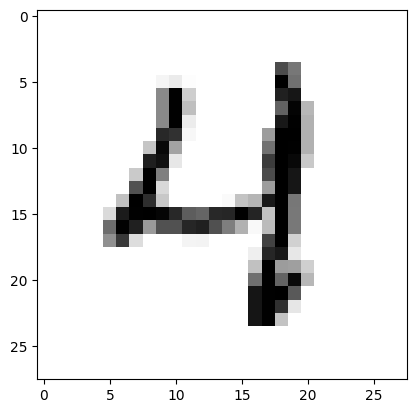

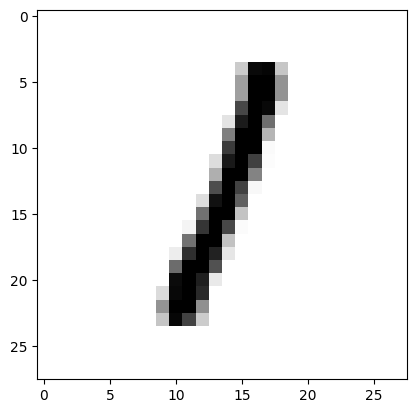

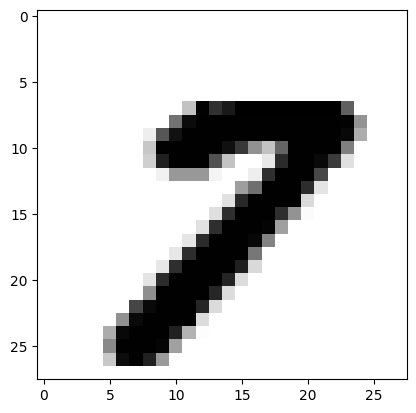

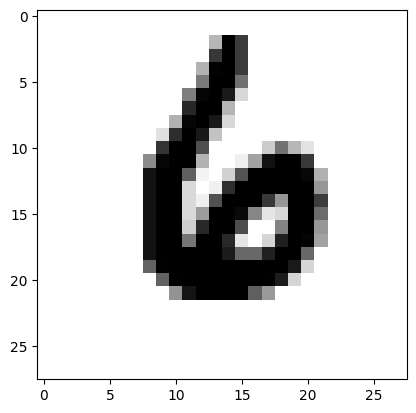

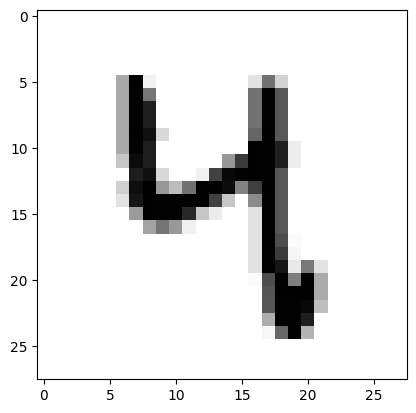

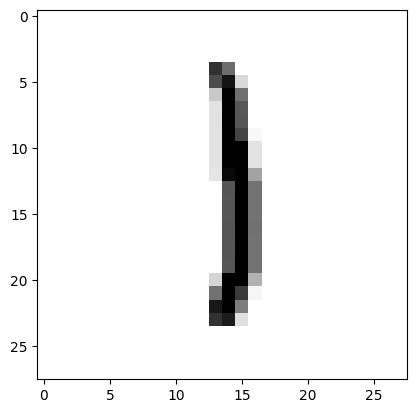

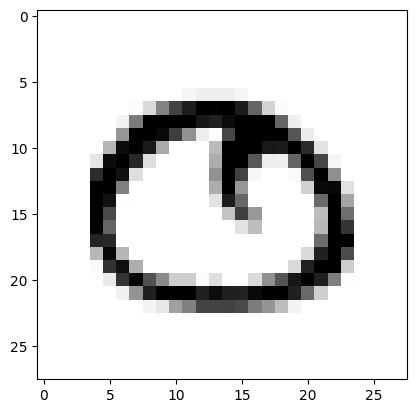

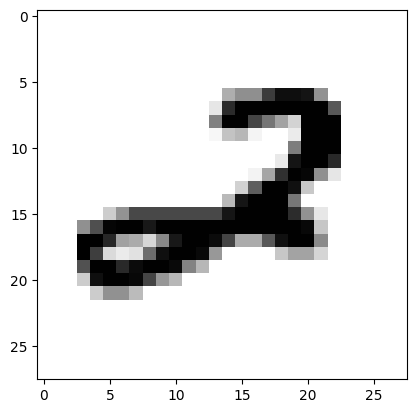

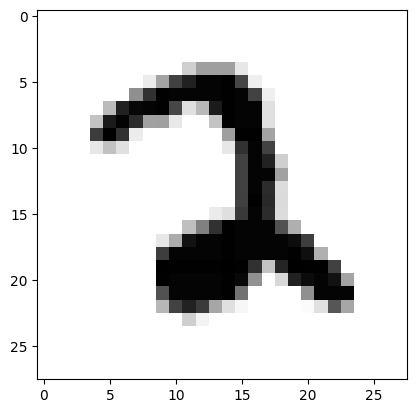

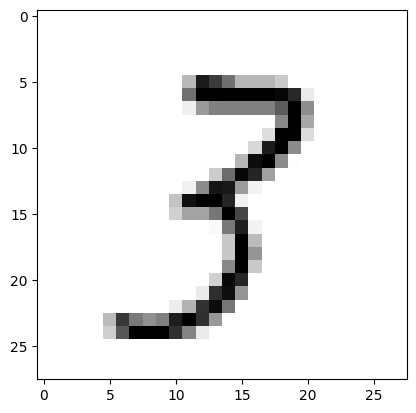

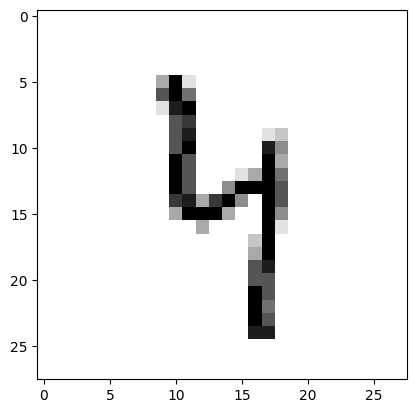

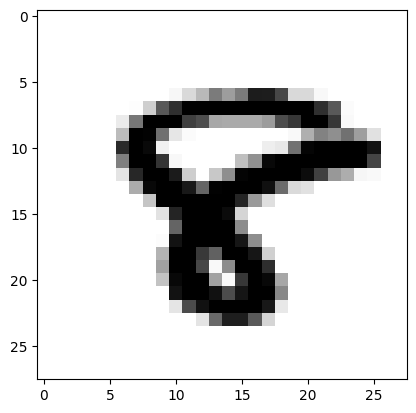

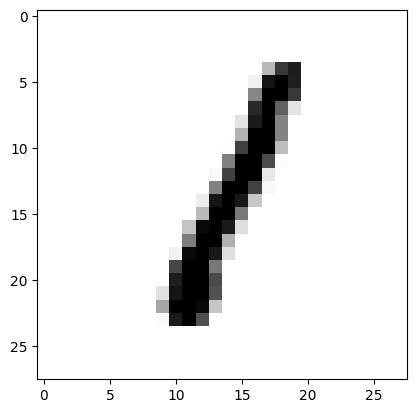

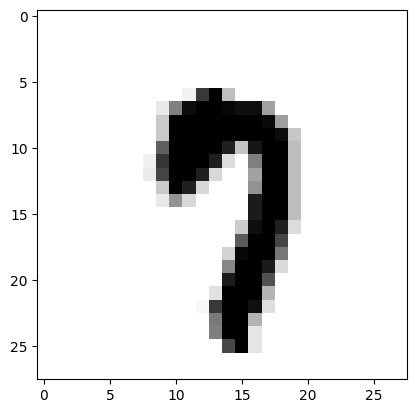

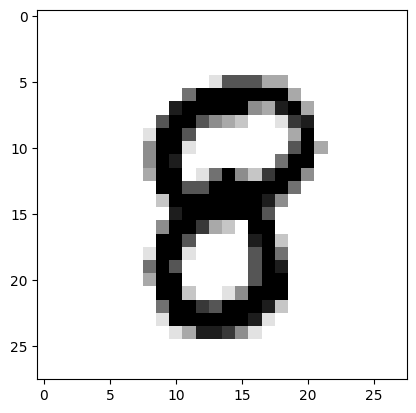

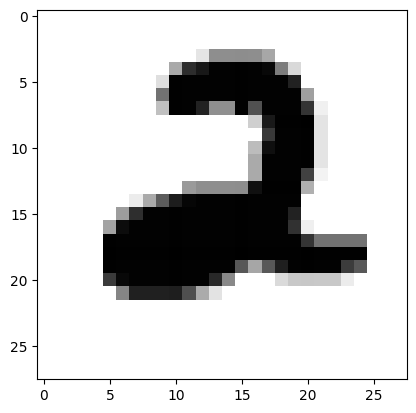

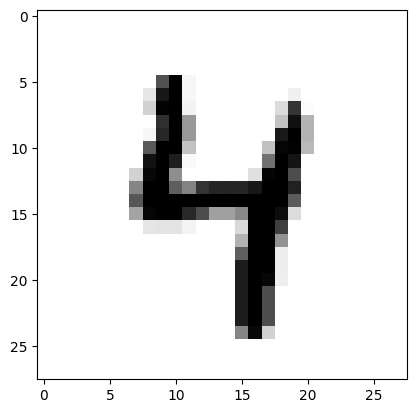

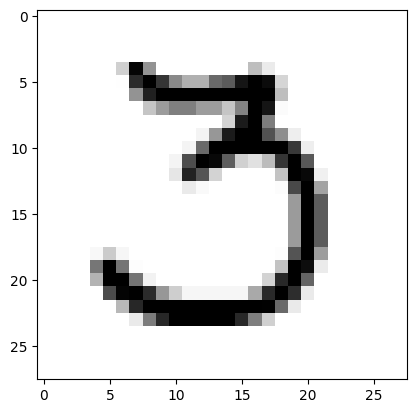

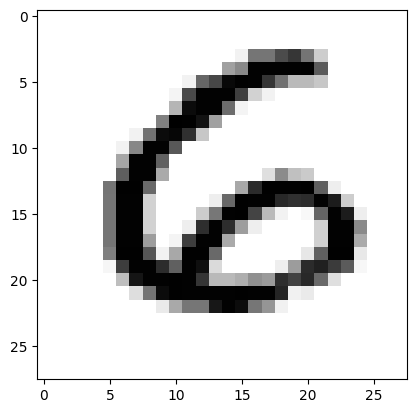

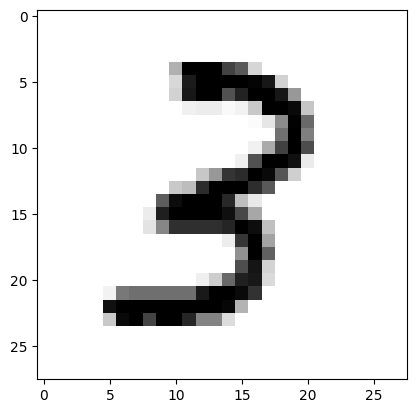

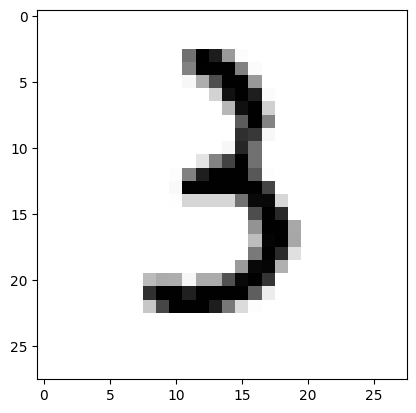

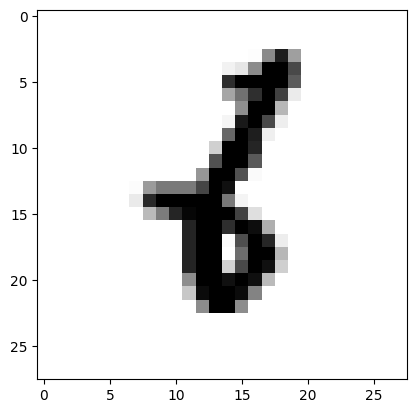

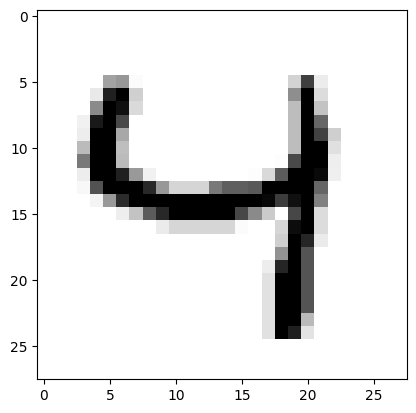

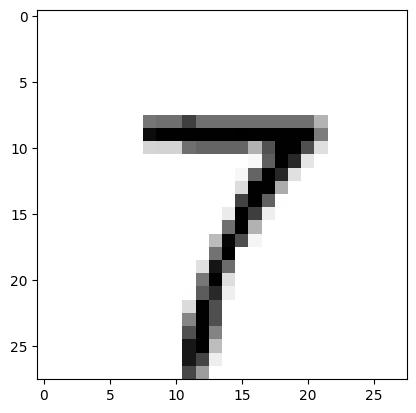

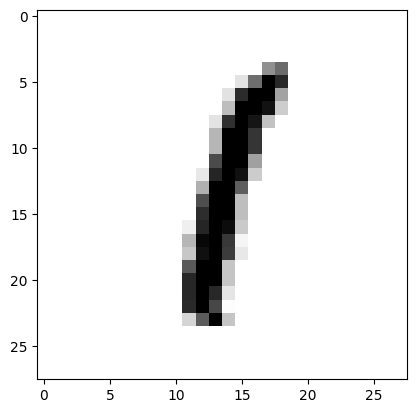

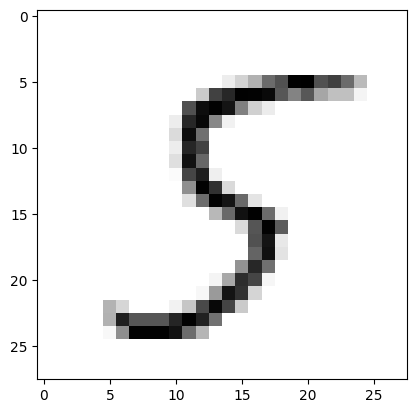

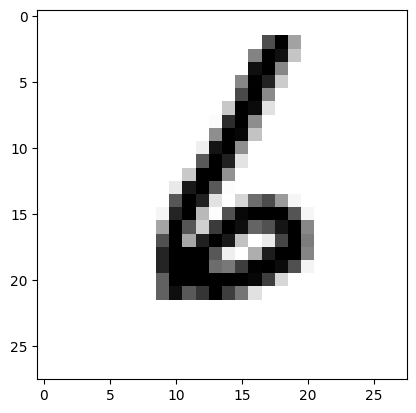

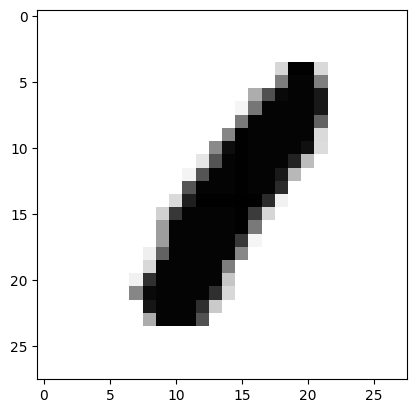

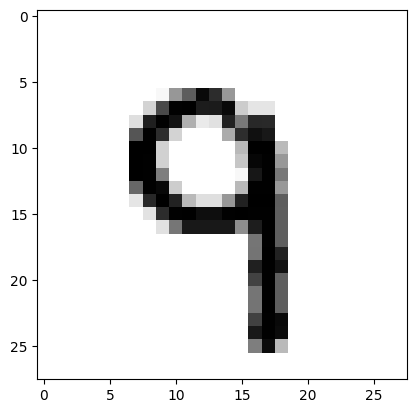

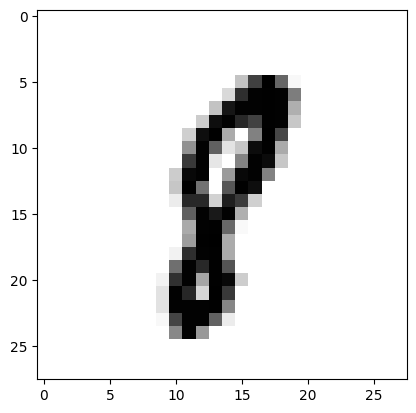

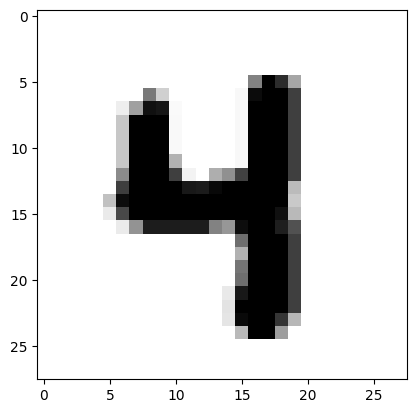

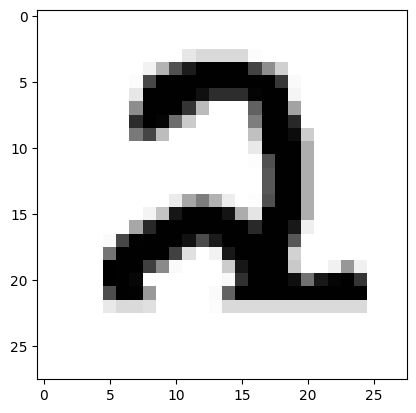

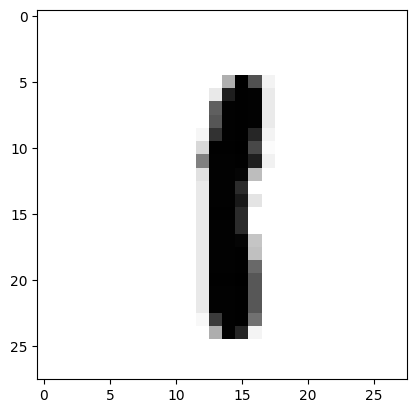

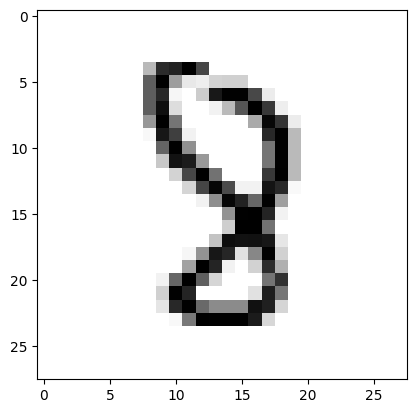

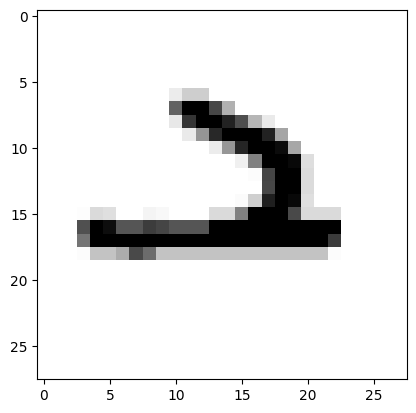

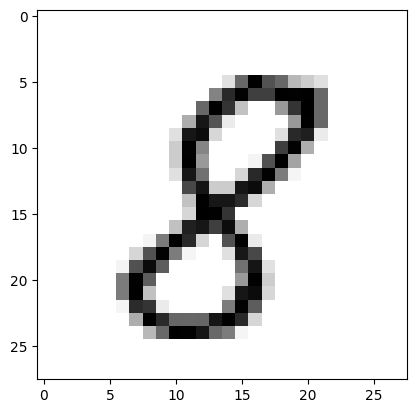

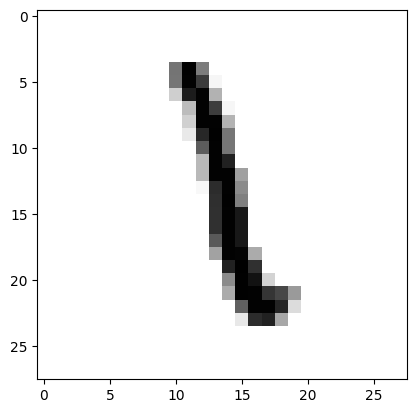

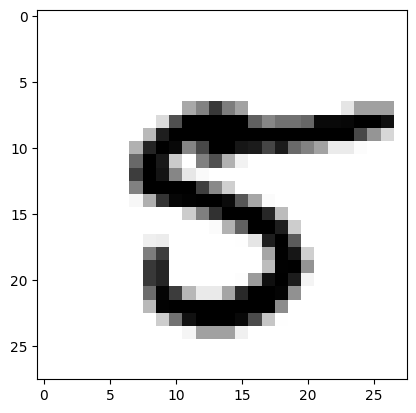

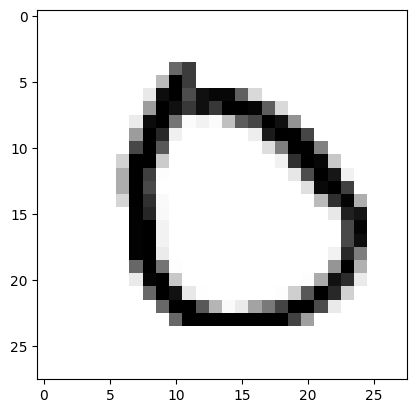

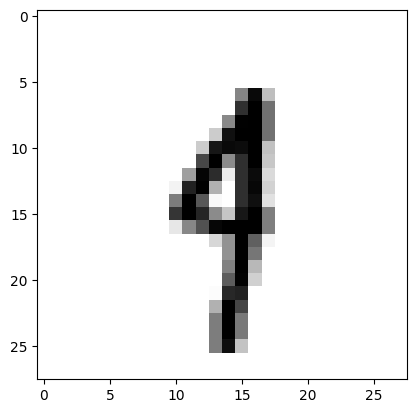

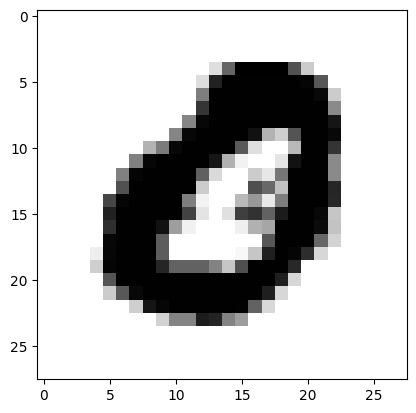

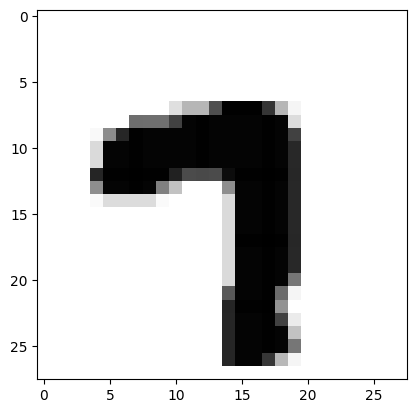

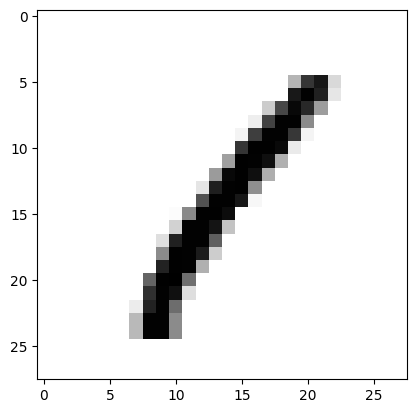

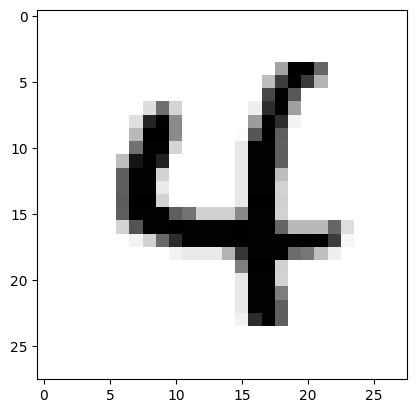

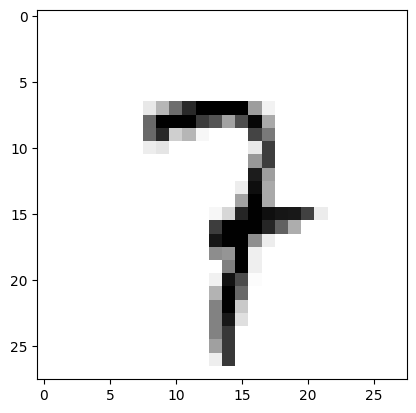

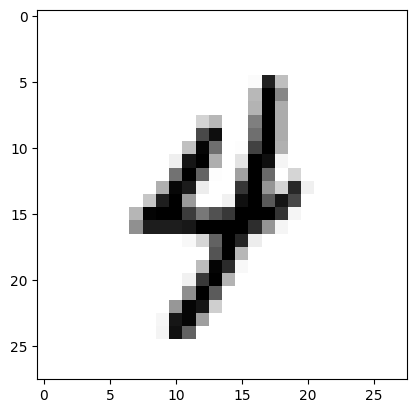

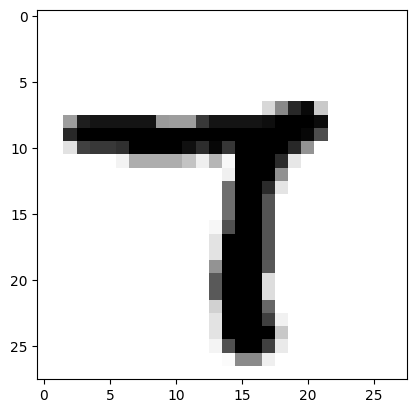

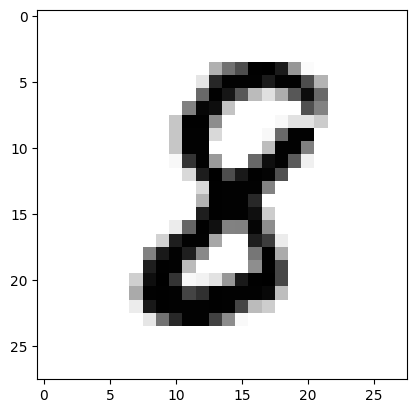

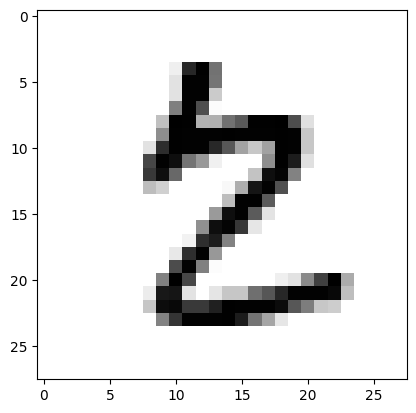

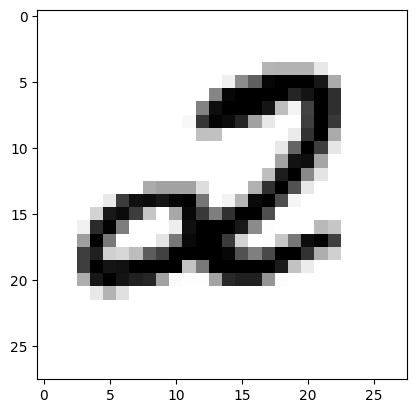

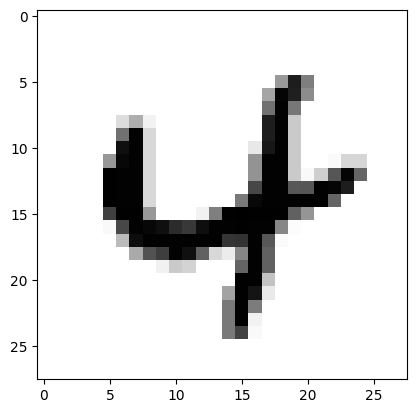

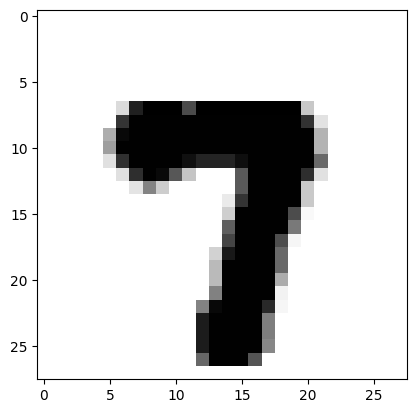

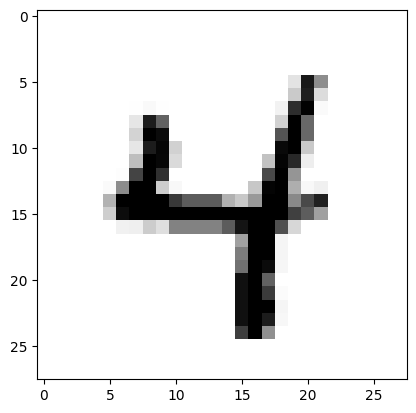

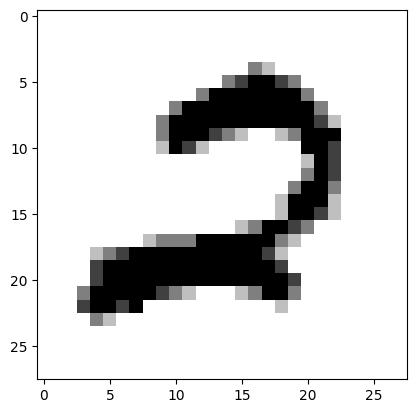

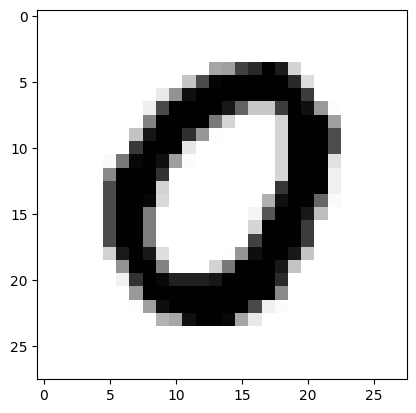

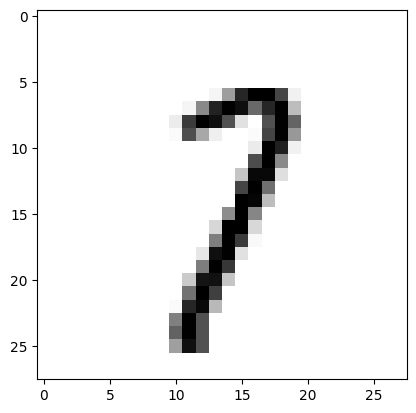

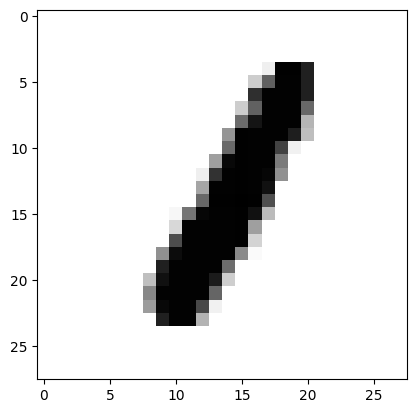

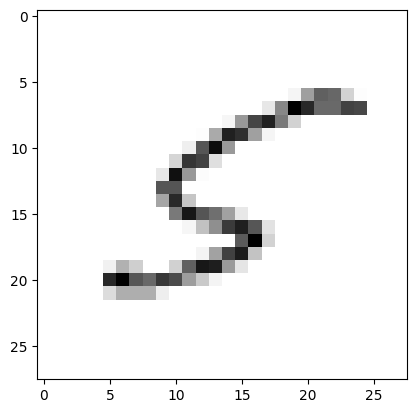

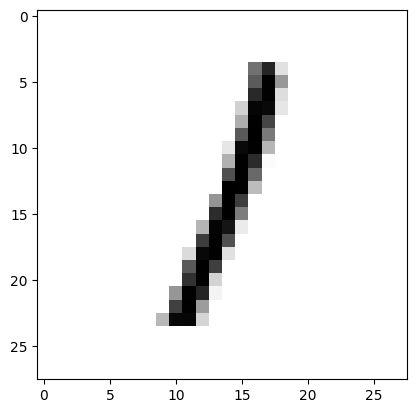

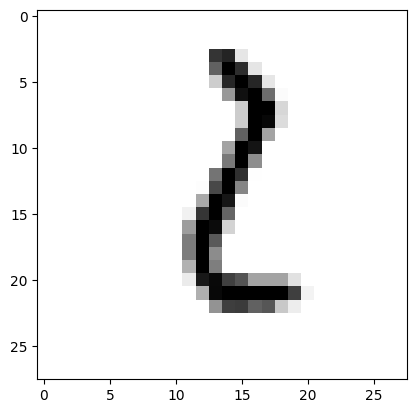

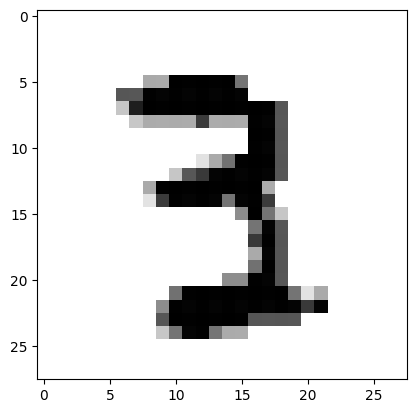

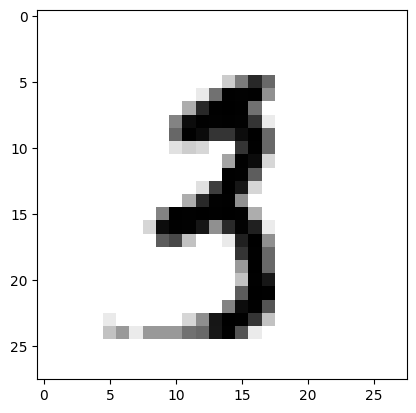

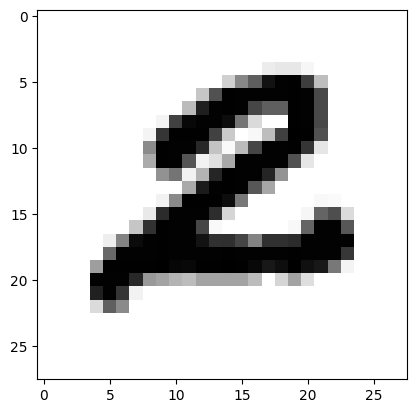

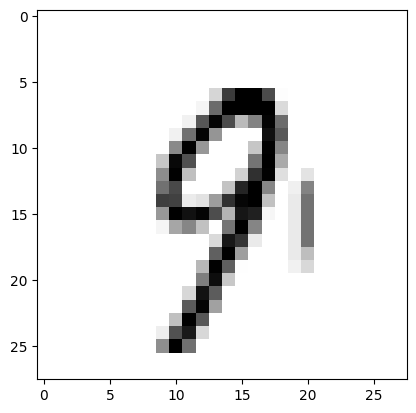

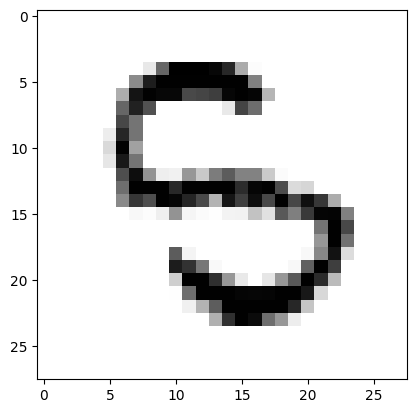

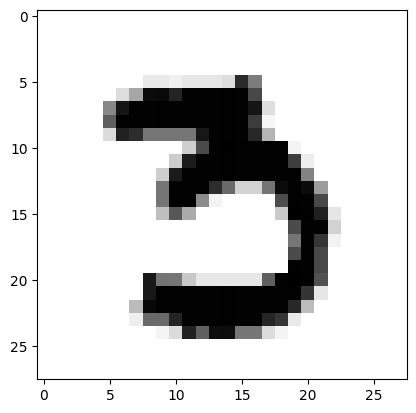

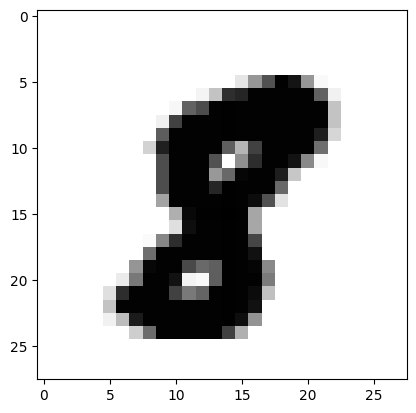

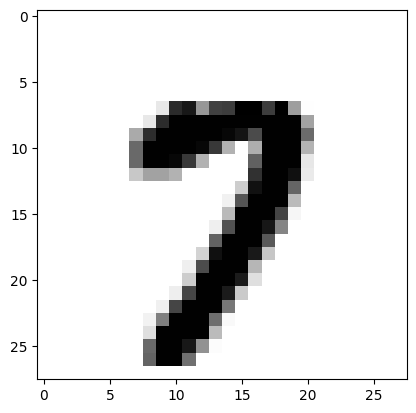

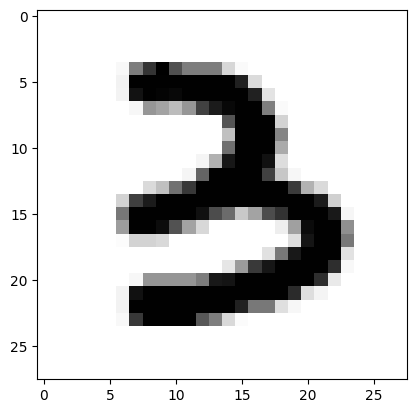

In [25]:
dataiter = iter(trainloader)
for batch in dataiter:
    images, labels = batch
    image = images[0].numpy().squeeze()
    plt.imshow(image, cmap="gray_r")
    plt.show()

In [26]:
print(images[0].shape)  # para verificar as dimensões do tensor de cada imagem
print(labels[0].shape)  # para verificar as dimensões do tensor de cada label

torch.Size([1, 28, 28])
torch.Size([])


In [27]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(
            28 * 28, 128
        )  # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(
            128, 64
        )  # camada oculta, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(
            64, 10
        )  # camada de saída, 64 neurônios que se ligam a 10
        # para a camada de saida não é necessário definir nada pois só precisamos pegar o output da camada oculta 2

    def forward(self, X):
        X = F.relu(
            self.linear1(X)
        )  # função de ativação da camada de entrada para a camada oculta 1
        X = F.relu(
            self.linear2(X)
        )  # função de ativação da camada oculta 1 para a camada oculta 2
        X = self.linear3(
            X
        )  # função de ativação da camada oculta 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1)  # dados utilizados para calcular a loss function

In [28]:
def training(model, trainloader, device):
    optimizer = optim.SGD(
        model.parameters(), lr=0.01, momentum=0.5
    )  # define a politica de atualização dos pesos e da bias
    beginning = time()  # timer para sabermos quanto tempo levou o treino

    criterion = nn.NLLLoss()  # definindo o critério para cancular a perda
    EPOCHS = 10  # número de épocas que o algoritmo irá rodar
    model.train()  # define o modelo para o modo de treino

    for epoch in range(EPOCHS):
        acumulated_loss = 0  # variável para acumular a perda de cada época

        for images, labels in trainloader:
            images = images.view(
                images.shape[0], -1
            )  # transforma a imagem em um vetor de 784 posições
            optimizer.zero_grad()  # zera o gradiente para não acumular os valores

            output = model(images.to(device))  # passa a imagem para o modelo
            instant_loss = criterion(output, labels.to(device))  # calcula a perda

            instant_loss.backward()  # calcula o gradiente

            optimizer.step()  # atualiza os pesos e bias

            acumulated_loss += instant_loss.item()  # acumula a perda

        else:
            print(
                "Epoch {} - Perda resultante: {}".format(
                    epoch, acumulated_loss / len(trainloader)
                )
            )
    print("\nTempo de treino (em minutos) =", (time() - beginning) / 60)

In [29]:
def validator(model, valloader, device):
    correct_accounts, all_accounts = 0, 0
    for images, labels in valloader:
        for index in range(len(labels)):
            img = images[index].view(1, 784)
            # desativar o autograd para acelerar a validação, Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = model(img.to(device))  # output do modelo em escala logaritmica

            ps = torch.exp(
                logps
            )  # transforma o output em escala logaritmica para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])  # transforma o tensor em um array numpy
            label_pred = probab.index(
                max(probab)
            )  # converte o tensor em um numero, no caso, o número que o modelo previu como correto
            label_real = labels.numpy()[index]
            if label_real == label_pred:
                correct_accounts += 1
            all_accounts += 1

    print("Total de imagens testadas =", all_accounts)
    print("\nPrecisão do modelo = {}%".format(correct_accounts * 100 / all_accounts))

In [30]:
model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)